In [1]:
import gc
from itertools import chain
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# user modules
import sys
import os
from os import path
sys.path.append(path.dirname(path.abspath('')))
from models.wideresnet import WideResNet
from models.resnet import ResNet9, ResNet50
from metrics.similarity import *
from data.partition import partition_data, get_partition_dict
from data.datasets import load_cifar10_data
from data.dataloader import get_dataloader

In [3]:
device = torch.device('cuda')

In [4]:
def find_ckpt(expname, comm, modeldir='../ckpt', epoch=None, client=None):
    f = filter(lambda x: expname in x, os.listdir(modeldir))
    f = filter(lambda x: f'comm{comm:03}' in x, f)
    if client is None:
        f = filter(lambda x: f'GLOBAL' in x, f)
    else:
        if epoch:
            f = filter(lambda x: f'epoch{epoch:03}' in x, f)
        f = filter(lambda x: f'CLIENT{client:02}' in x, f)
    return list(f)[0]

In [5]:
def extract_repr(model, dataset, layers, n_samples, device):
    reprs = []
#     def pre_hook(module, input_):
#         reprs.append(input_)
    def hook(module, input_, output):
#         print(f'hook executed in {module}')
        reprs.append(output)
    if layers is not None:
        modules = [v for k, v in model.named_modules() if k in layers]
    else:
        modules = [v for k, v in model.named_modules()]
#     print(f'Registered hook for {len(modules)} modules.')
    for module in modules:
        module.register_forward_hook(hook)

    with torch.no_grad():
        data = torch.stack([data for data, target in dataset][:n_samples])
        if device:
            model = model.to(device)
            data = data.to(device)
        model(data)
    return [rep.view(rep.shape[0], -1).to(device) for rep in reprs]

In [6]:
def calc_sim(model_a, model_b,  dataset_a, dataset_b=None, layers_a=None, layers_b=None, n_samples=256, device=None):
#     assert model_a == model_b
#     assert dataset_a == dataset_b
#     assert layers_a == layers_b
    dataset_b = dataset_b or dataset_a
    reprs_a= extract_repr(model_a, dataset_a, layers_a, n_samples, device=device)
    reprs_b= extract_repr(model_b, dataset_b, layers_b, n_samples, device=device)
    cka = np.zeros((len(reprs_a), len(reprs_b)))
    i=0
    for r_a in tqdm(reprs_a):
        j=0
        for r_b in reprs_b:
            with torch.no_grad():
                cka[i,j] = kernel_CKA(r_a, r_b, device=device)
            j+=1
        i+=1
    return cka

In [7]:
def plot(sim, path):
    plt.figure(figsize=(30, 15), dpi=200)
    axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
    axes.axes.invert_yaxis()
    if path:
        plt.savefig(path, dpi=400)

In [8]:
'''
cnum_a, cnum_b: -1 means global
dsetnum_a, dsetnum_b: -1 means testset
'''
def compare_model(
    cnum_a, cnum_b, dsetnum_a, dsetnum_b,
    comm_round, partition, expname,
    datadir='~/data', modeldir='../ckpt',
    model=None,
    num_classes=10,
    epoch=None,
    device=torch.device('cuda')
):
    # load dataset index map
    target_idx = dsetnum_a
    if dsetnum_a<0:
        target_idx = 0
    net_dataidx_map = get_partition_dict('cifar10', partition, 10, datadir='~/data', init_seed=0)
    _, _, trainset, testset= get_dataloader(
        'cifar10', '~/data', 256, 32,
        net_dataidx_map[target_idx], 0, augment=False
    )
    dset_a = testset if dsetnum_a<0 else trainset
        
    if dsetnum_a == dsetnum_b:
        dset_b = dset_a
    elif dsetnum_b<0:
        dset_b = testset
    else:
        _, _, trainset, testset= get_dataloader(
            'cifar10', '~/data', 256, 32,
            net_dataidx_map[dsetnum_b], 0, augment=False
        )
        dset_b = trainset

    # model to compare
    net_a = model(num_classes=num_classes)
    net_a.load_state_dict(torch.load(
        os.path.join(modeldir, find_ckpt(expname, comm=comm_round, client=cnum_a if cnum_a>=0 else None, modeldir=modeldir, epoch=epoch))
    ))
    if cnum_a == cnum_b:
        net_b = net_a
    else:
        net_b= model(num_classes=num_classes)
        net_b.load_state_dict(torch.load(
            os.path.join(modeldir, find_ckpt(expname, comm=comm_round, client=cnum_b if cnum_b>=0 else None, modeldir=modeldir, epoch=epoch))
        ))
        
    cond = lambda x: 'activation' in x
#     cond = lambda x: ('conv' in x) or ('batchnorm' in x) or ('activation' in x)
    layers_a = [k for k, v in net_a.named_modules() if cond(v.__module__)]
    layers_b = [k for k, v in net_b.named_modules() if cond(v.__module__)]
    
    try:
        cka = calc_sim(
            net_a, net_b, dataset_a=dset_a, dataset_b=dset_b, layers_a=layers_a, layers_b=layers_b, device=device
        )
    finally:
        del net_a, net_b, dset_a, dset_b
        gc.collect()
        torch.cuda.empty_cache()
    return cka

In [11]:
cka = compare_model(
    0, 0,
    0, 0,
    2,
    'homo',
#     'noniid-labeldir',
    'R50-IID2',
    datadir='~/data', modeldir='../ckpt',
    model=ResNet50
)

Registered hook for 17 modules.
Registered hook for 17 modules.


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

/tmp/ipykernel_4074/4014690525.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30, 15), dpi=200)


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

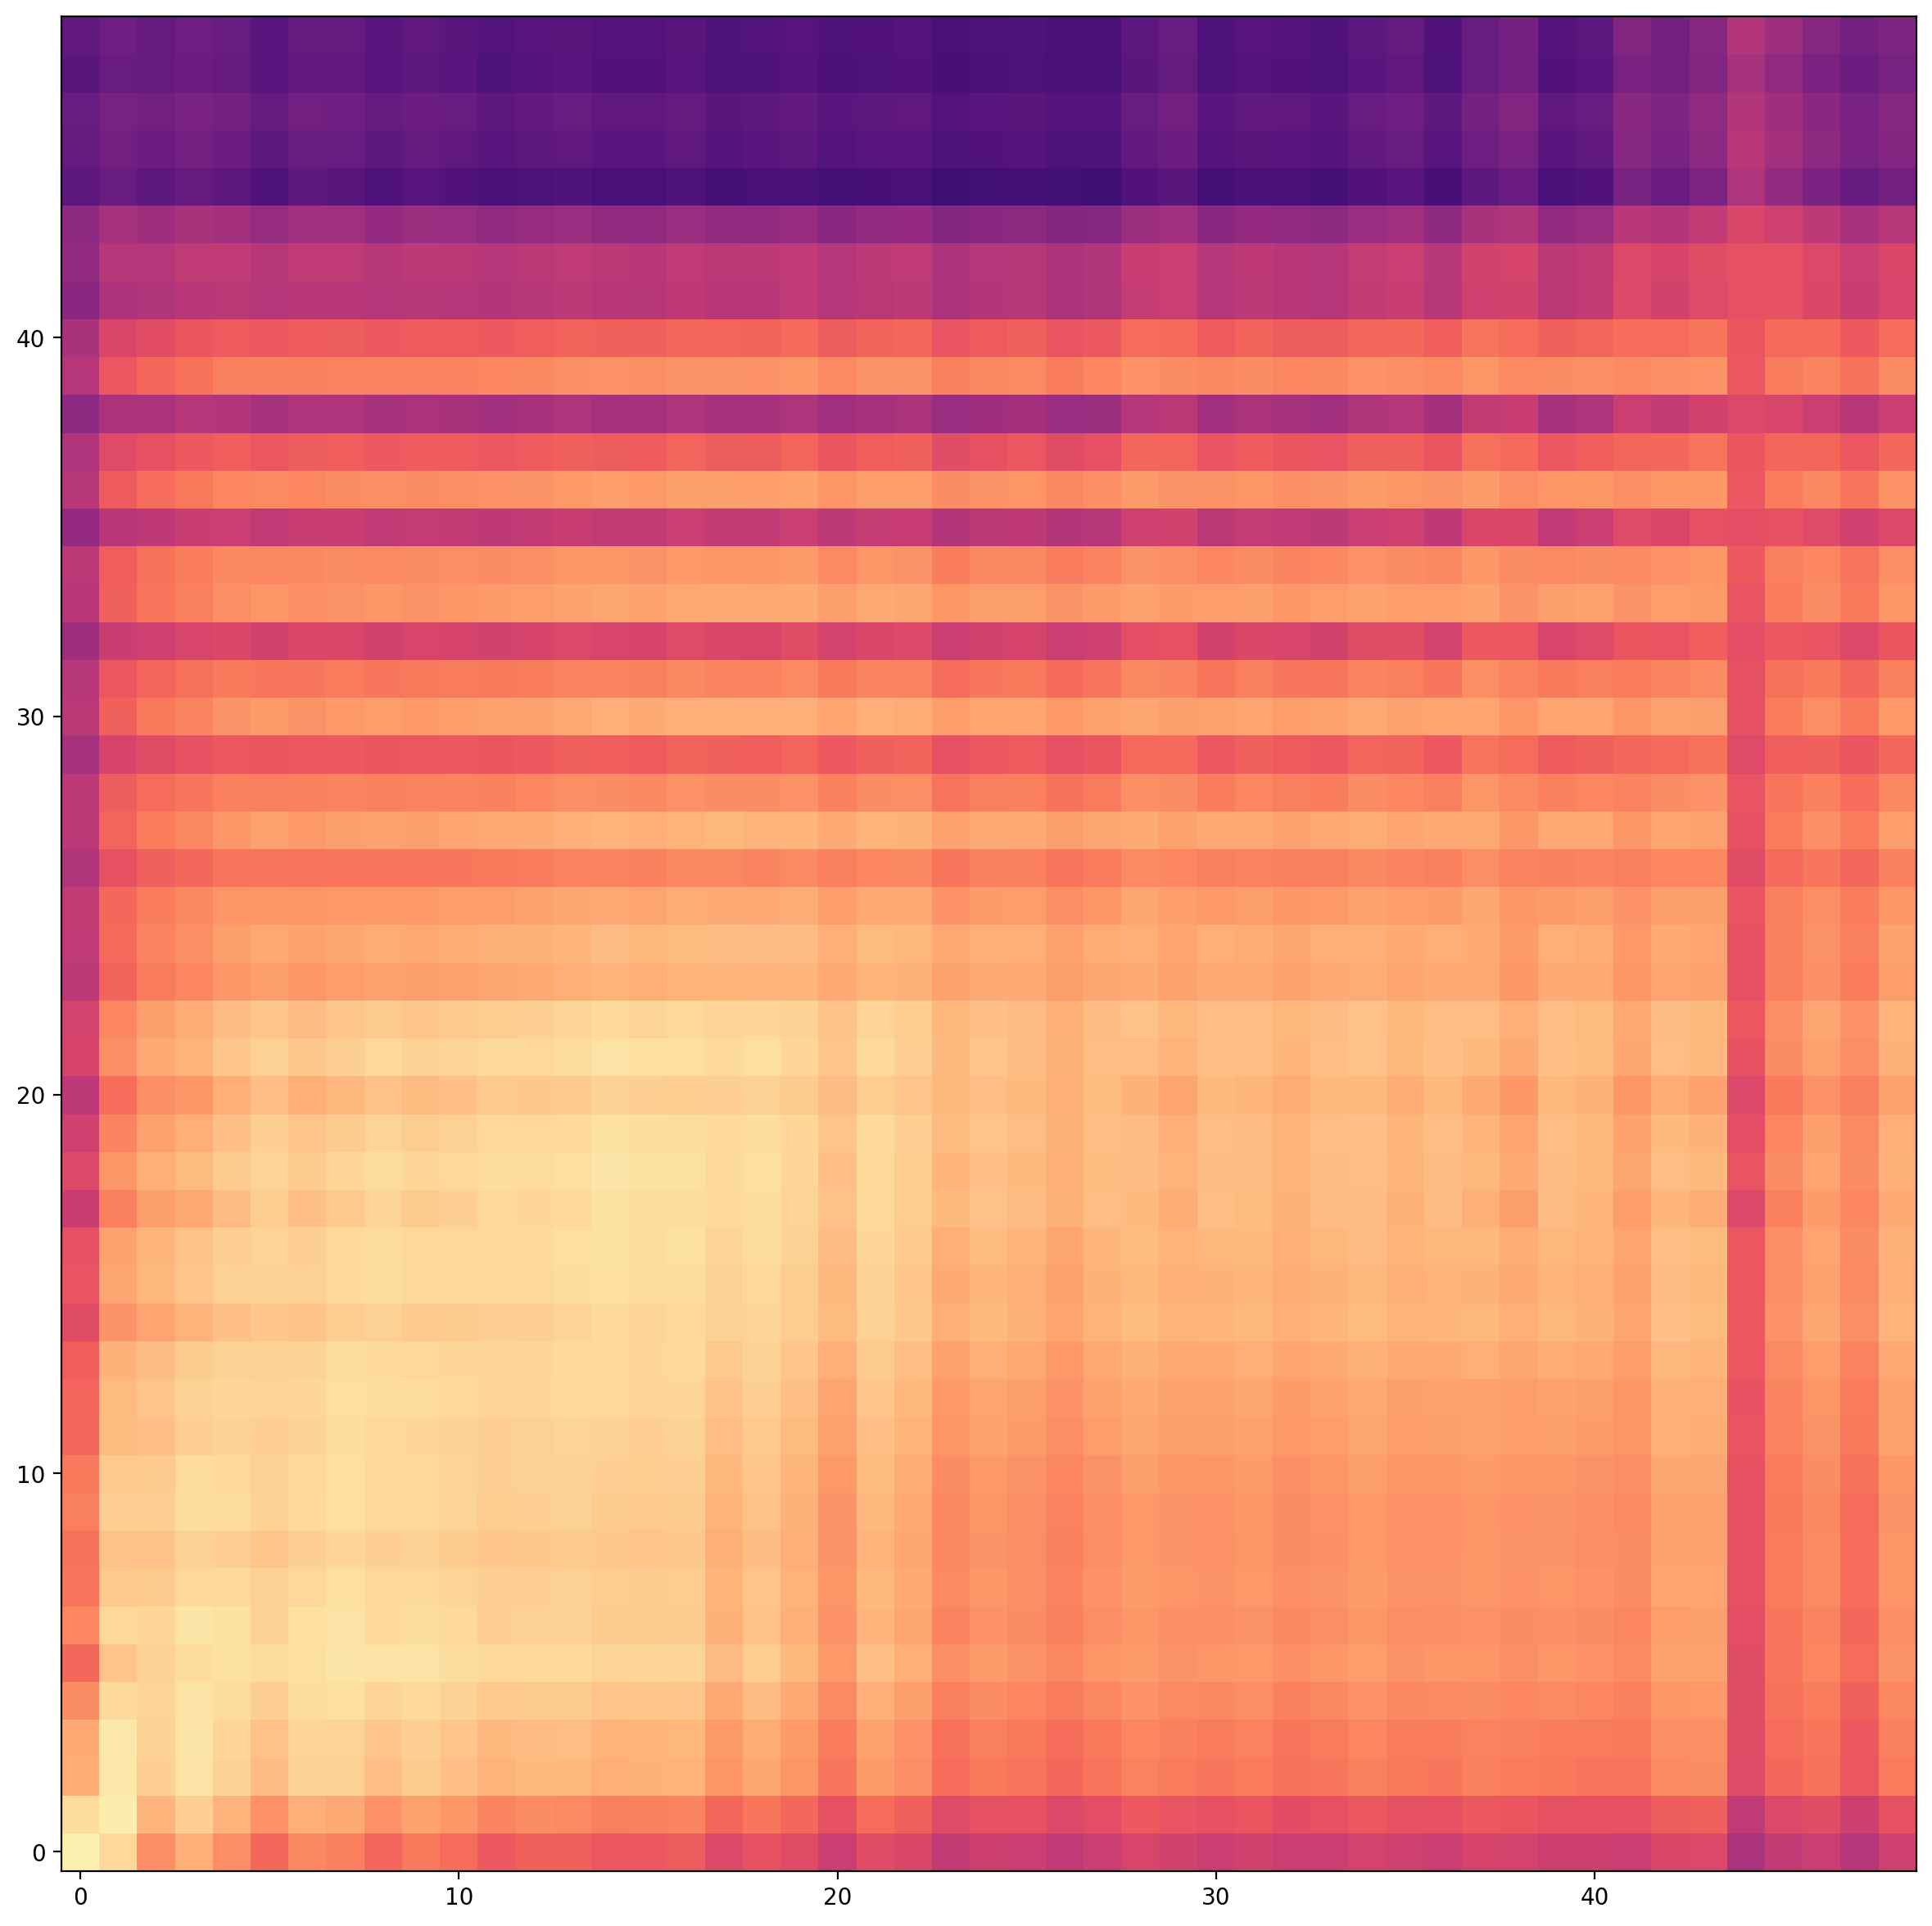

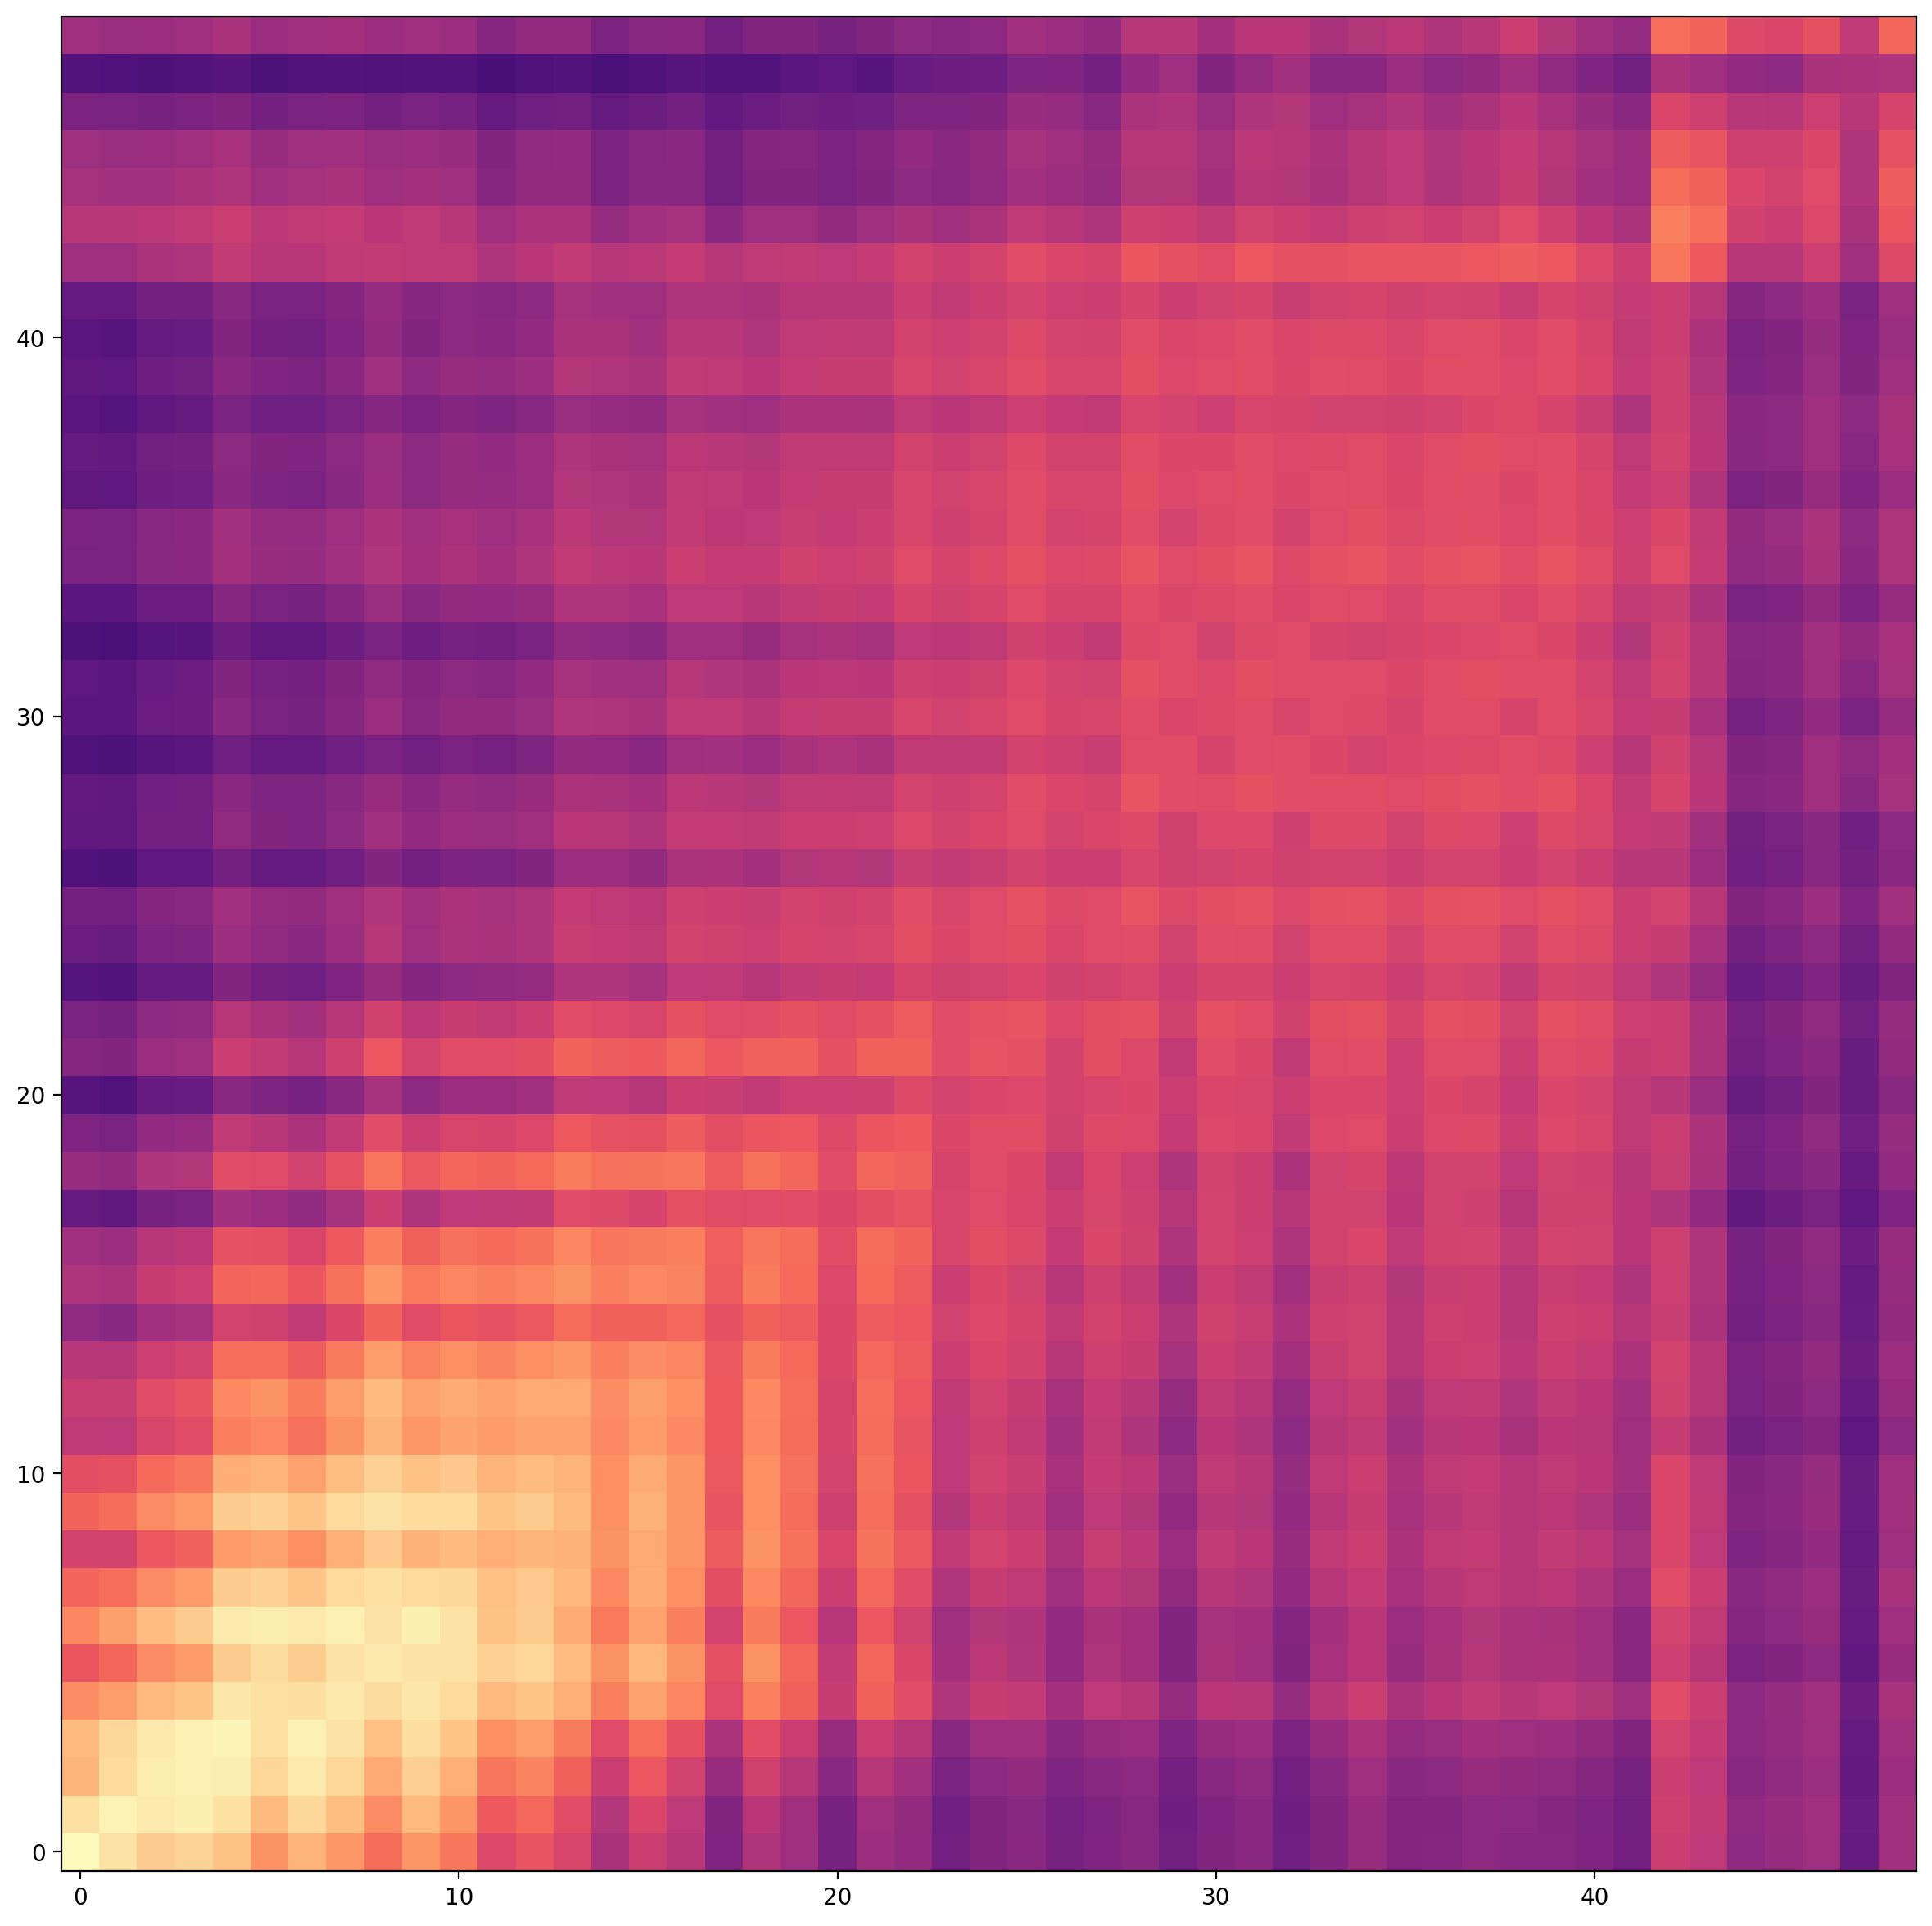

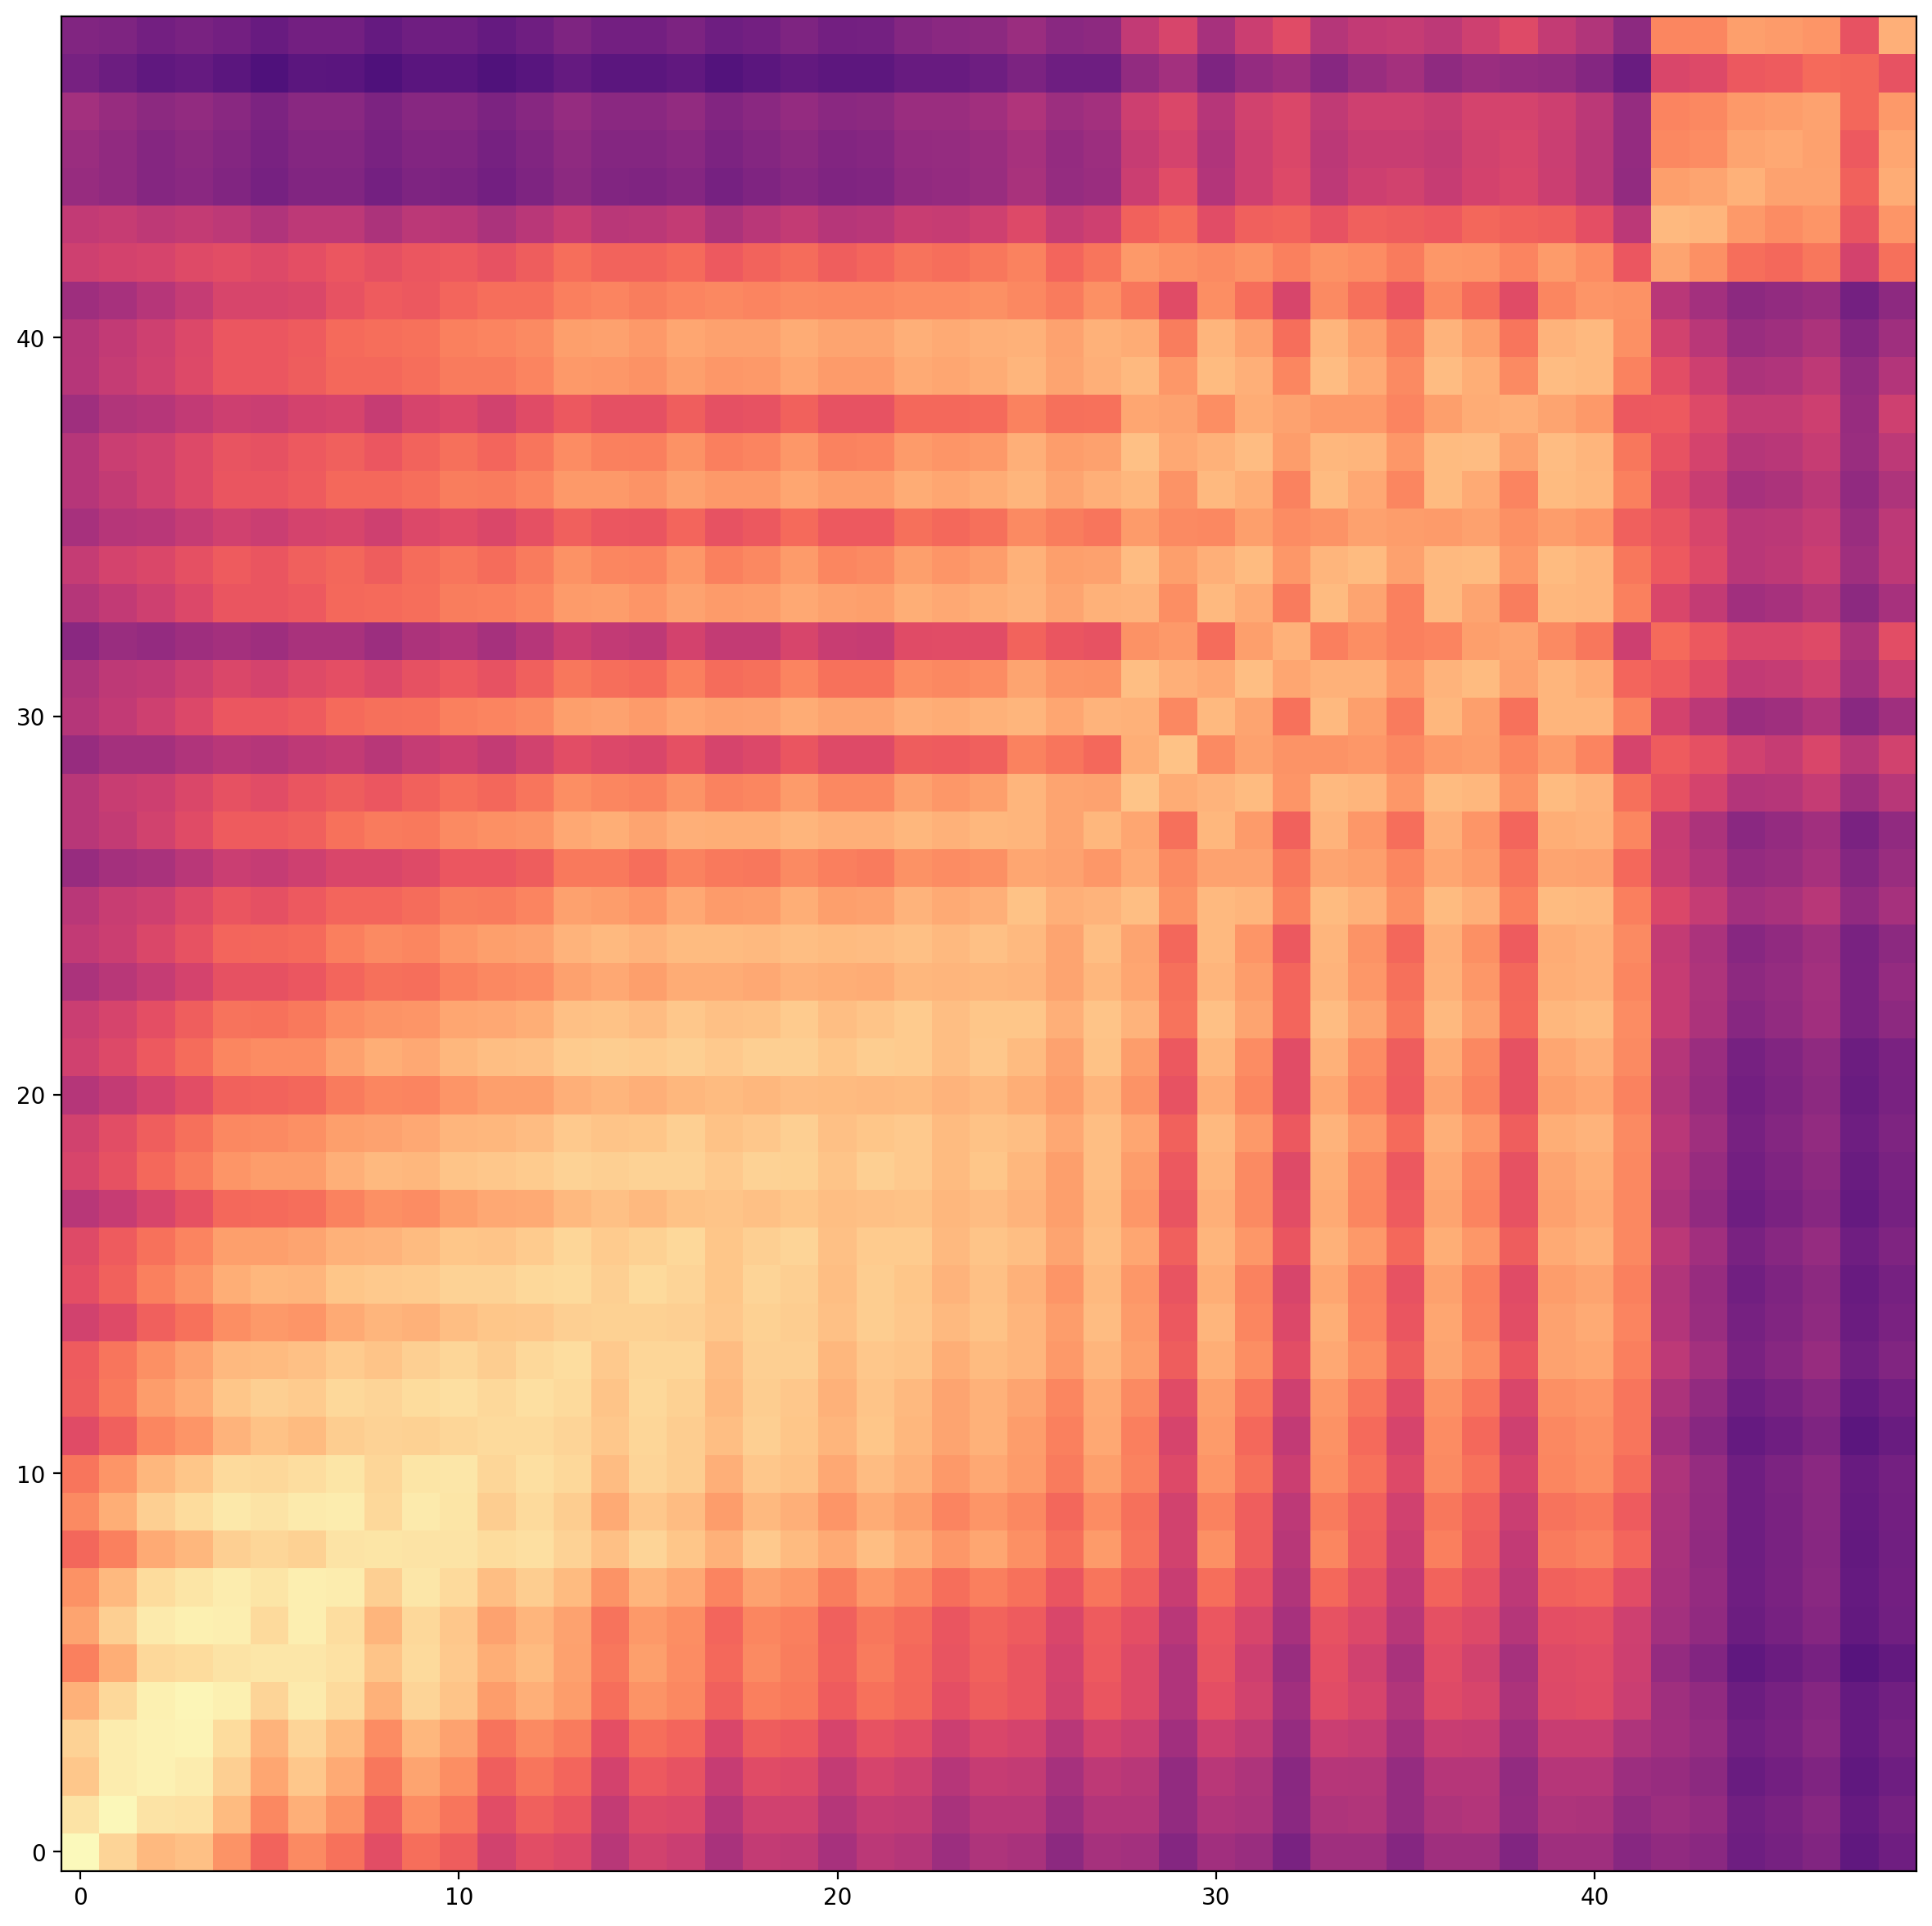

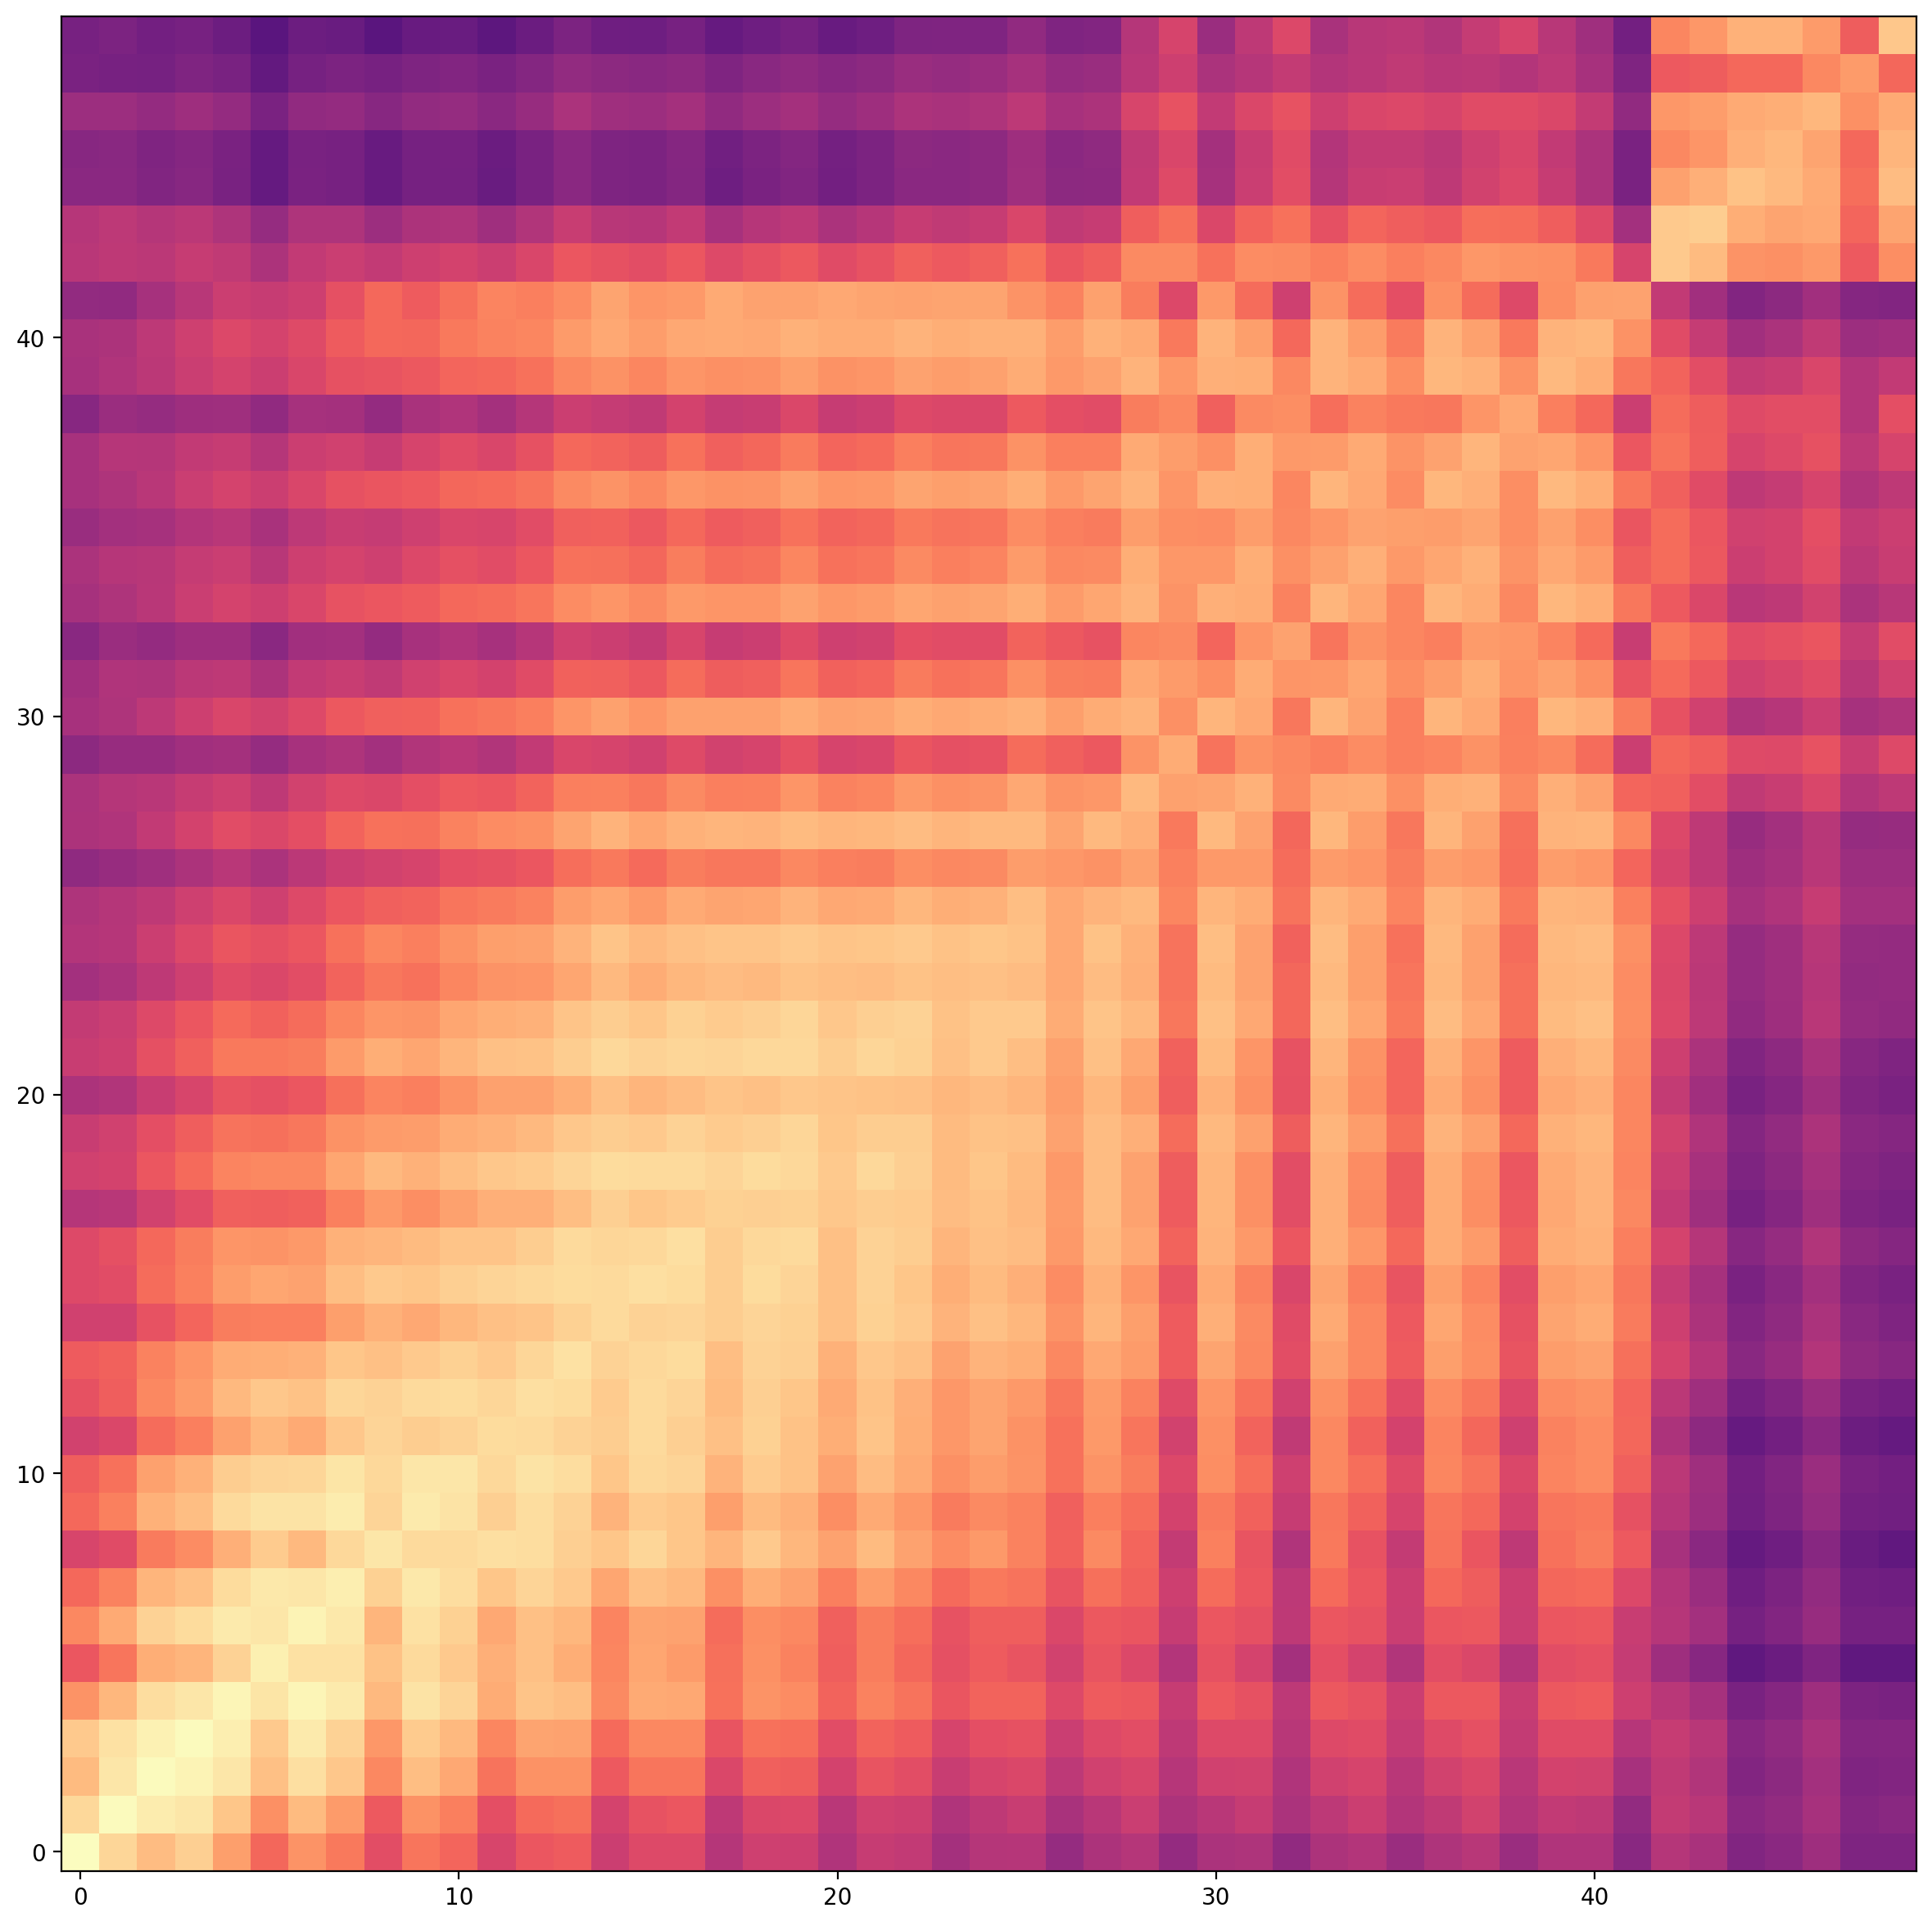

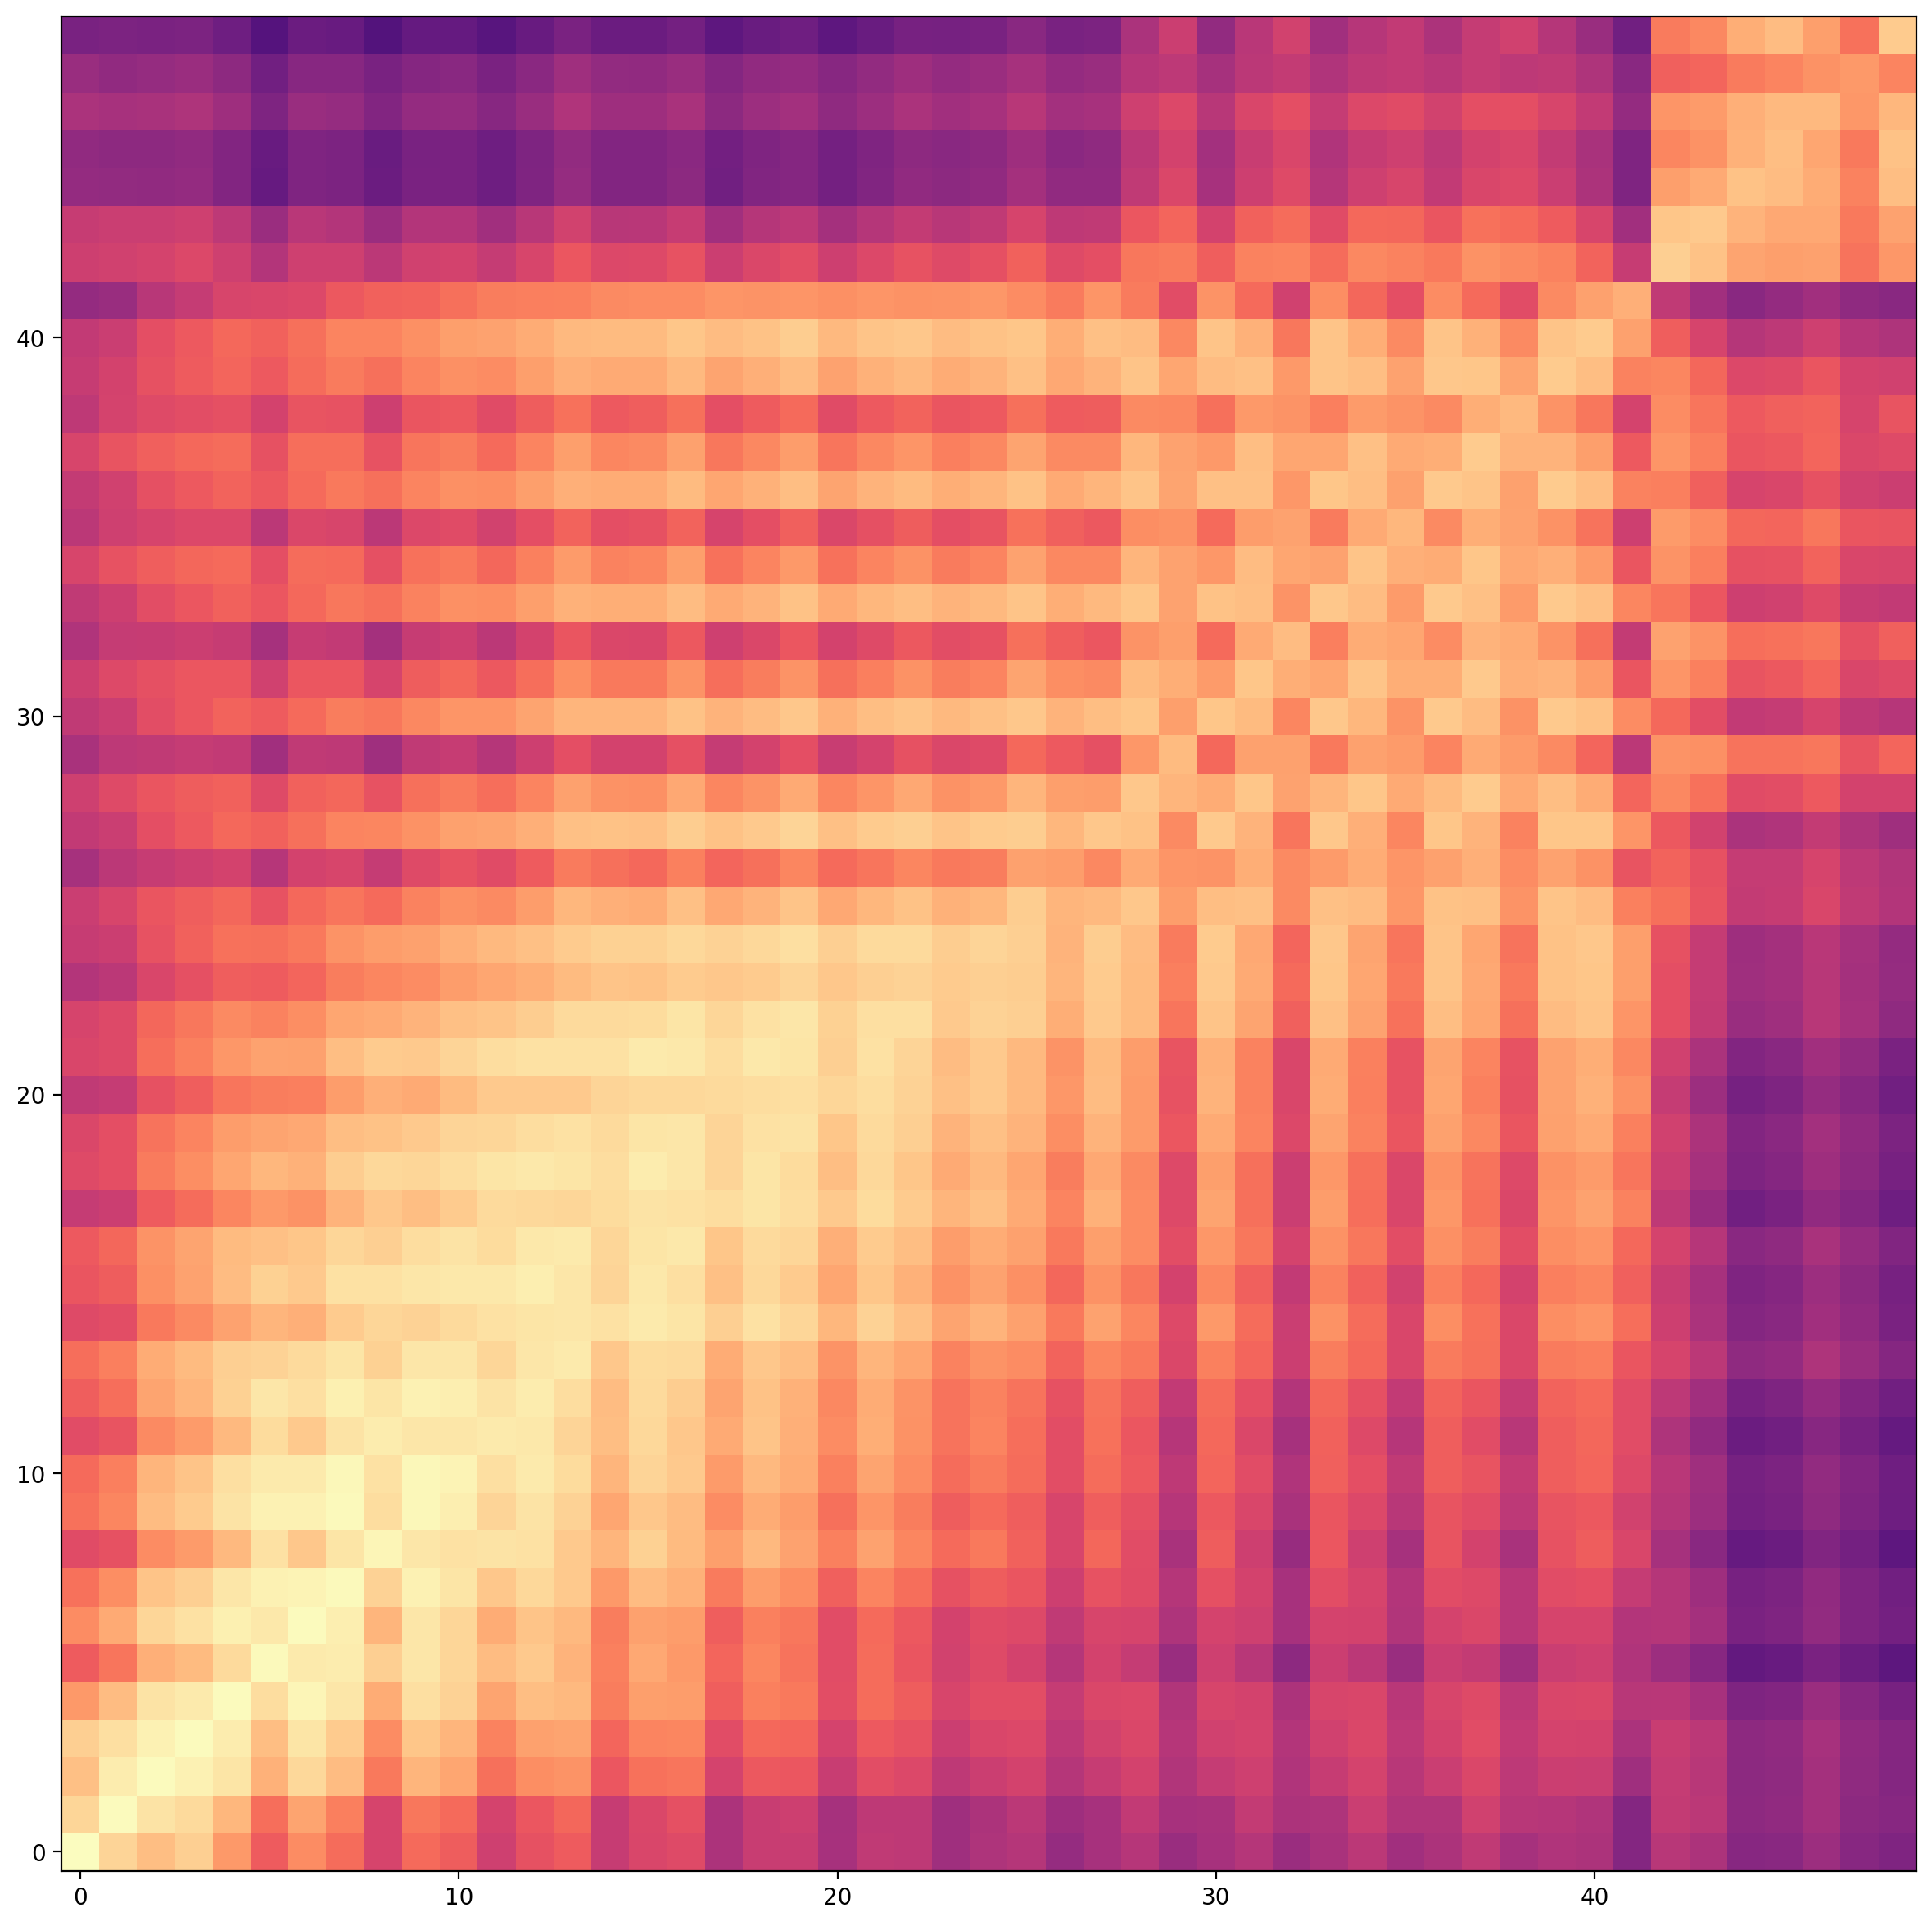

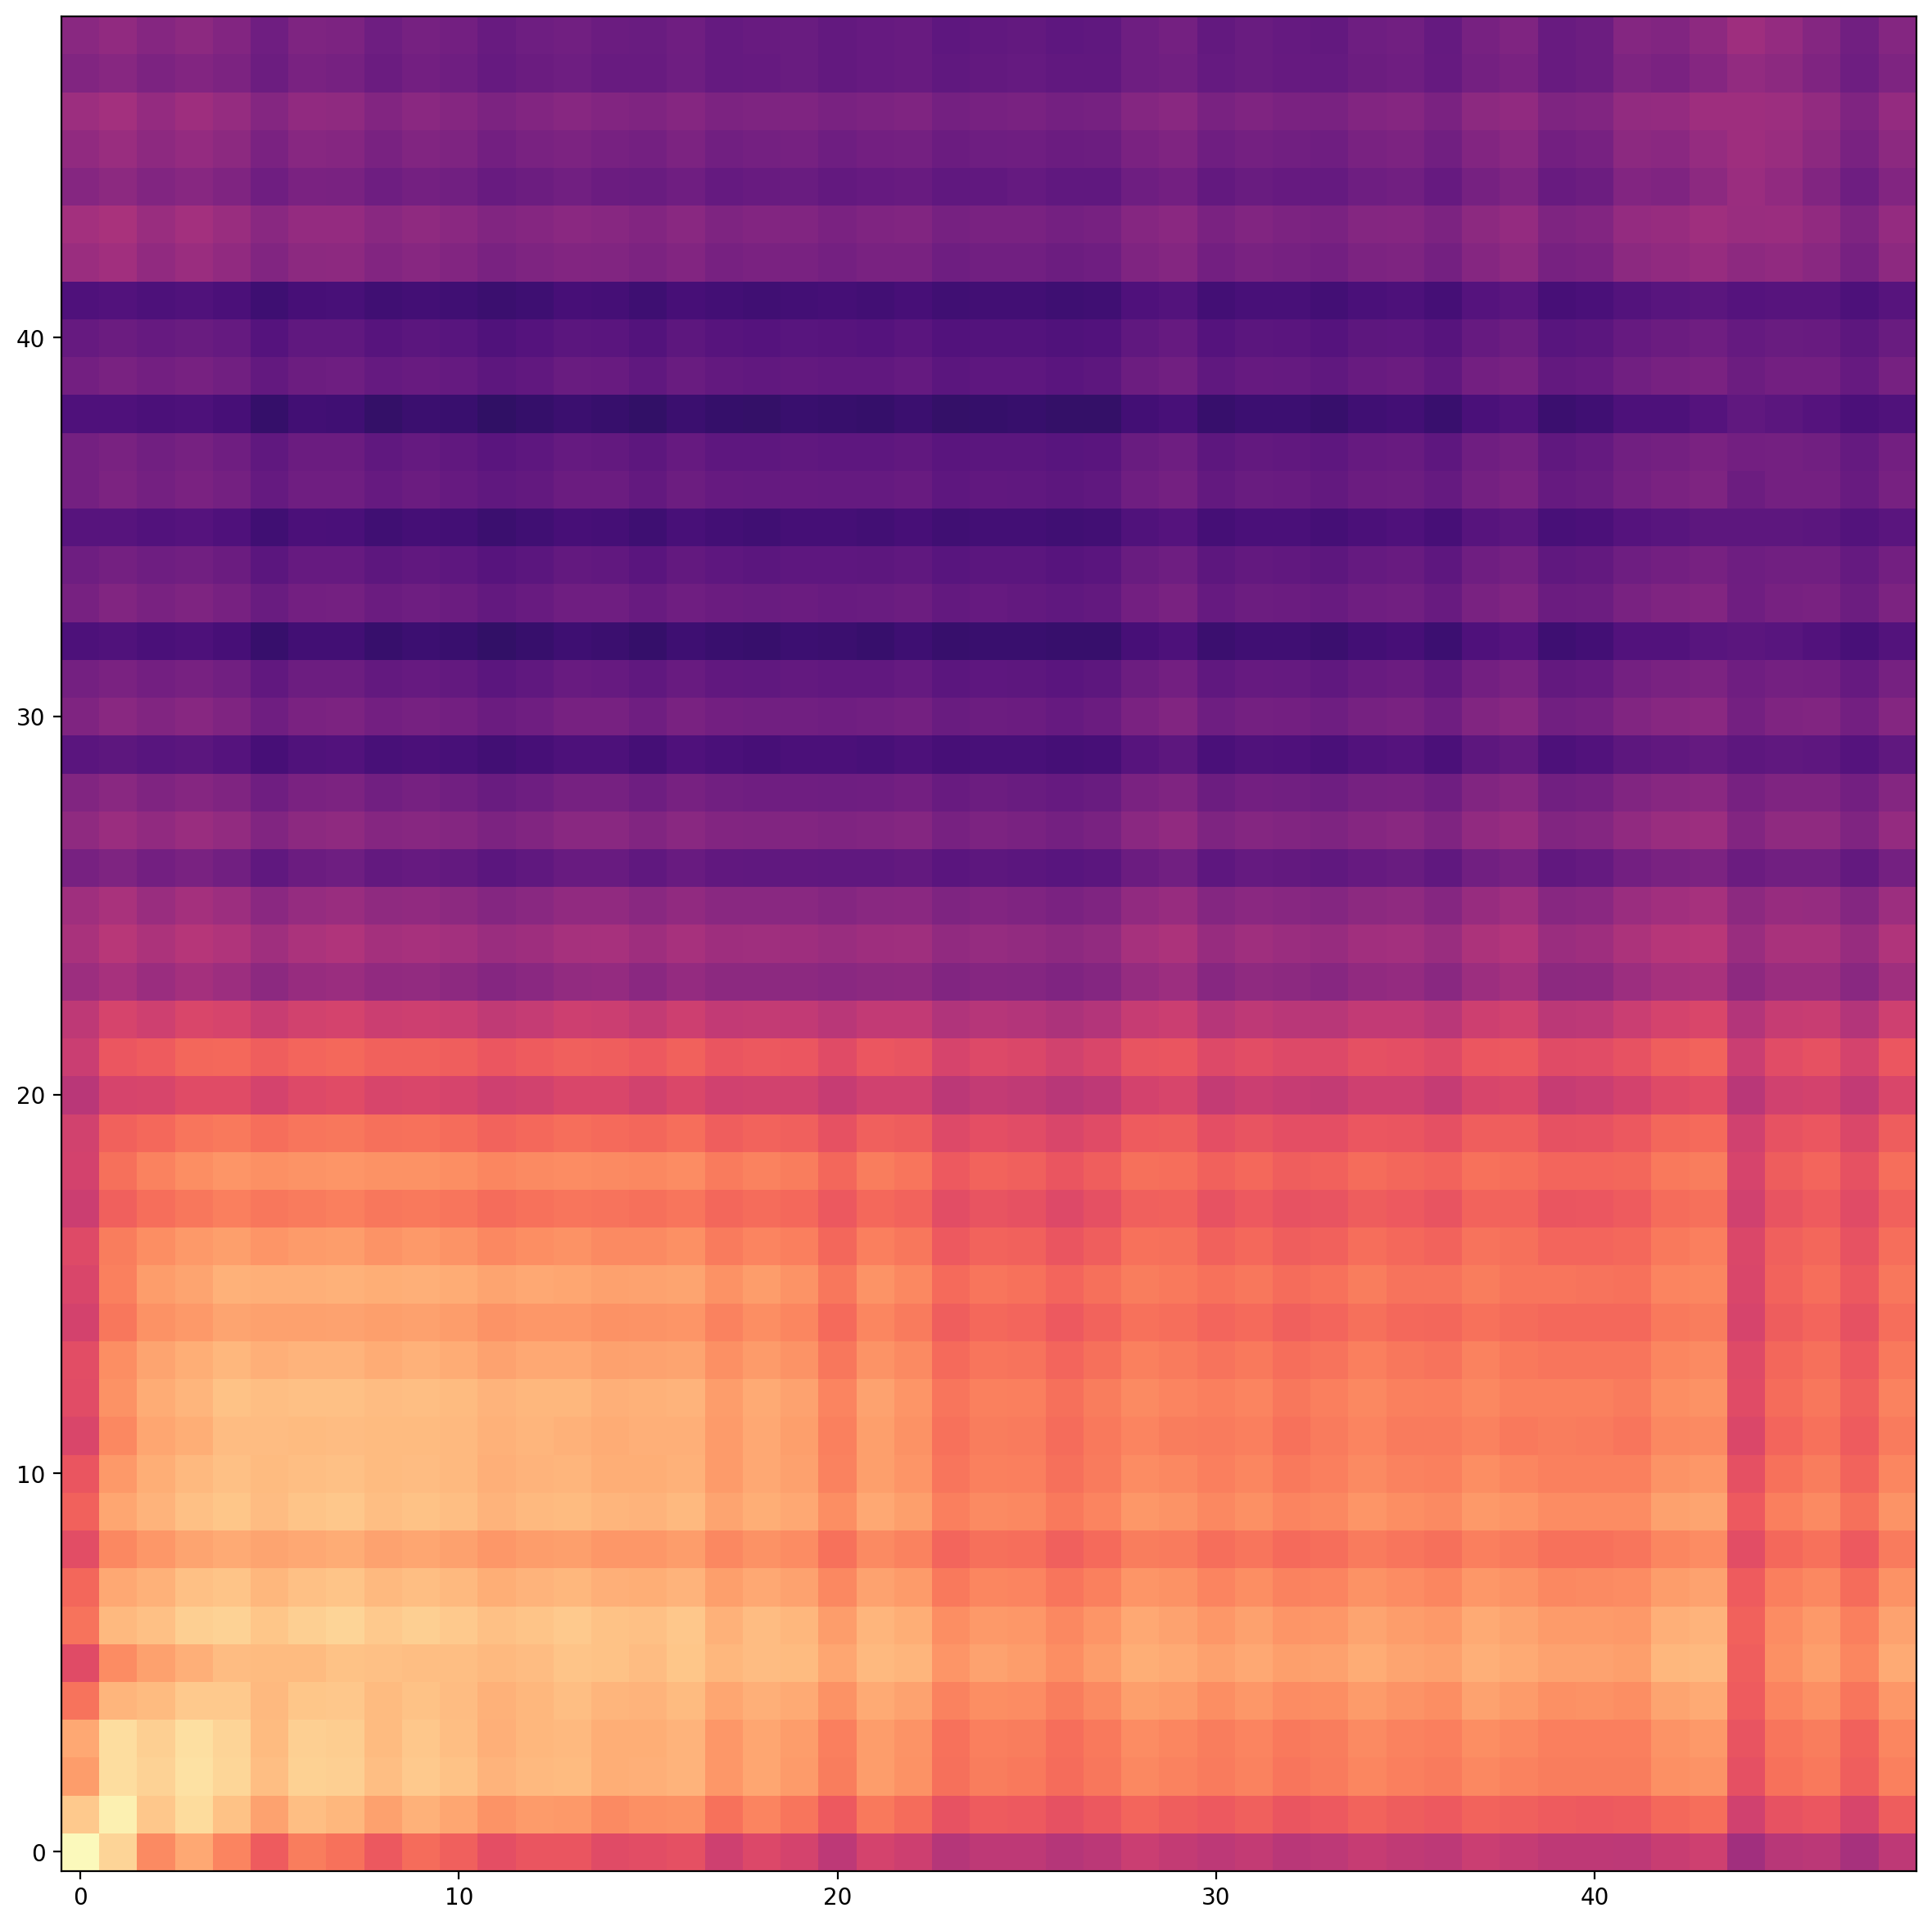

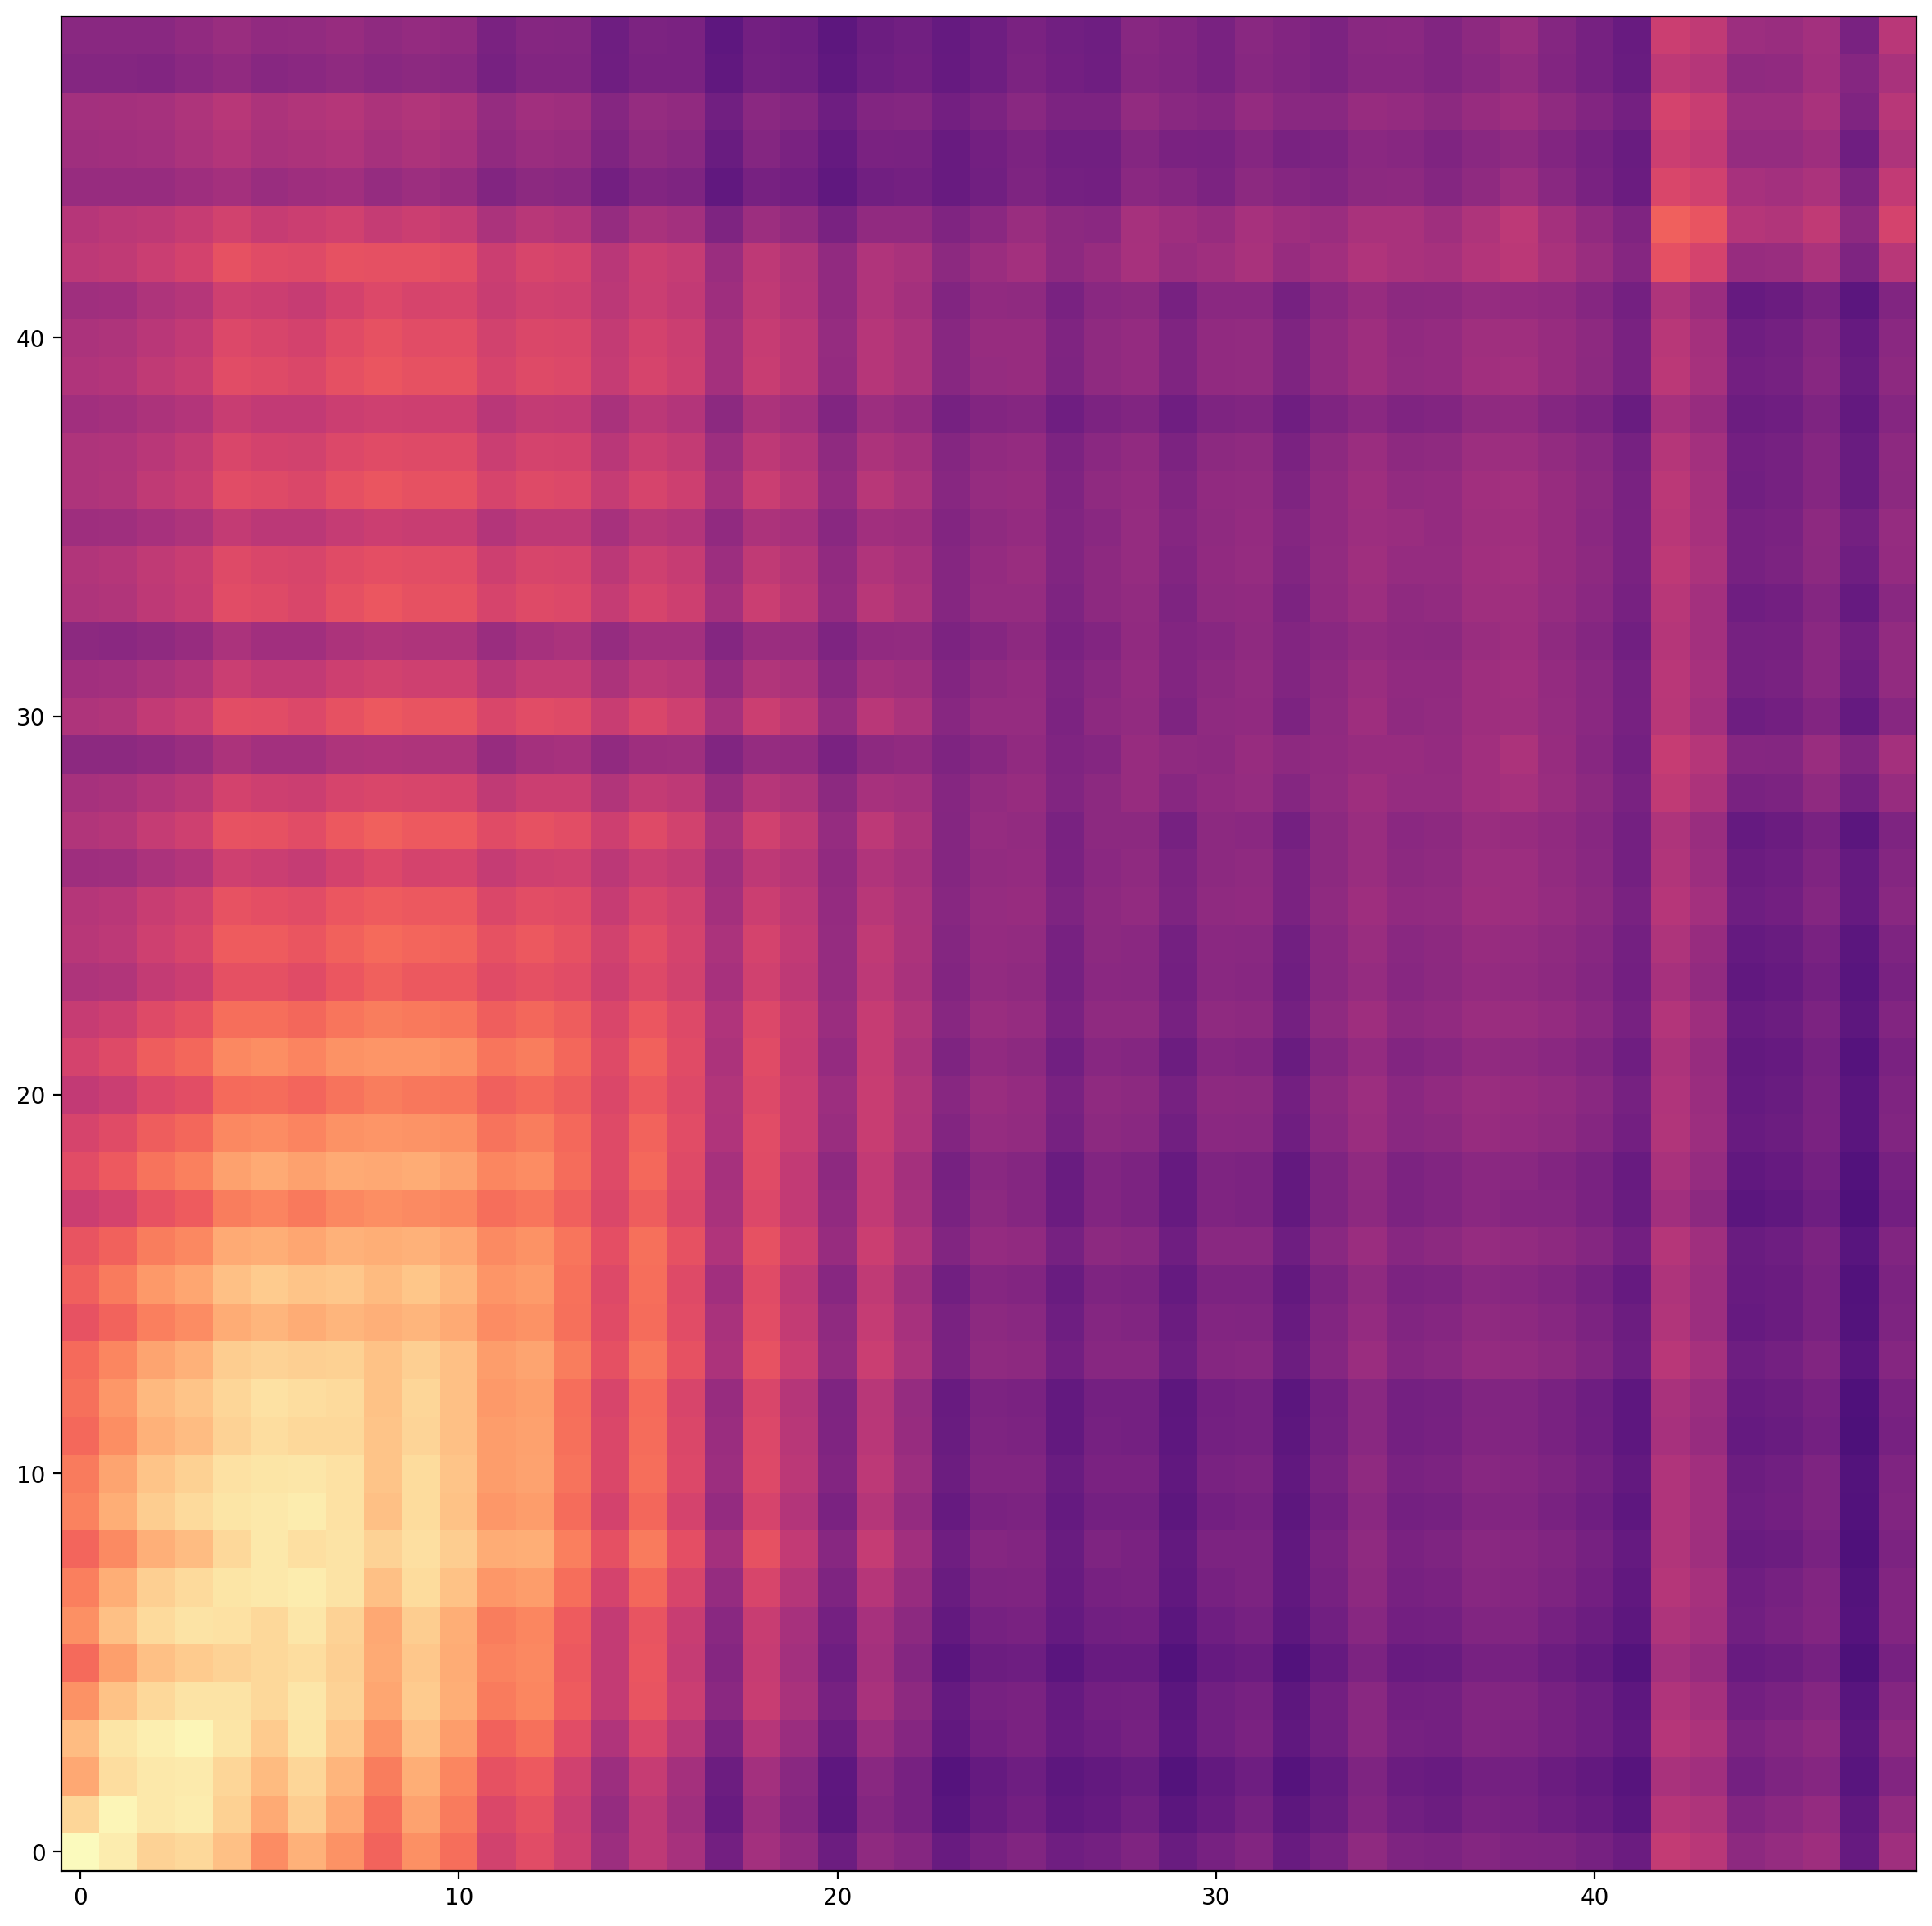

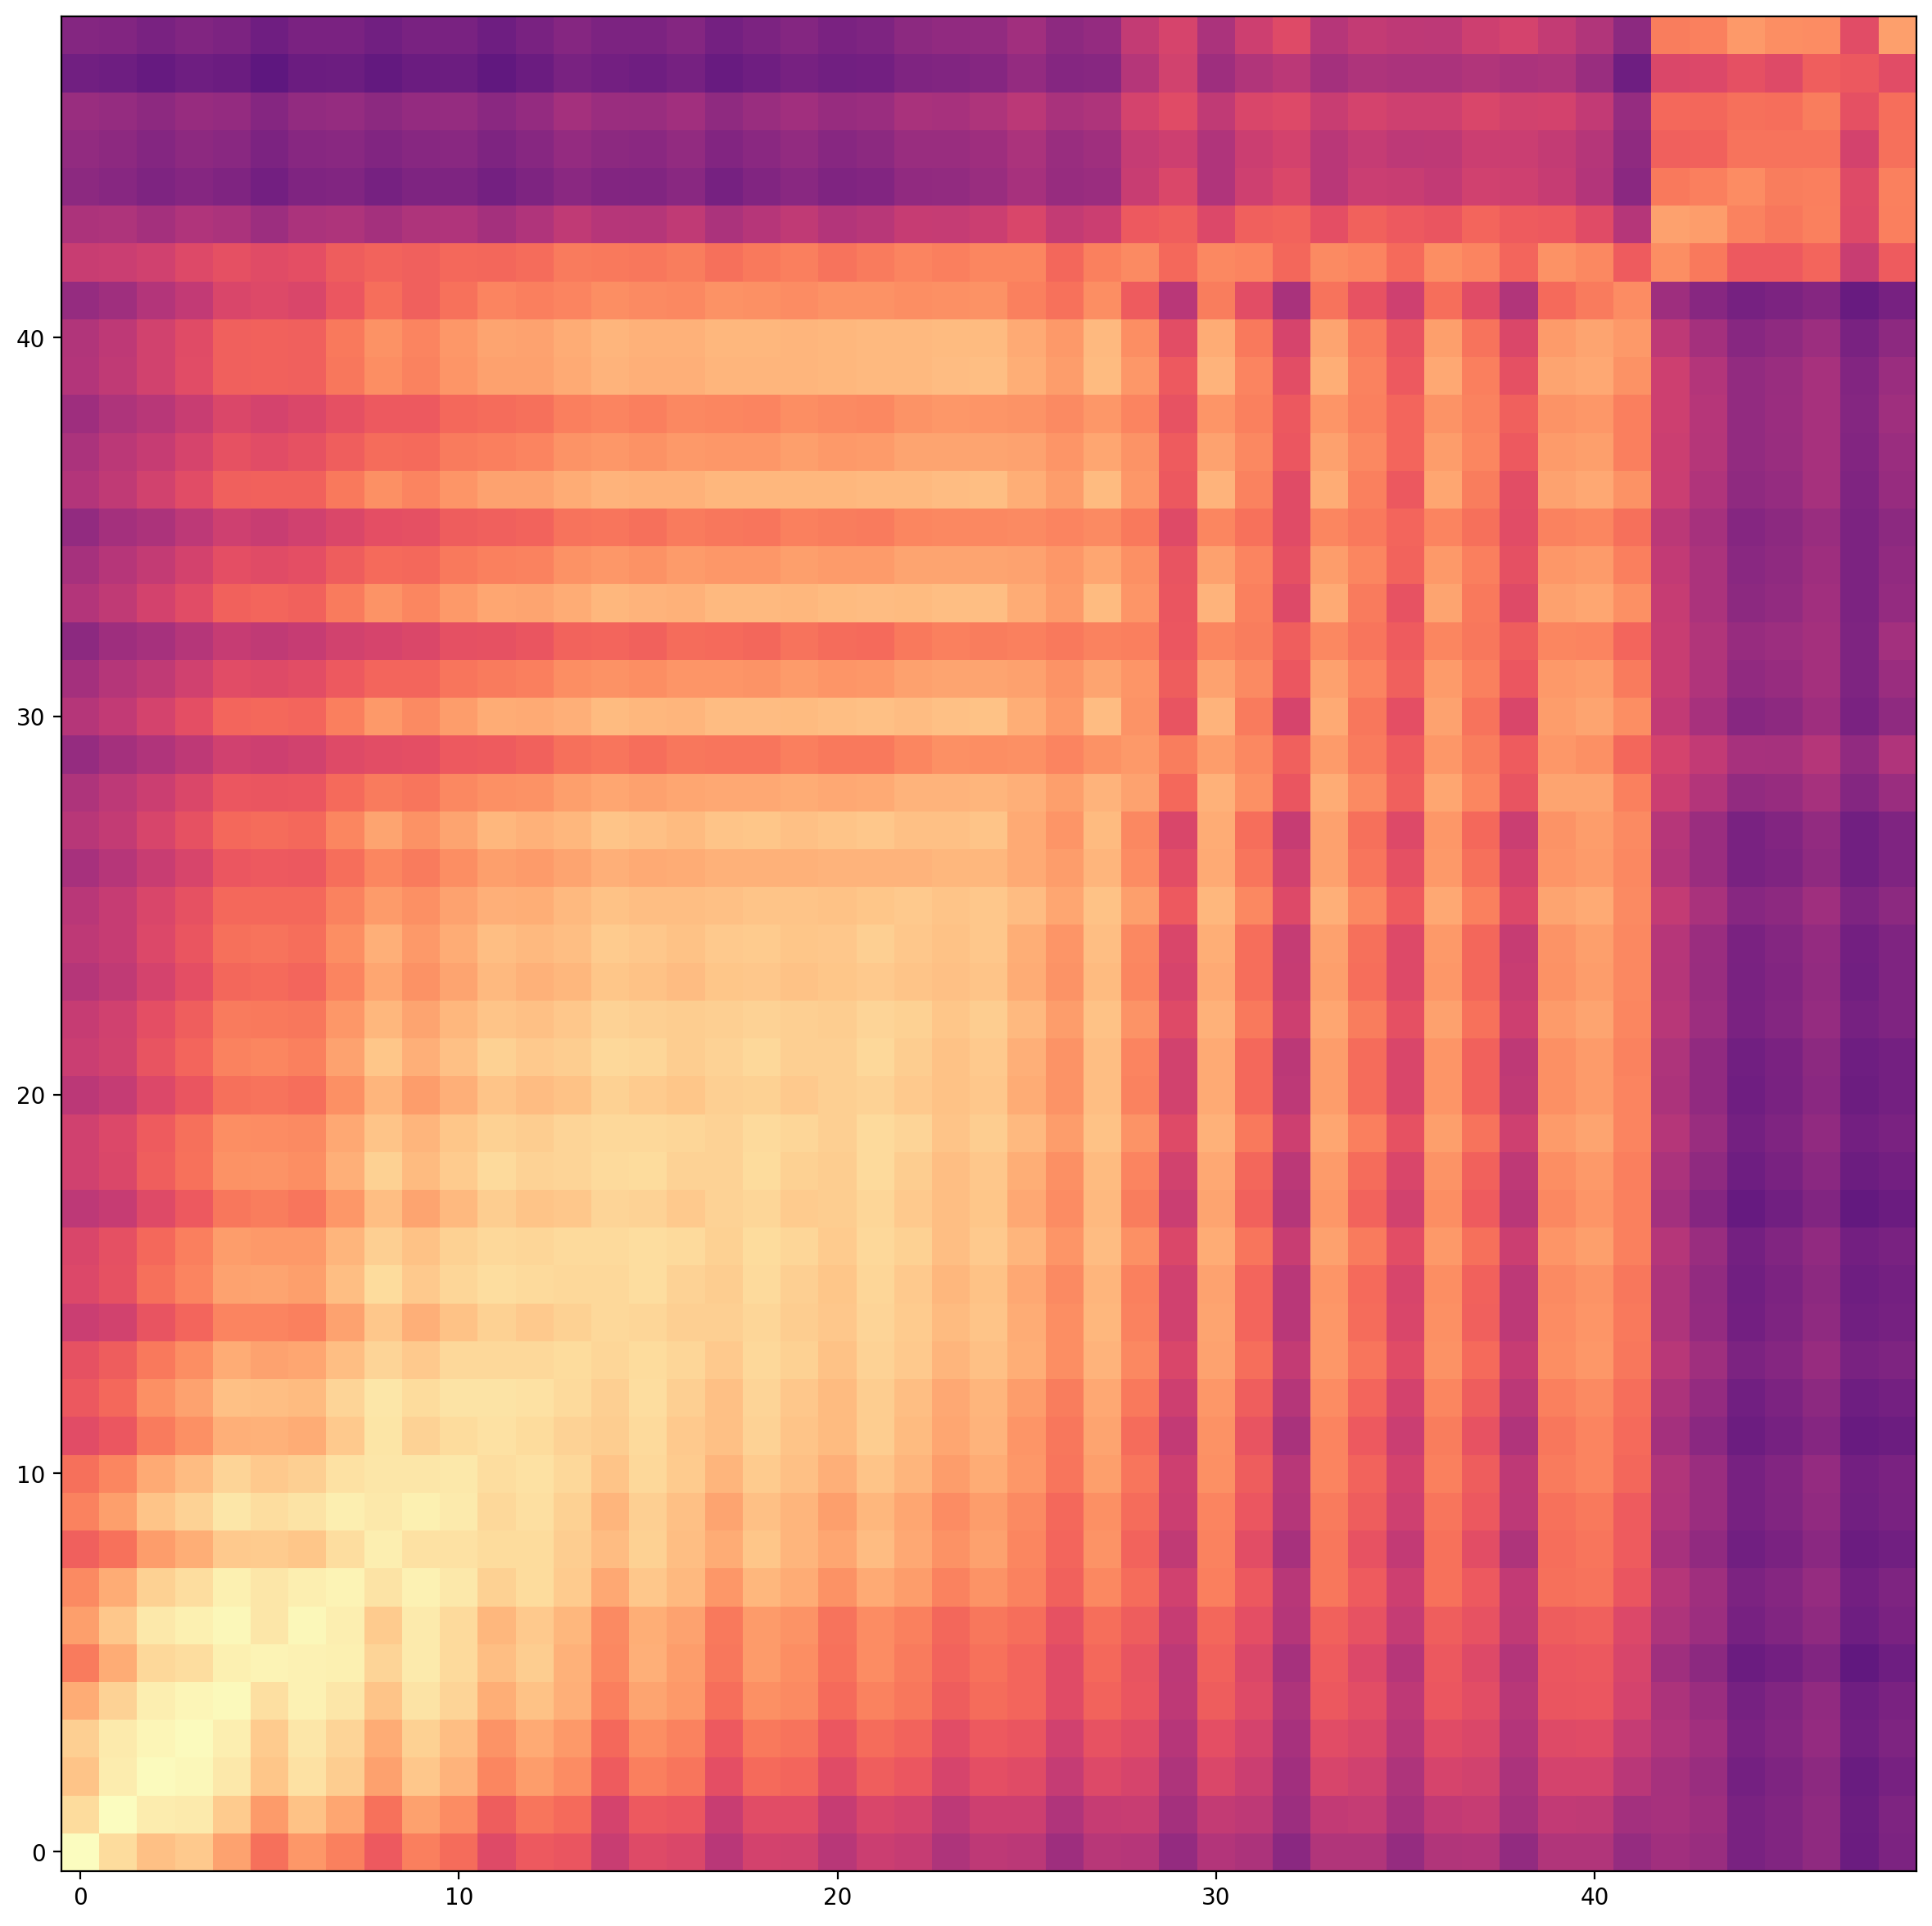

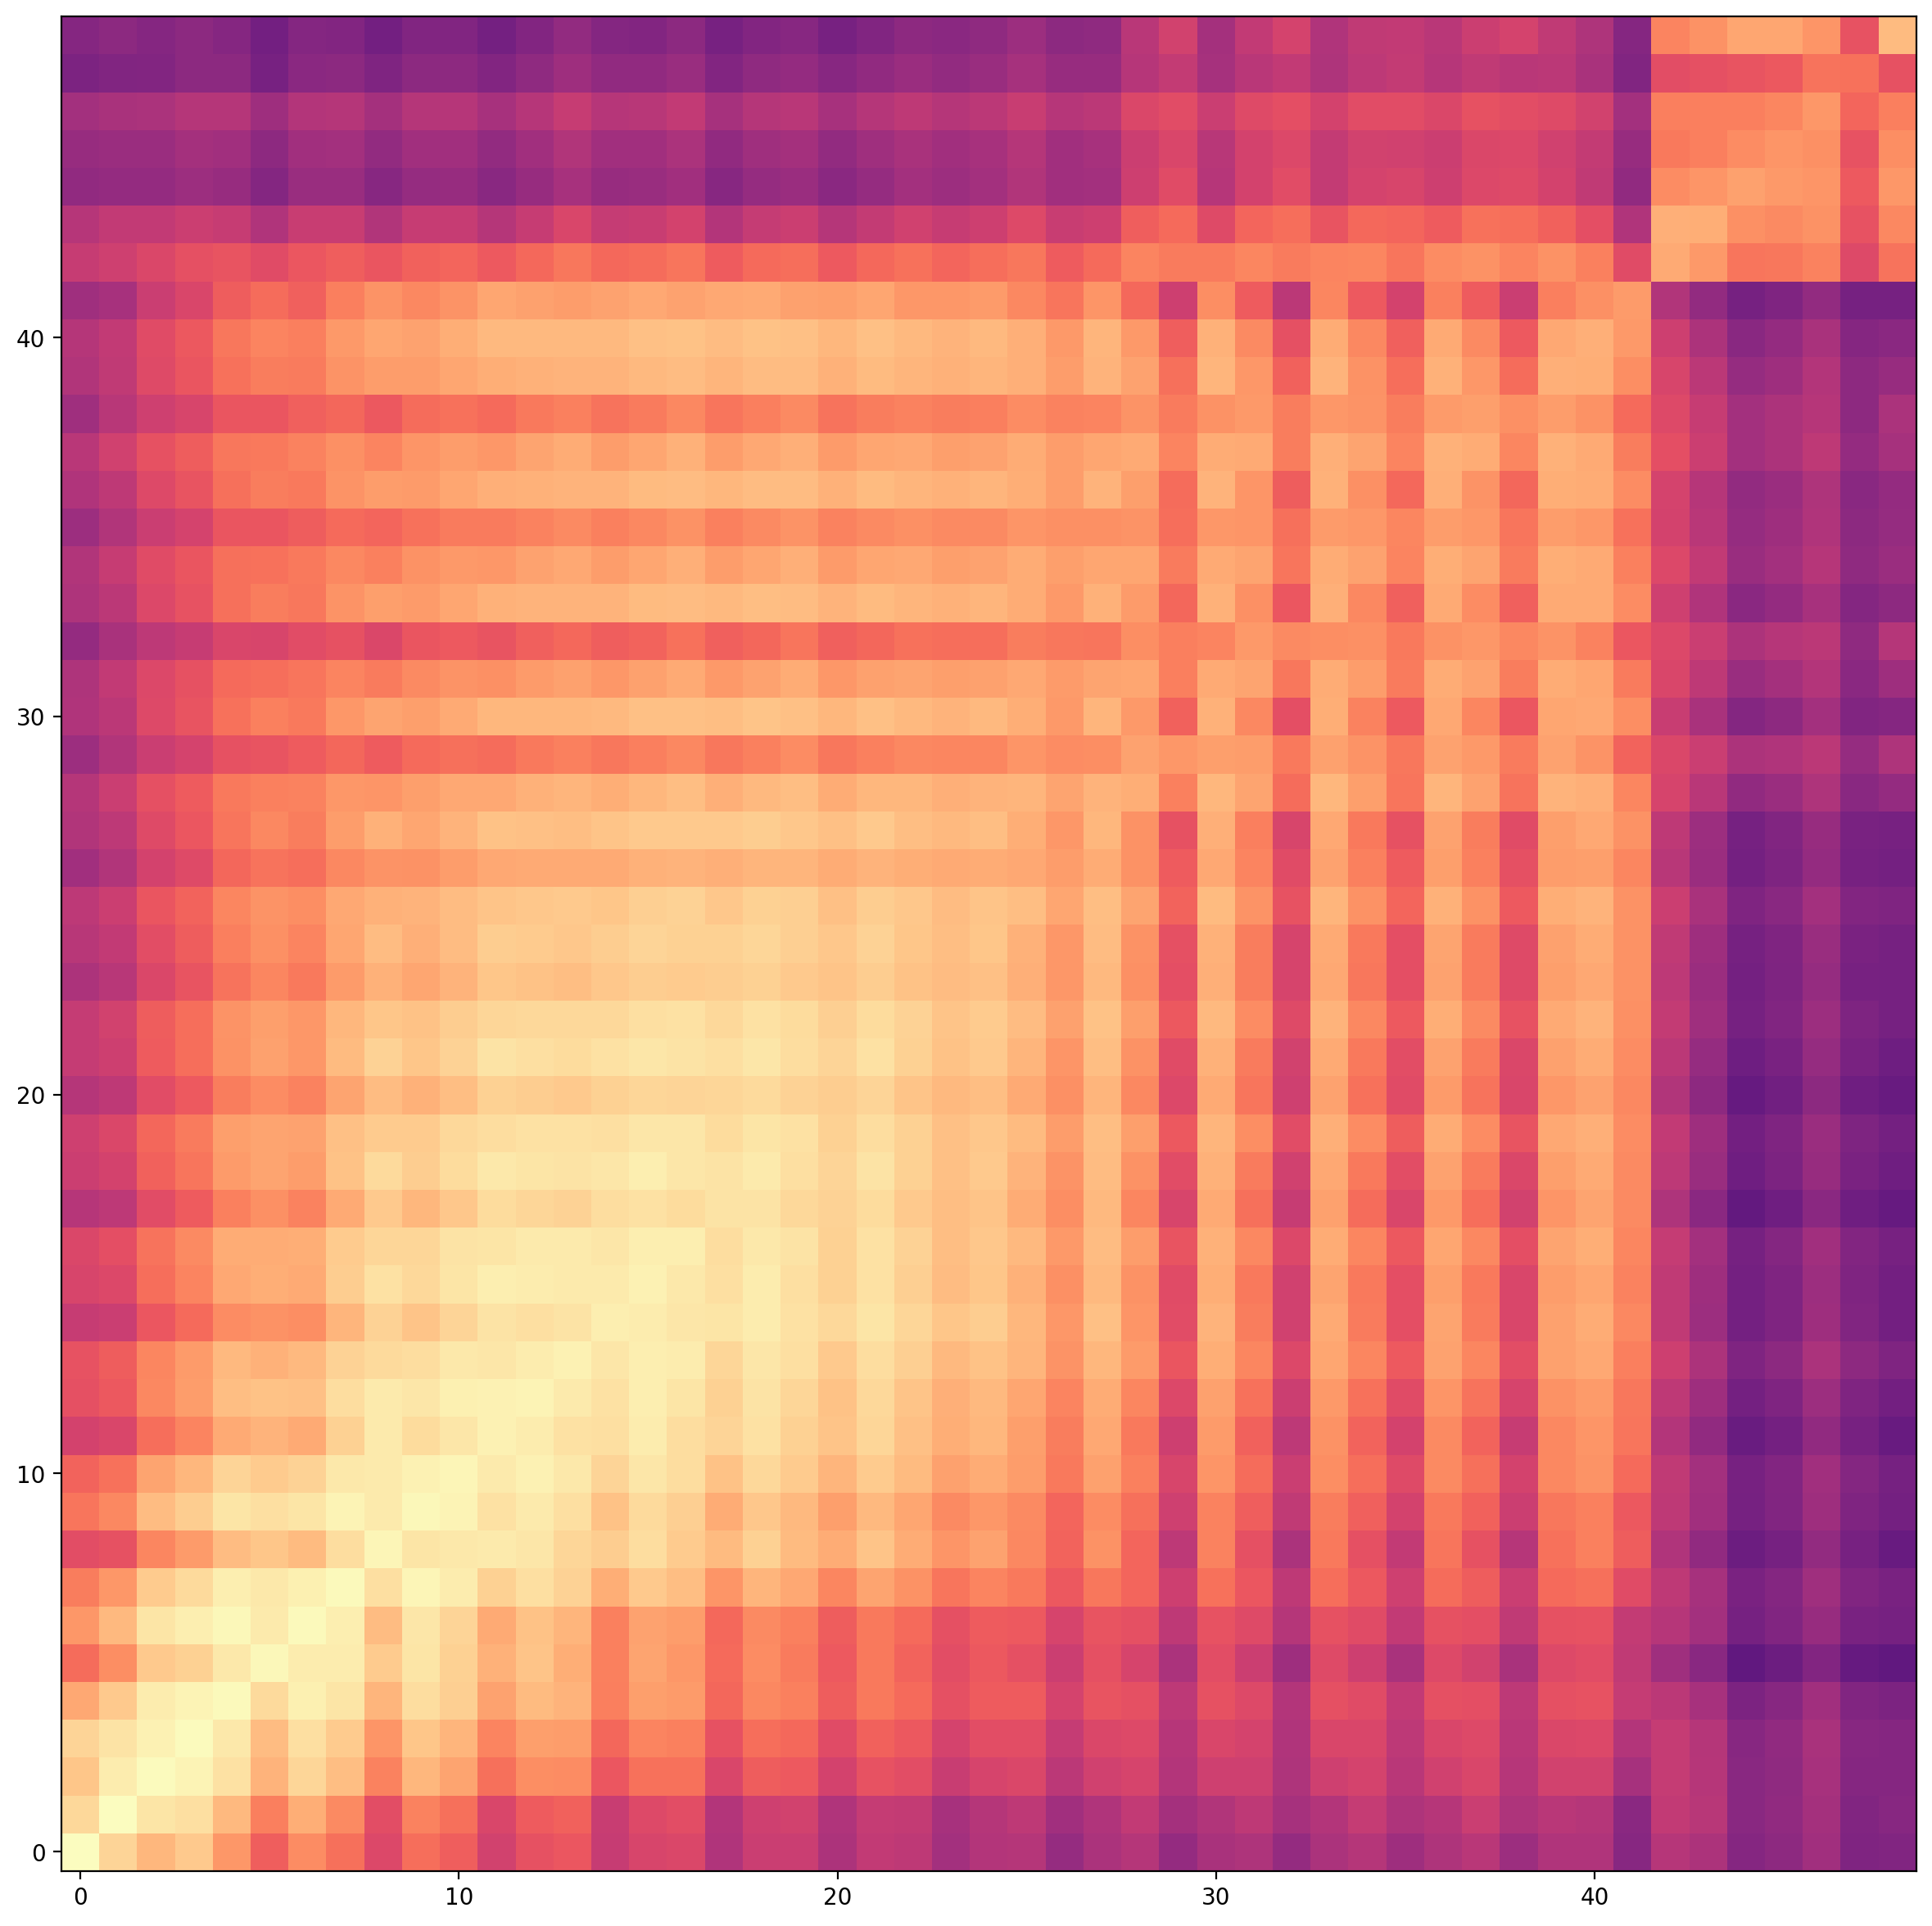

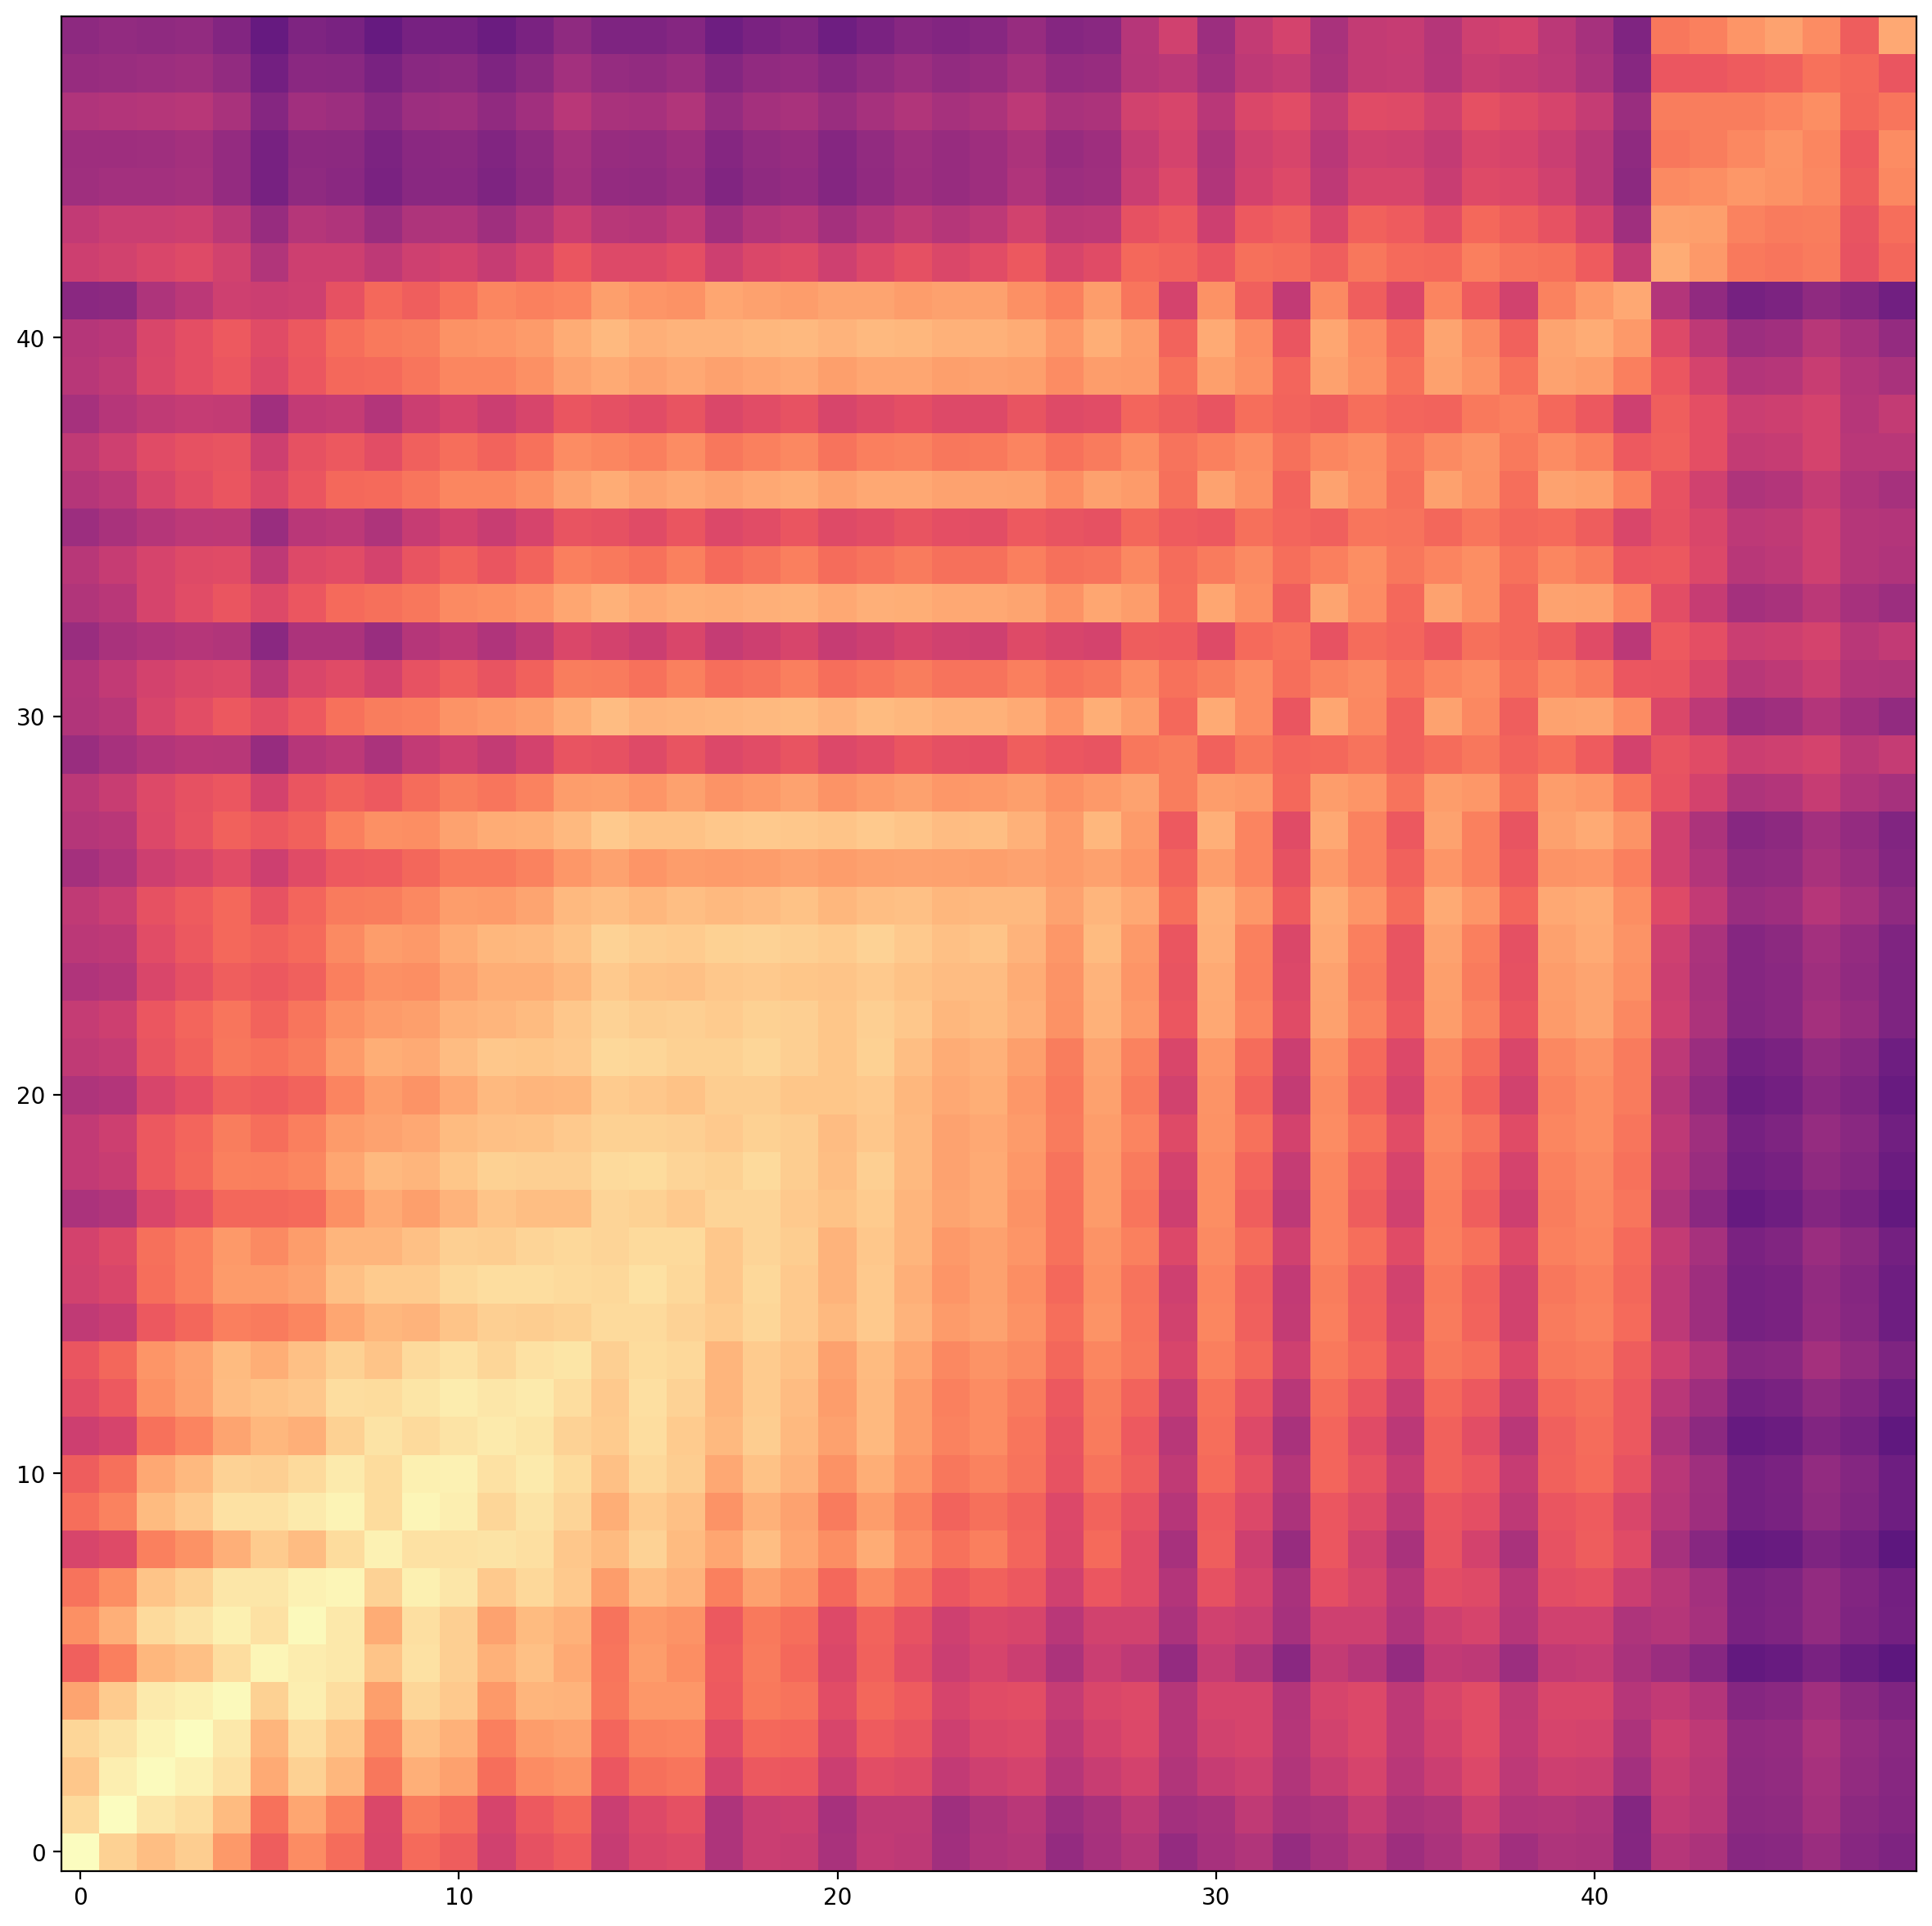

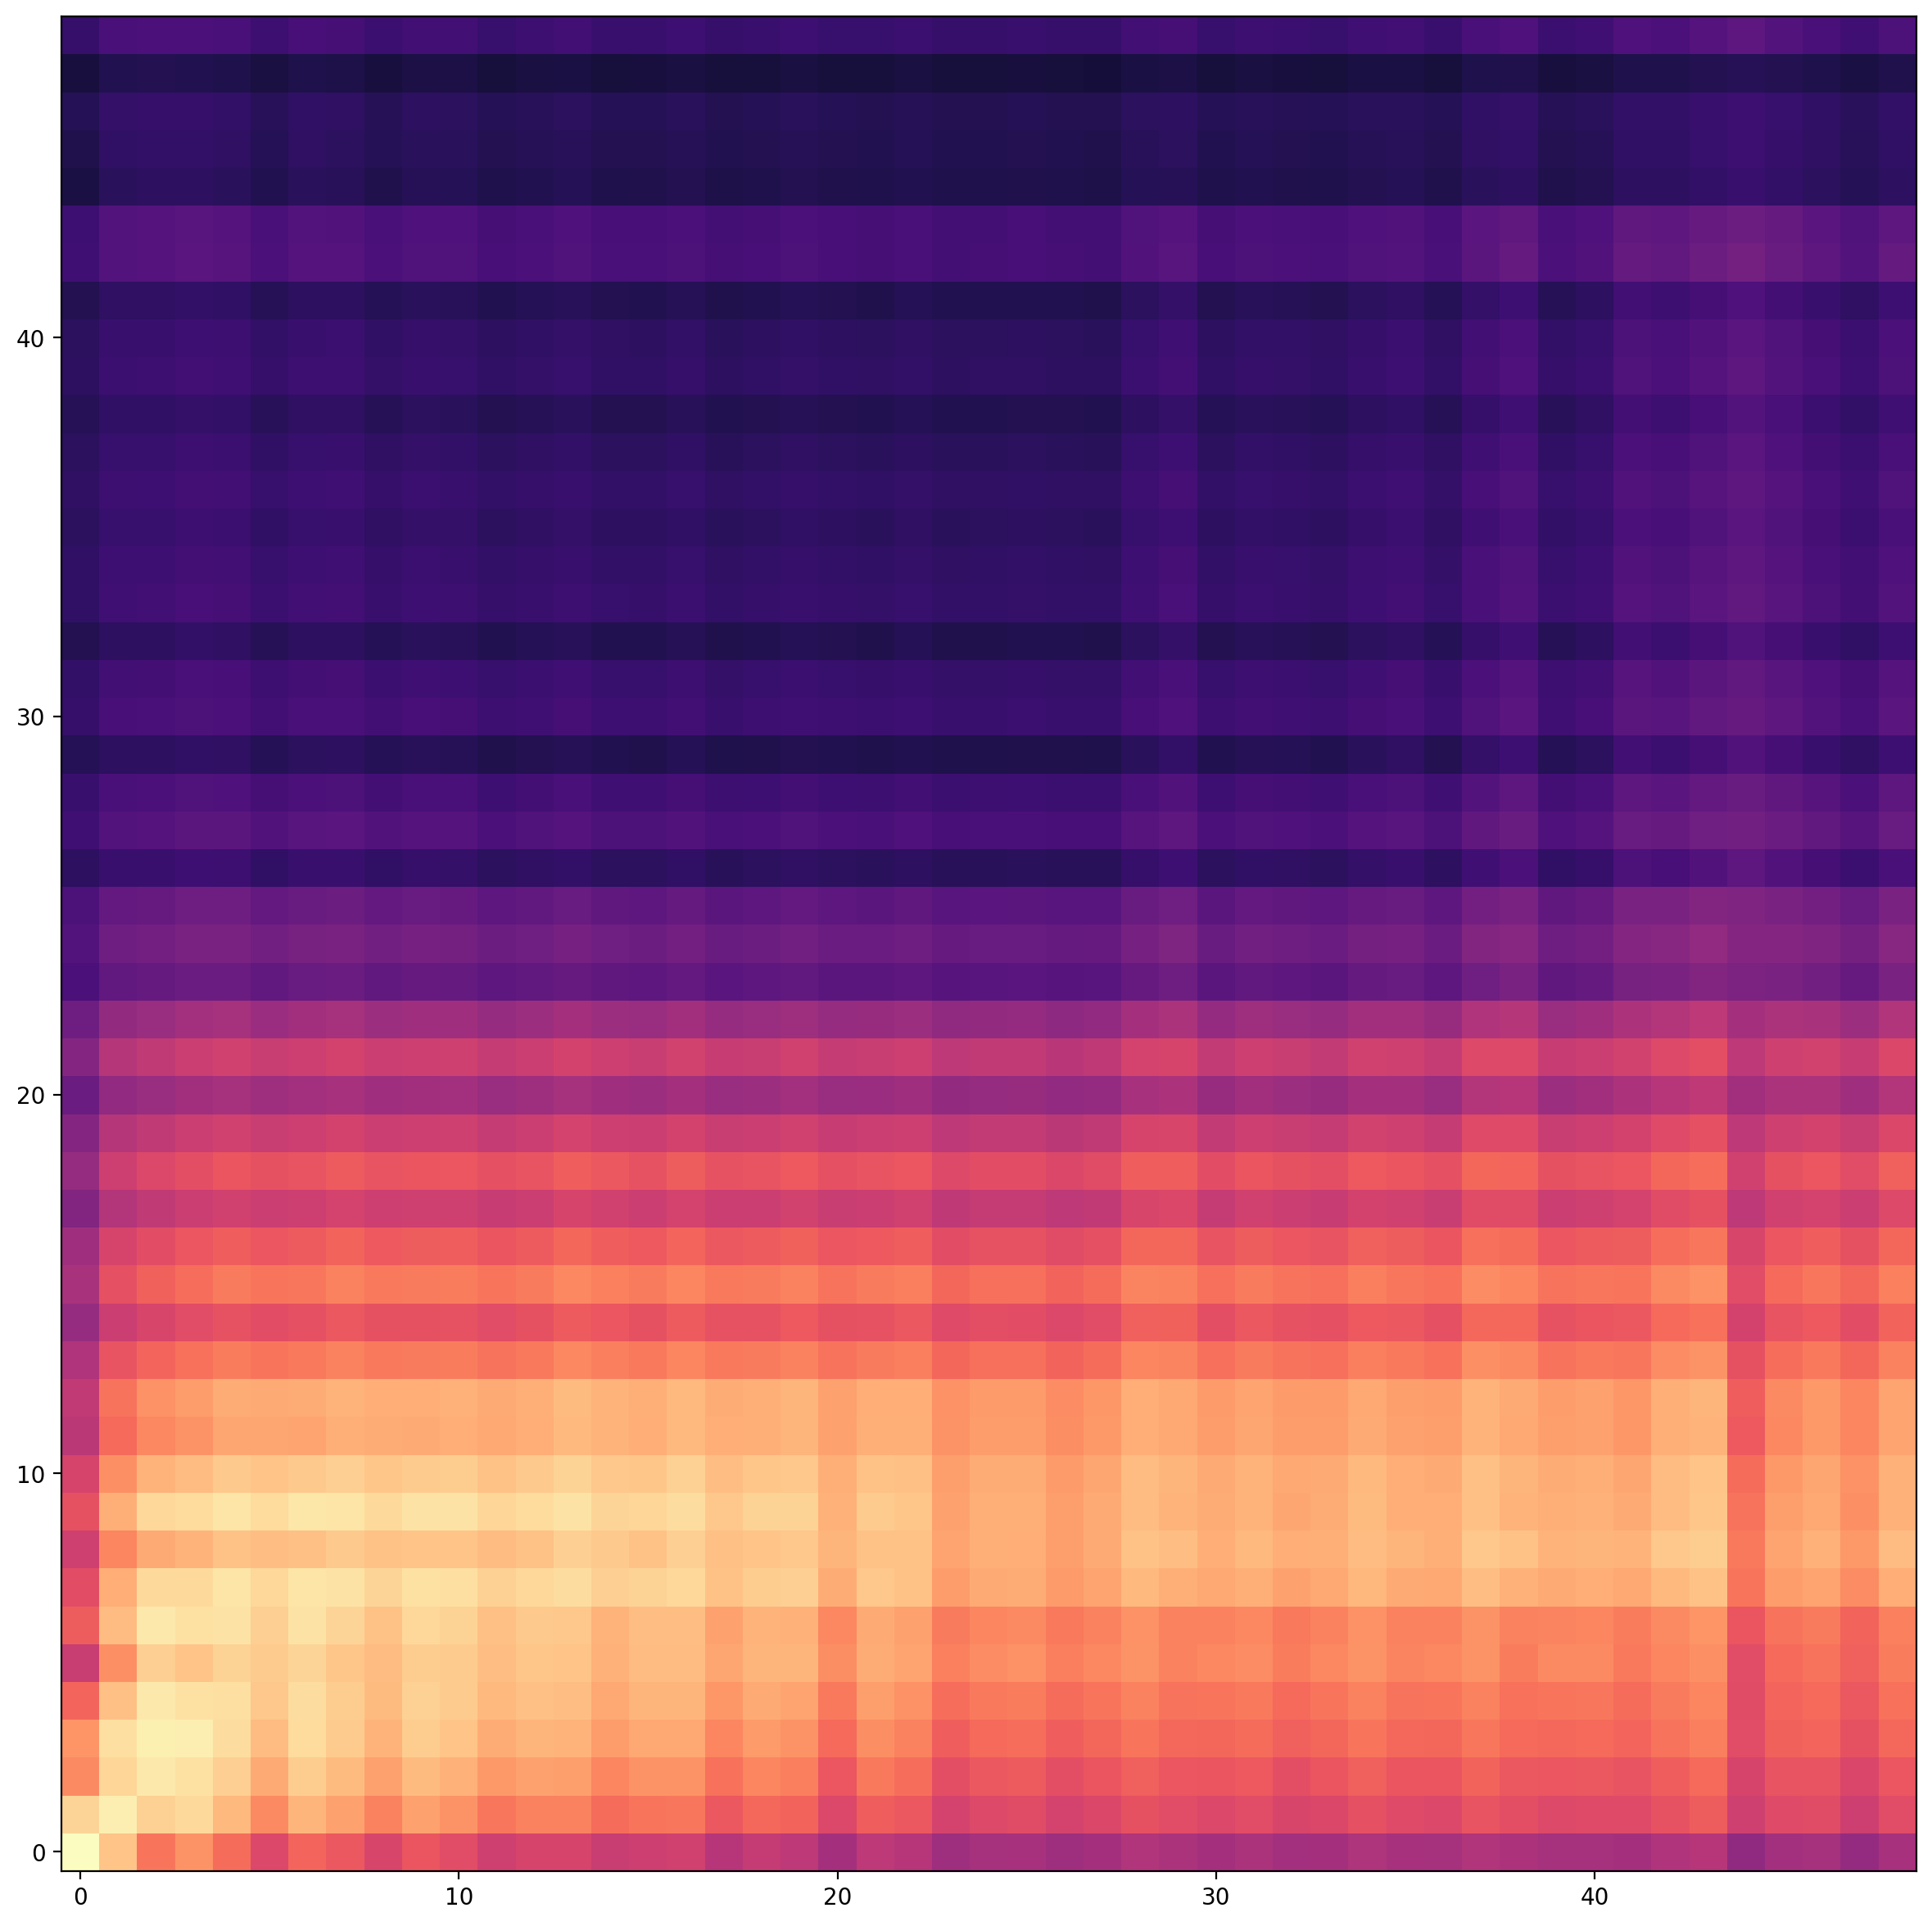

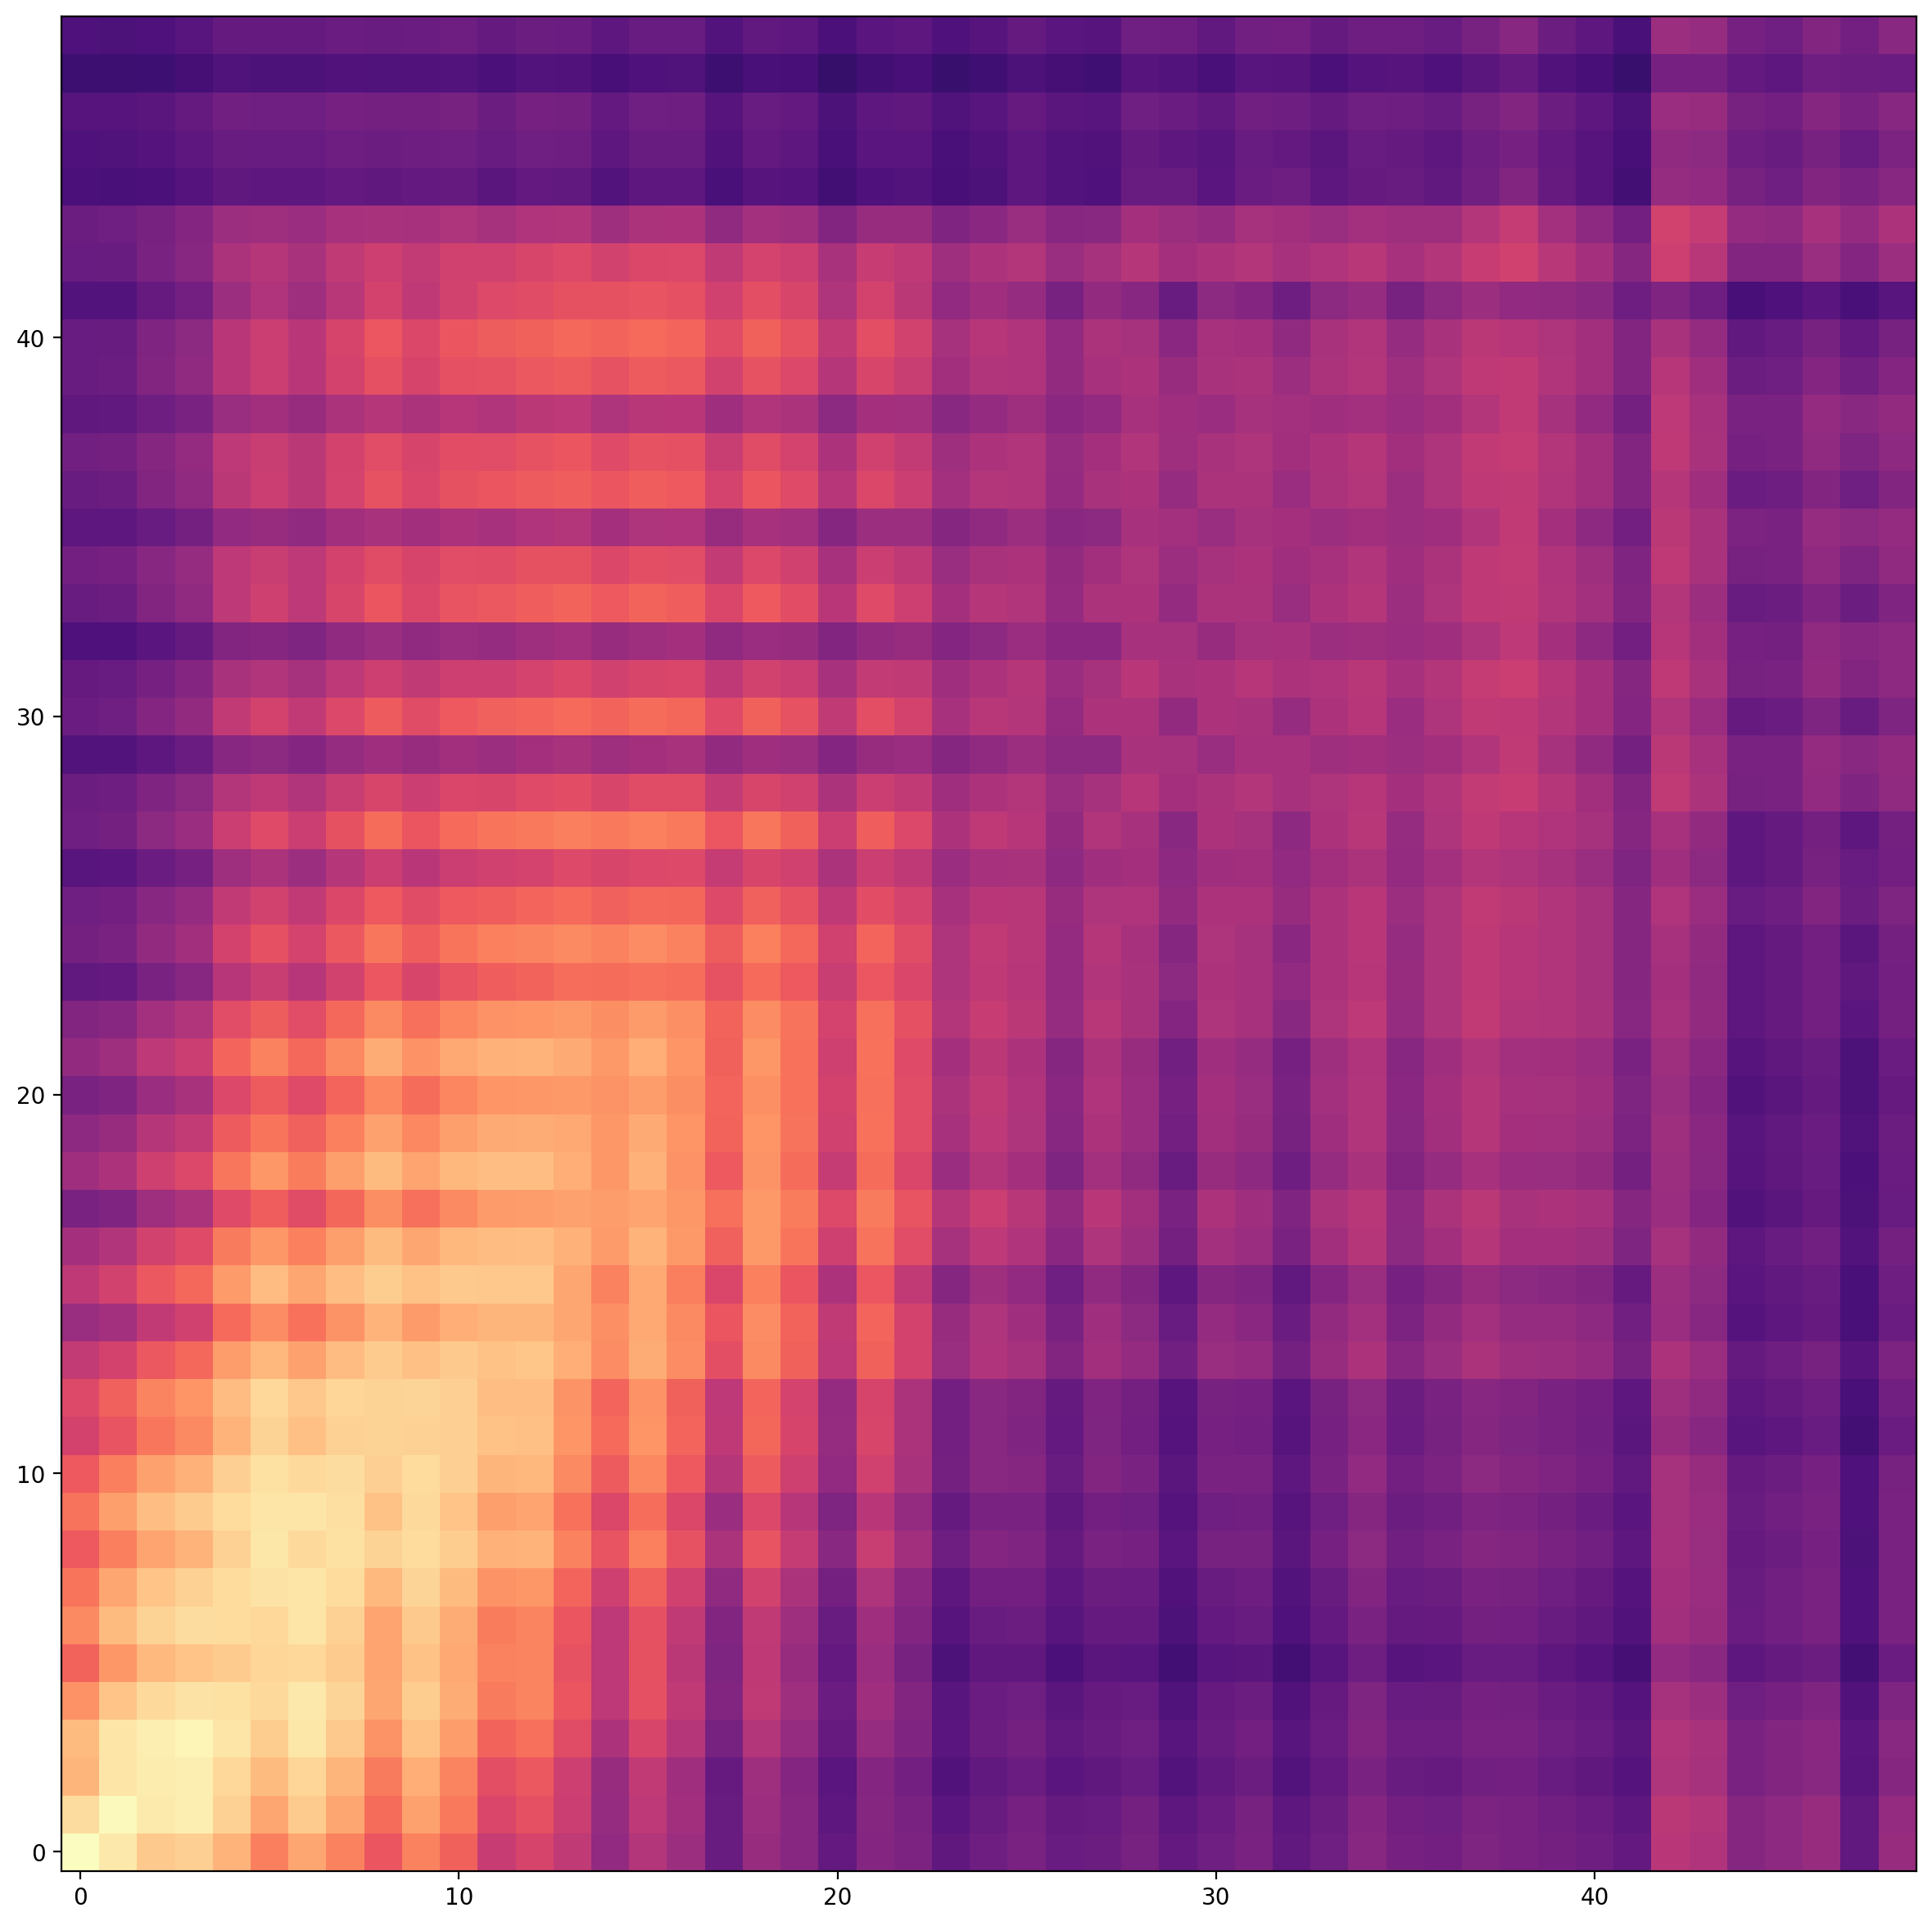

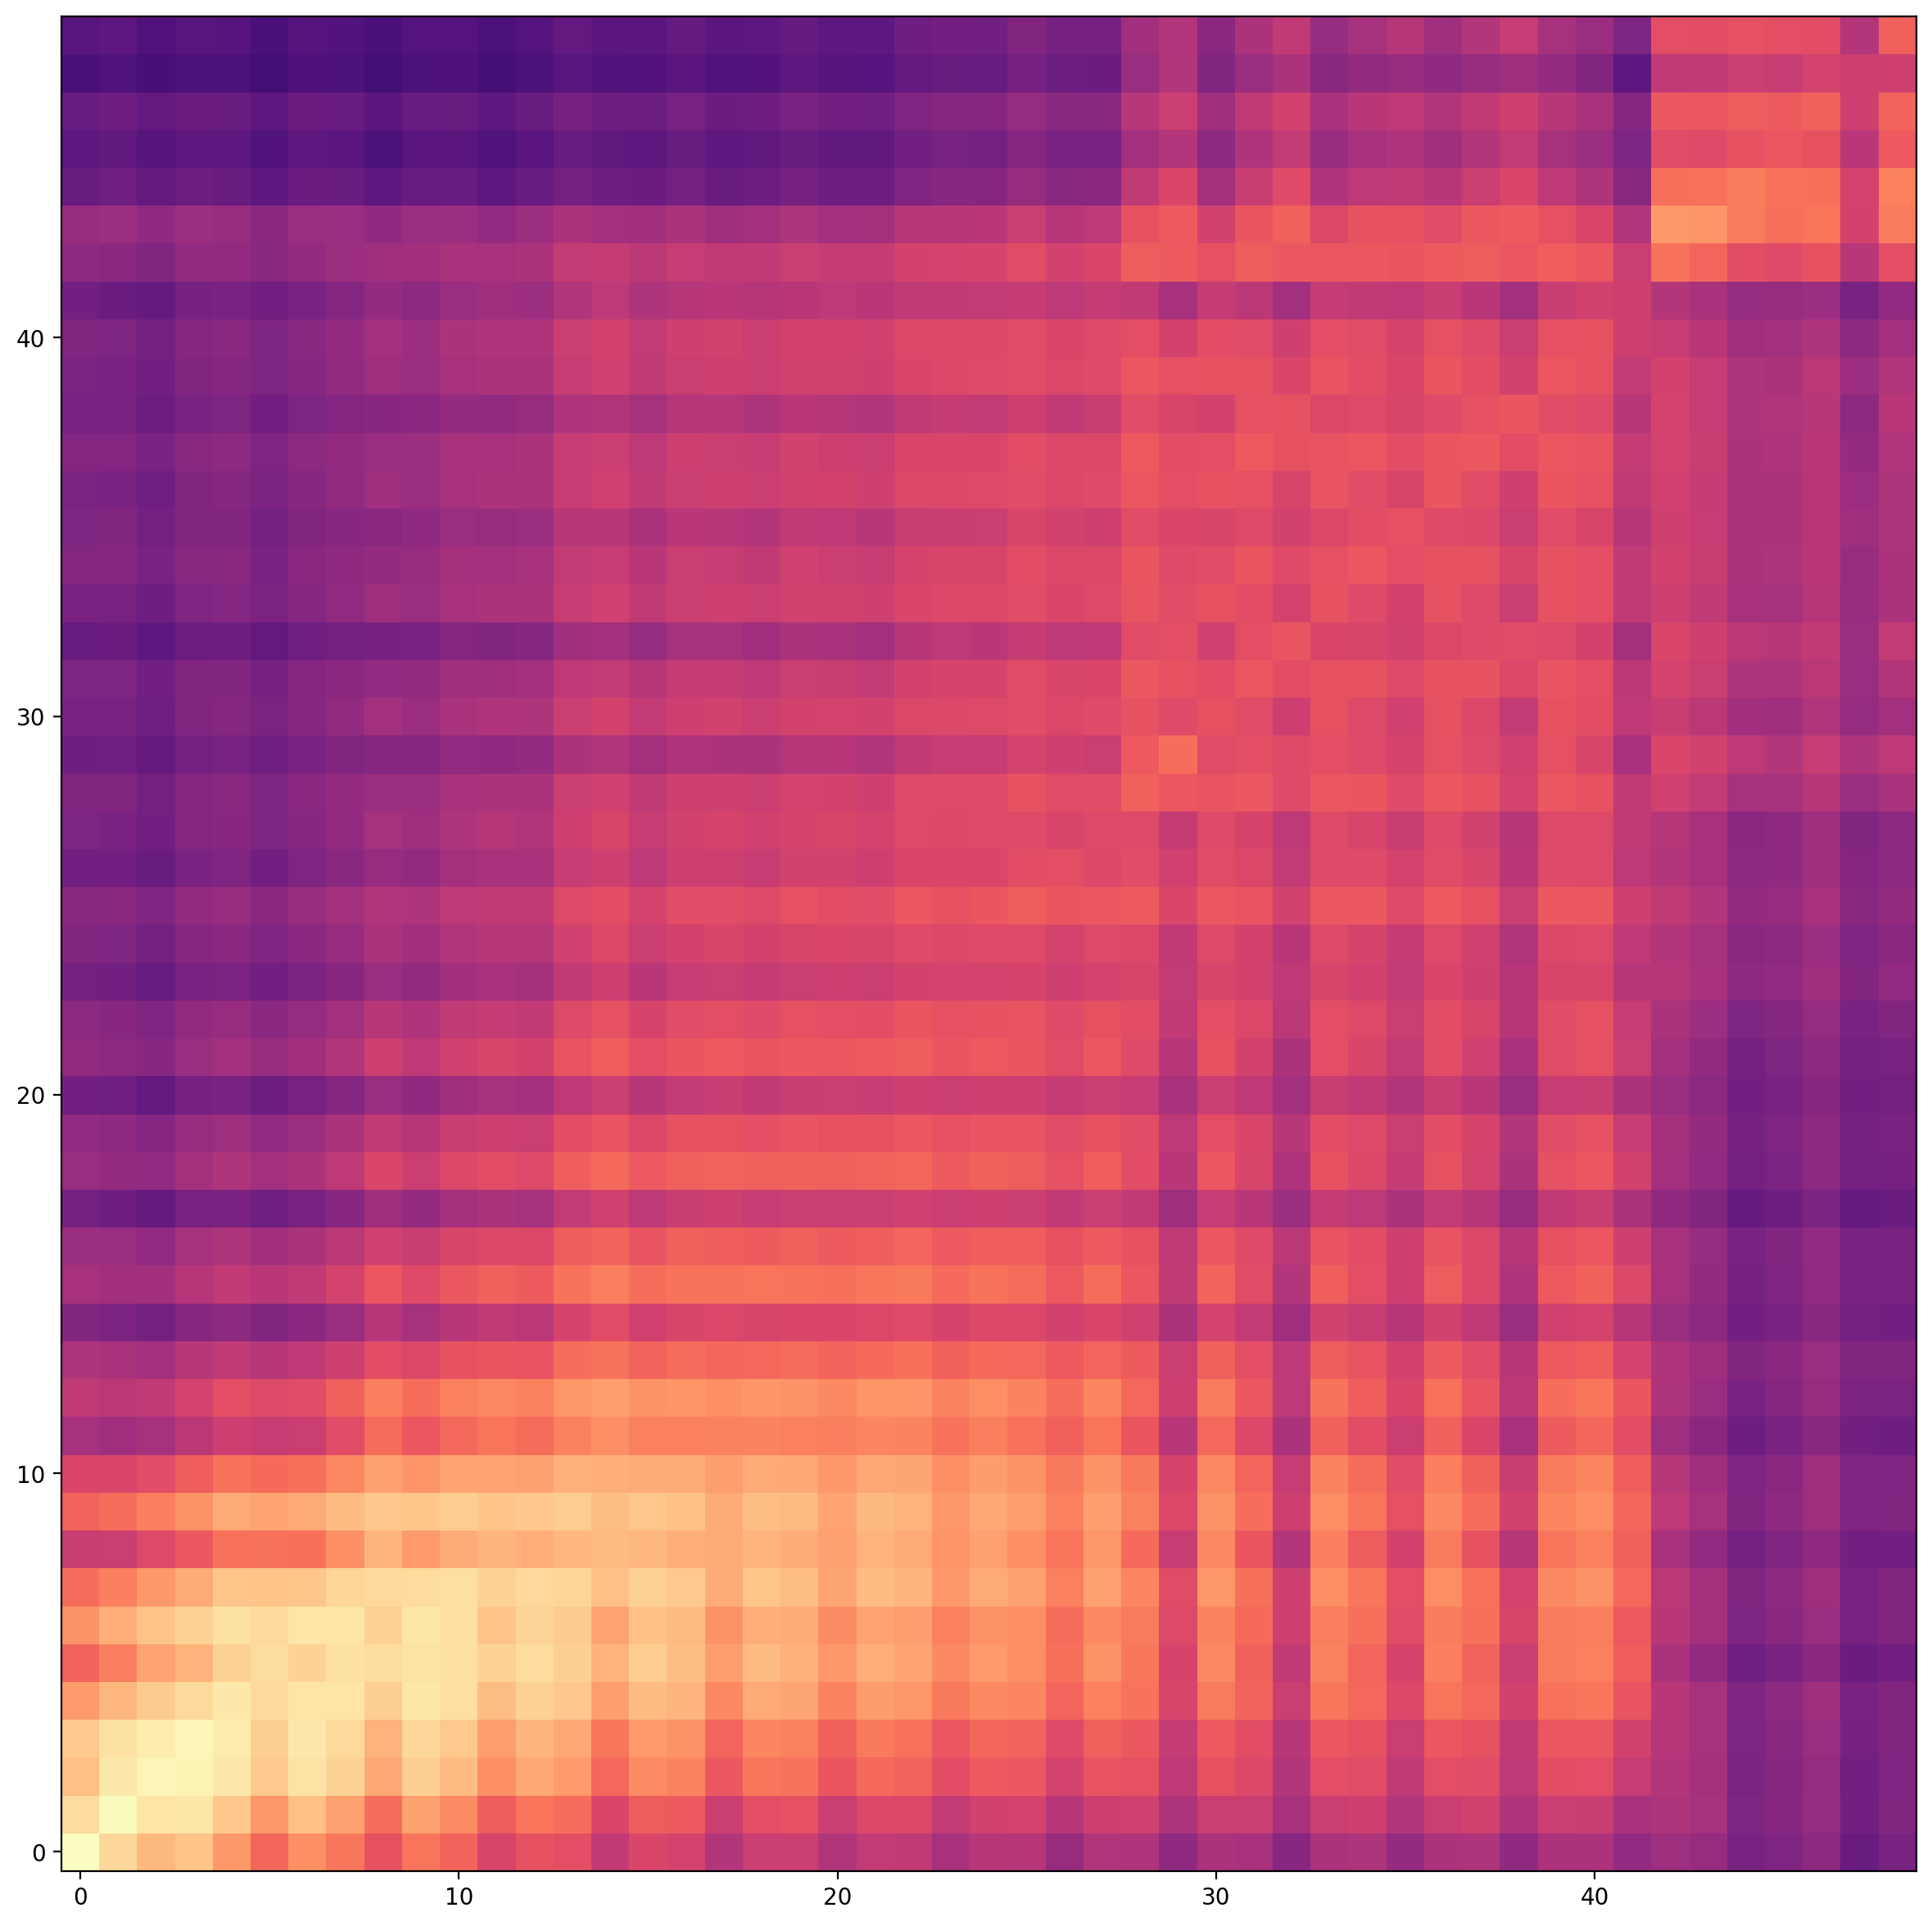

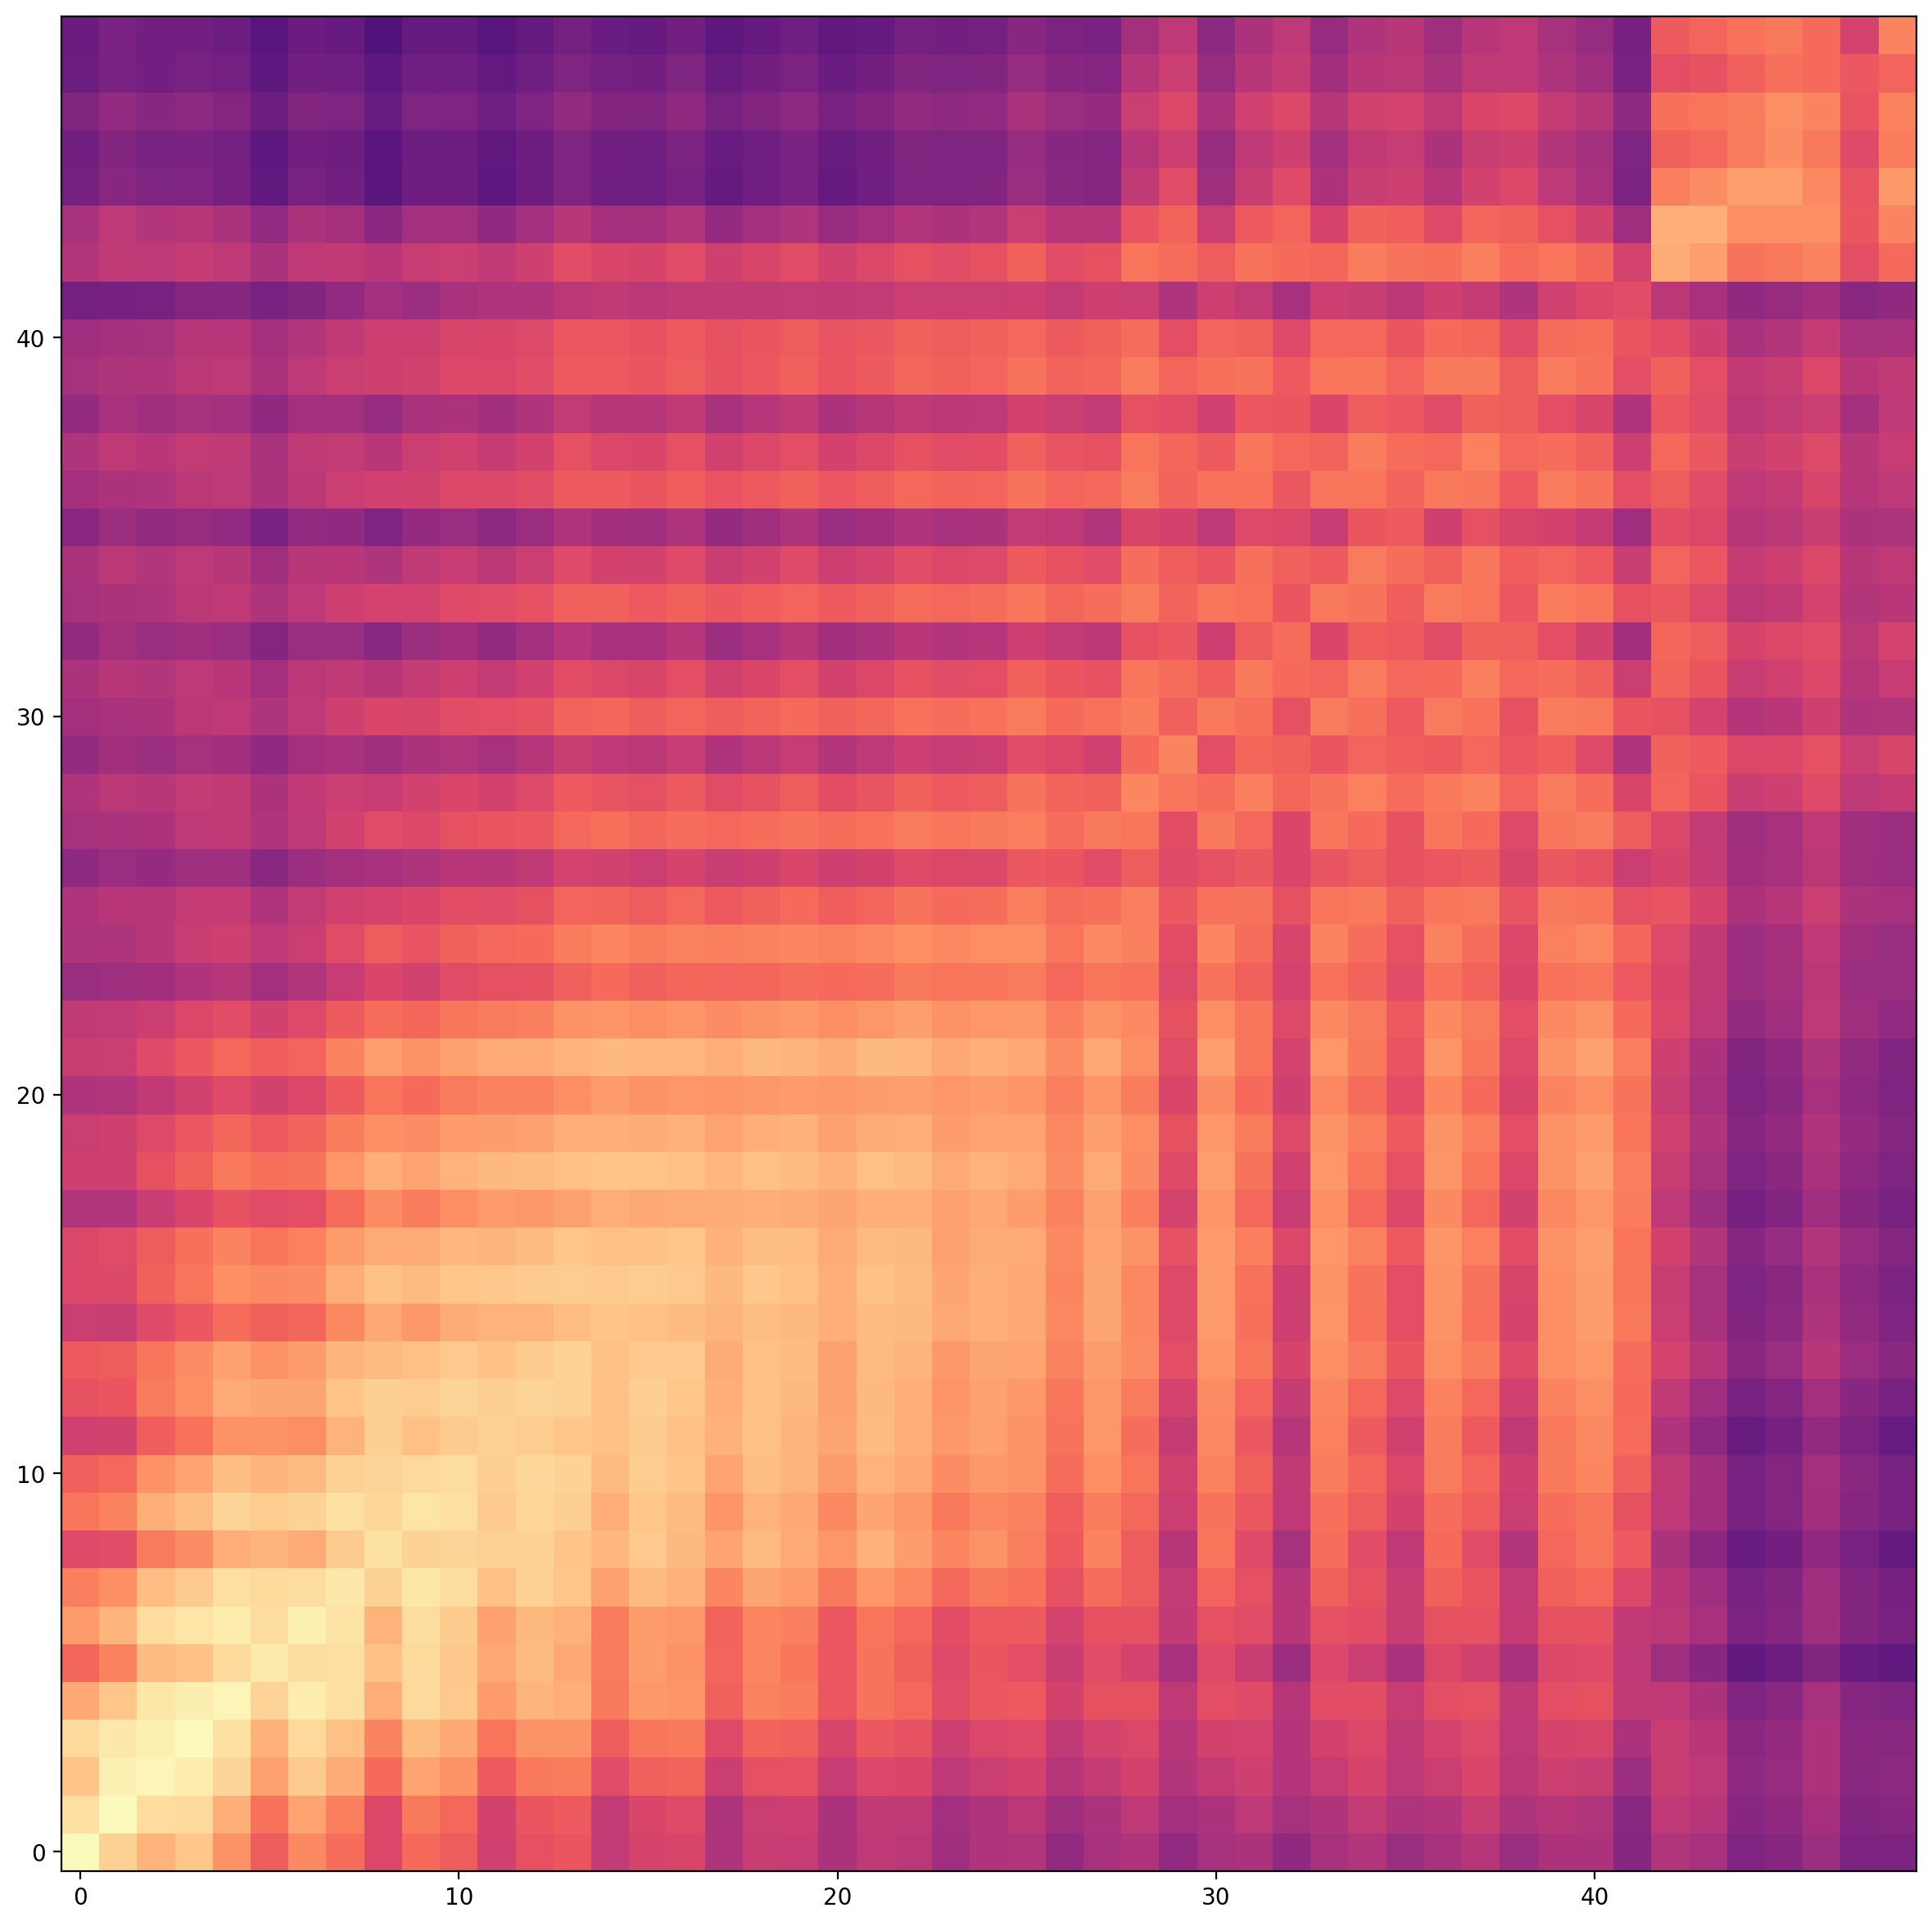

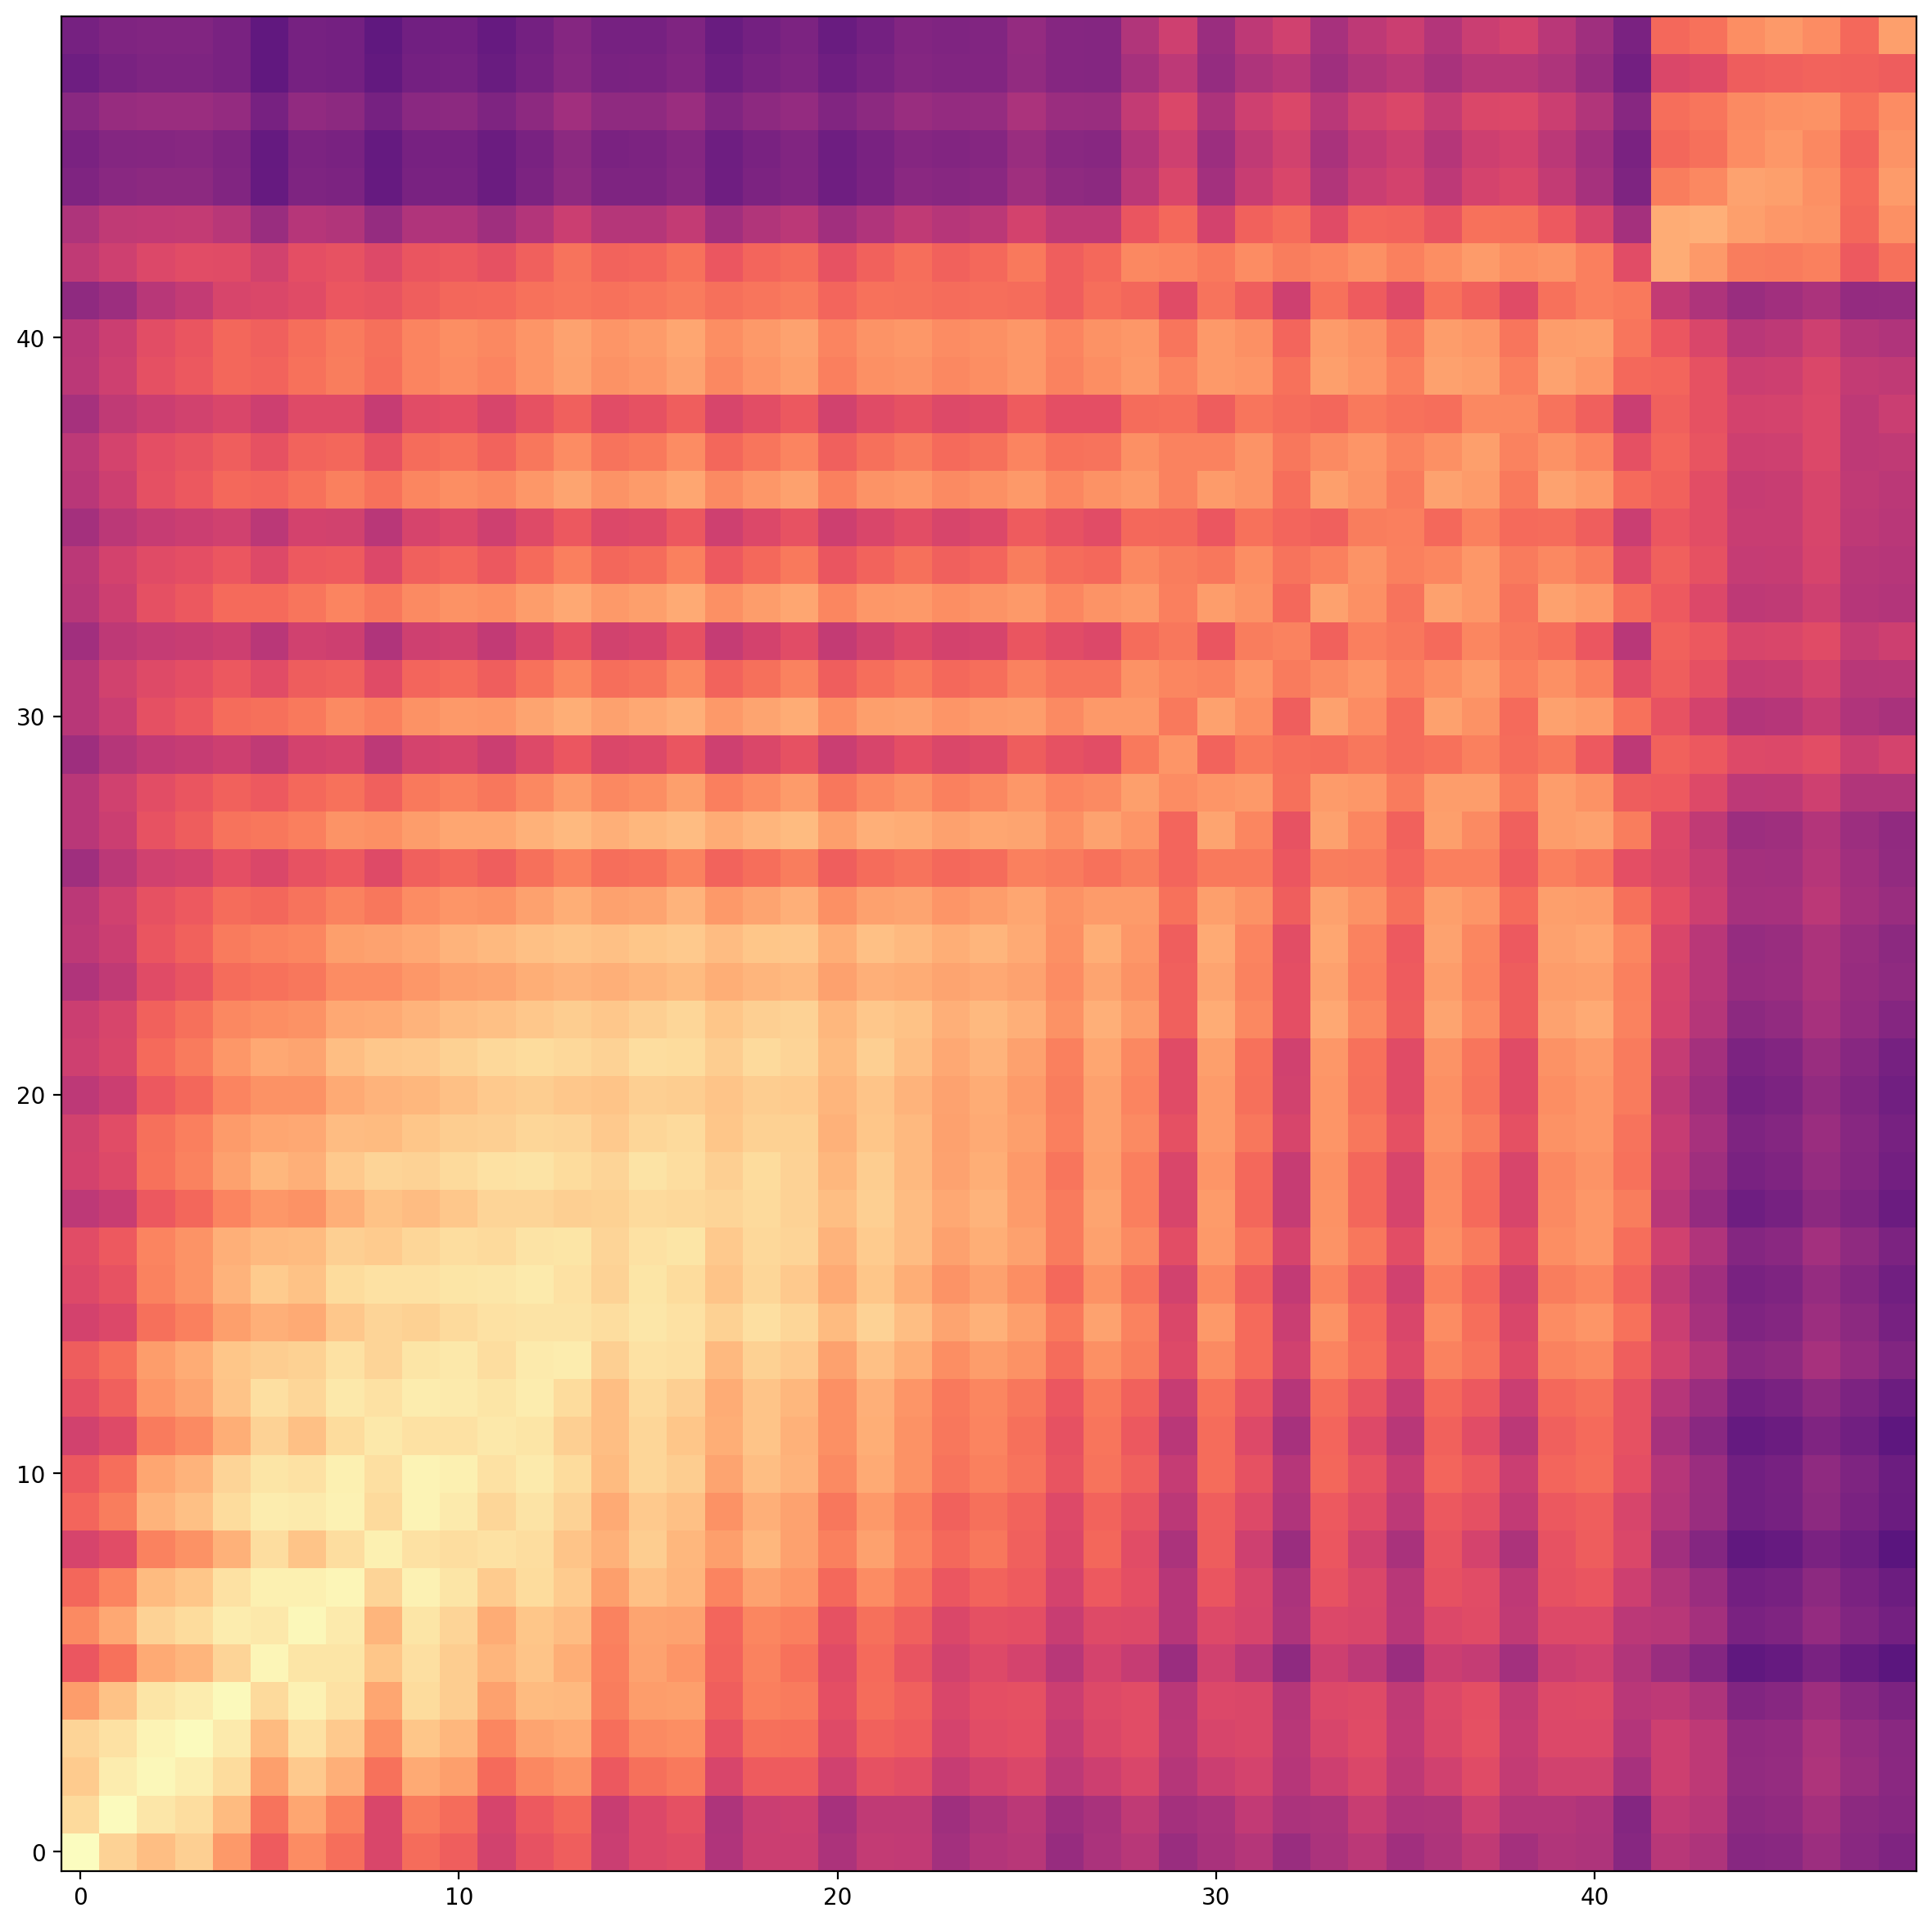

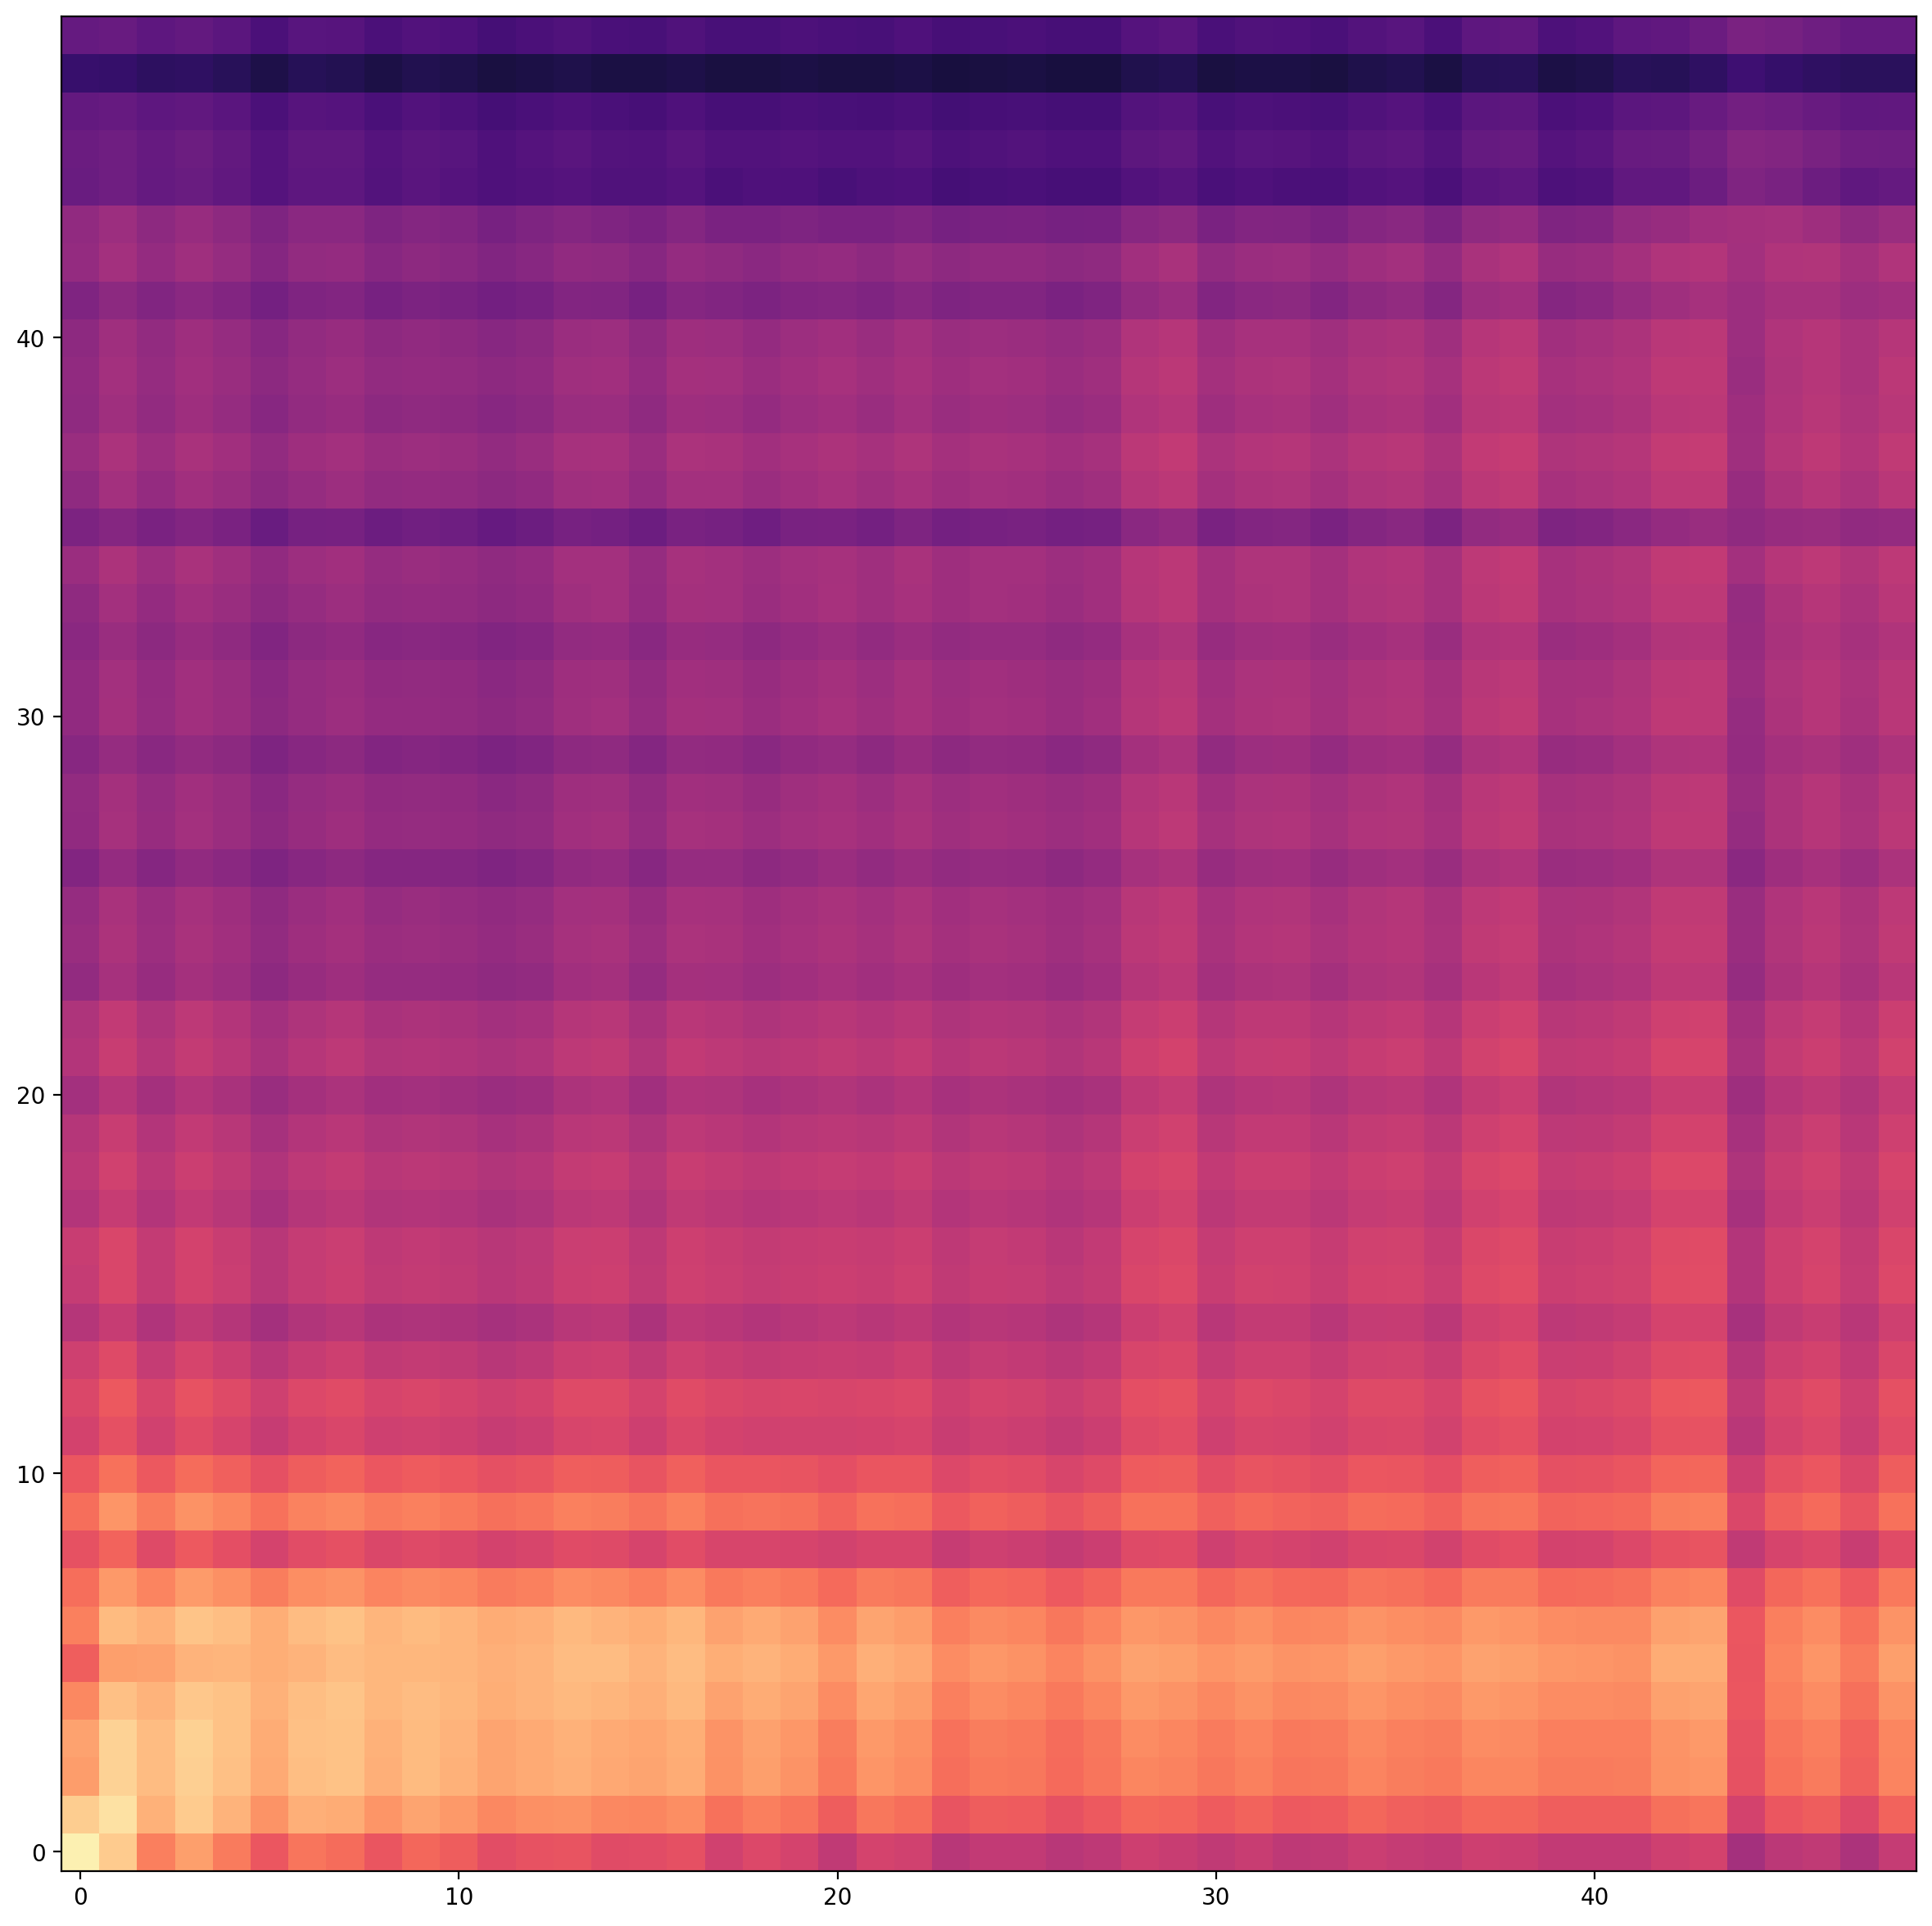

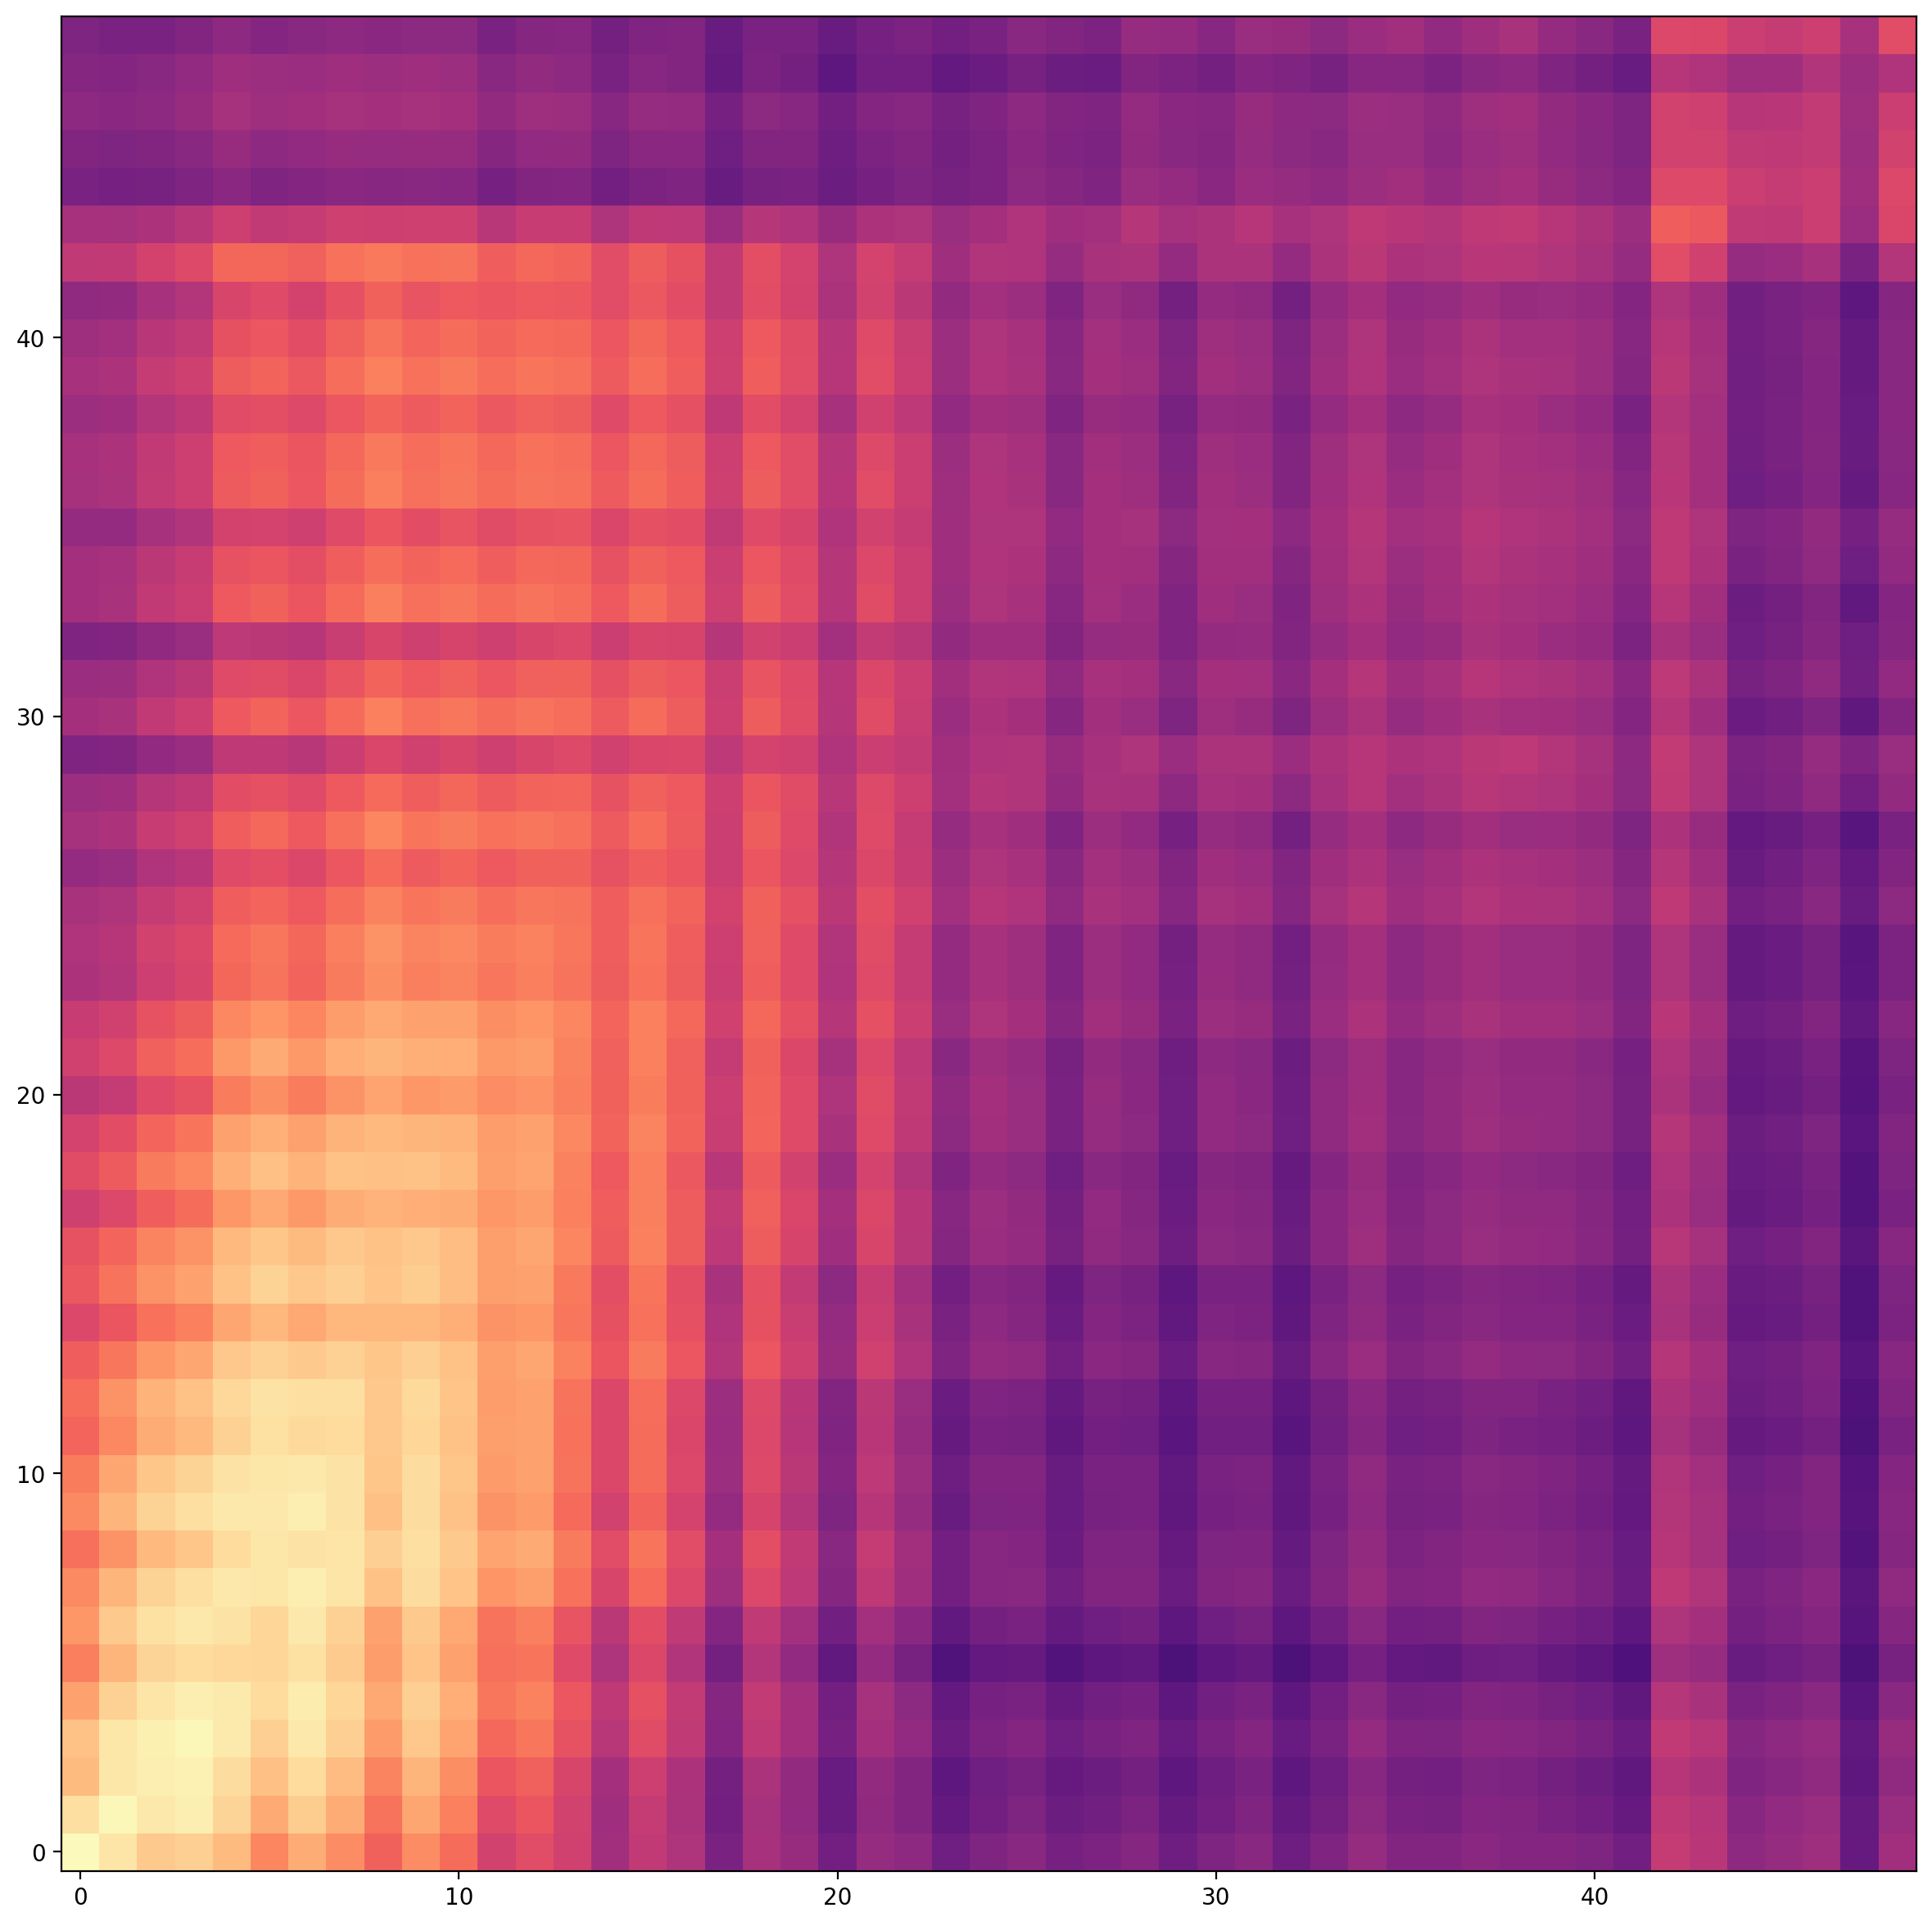

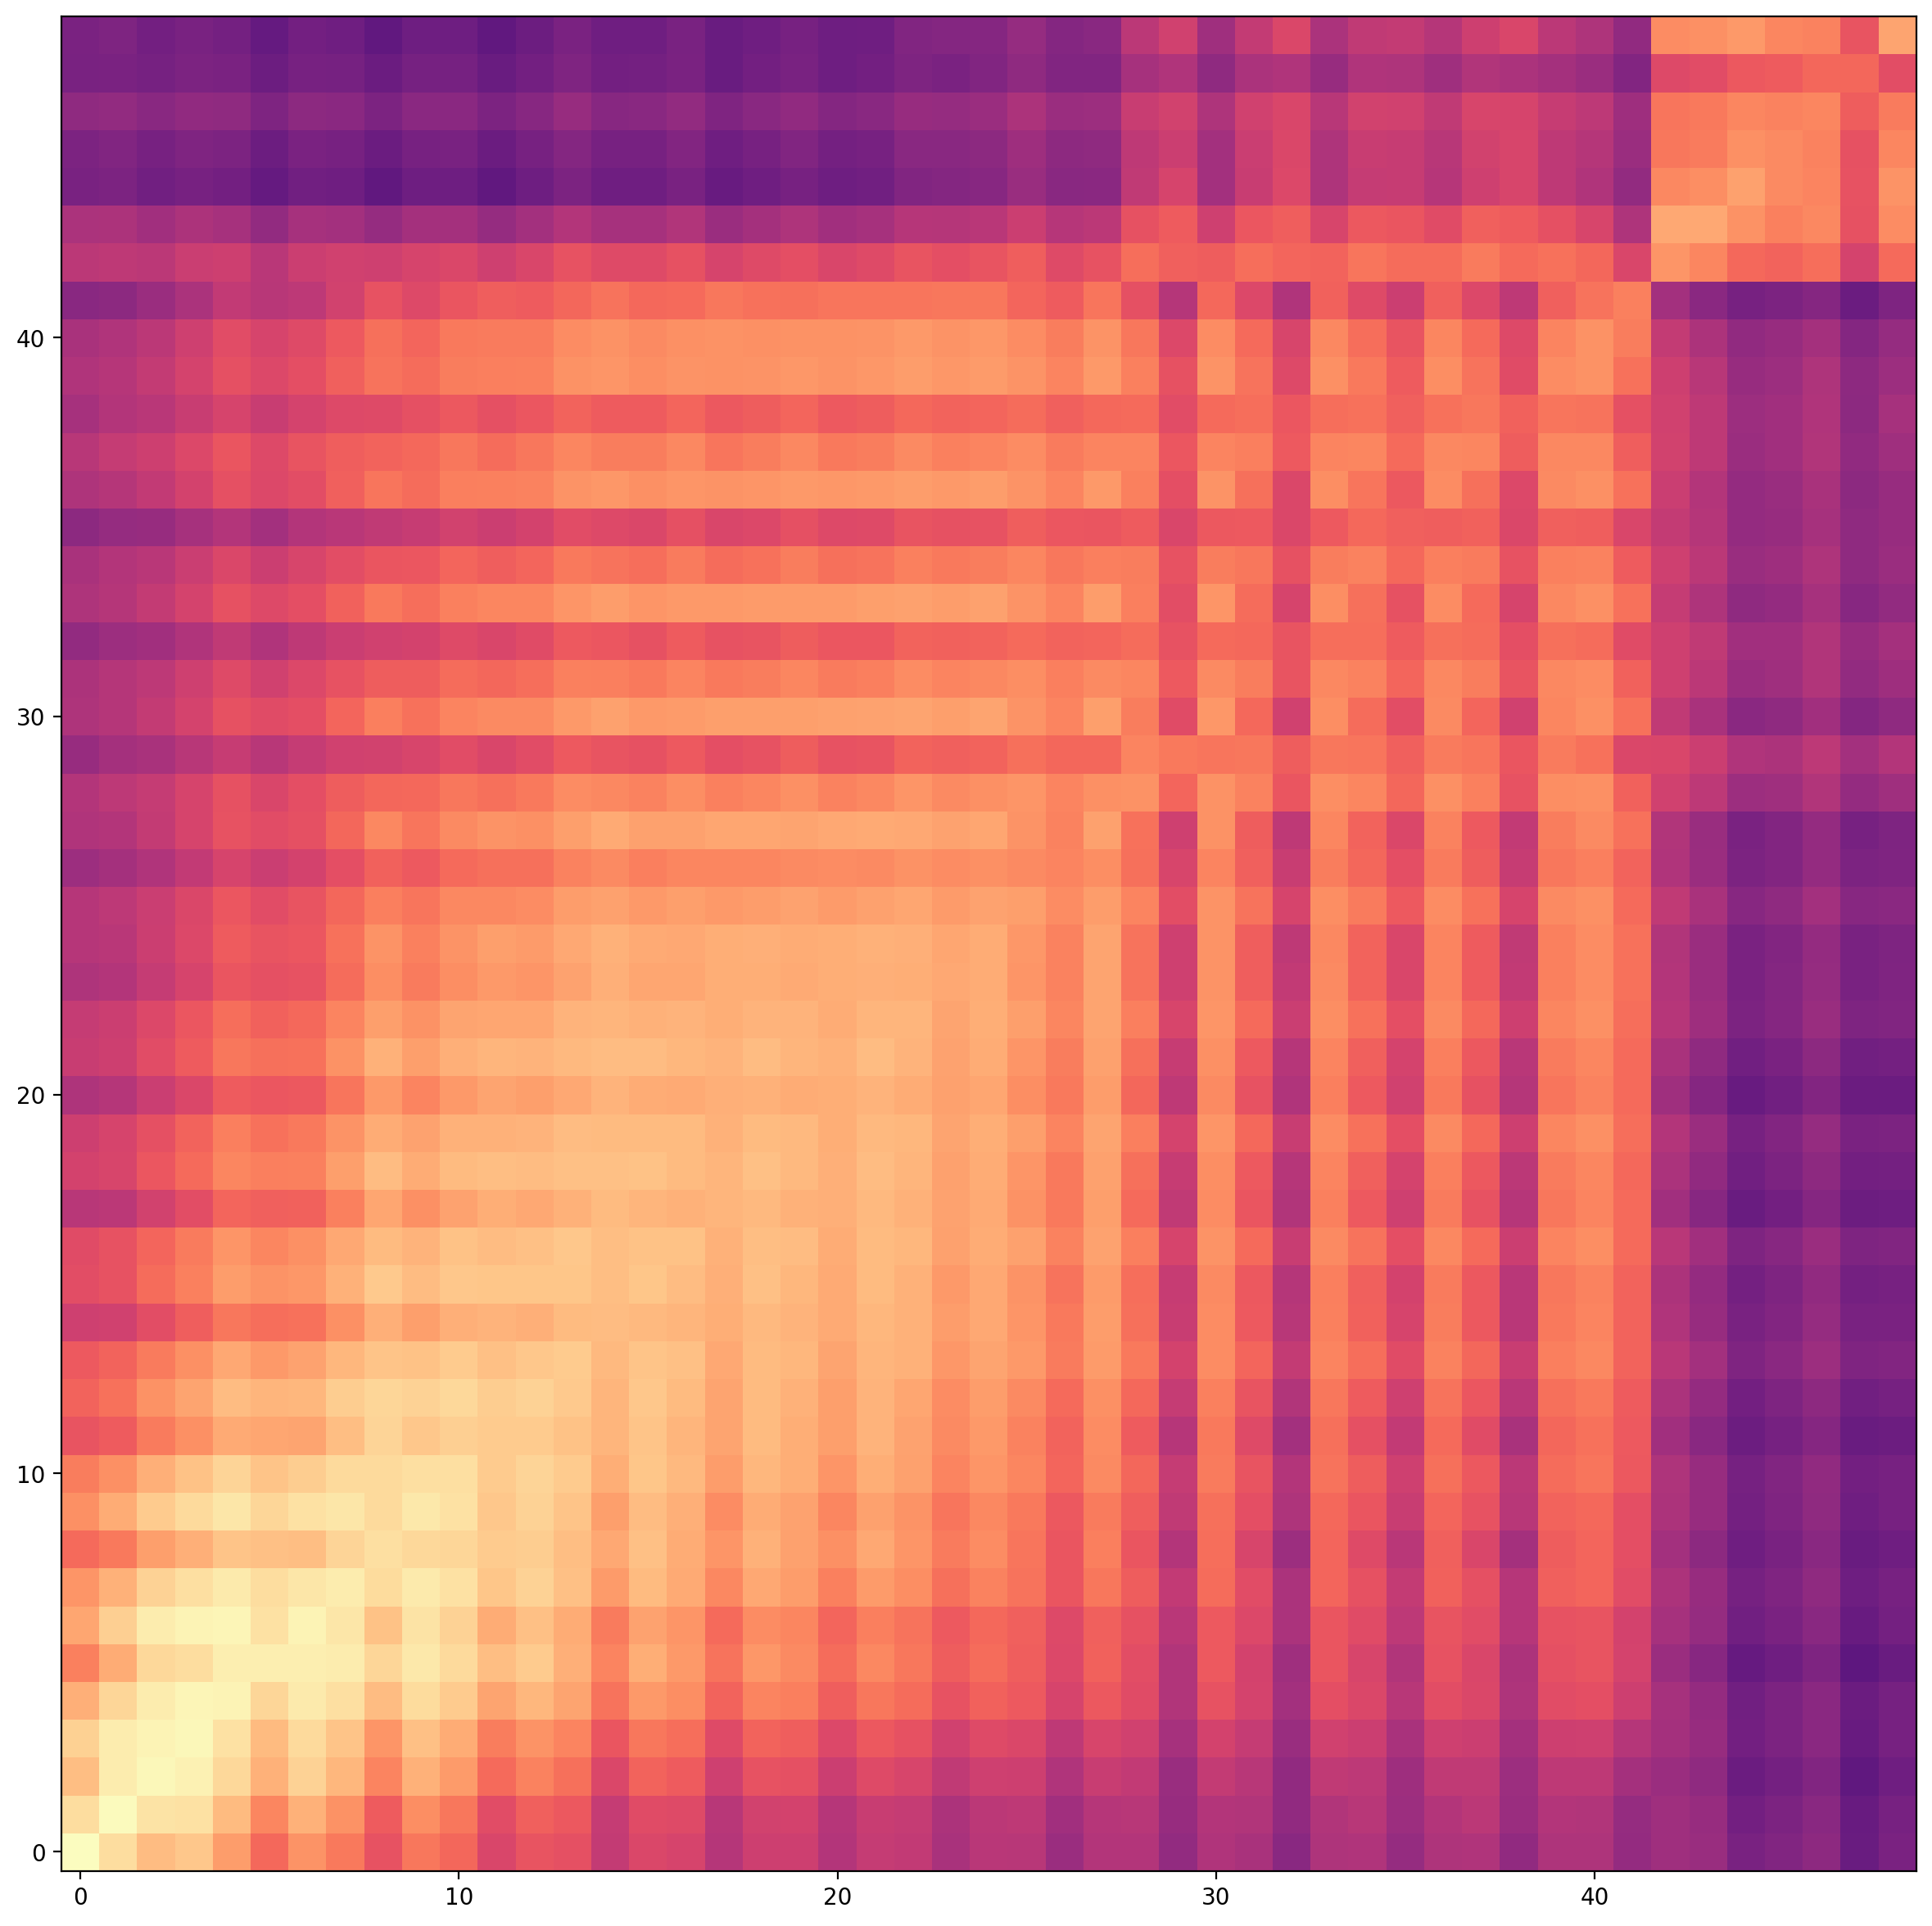

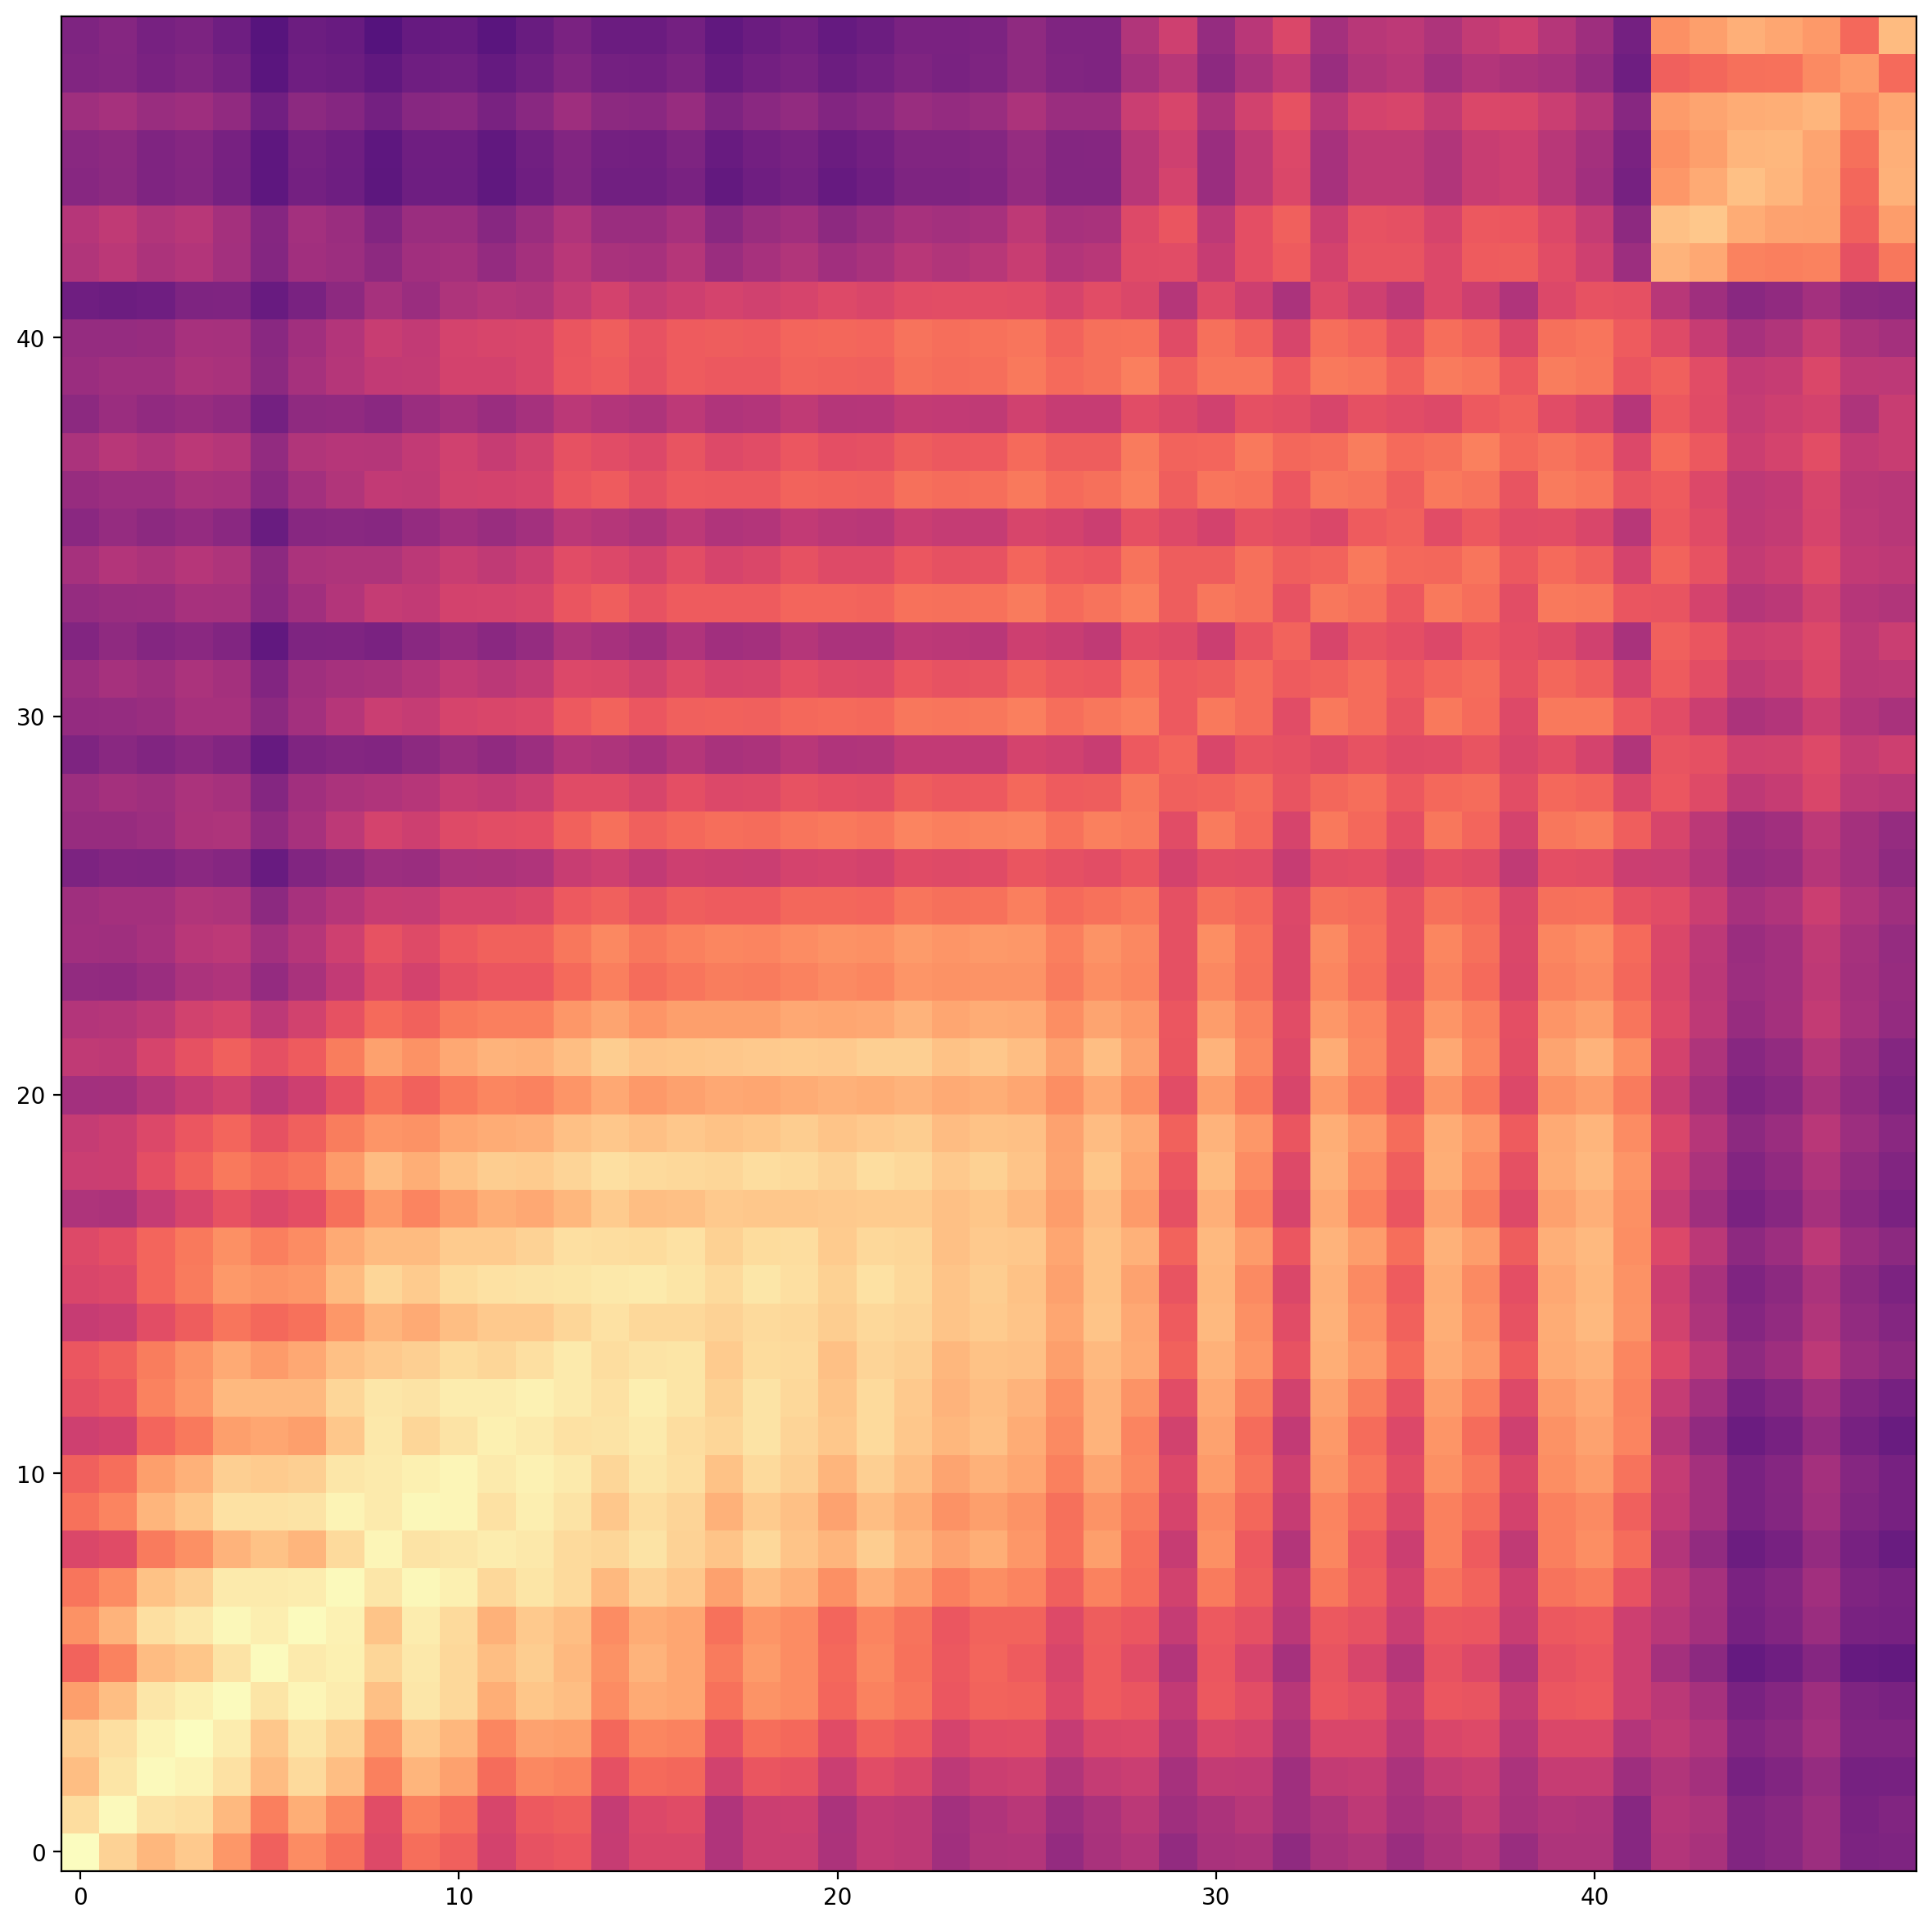

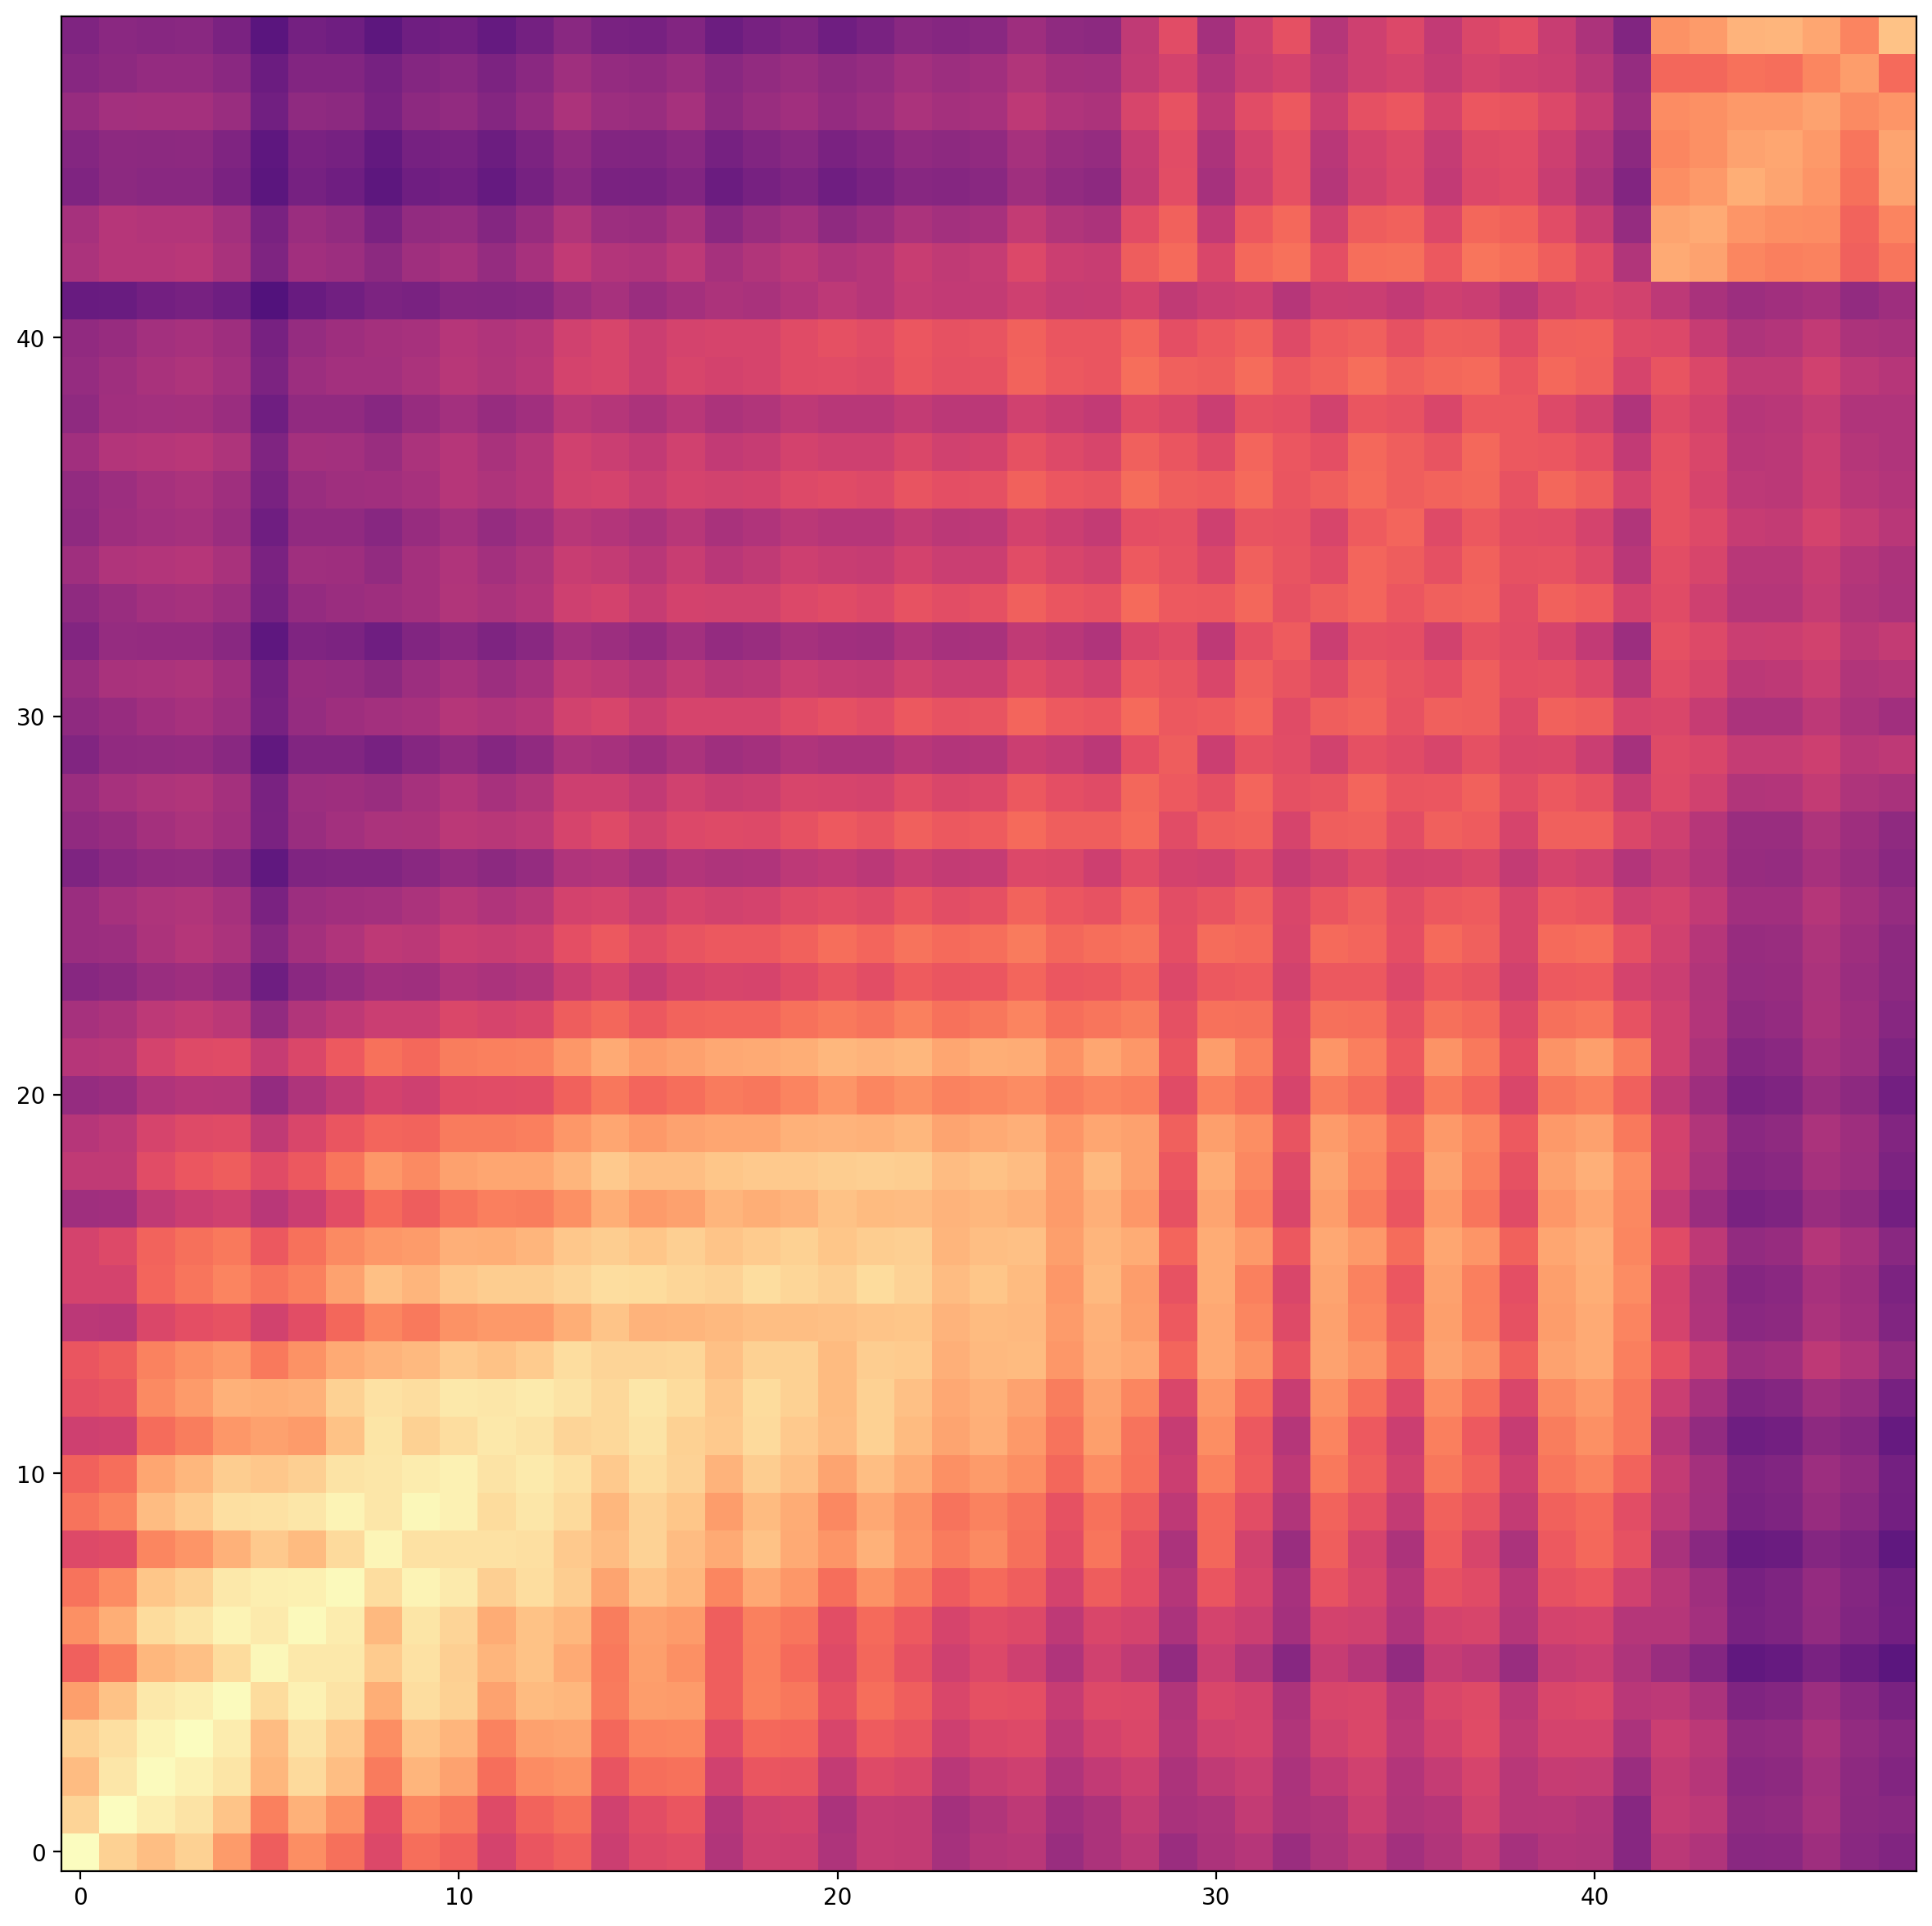

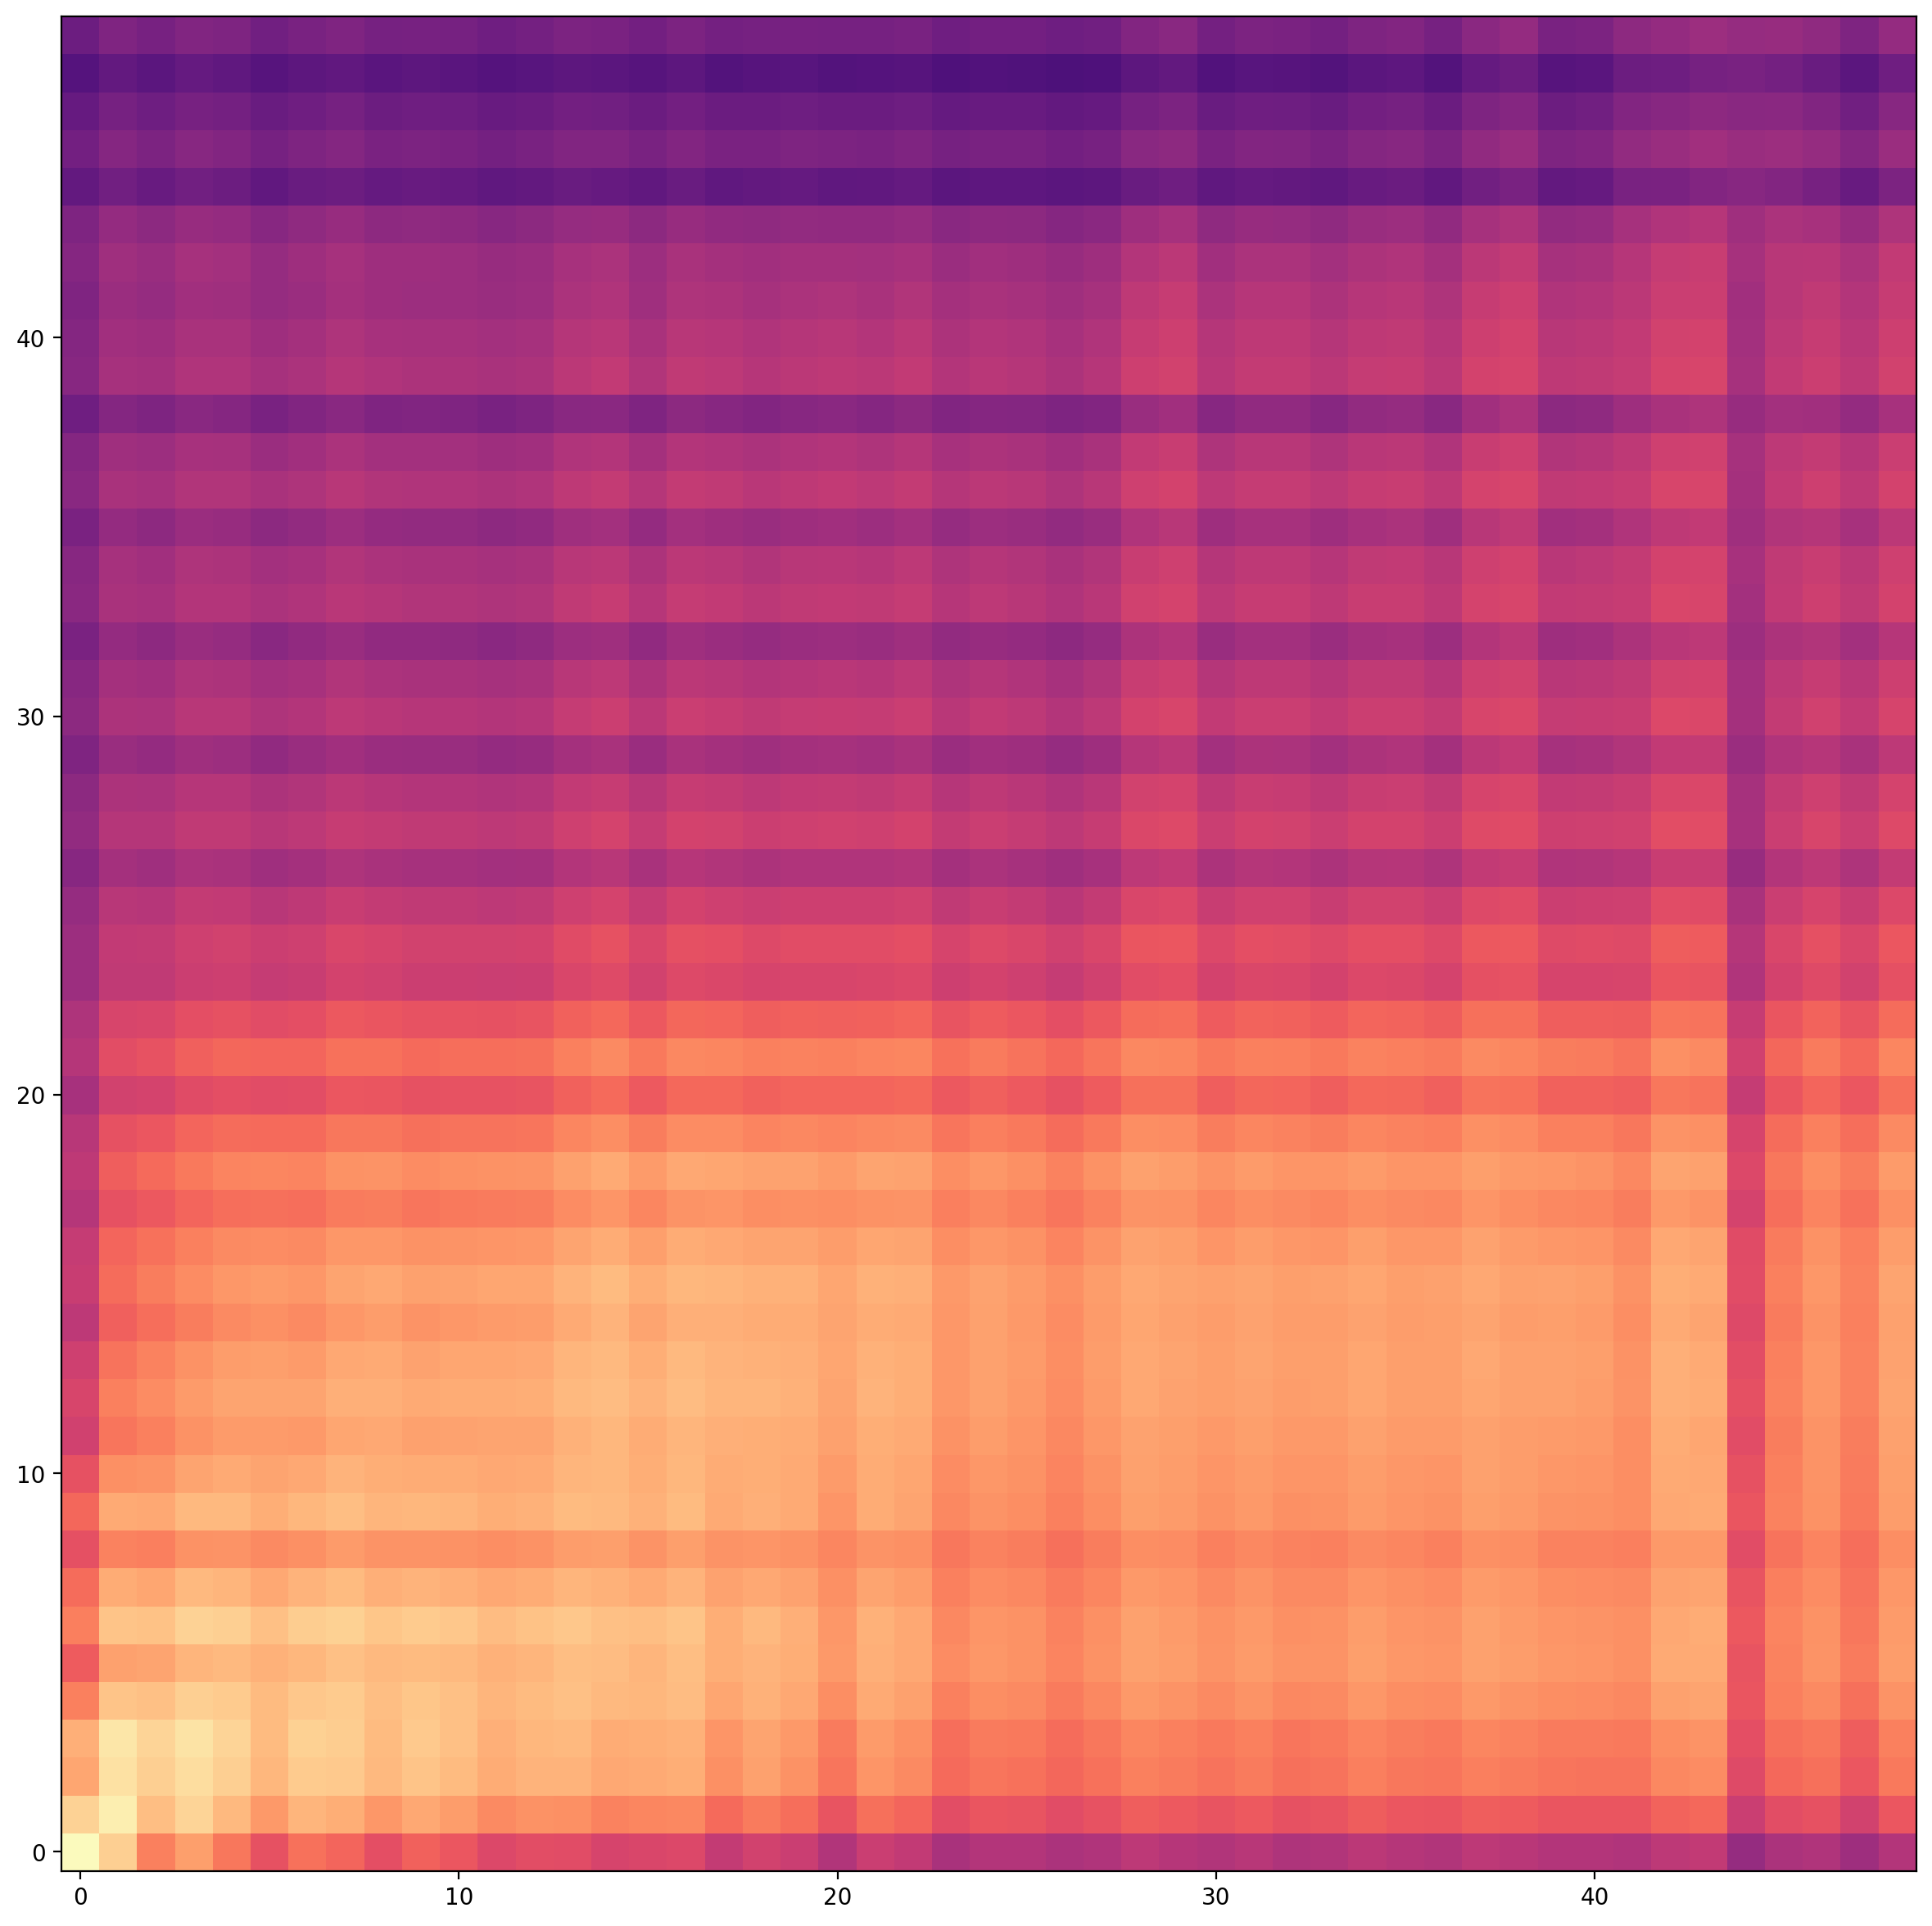

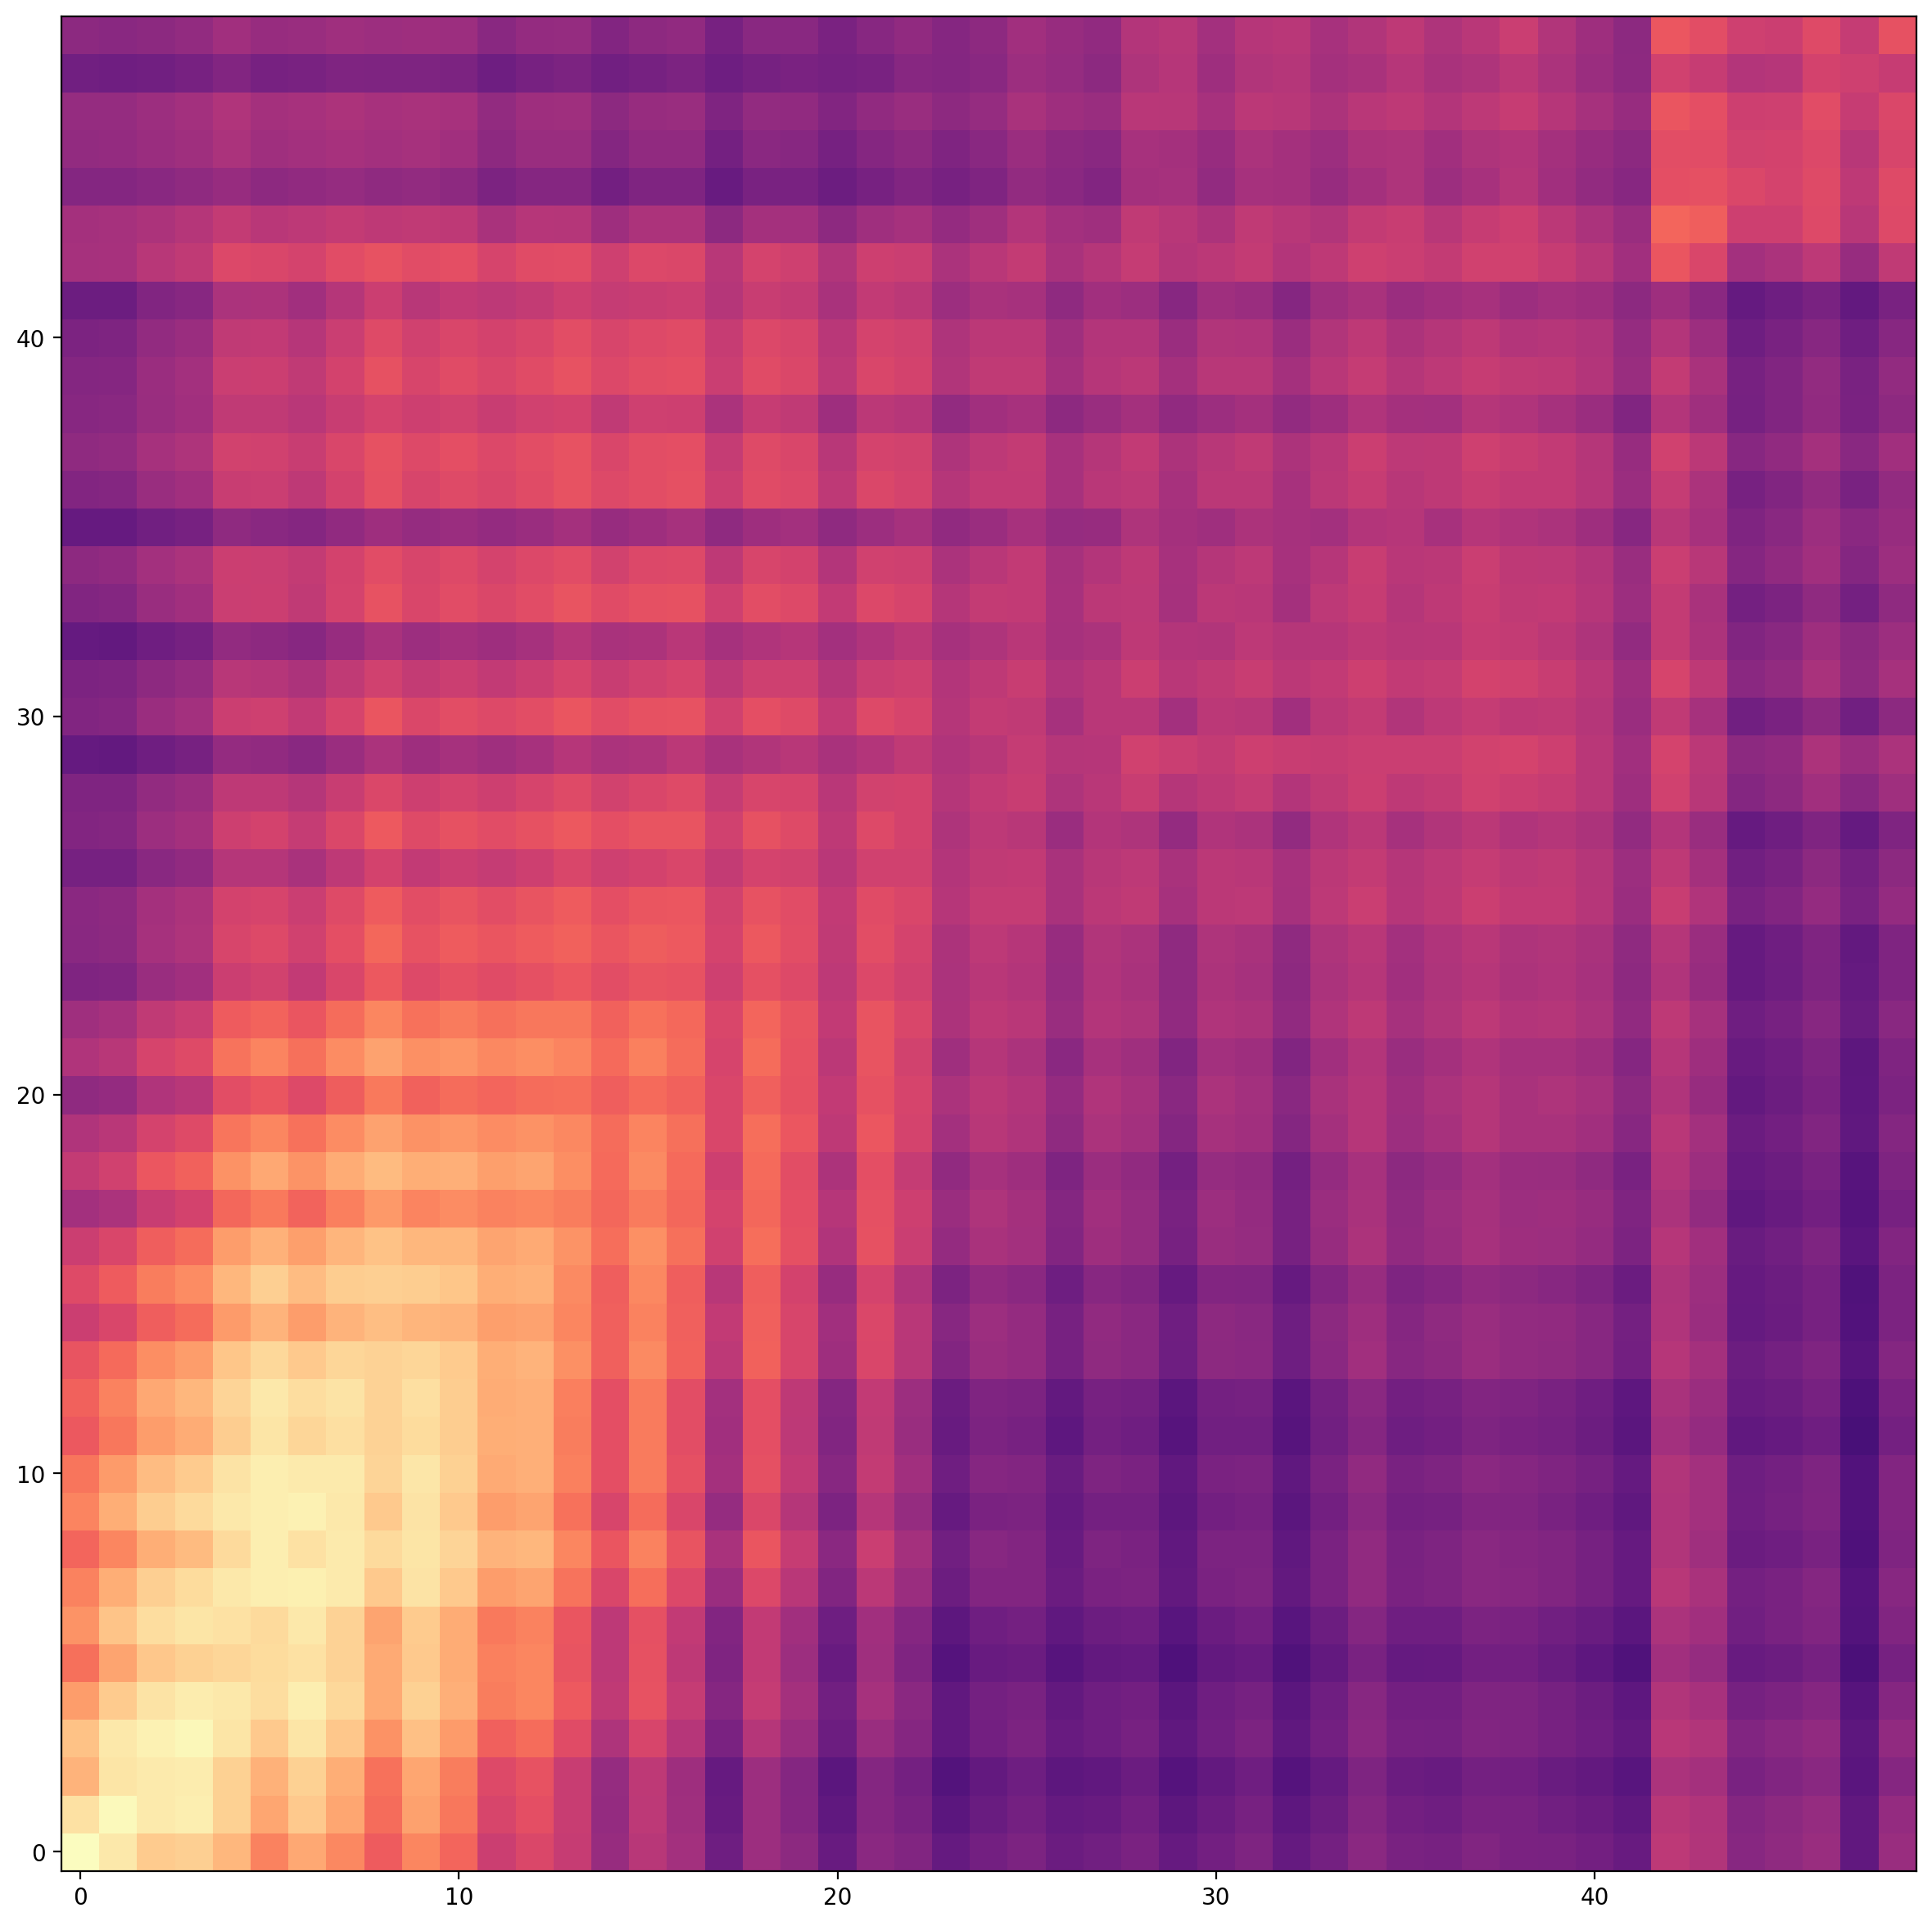

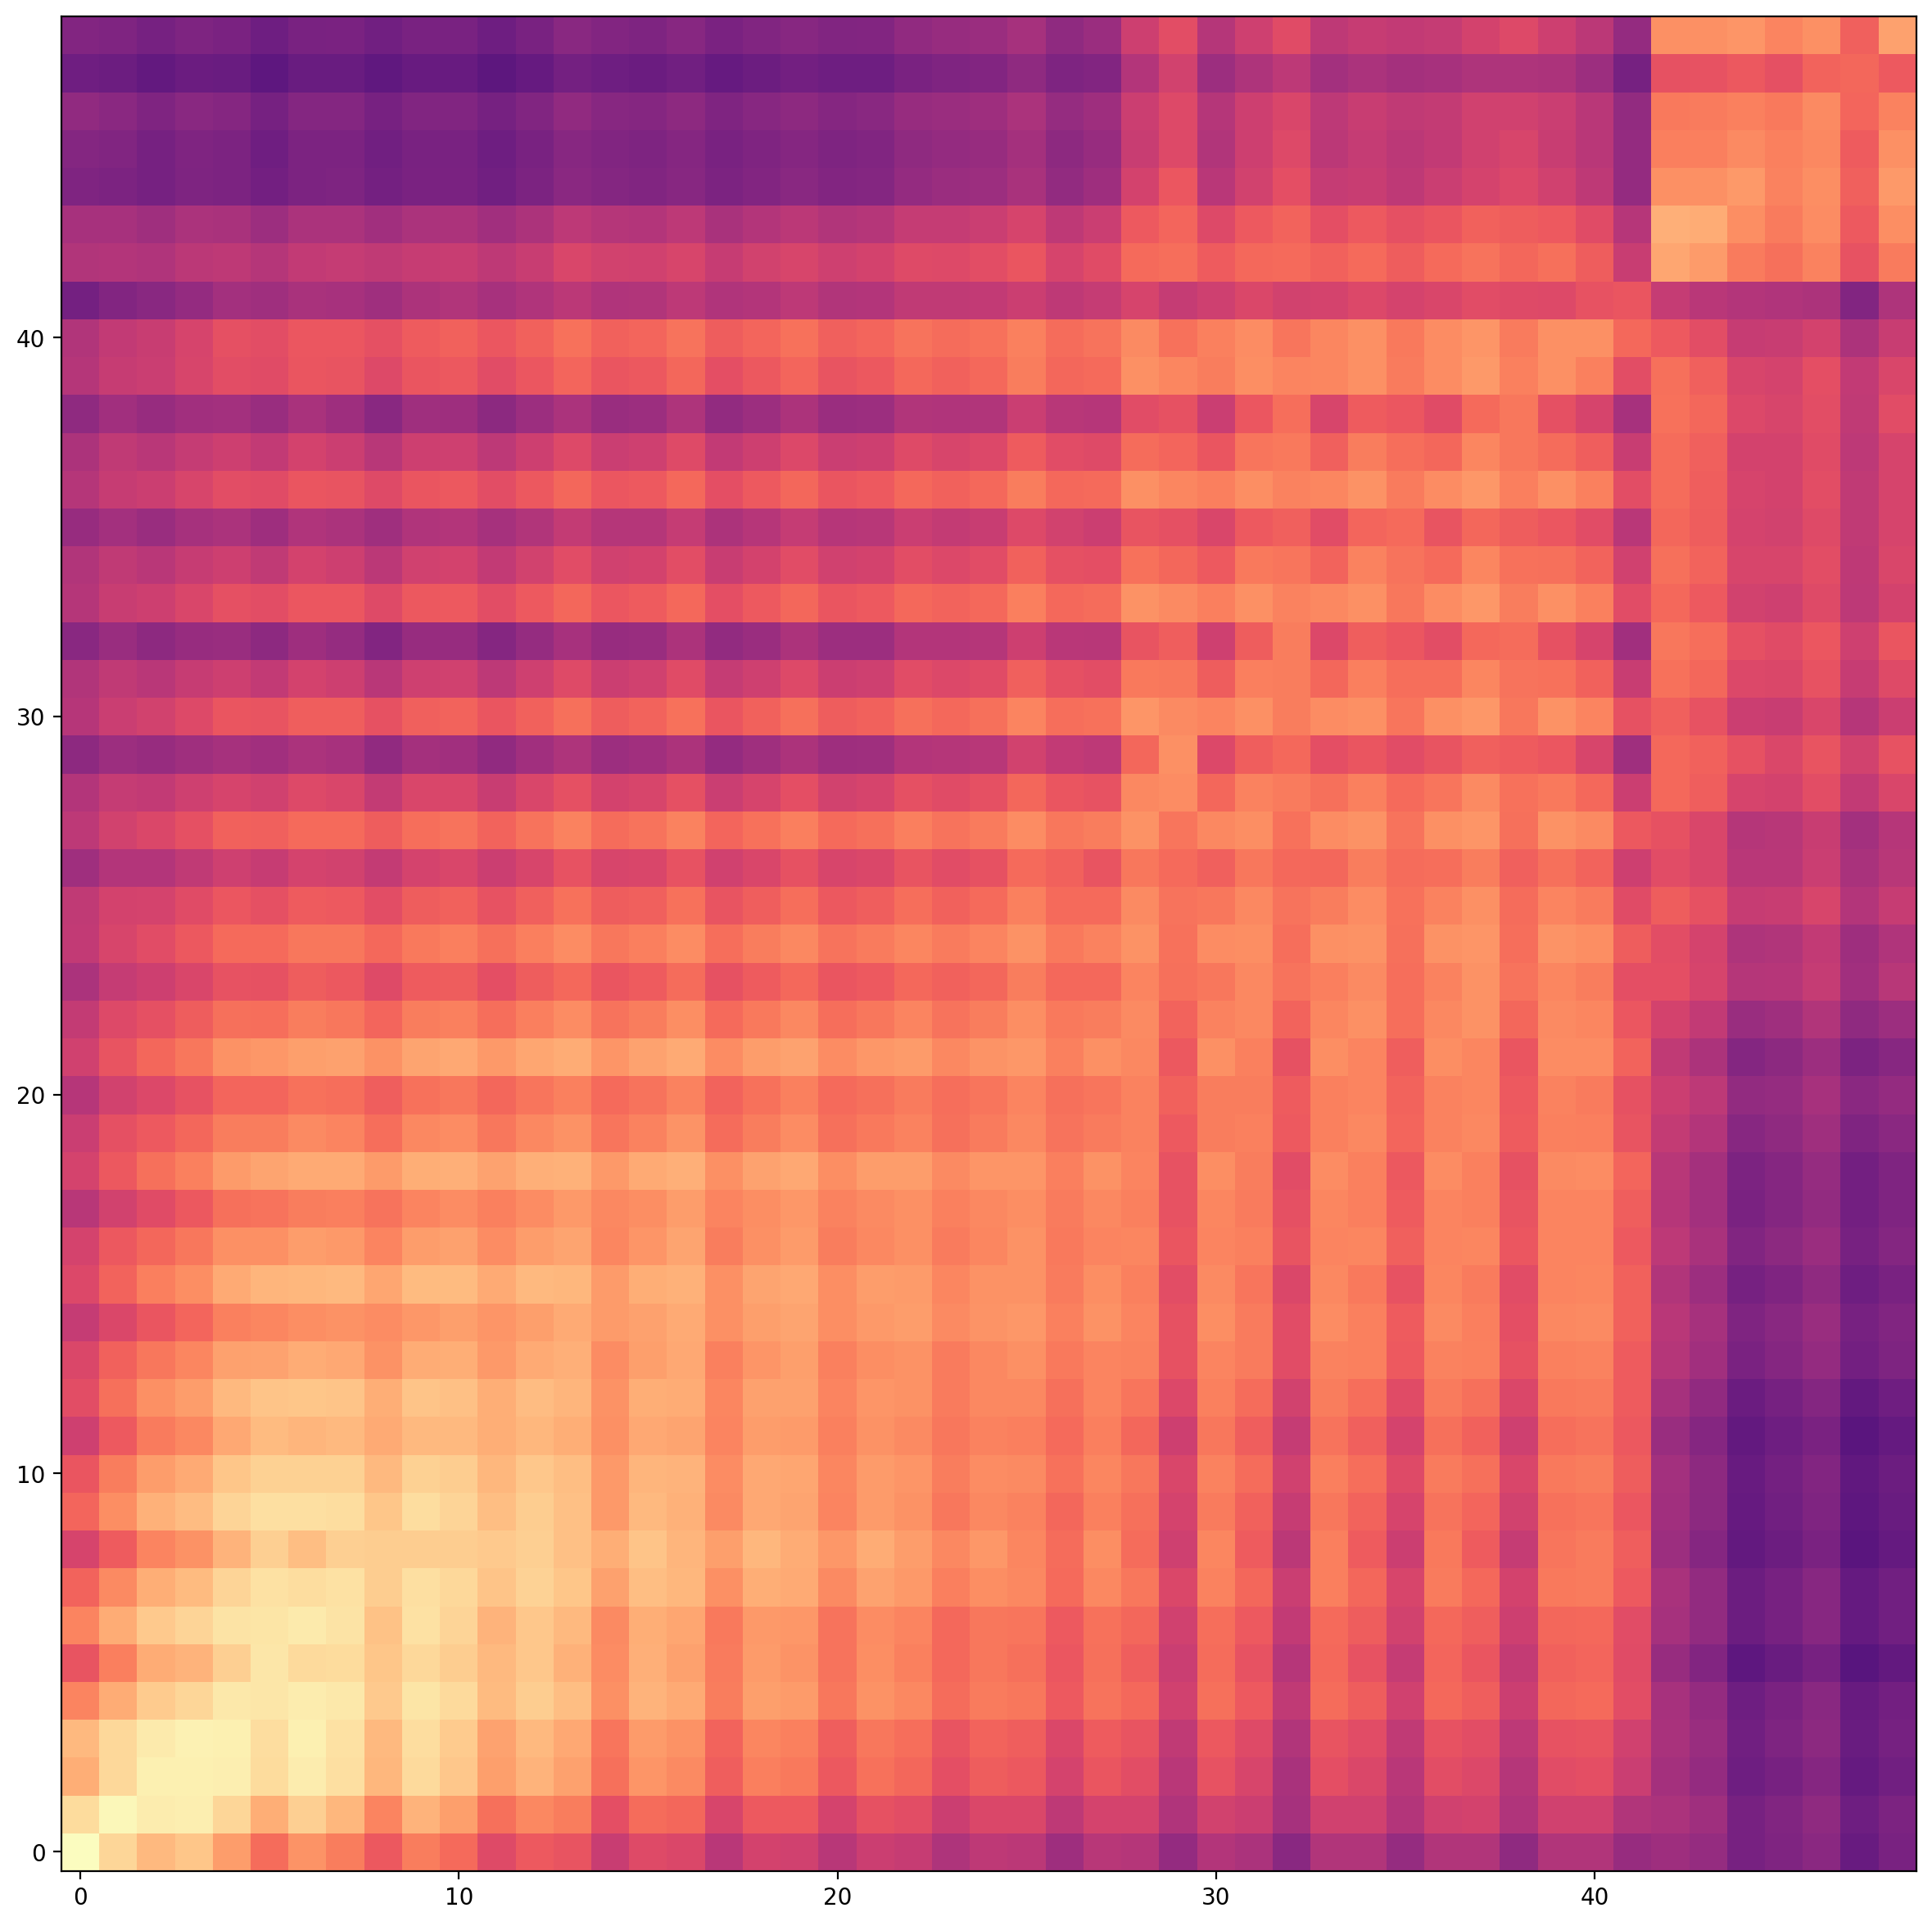

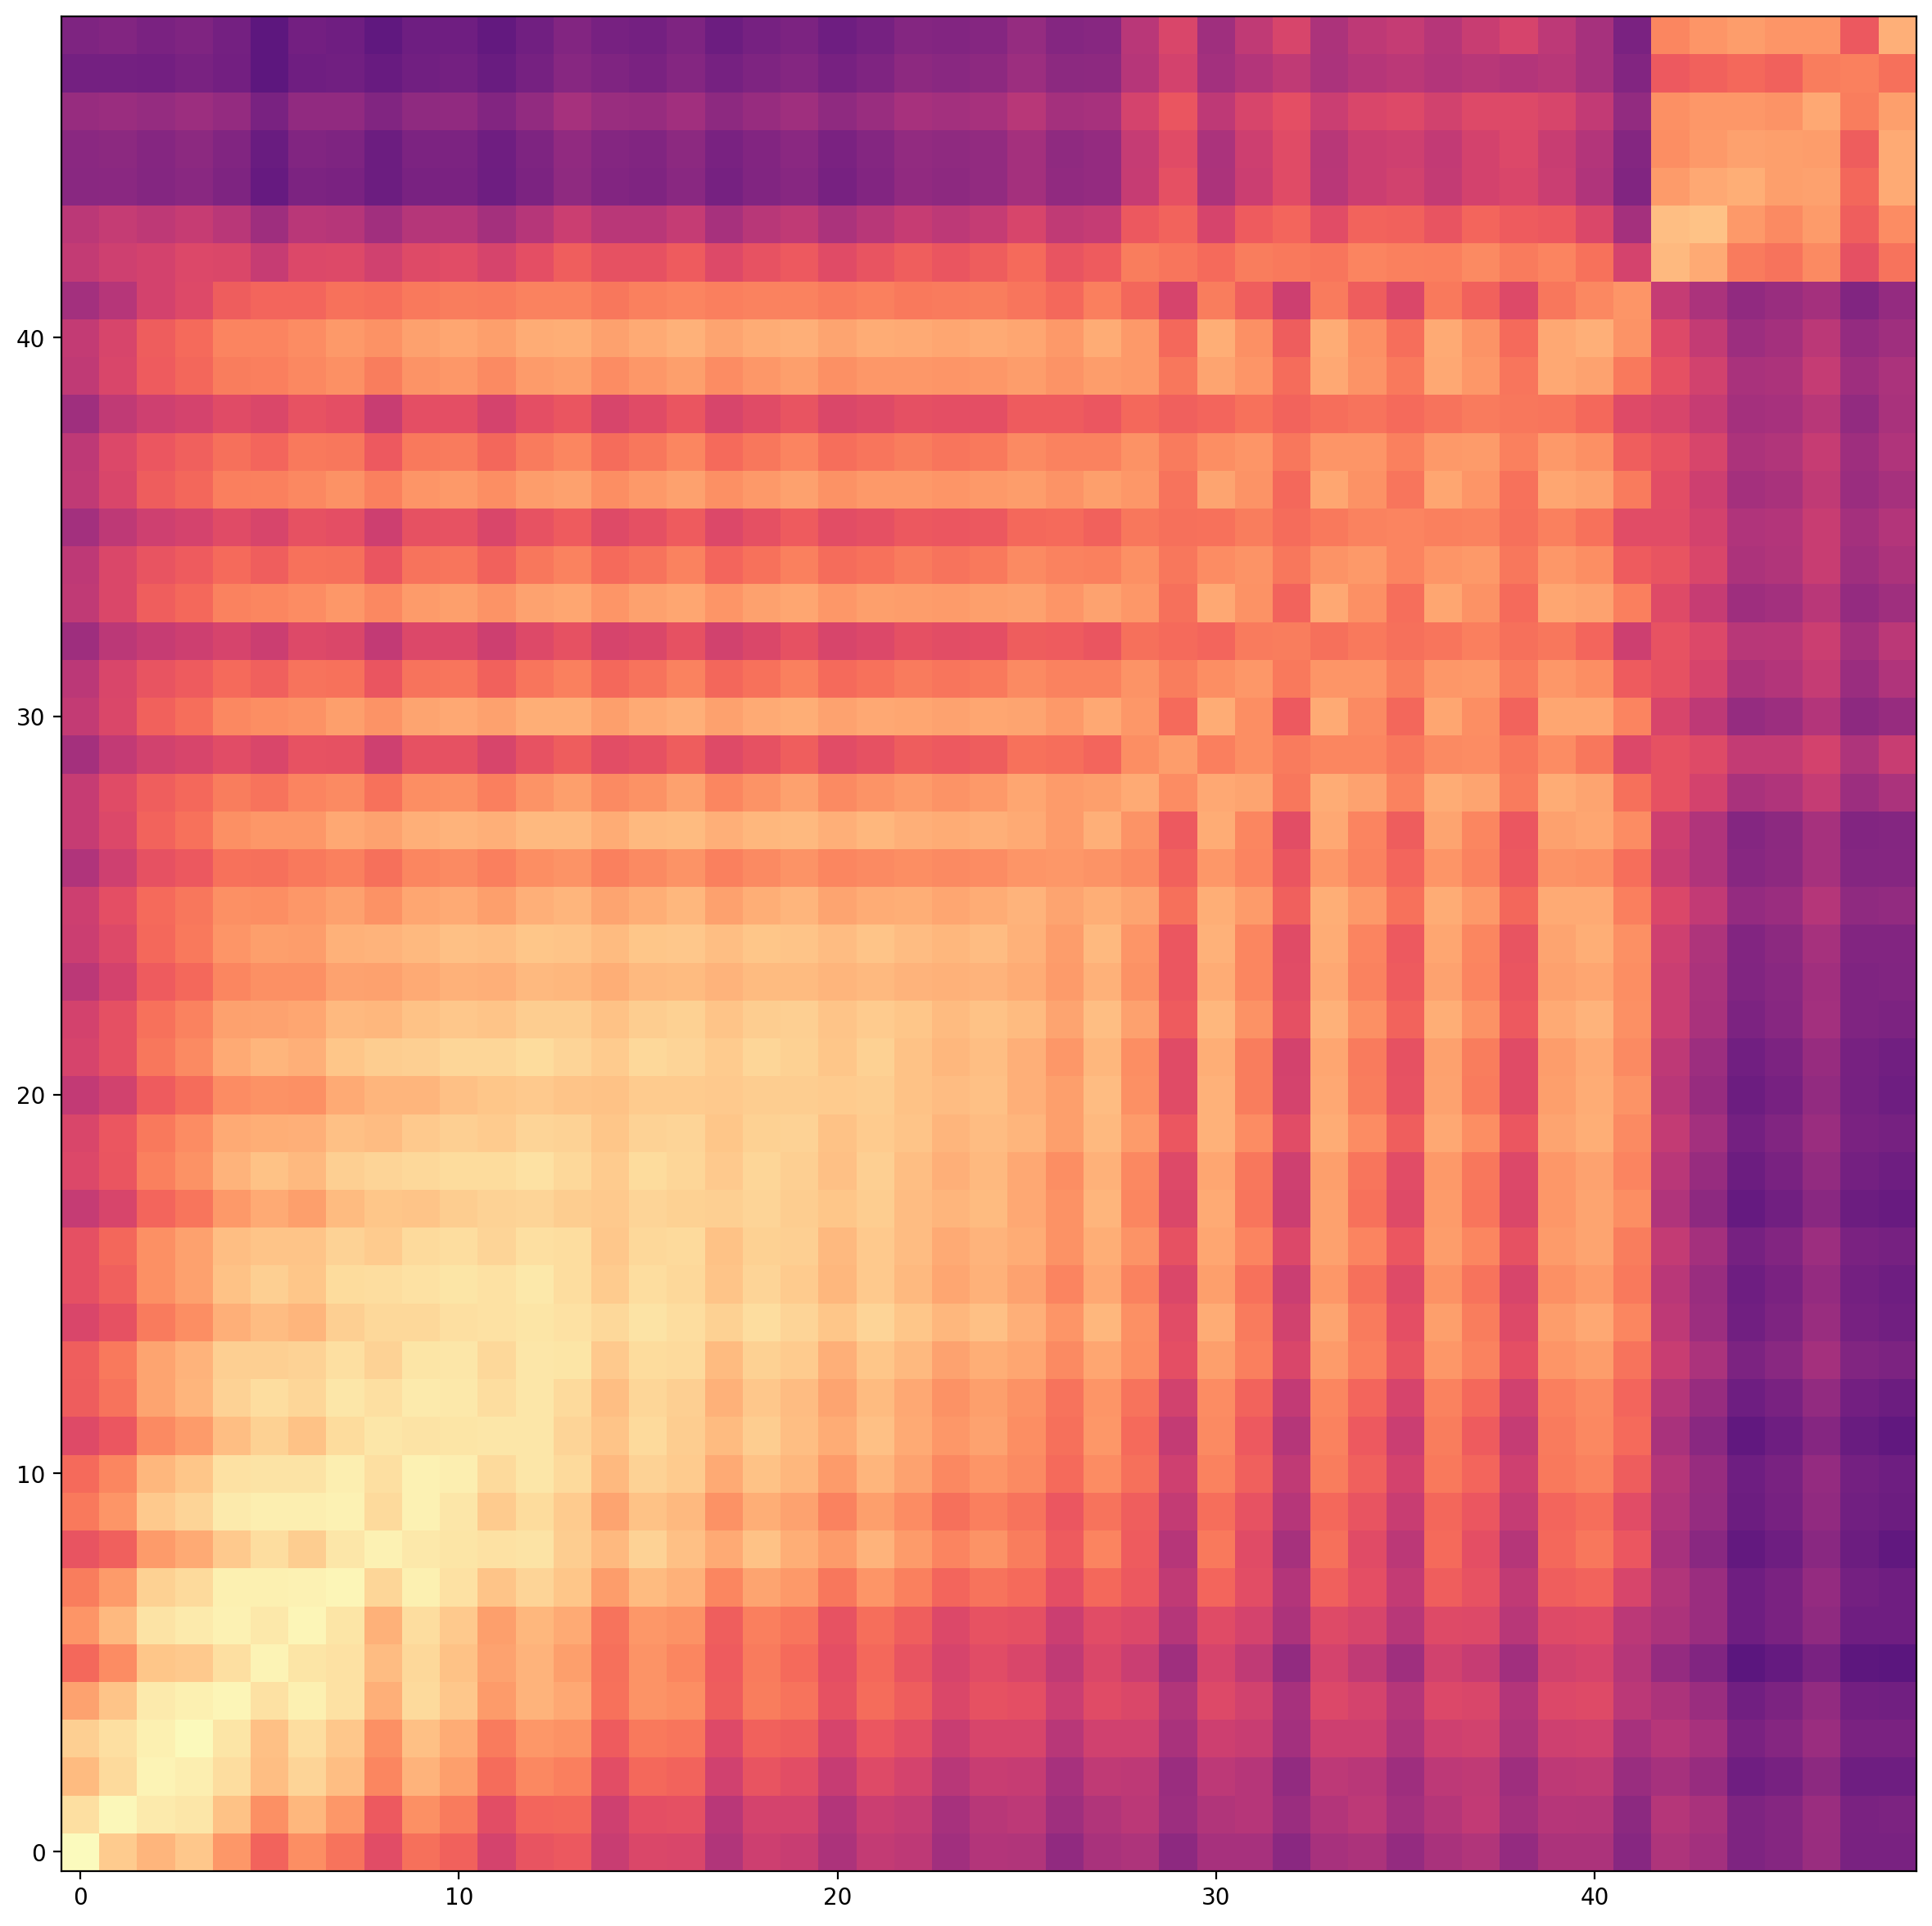

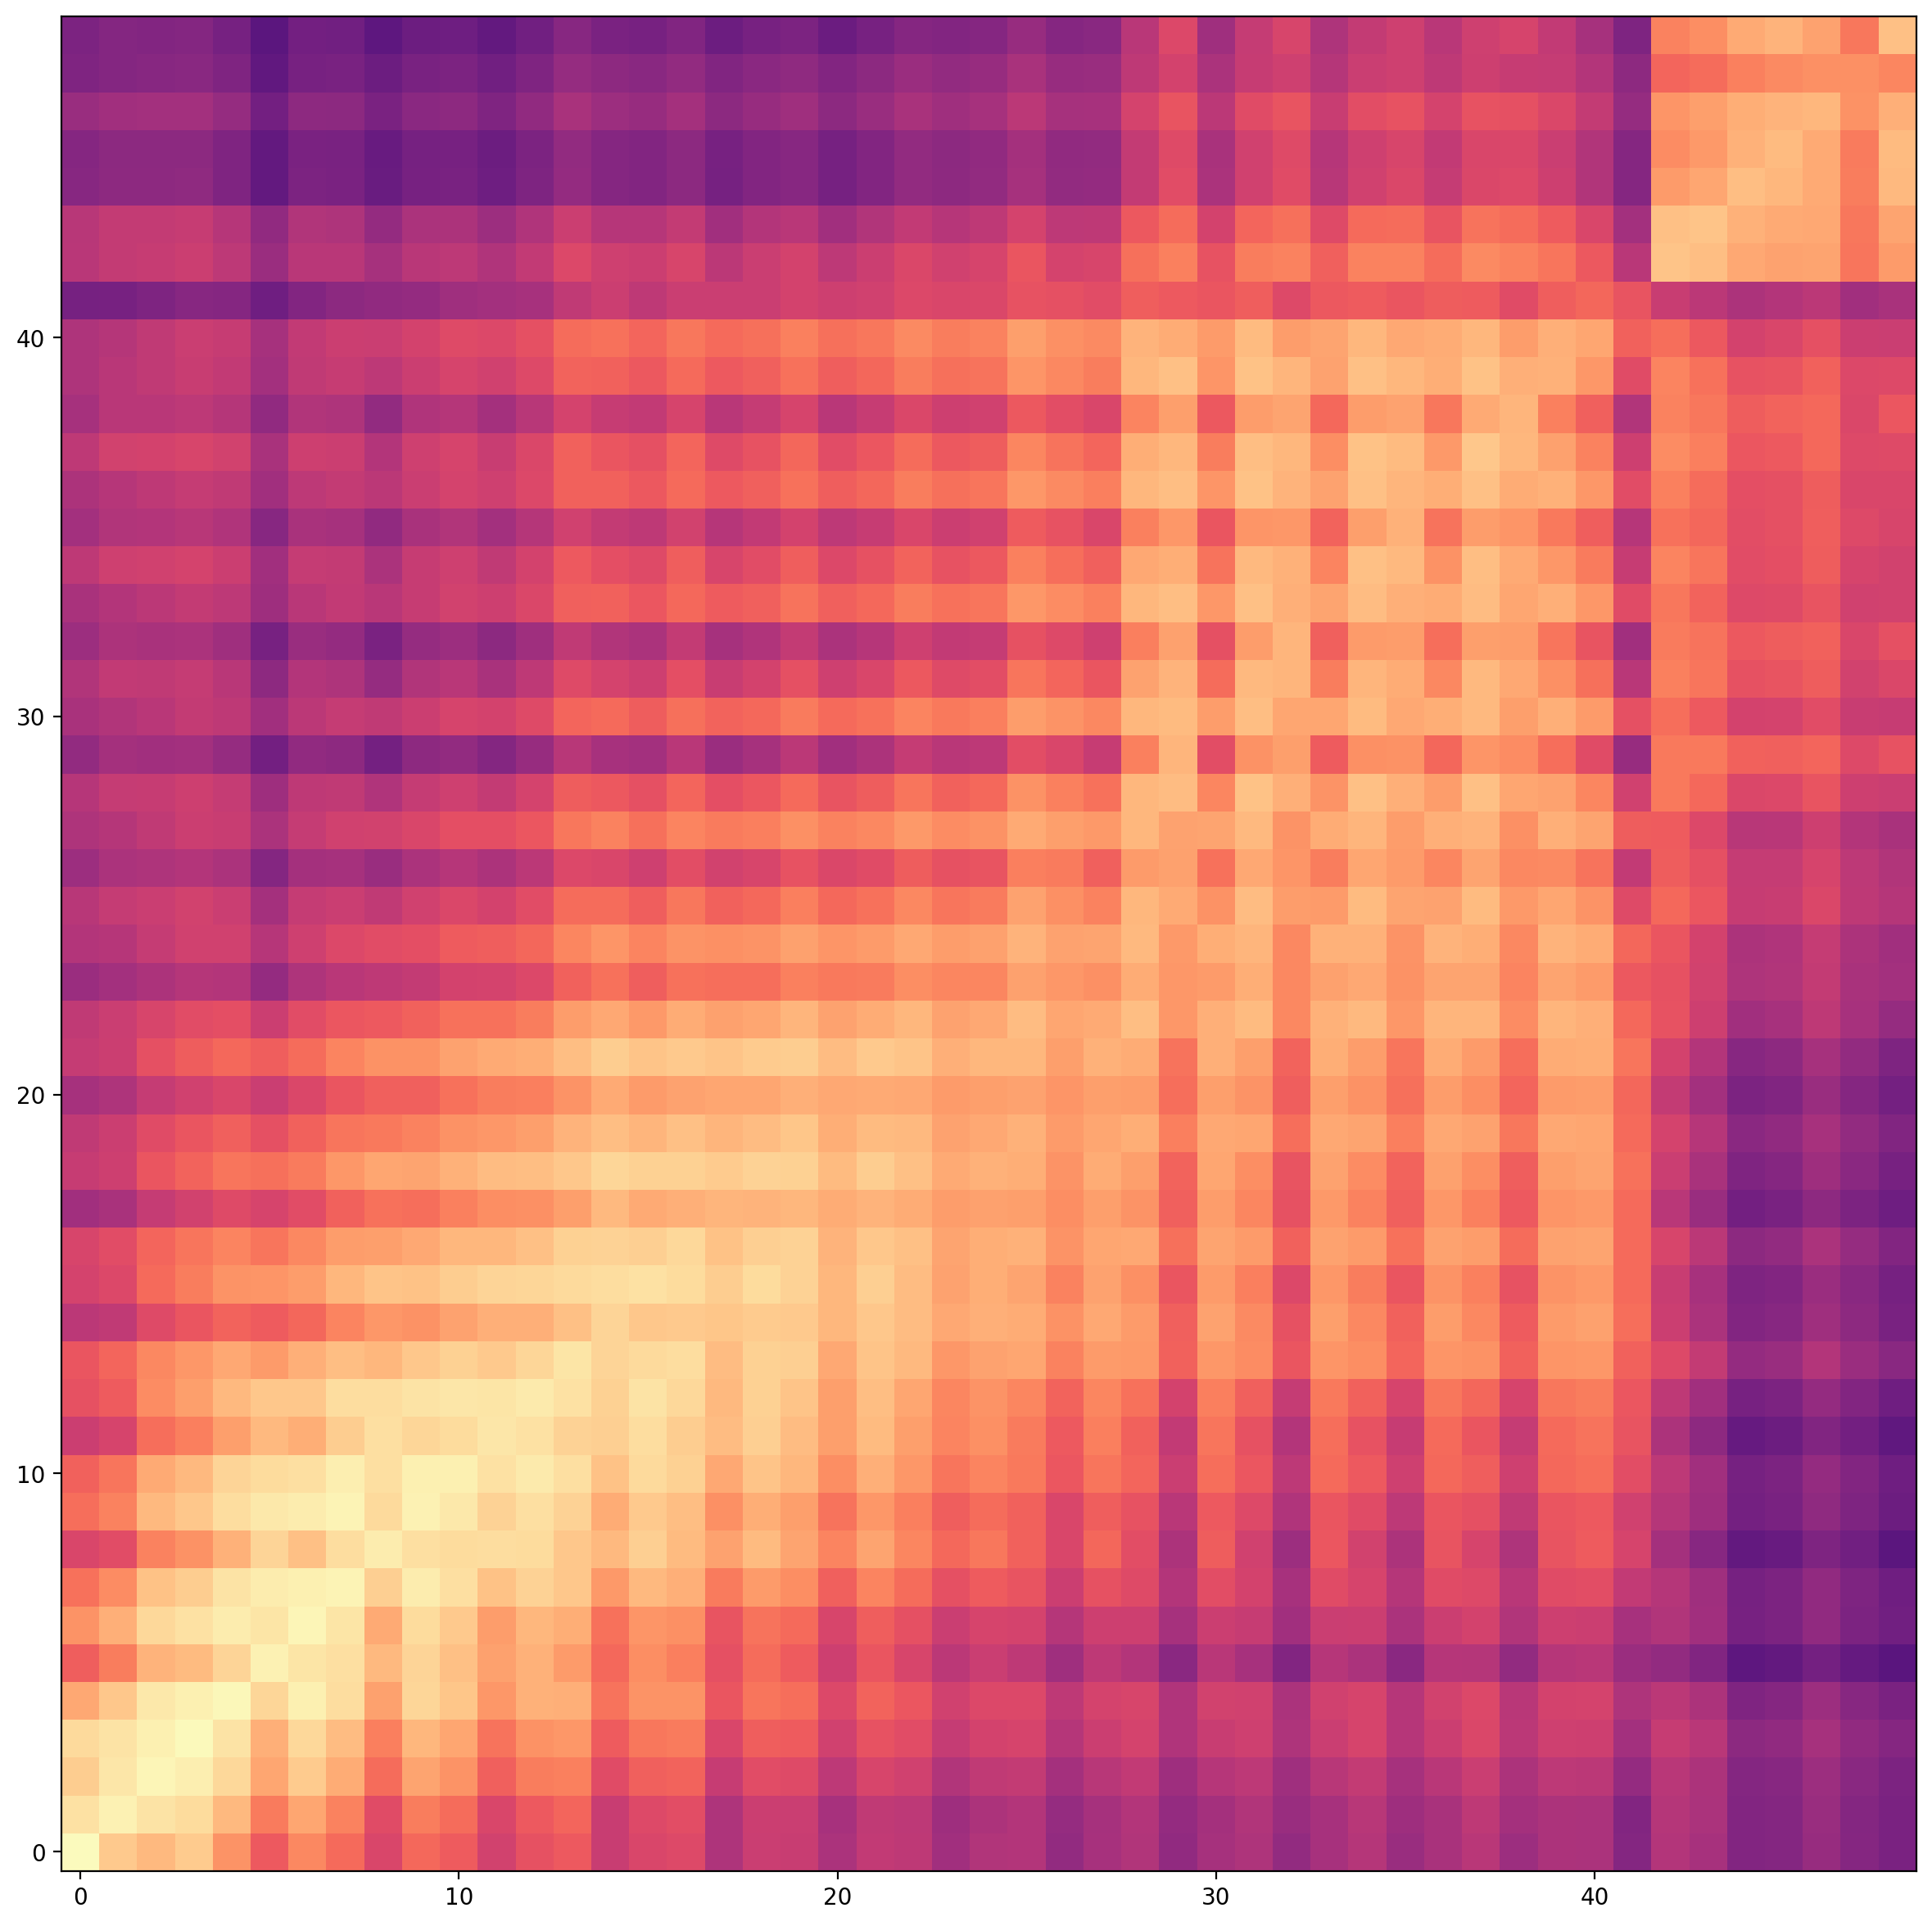

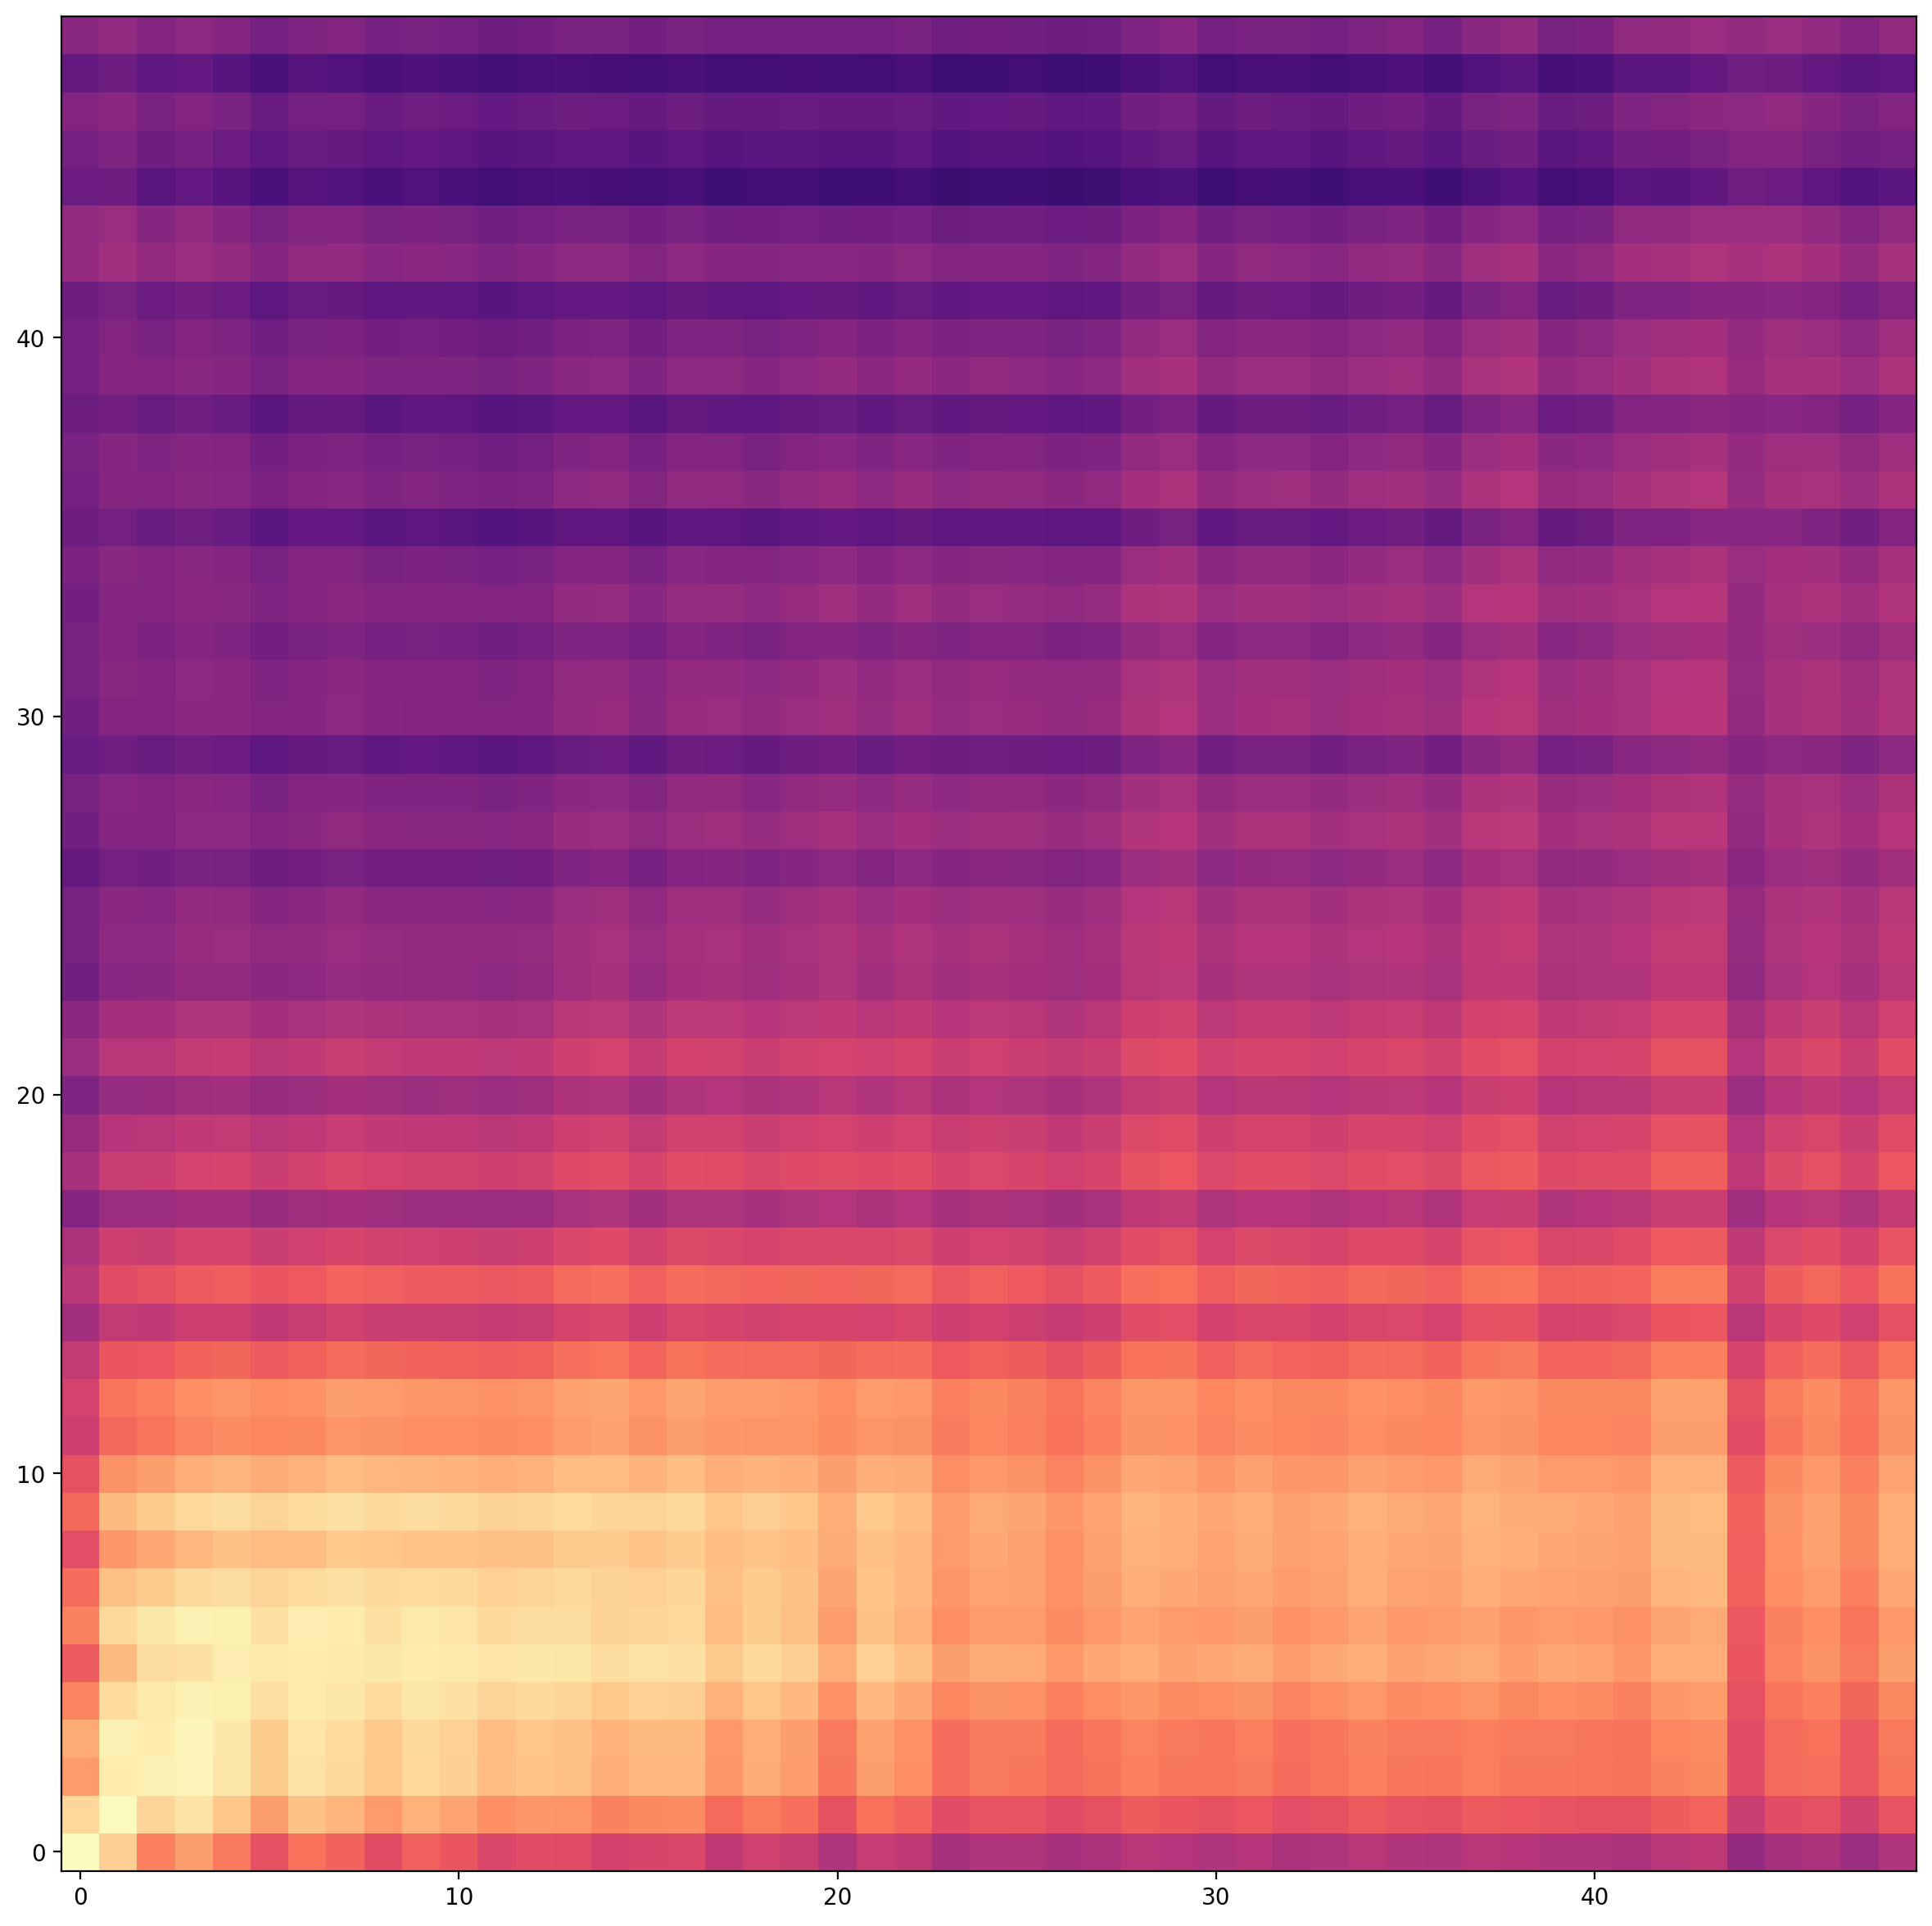

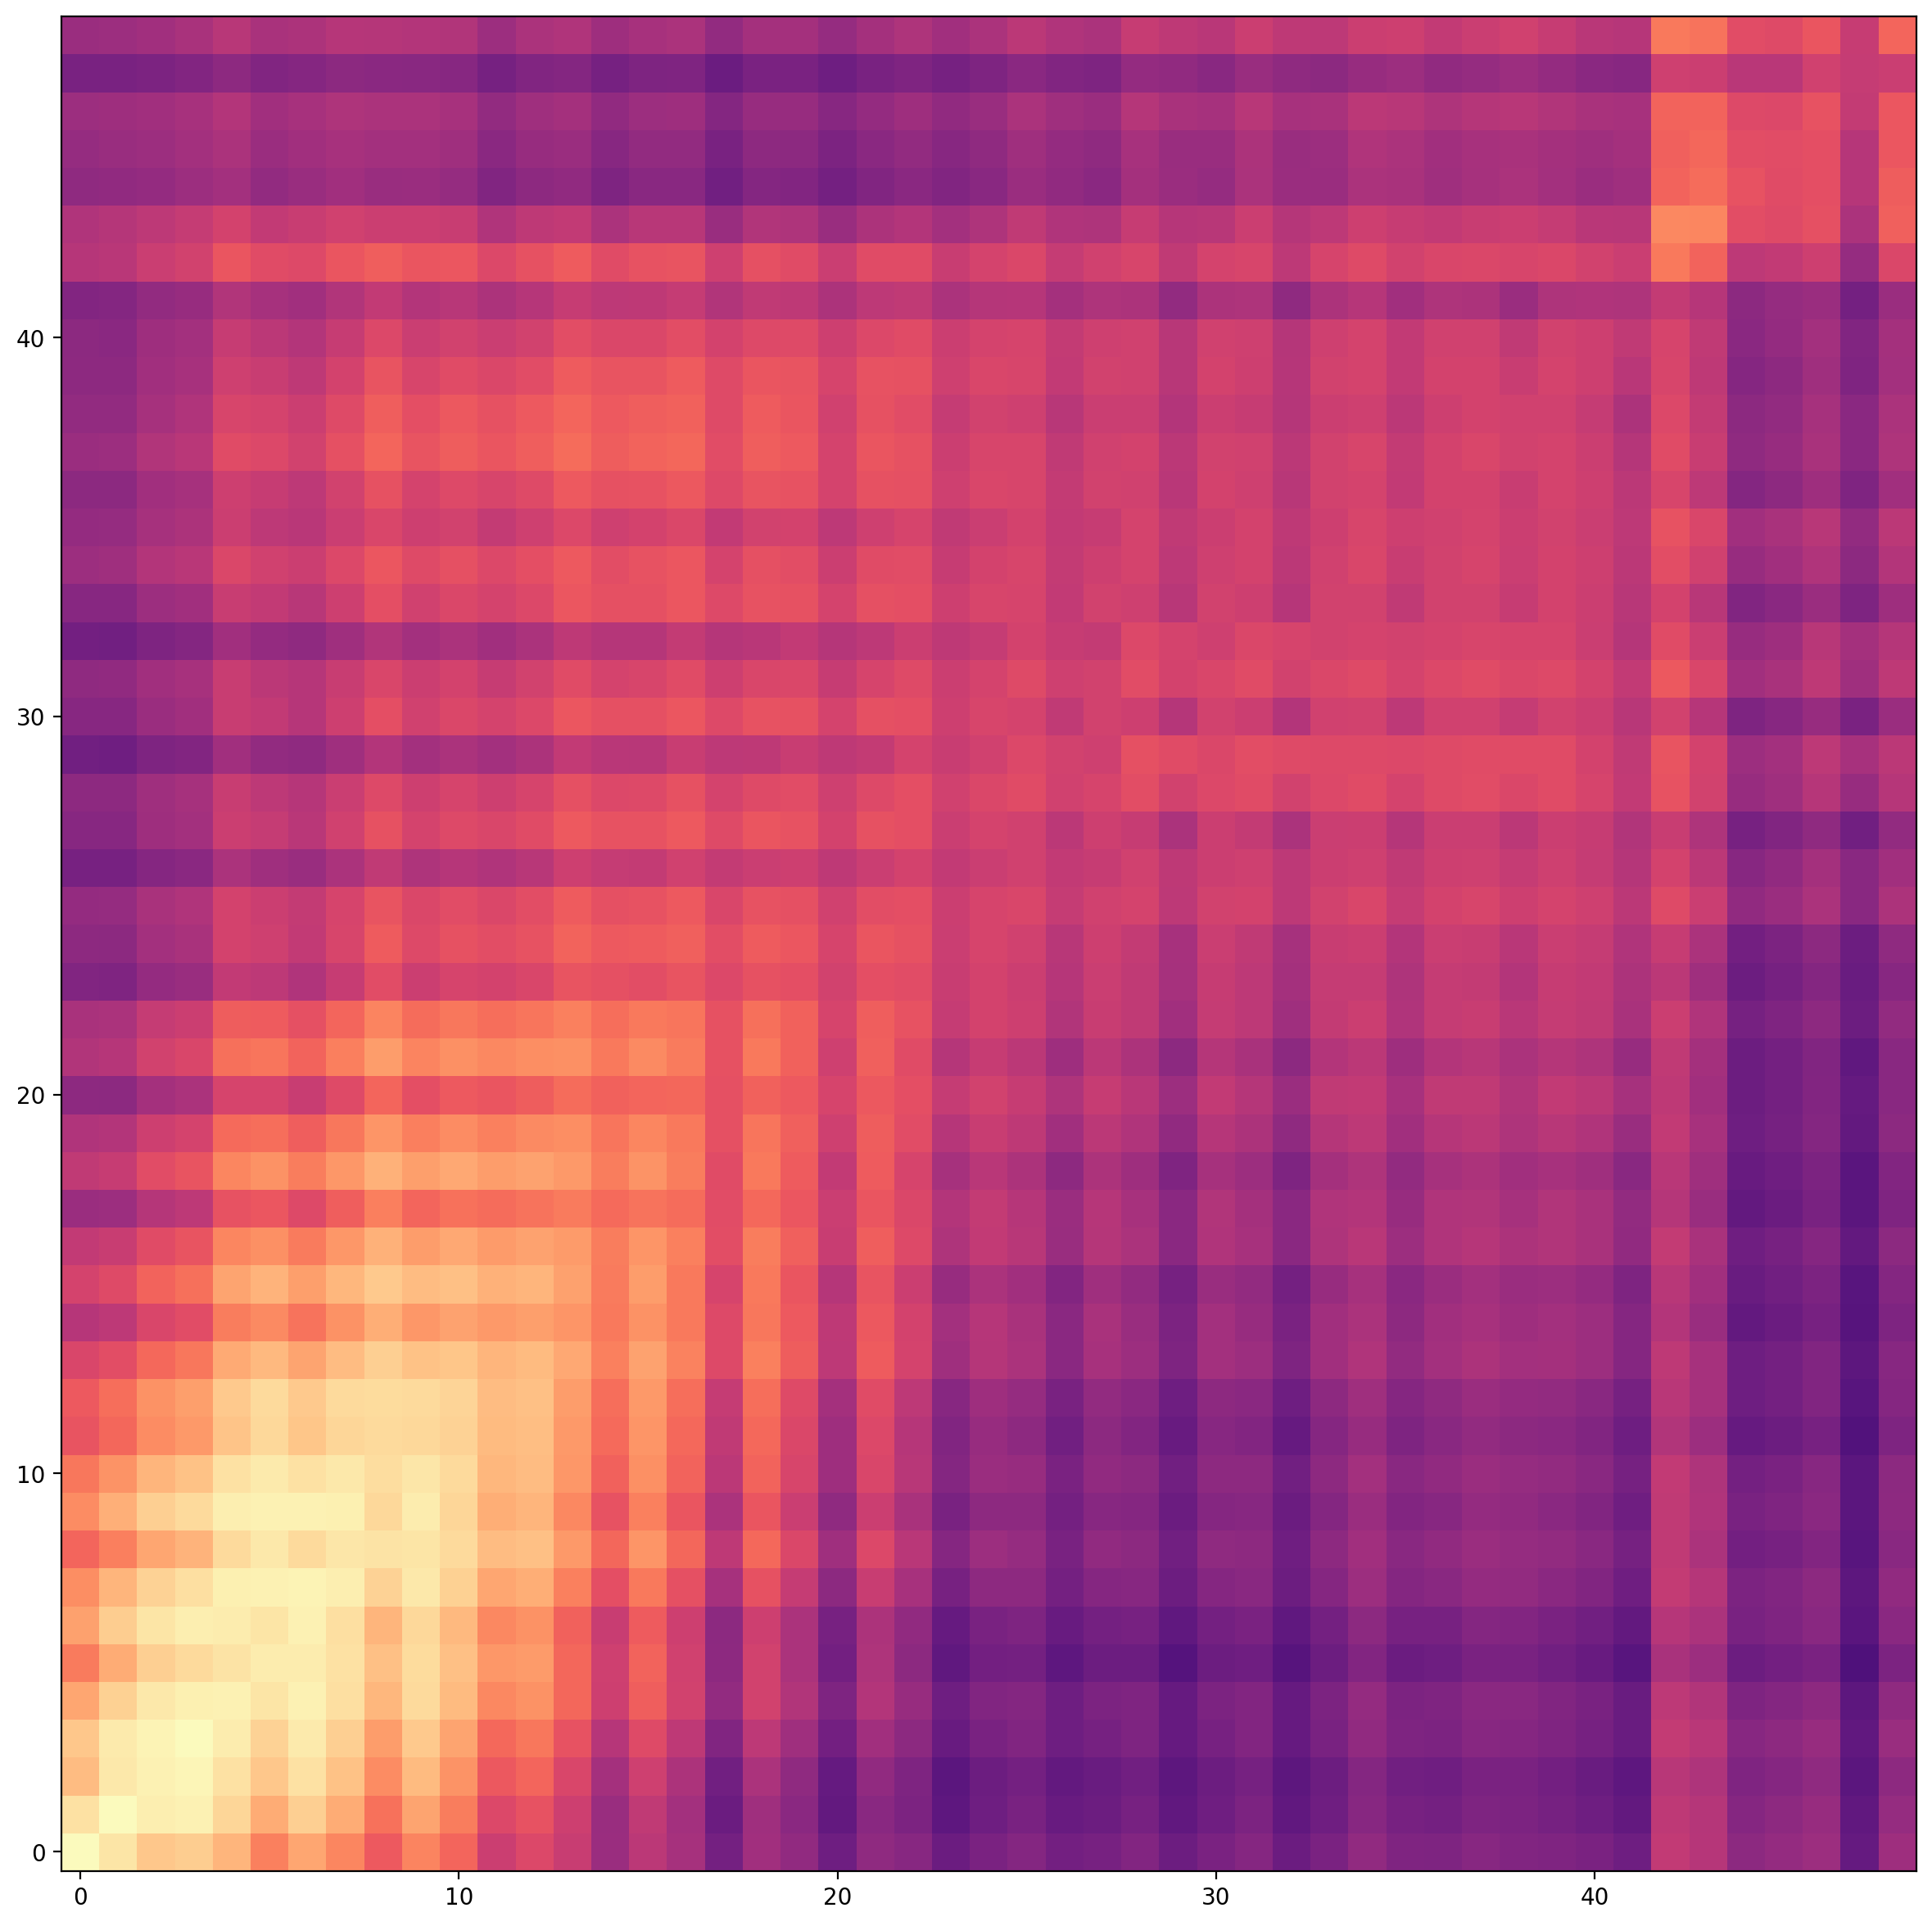

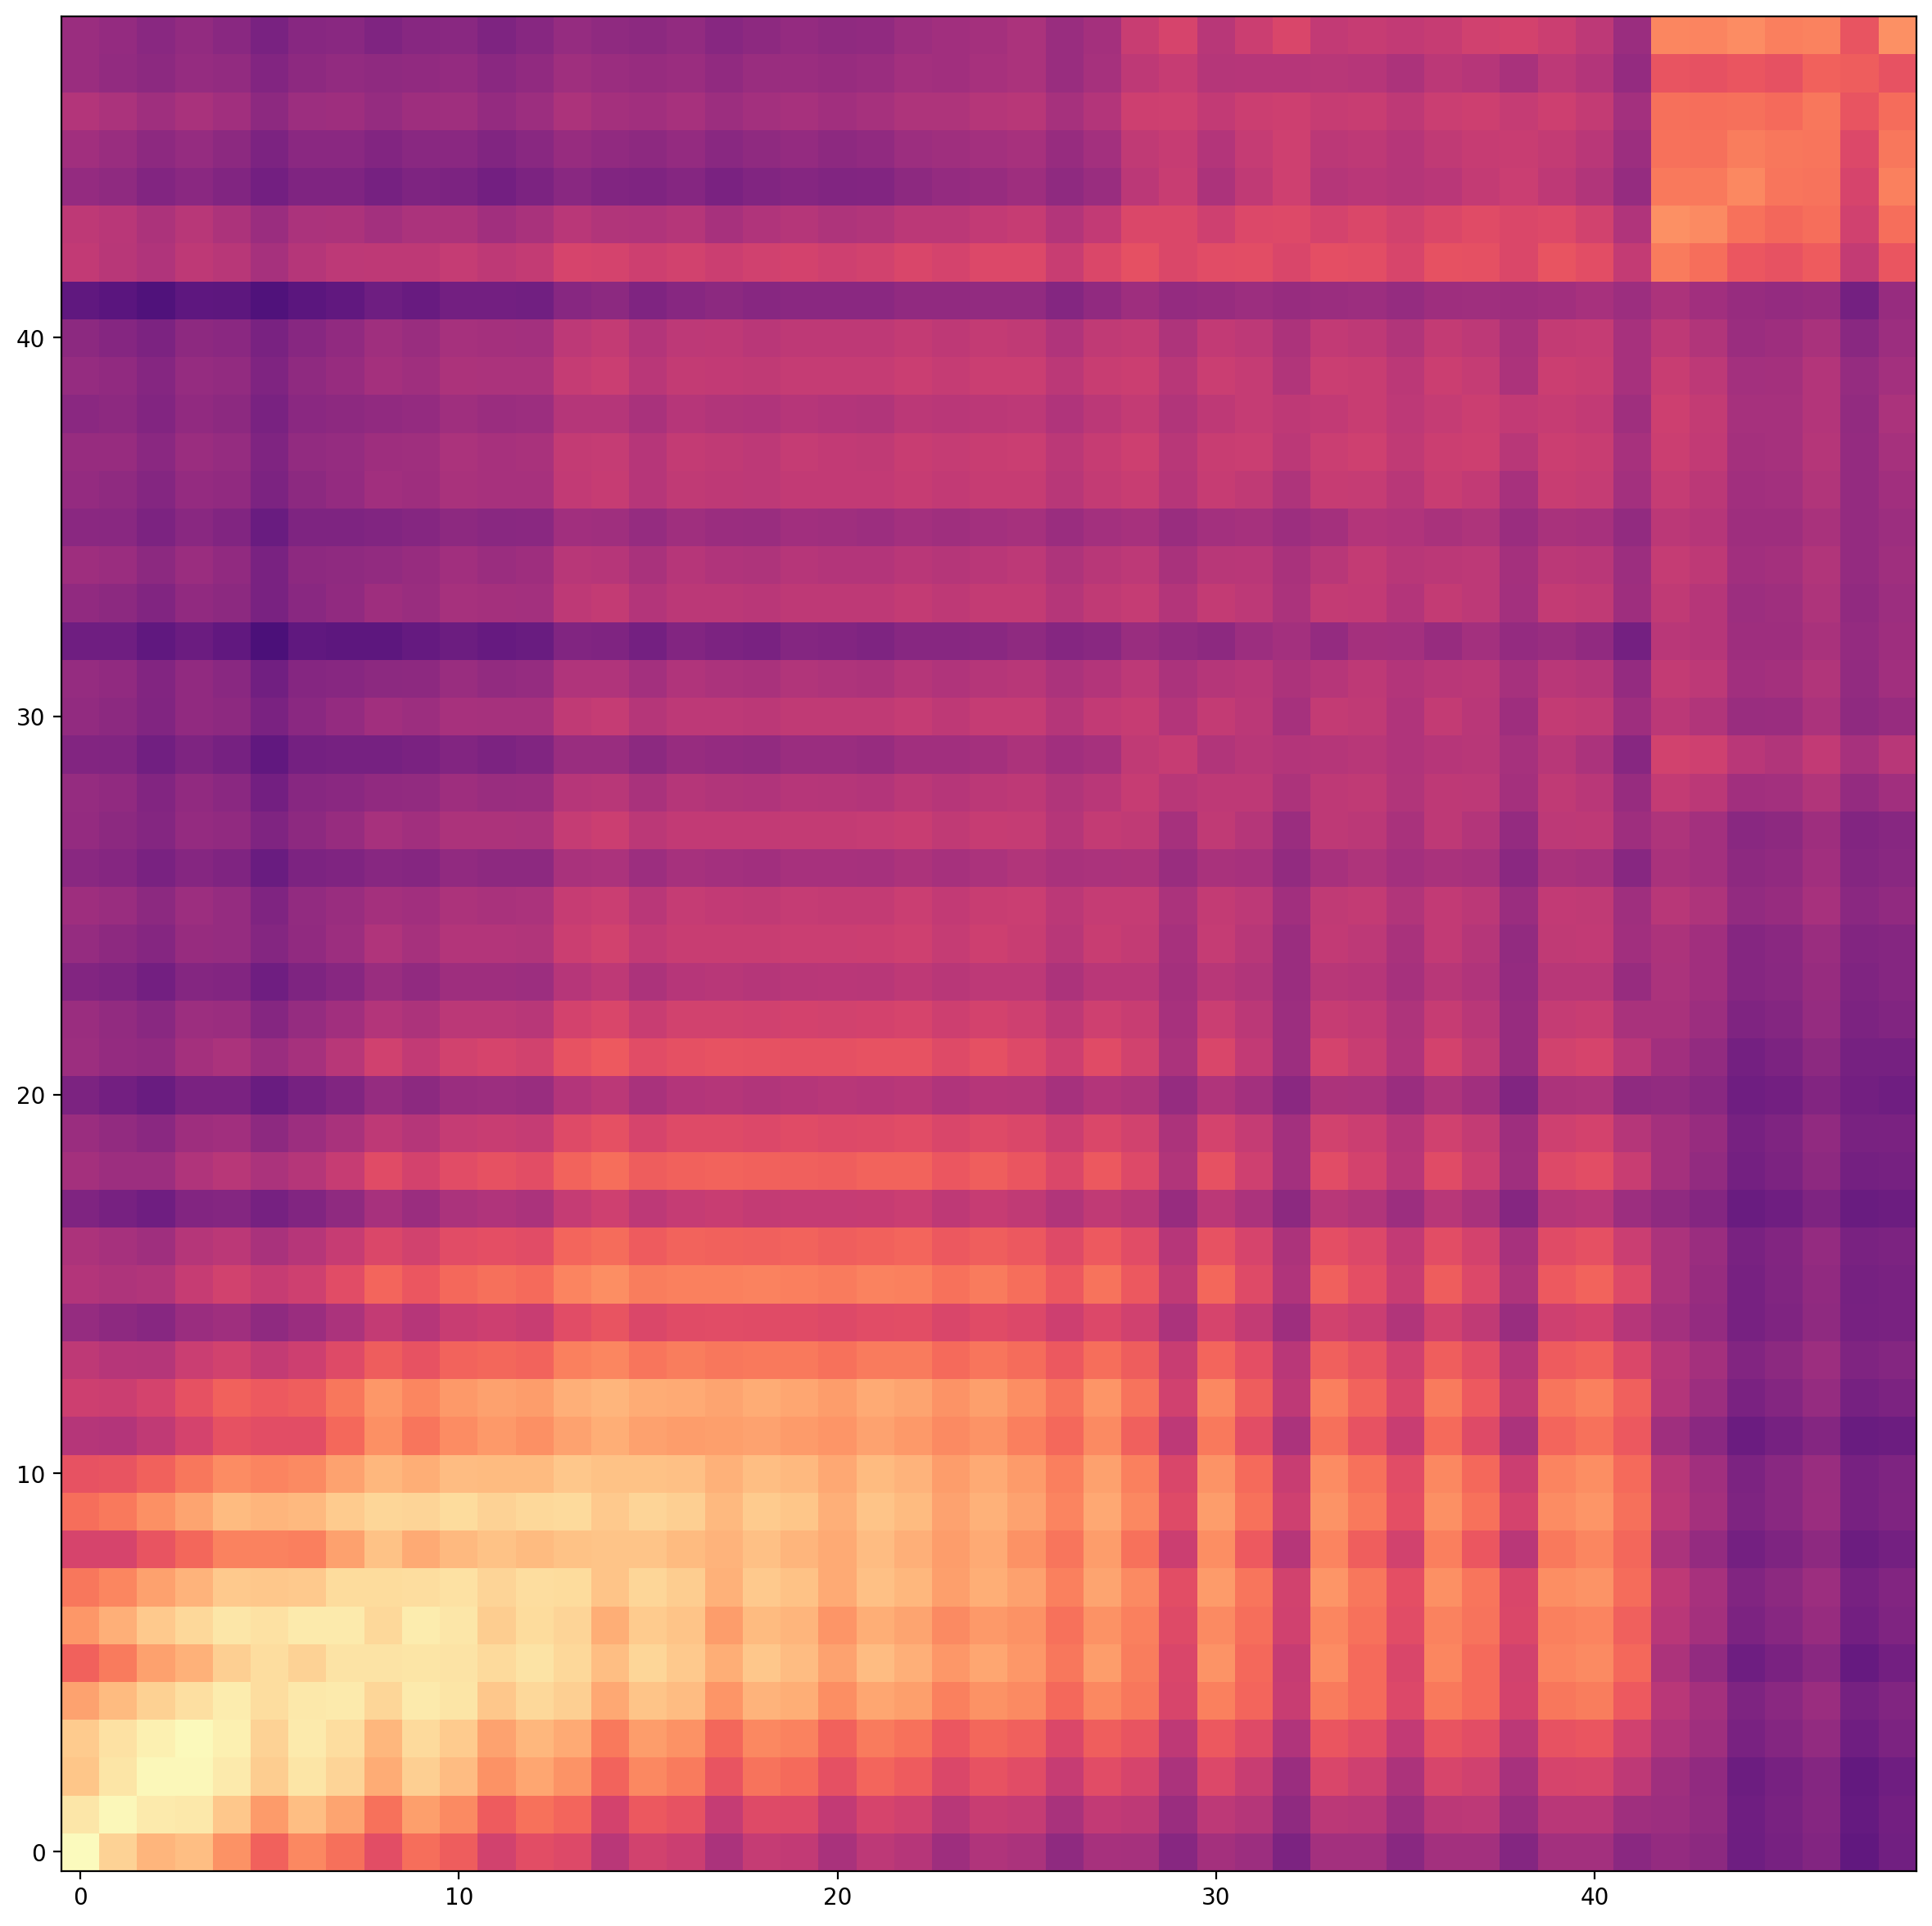

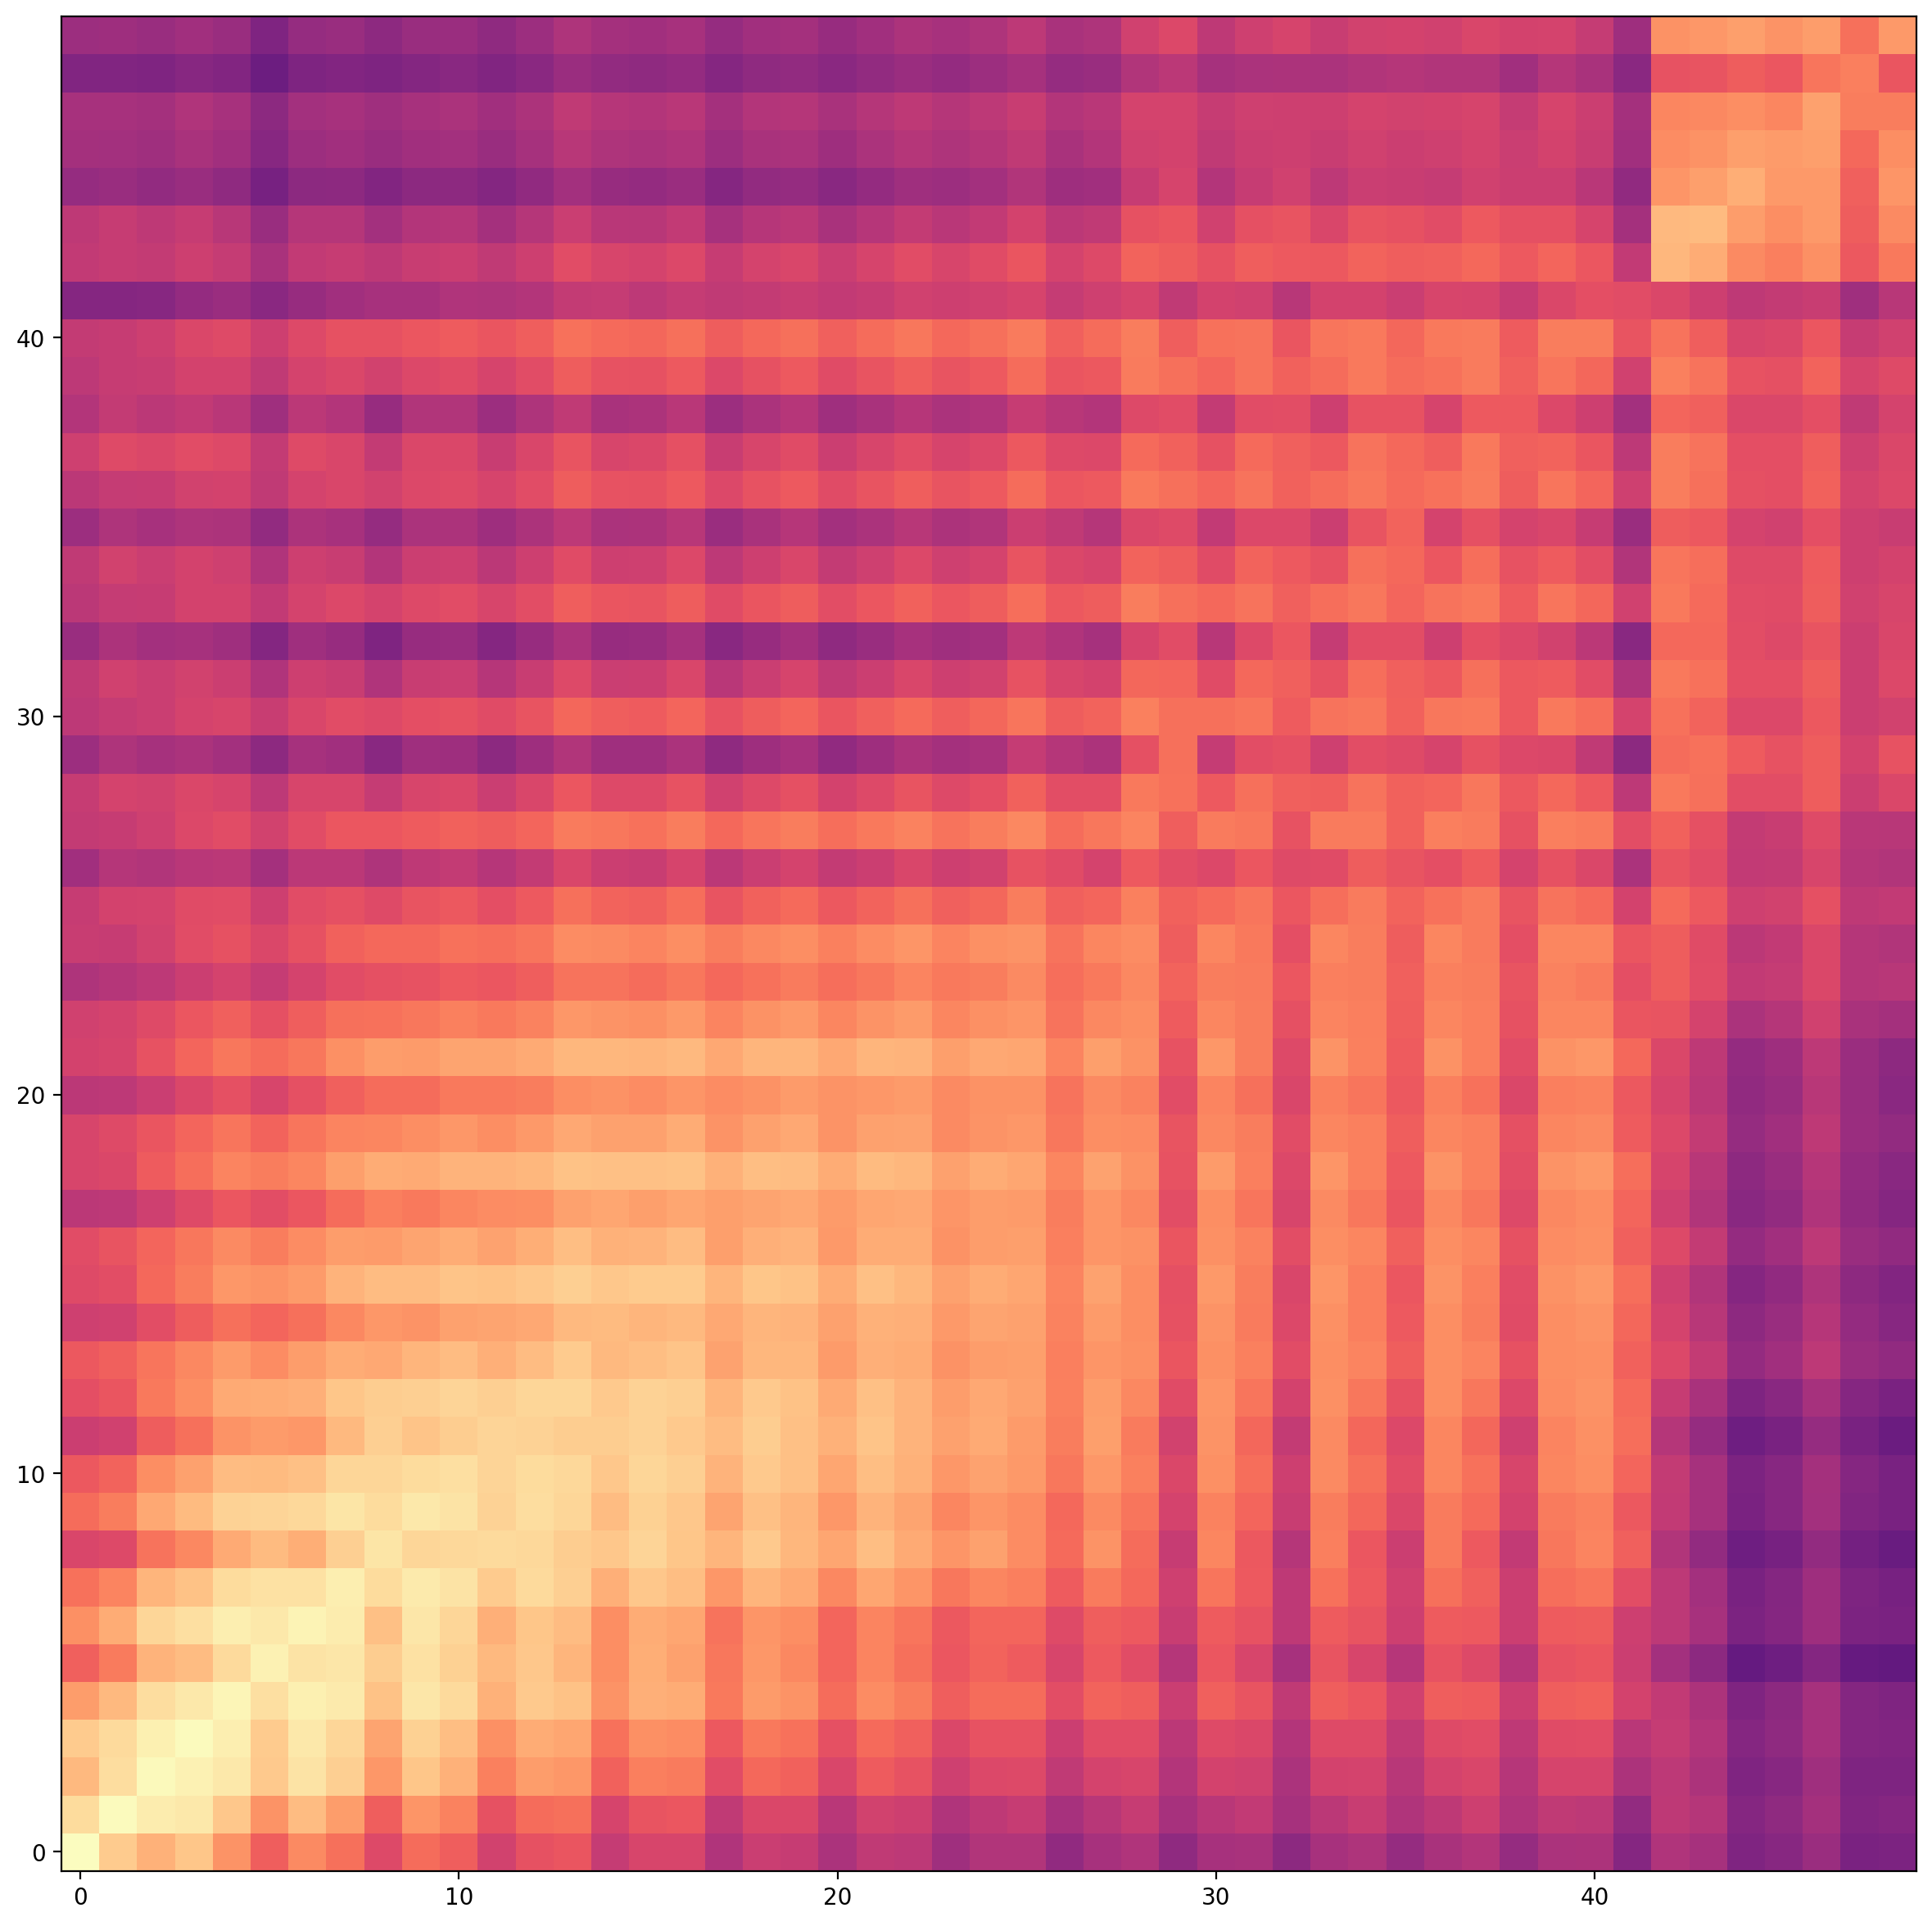

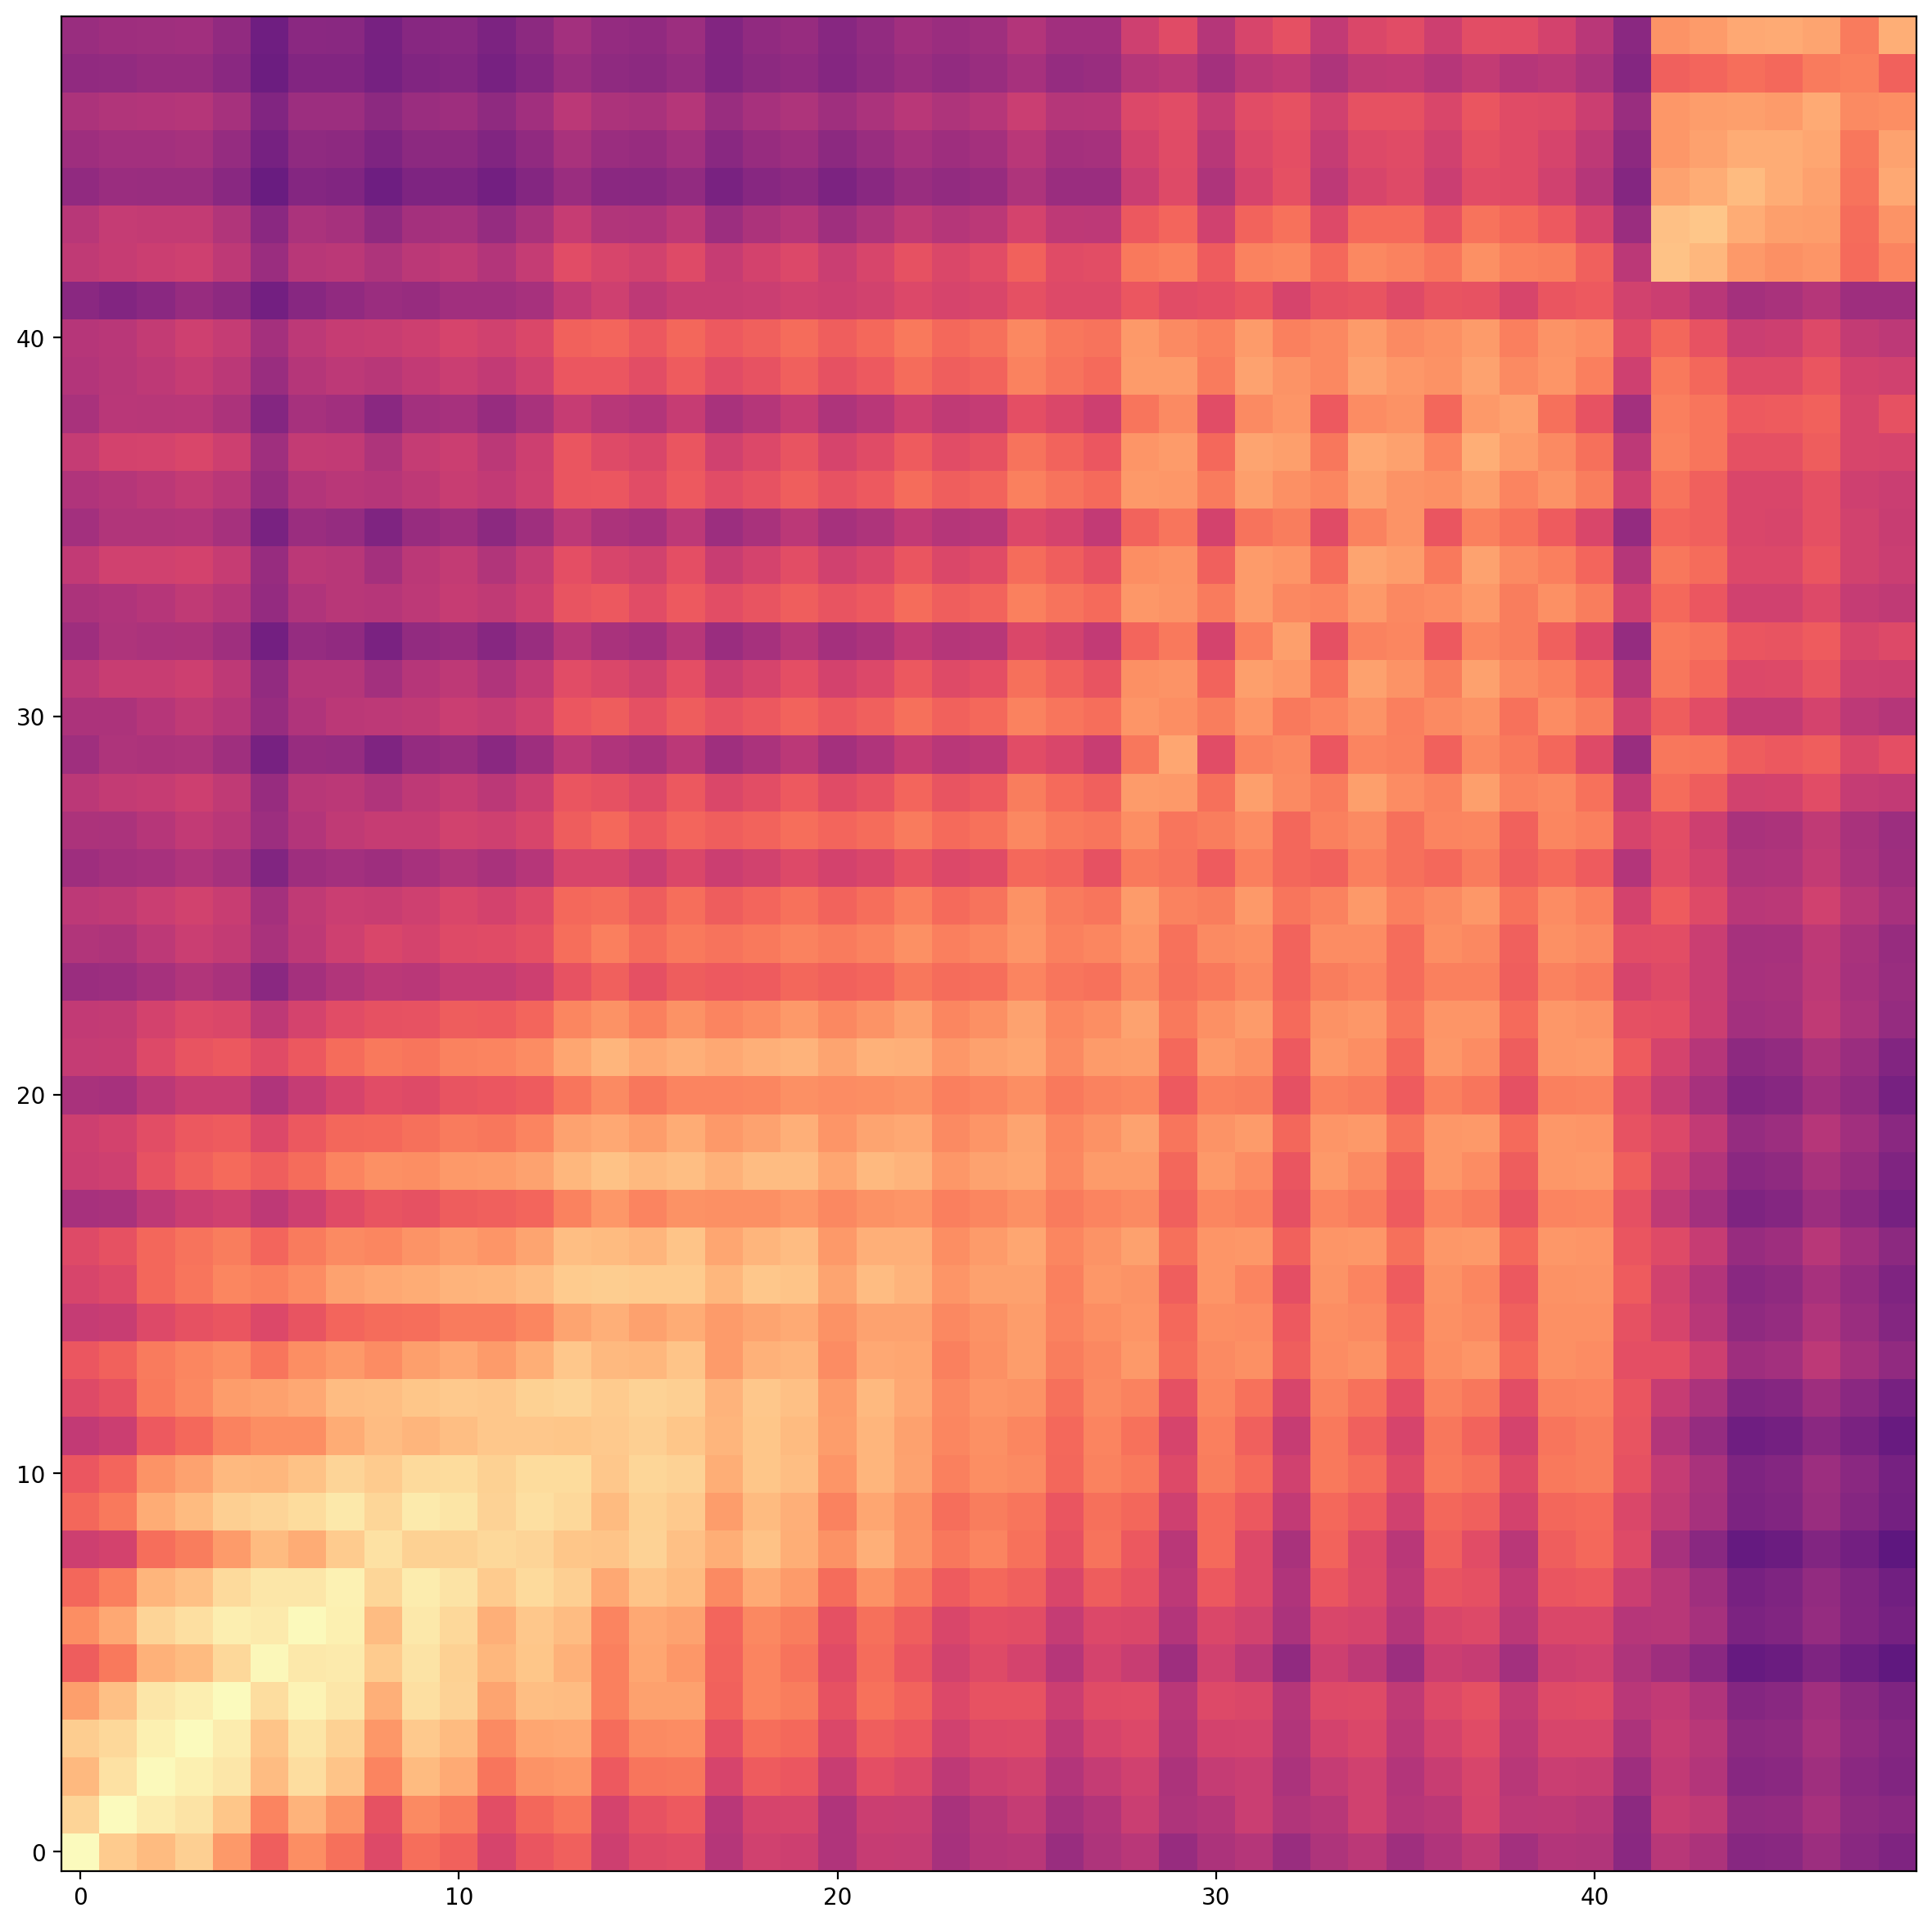

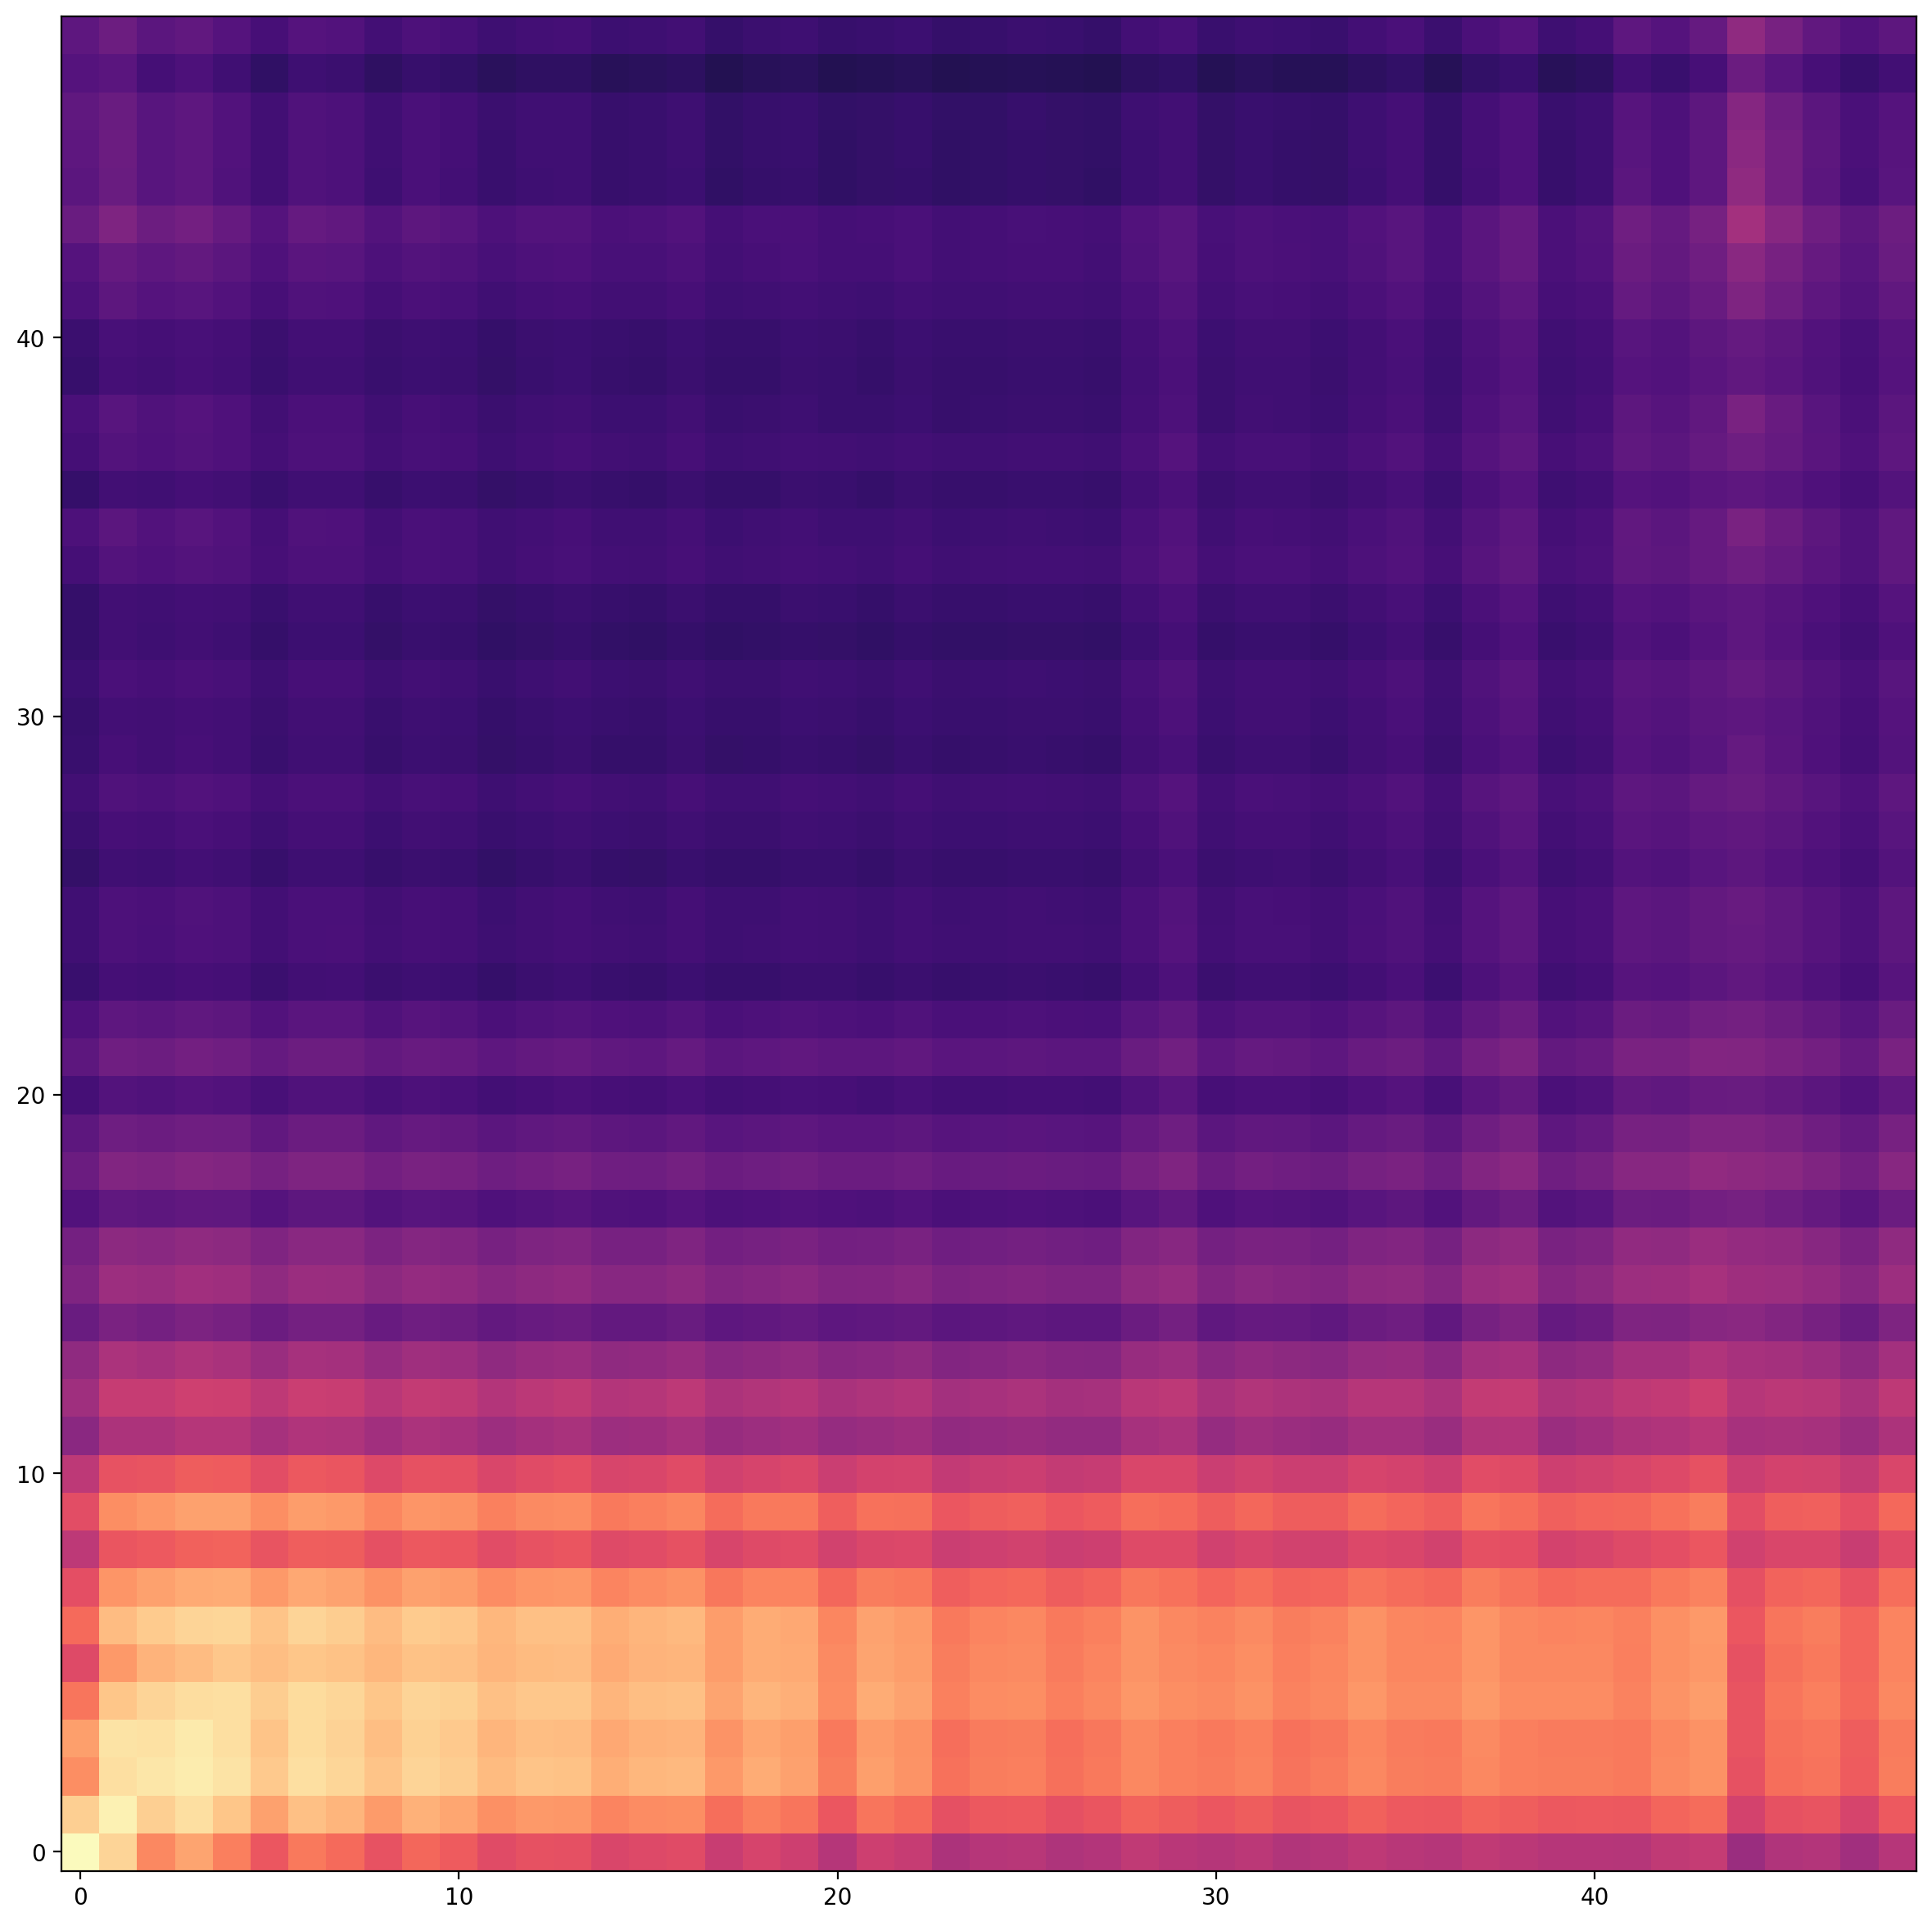

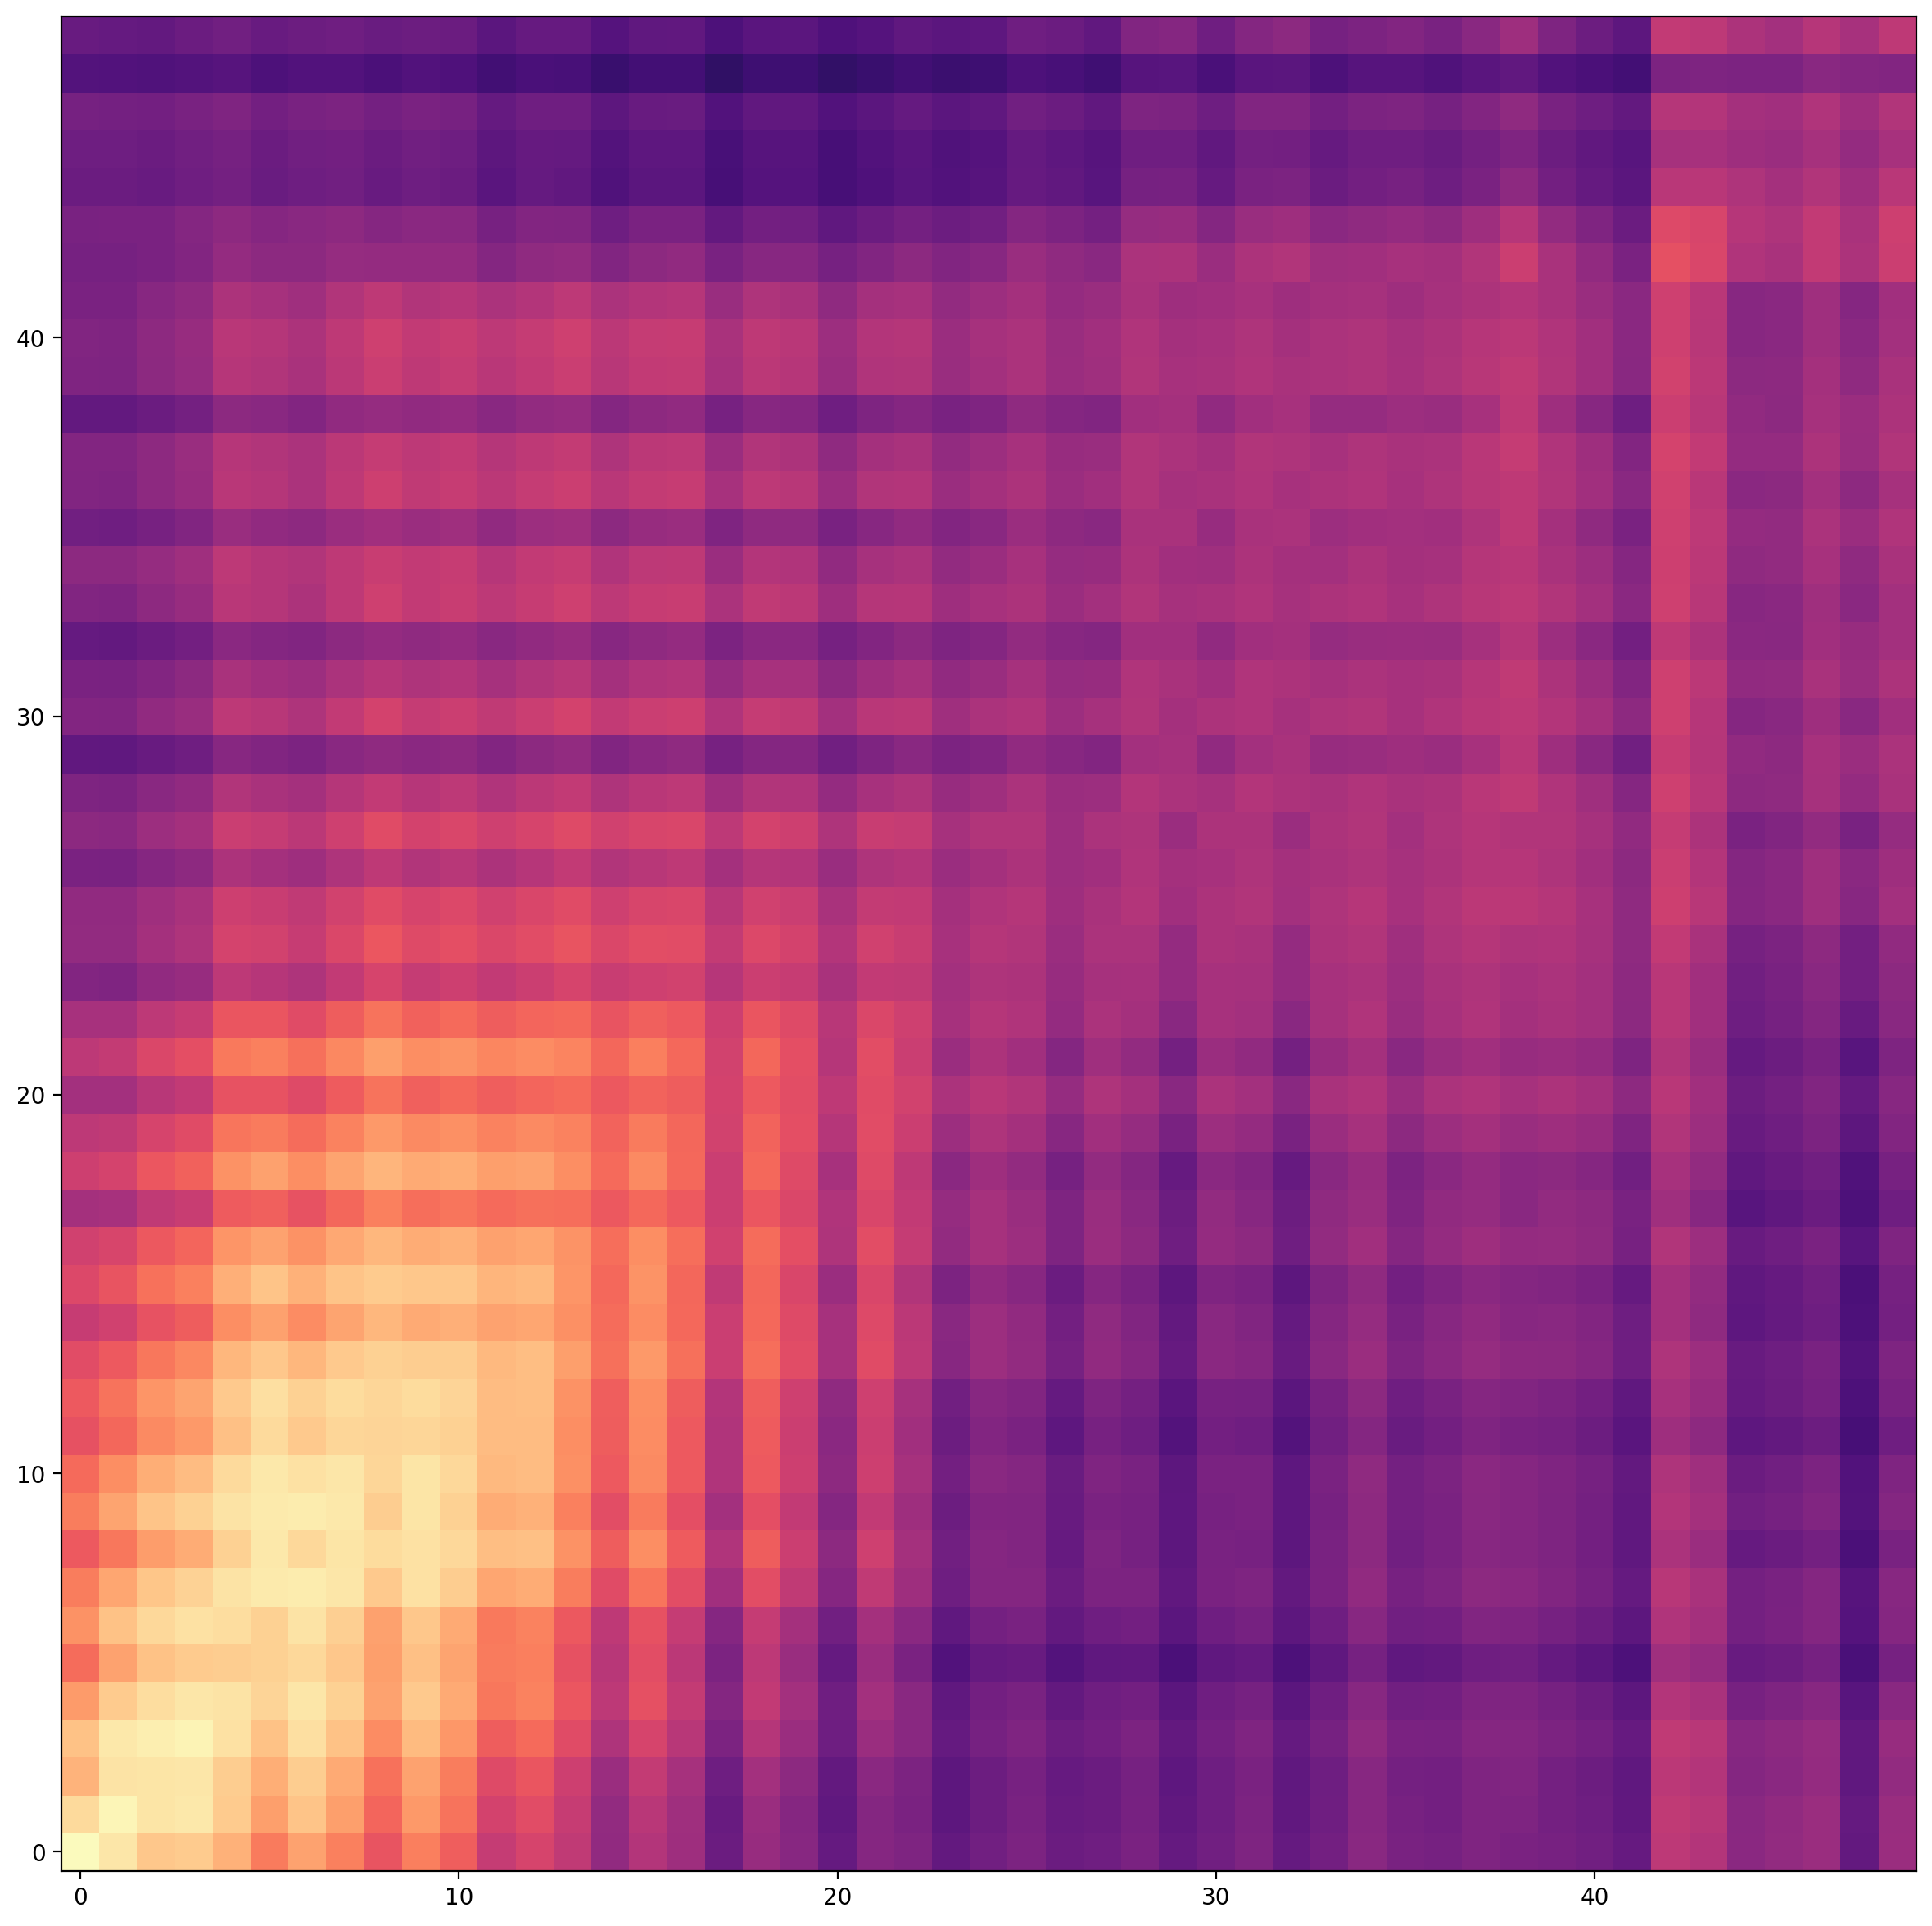

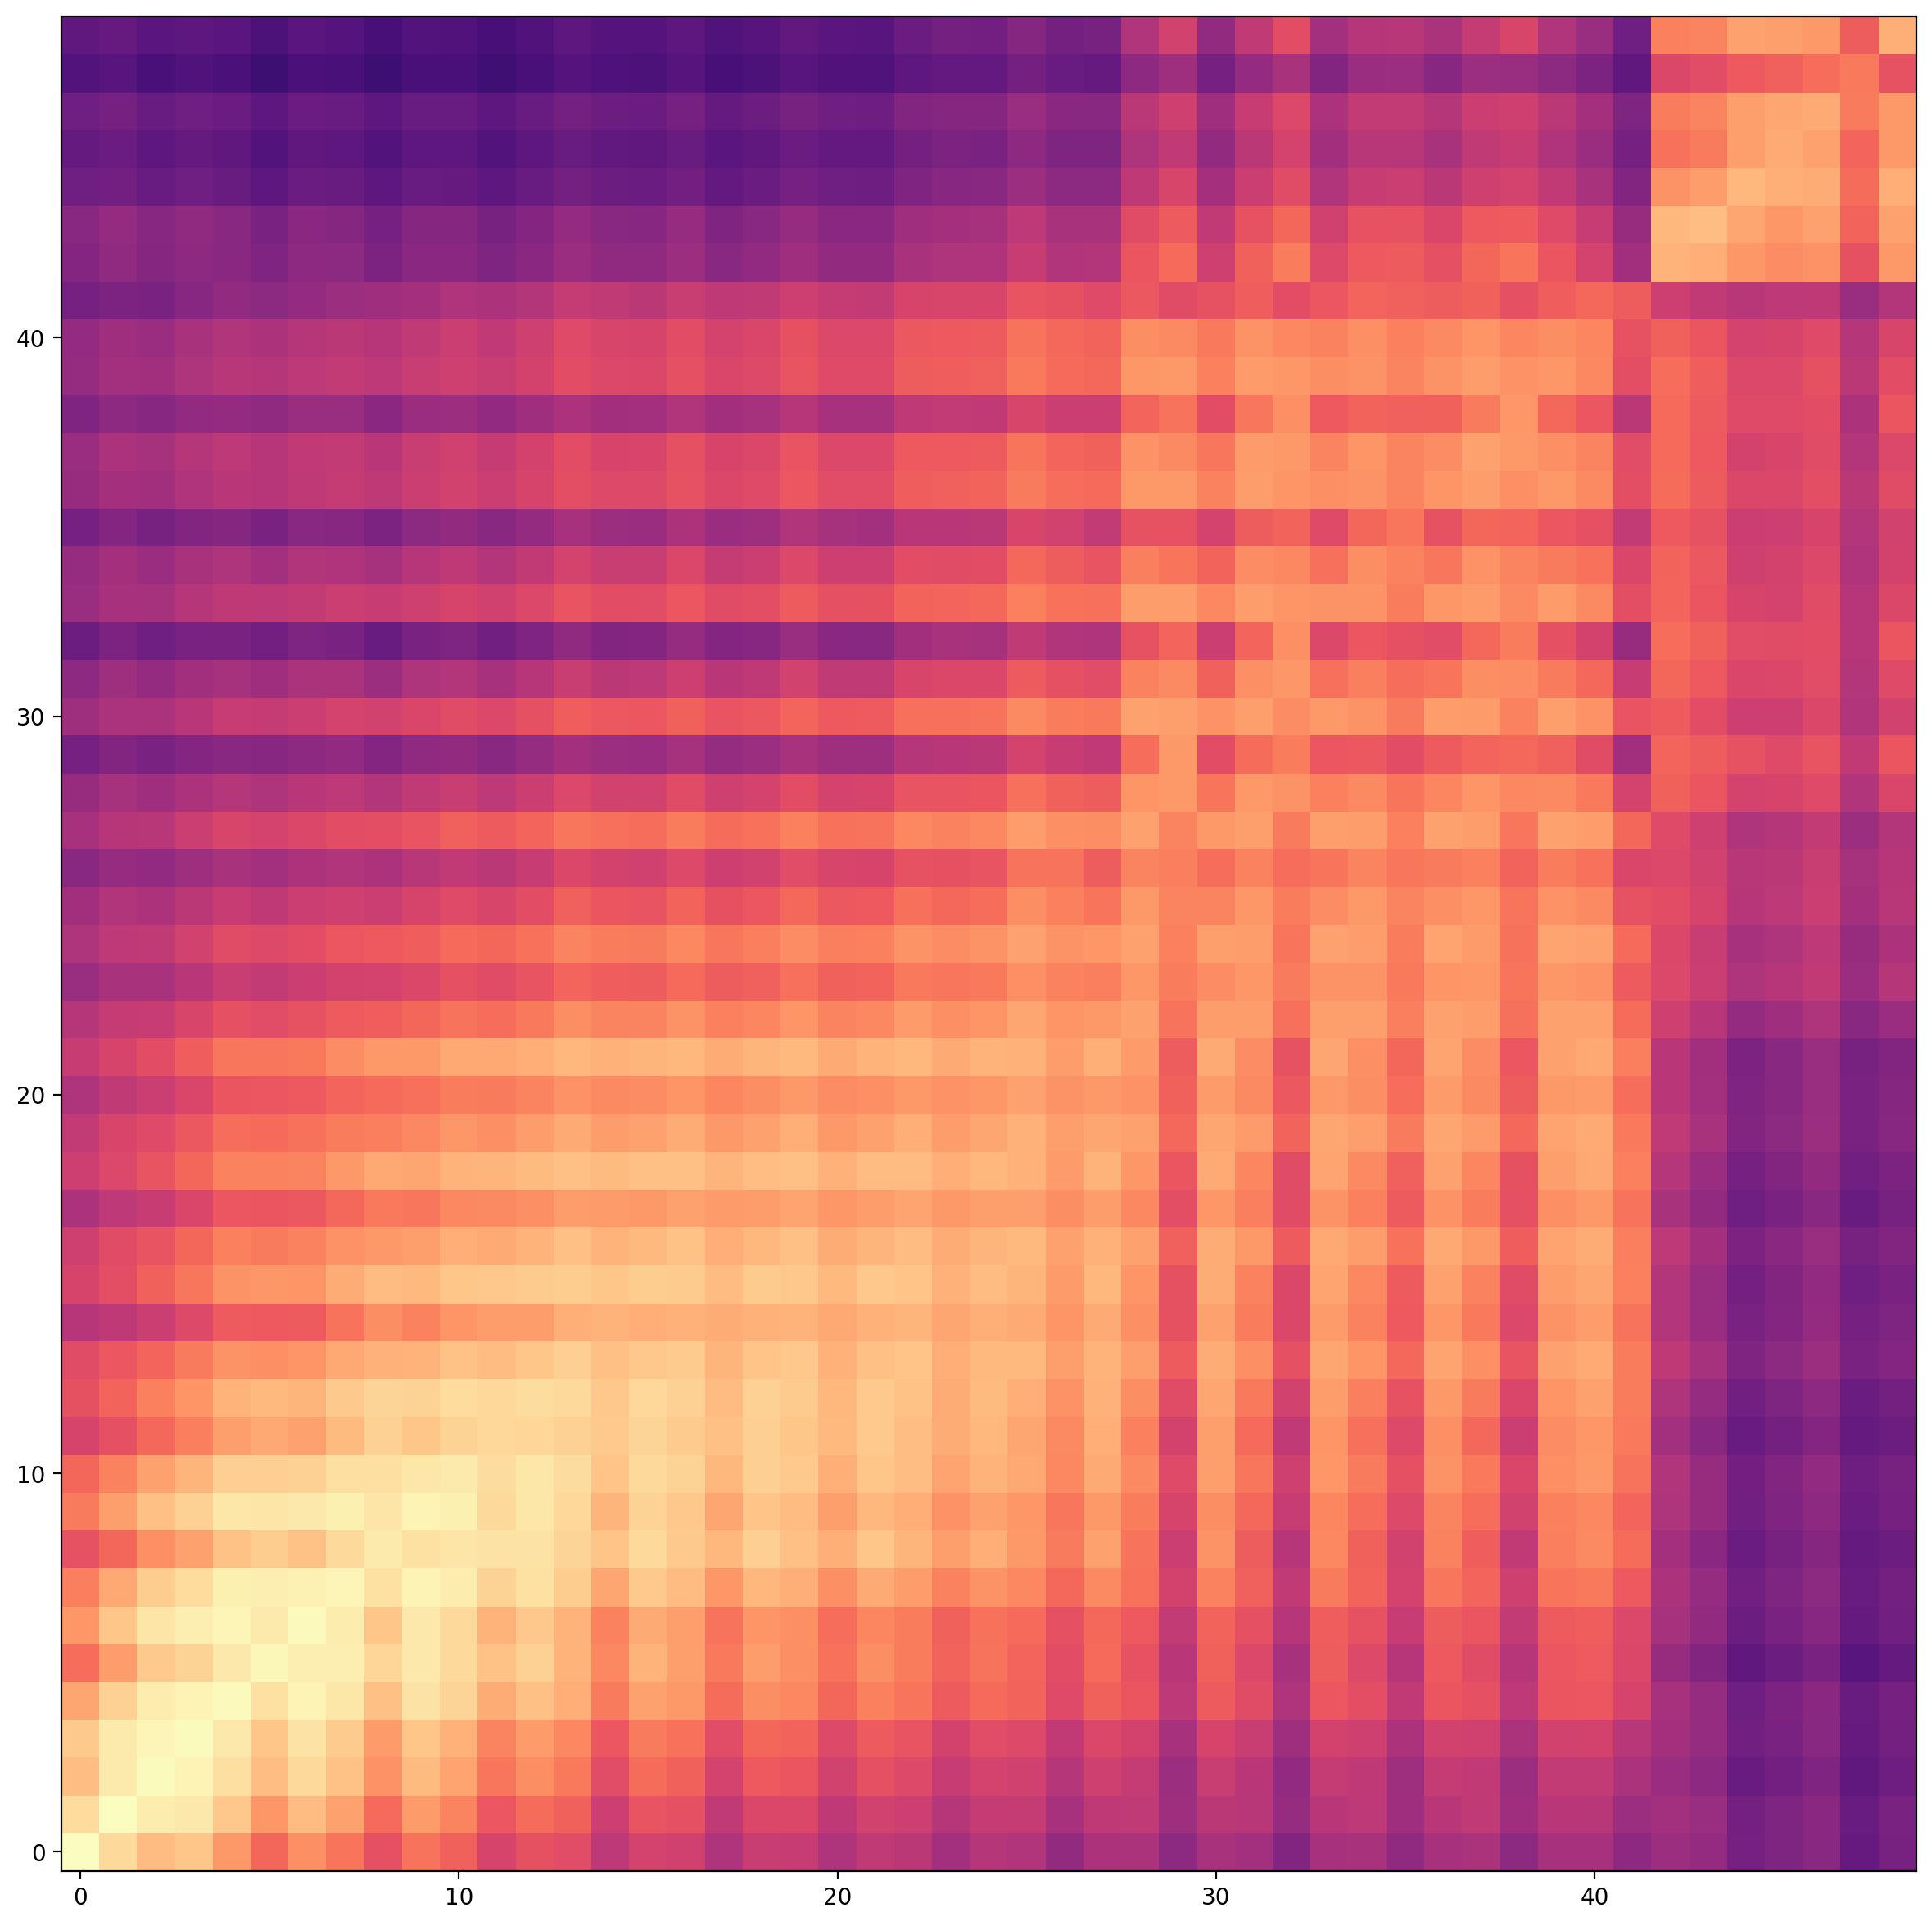

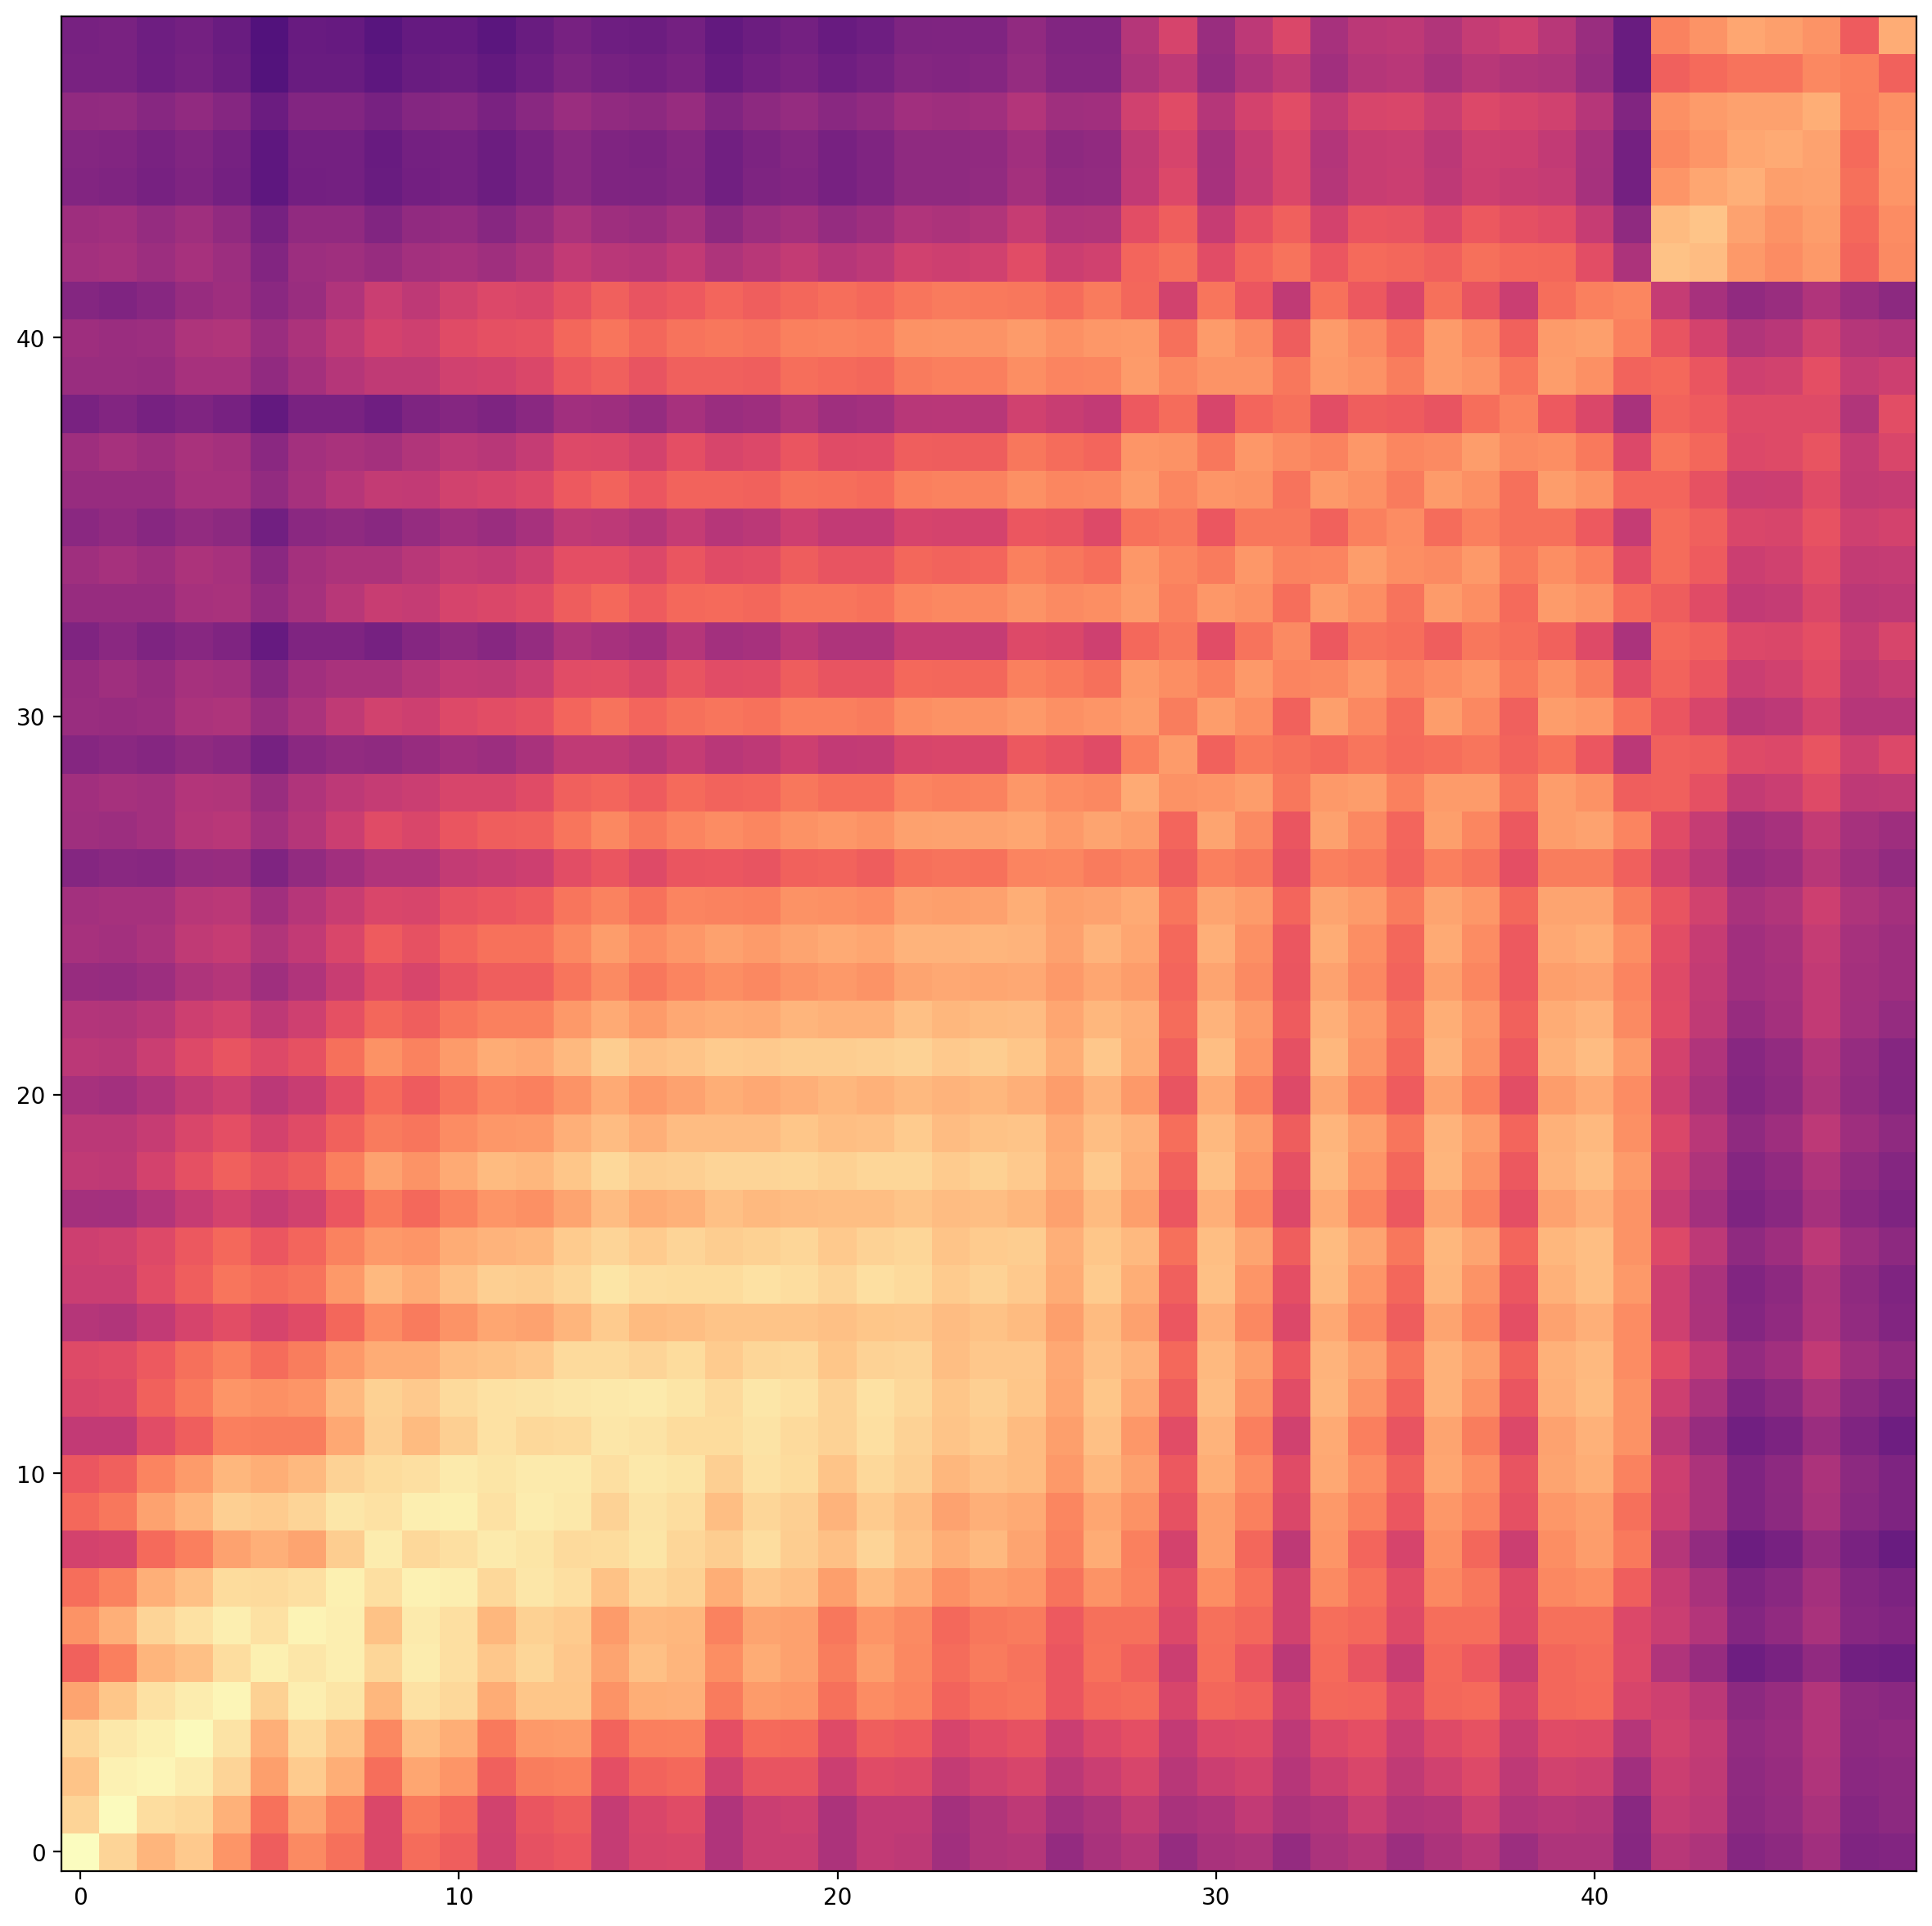

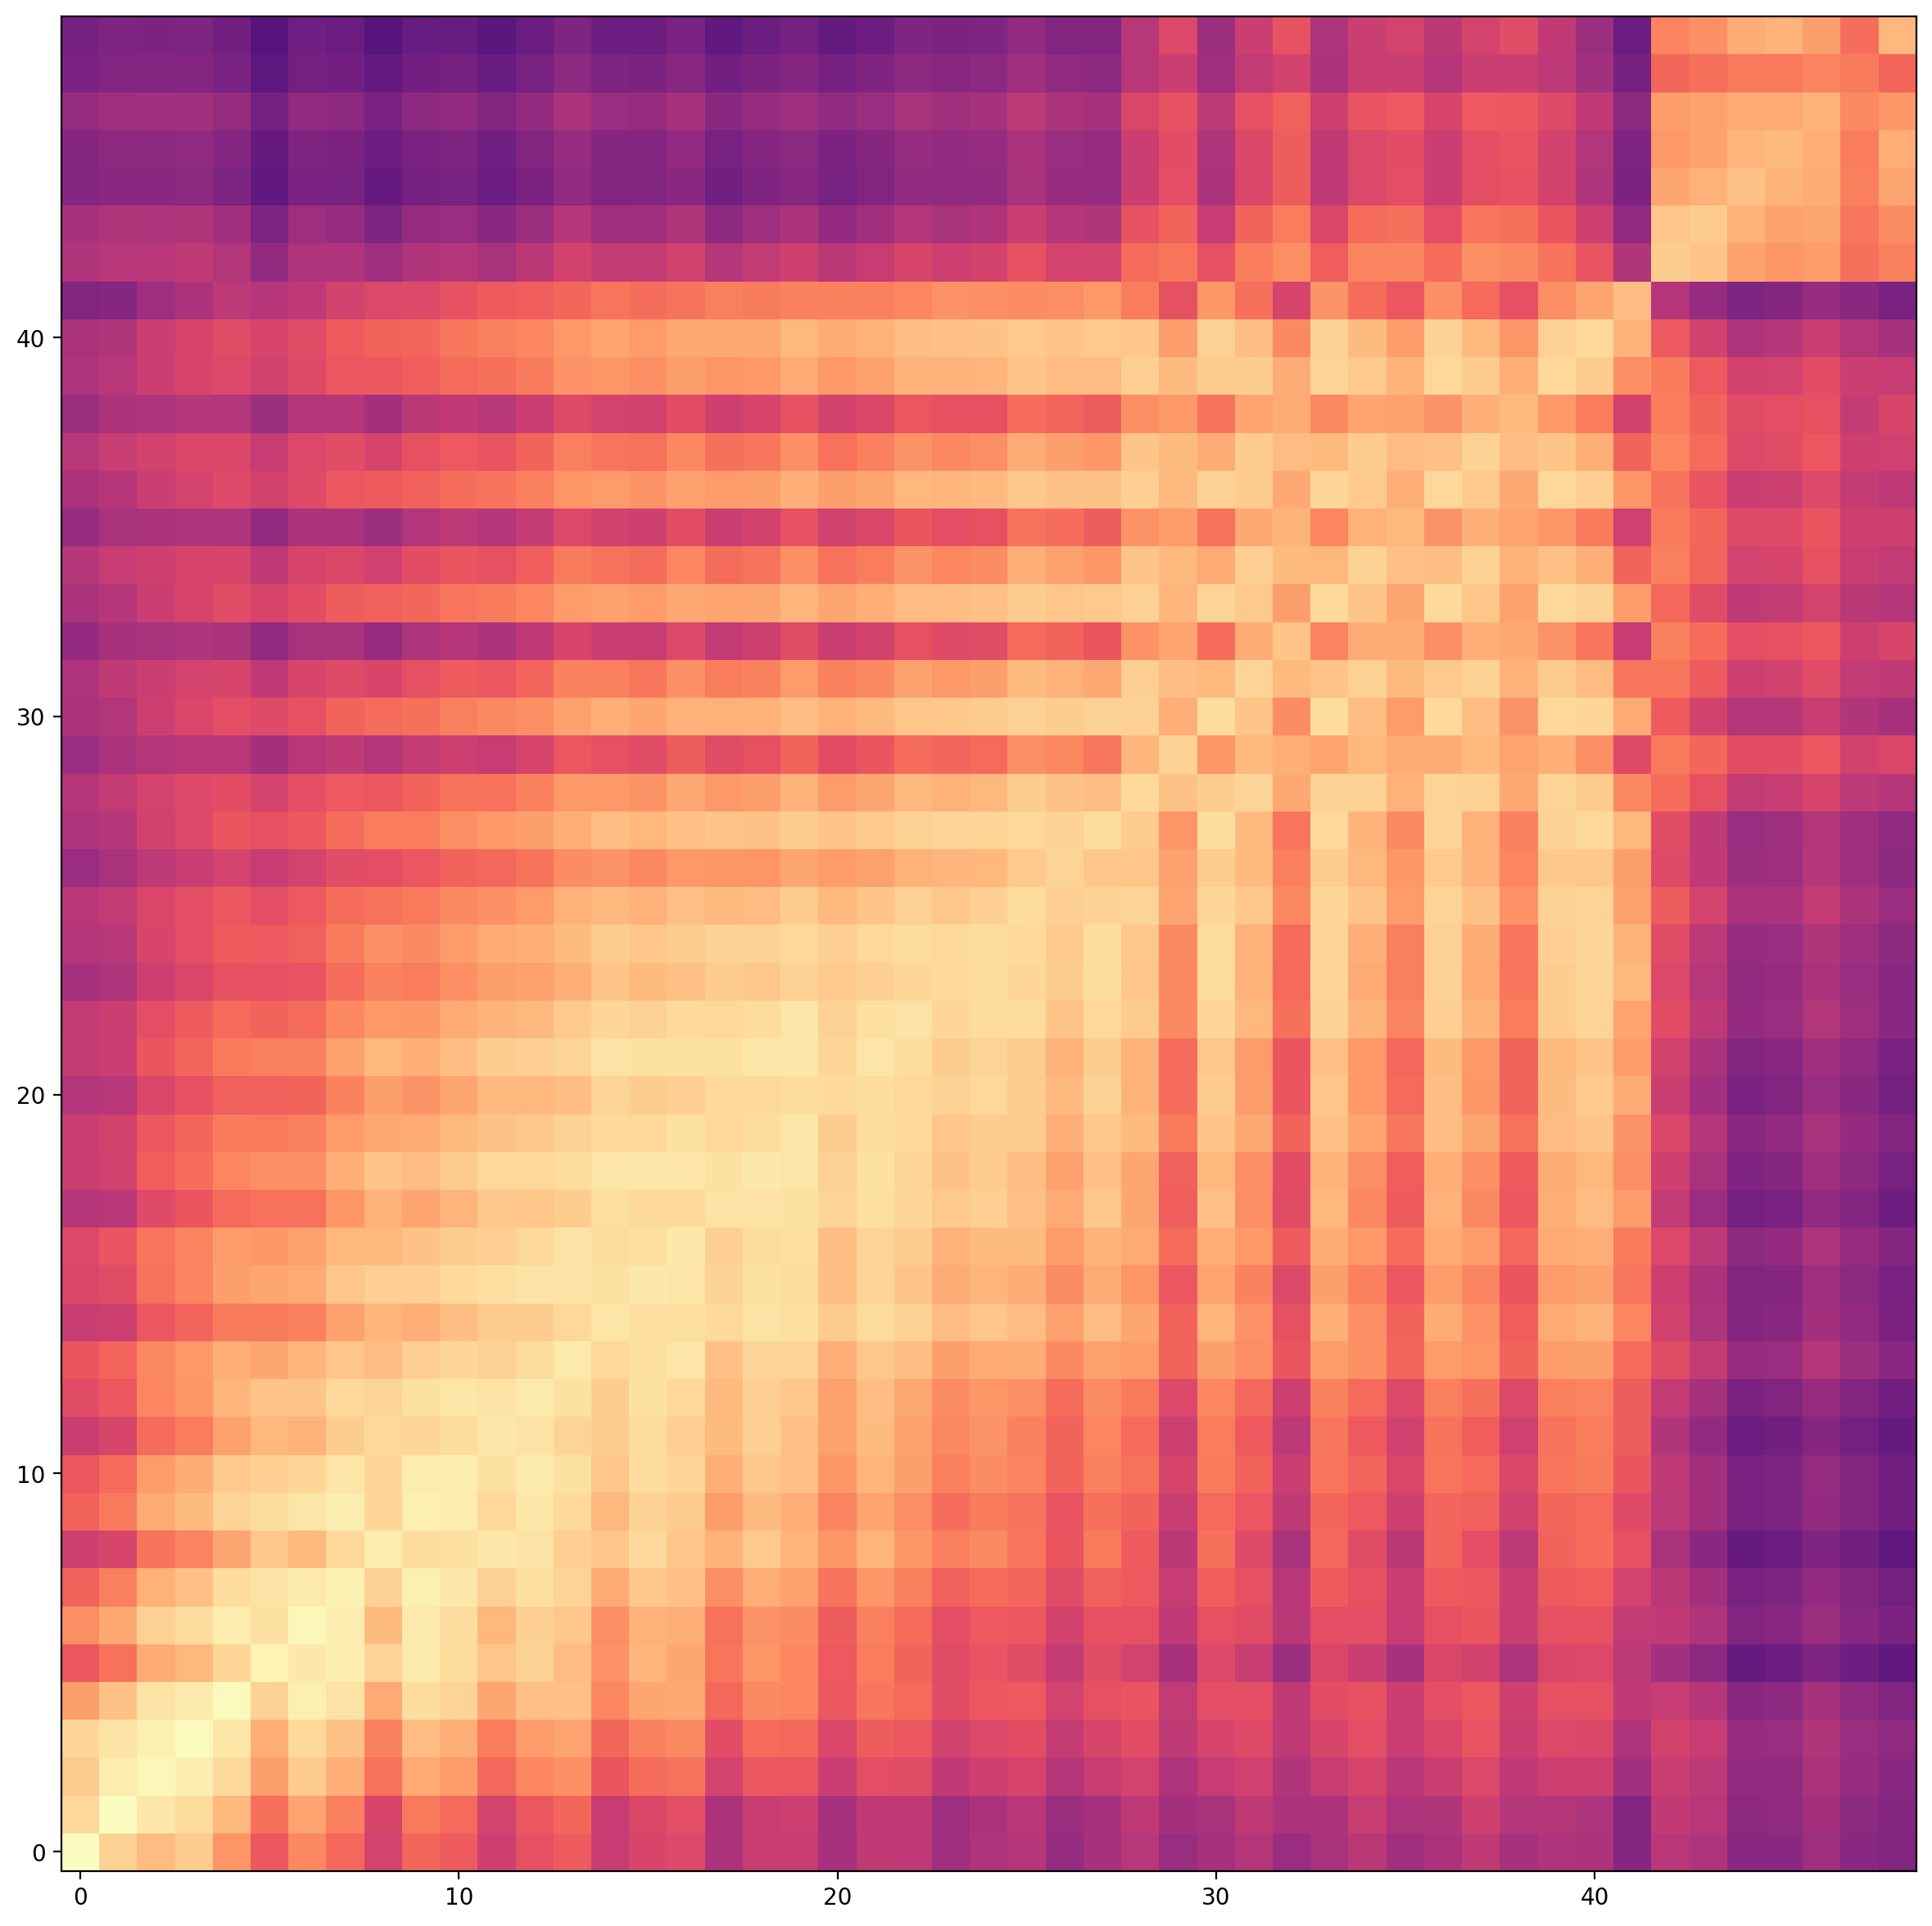

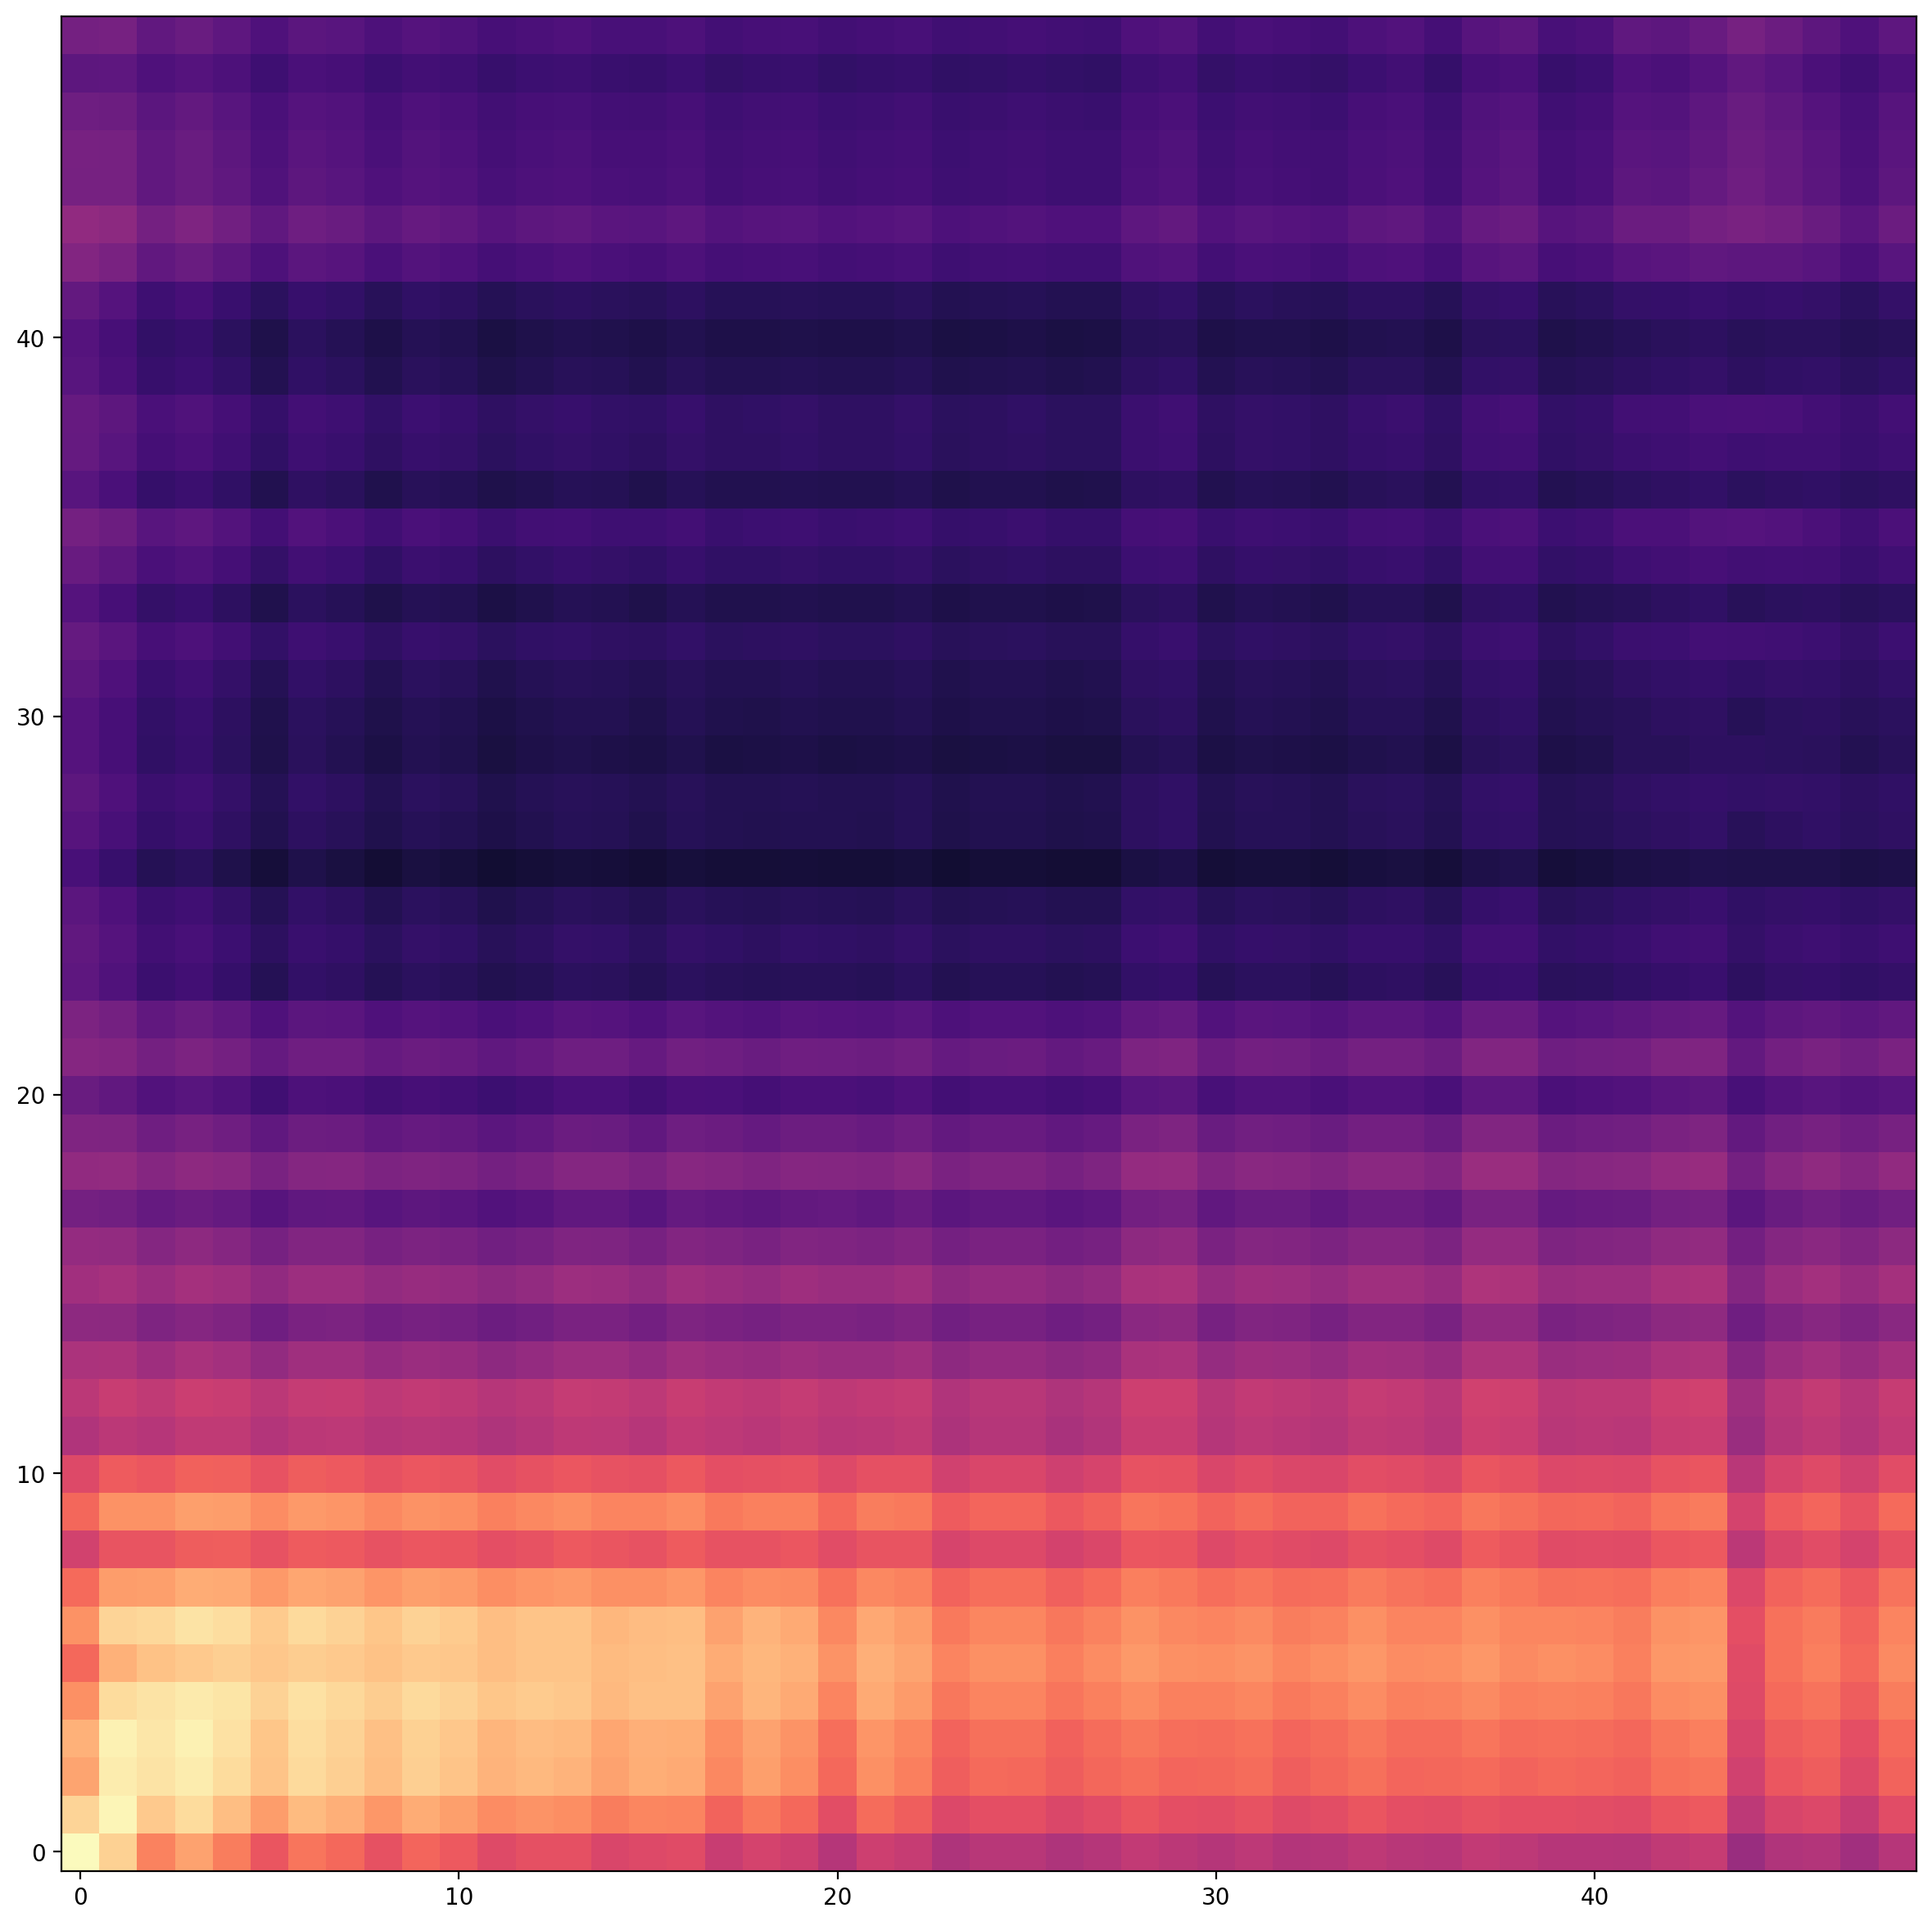

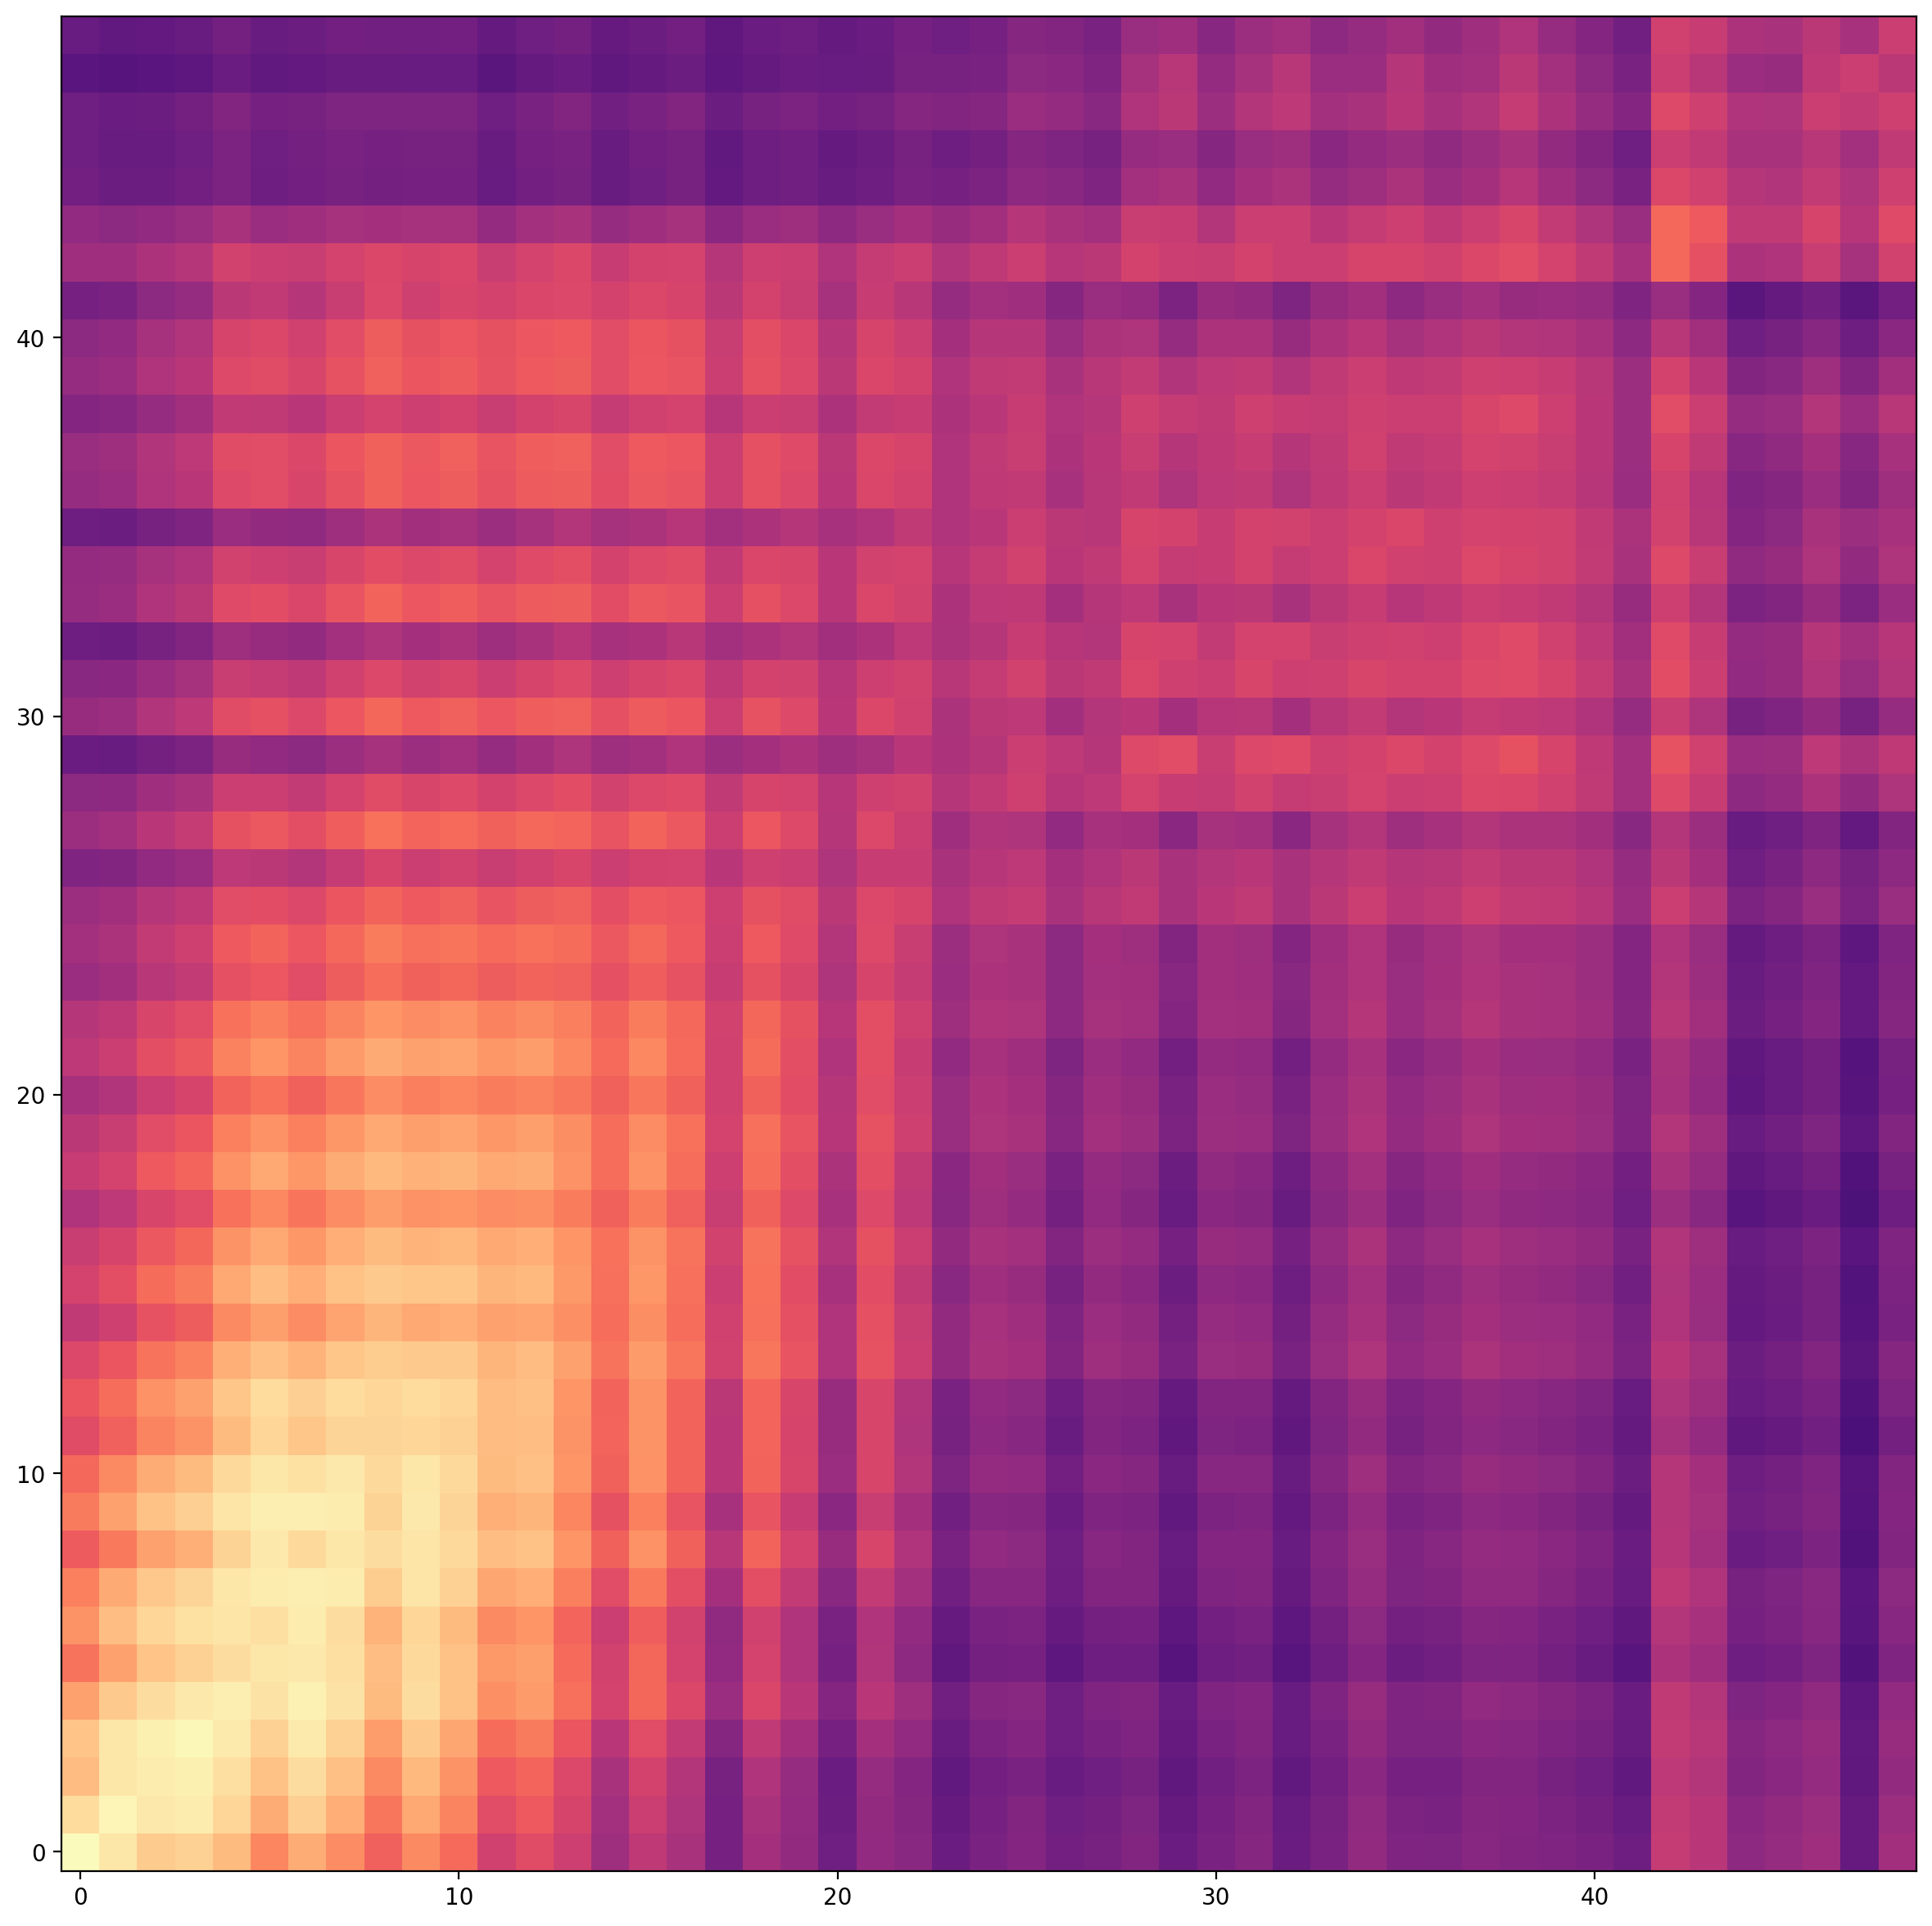

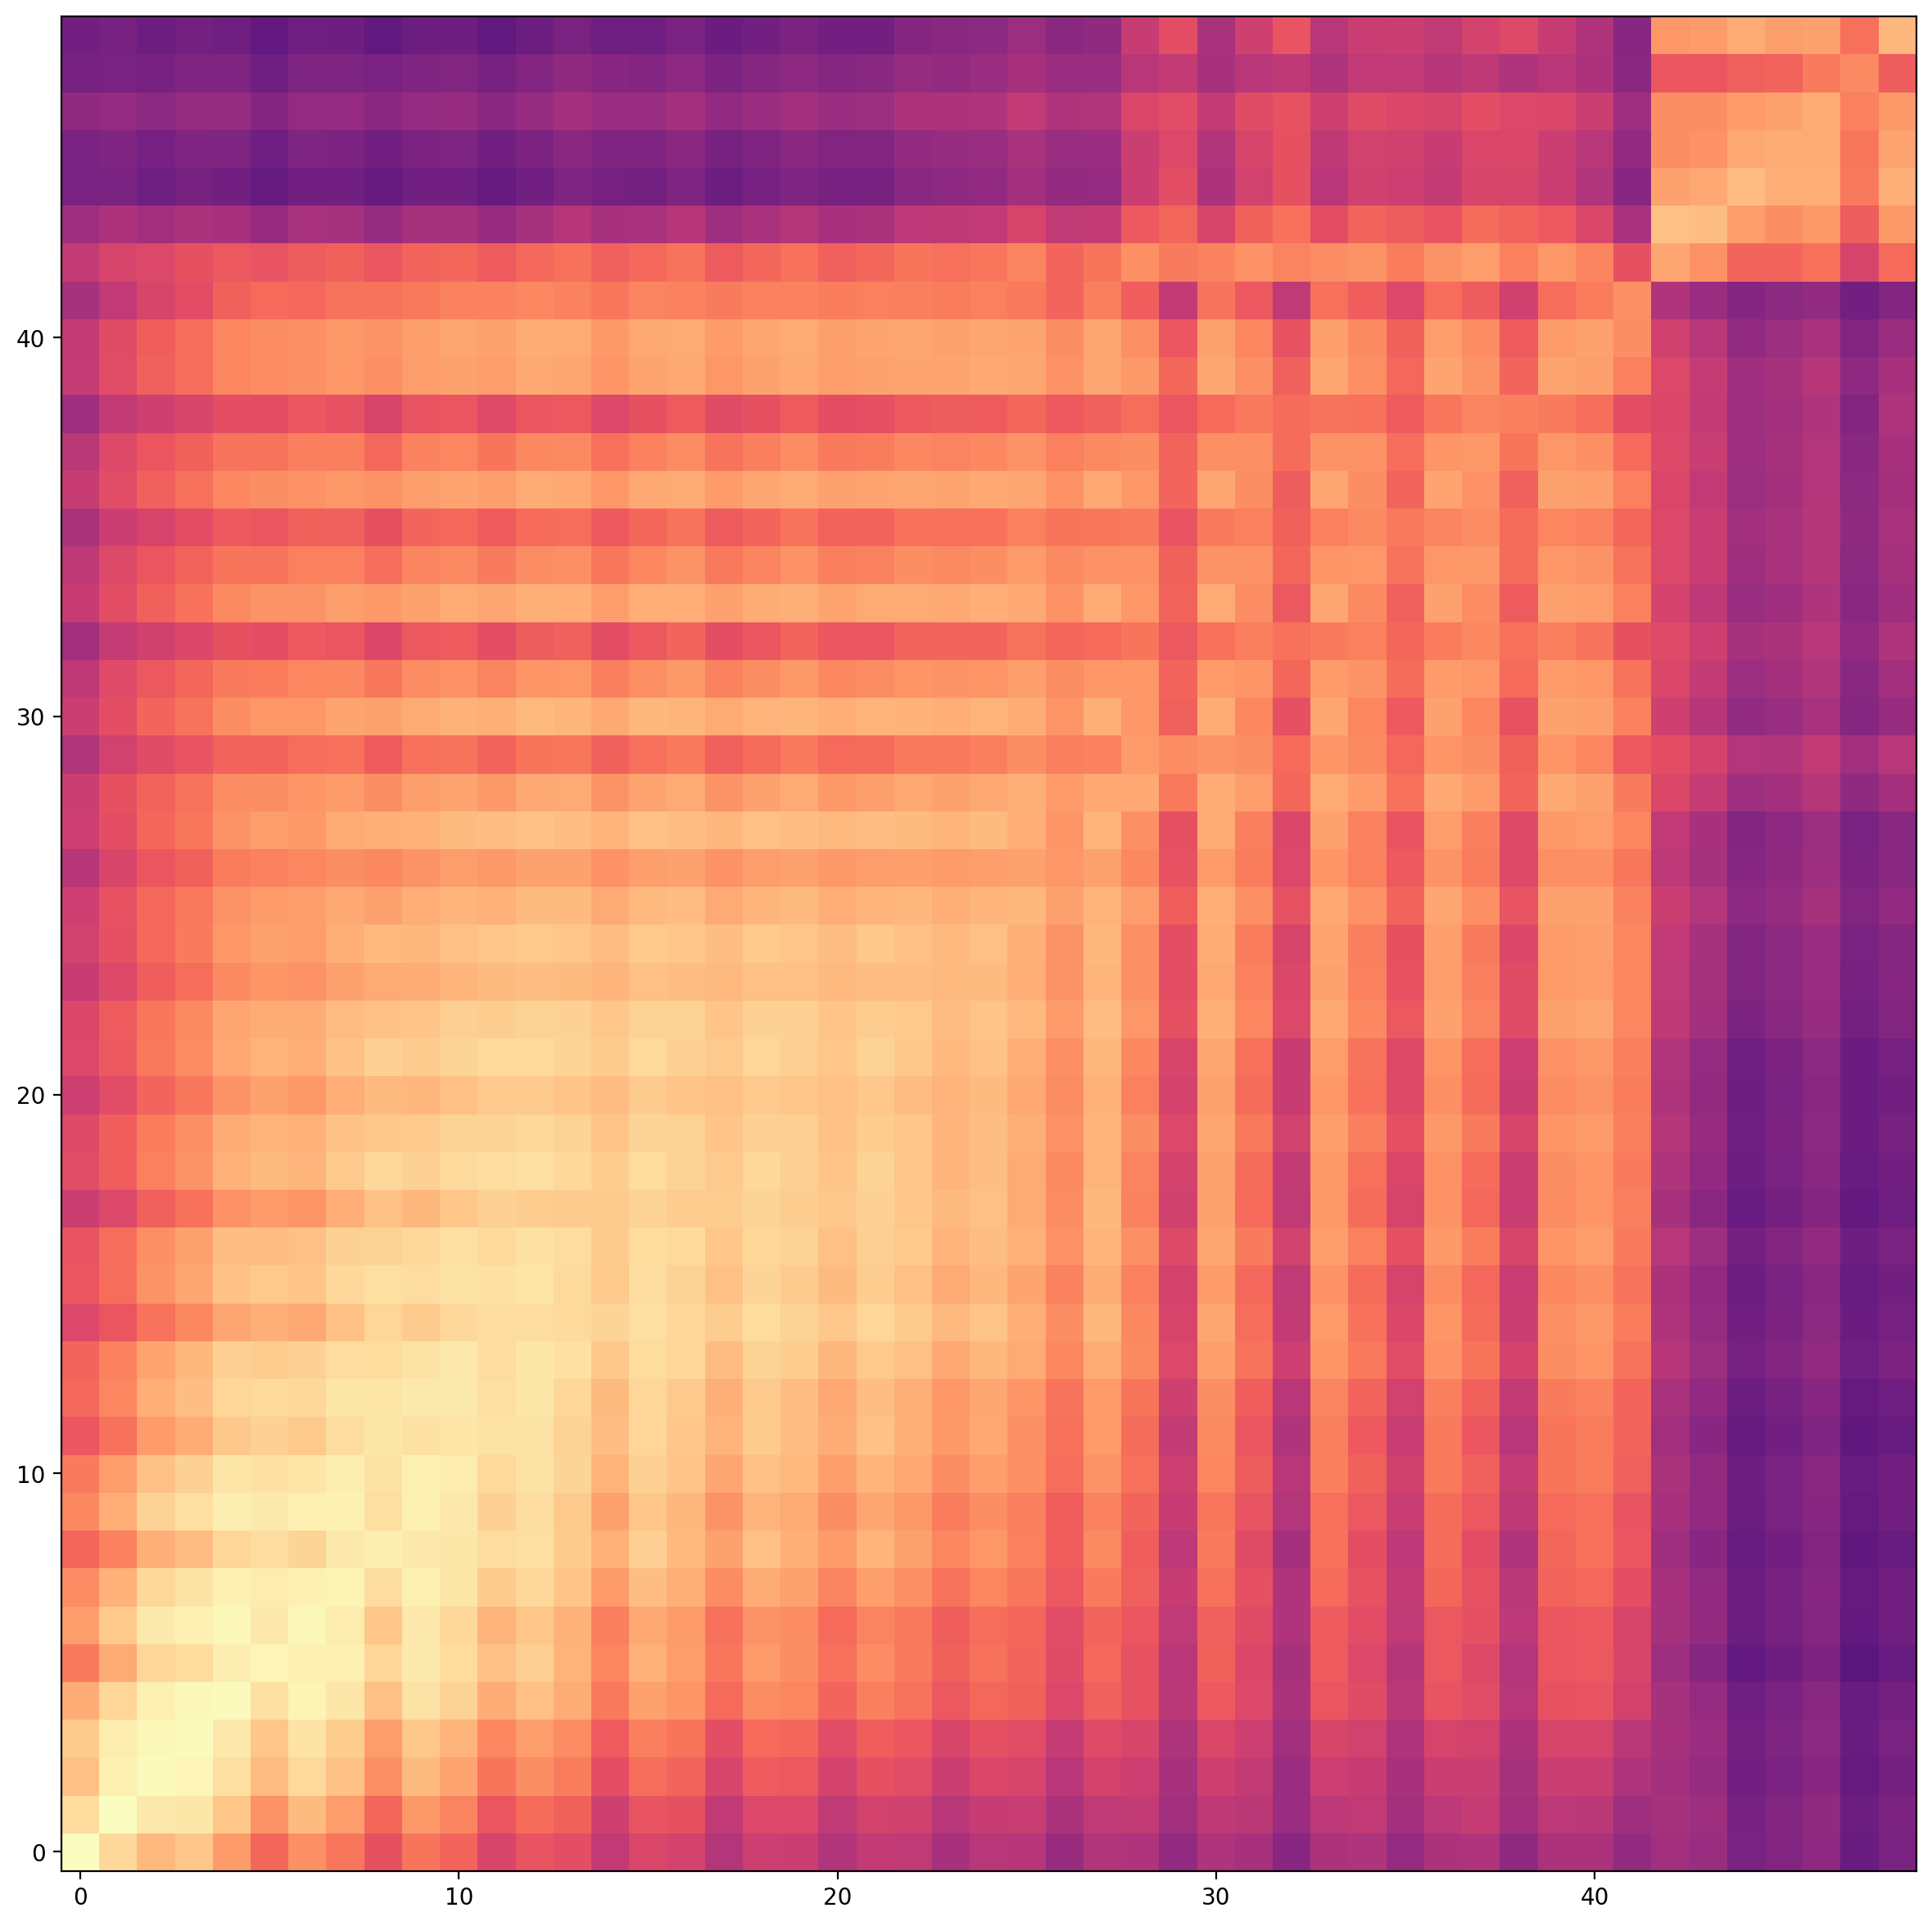

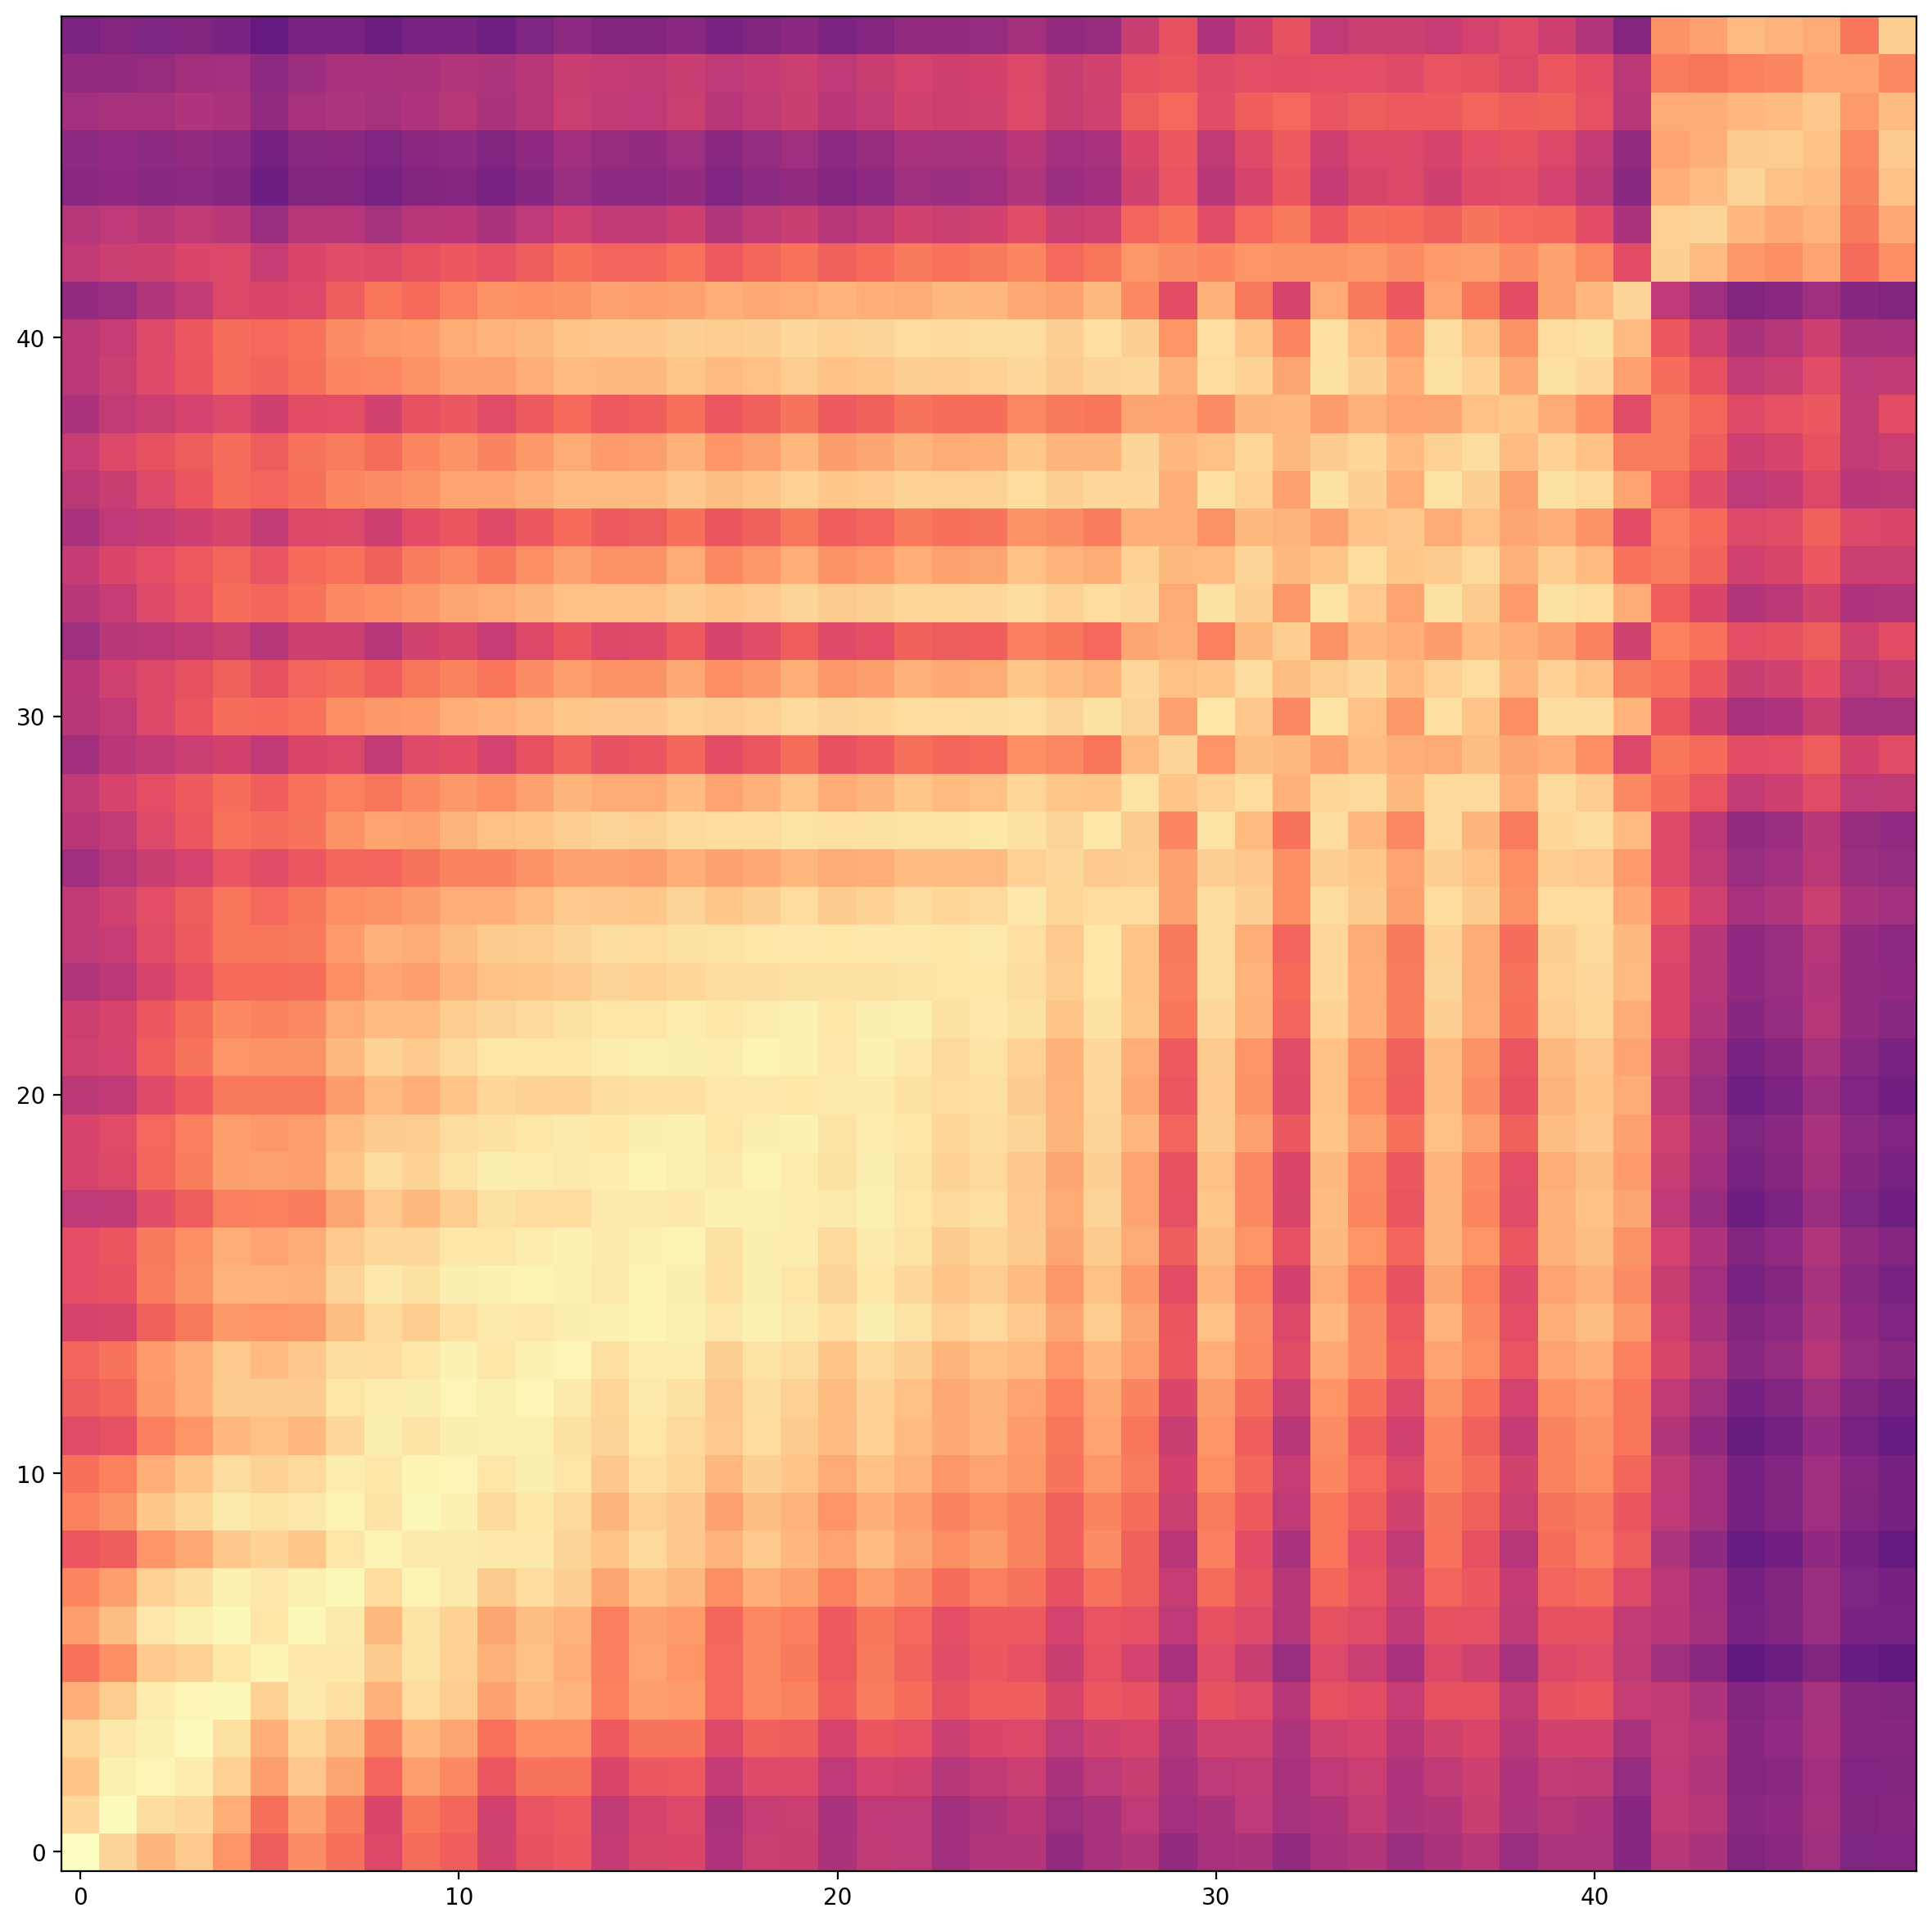

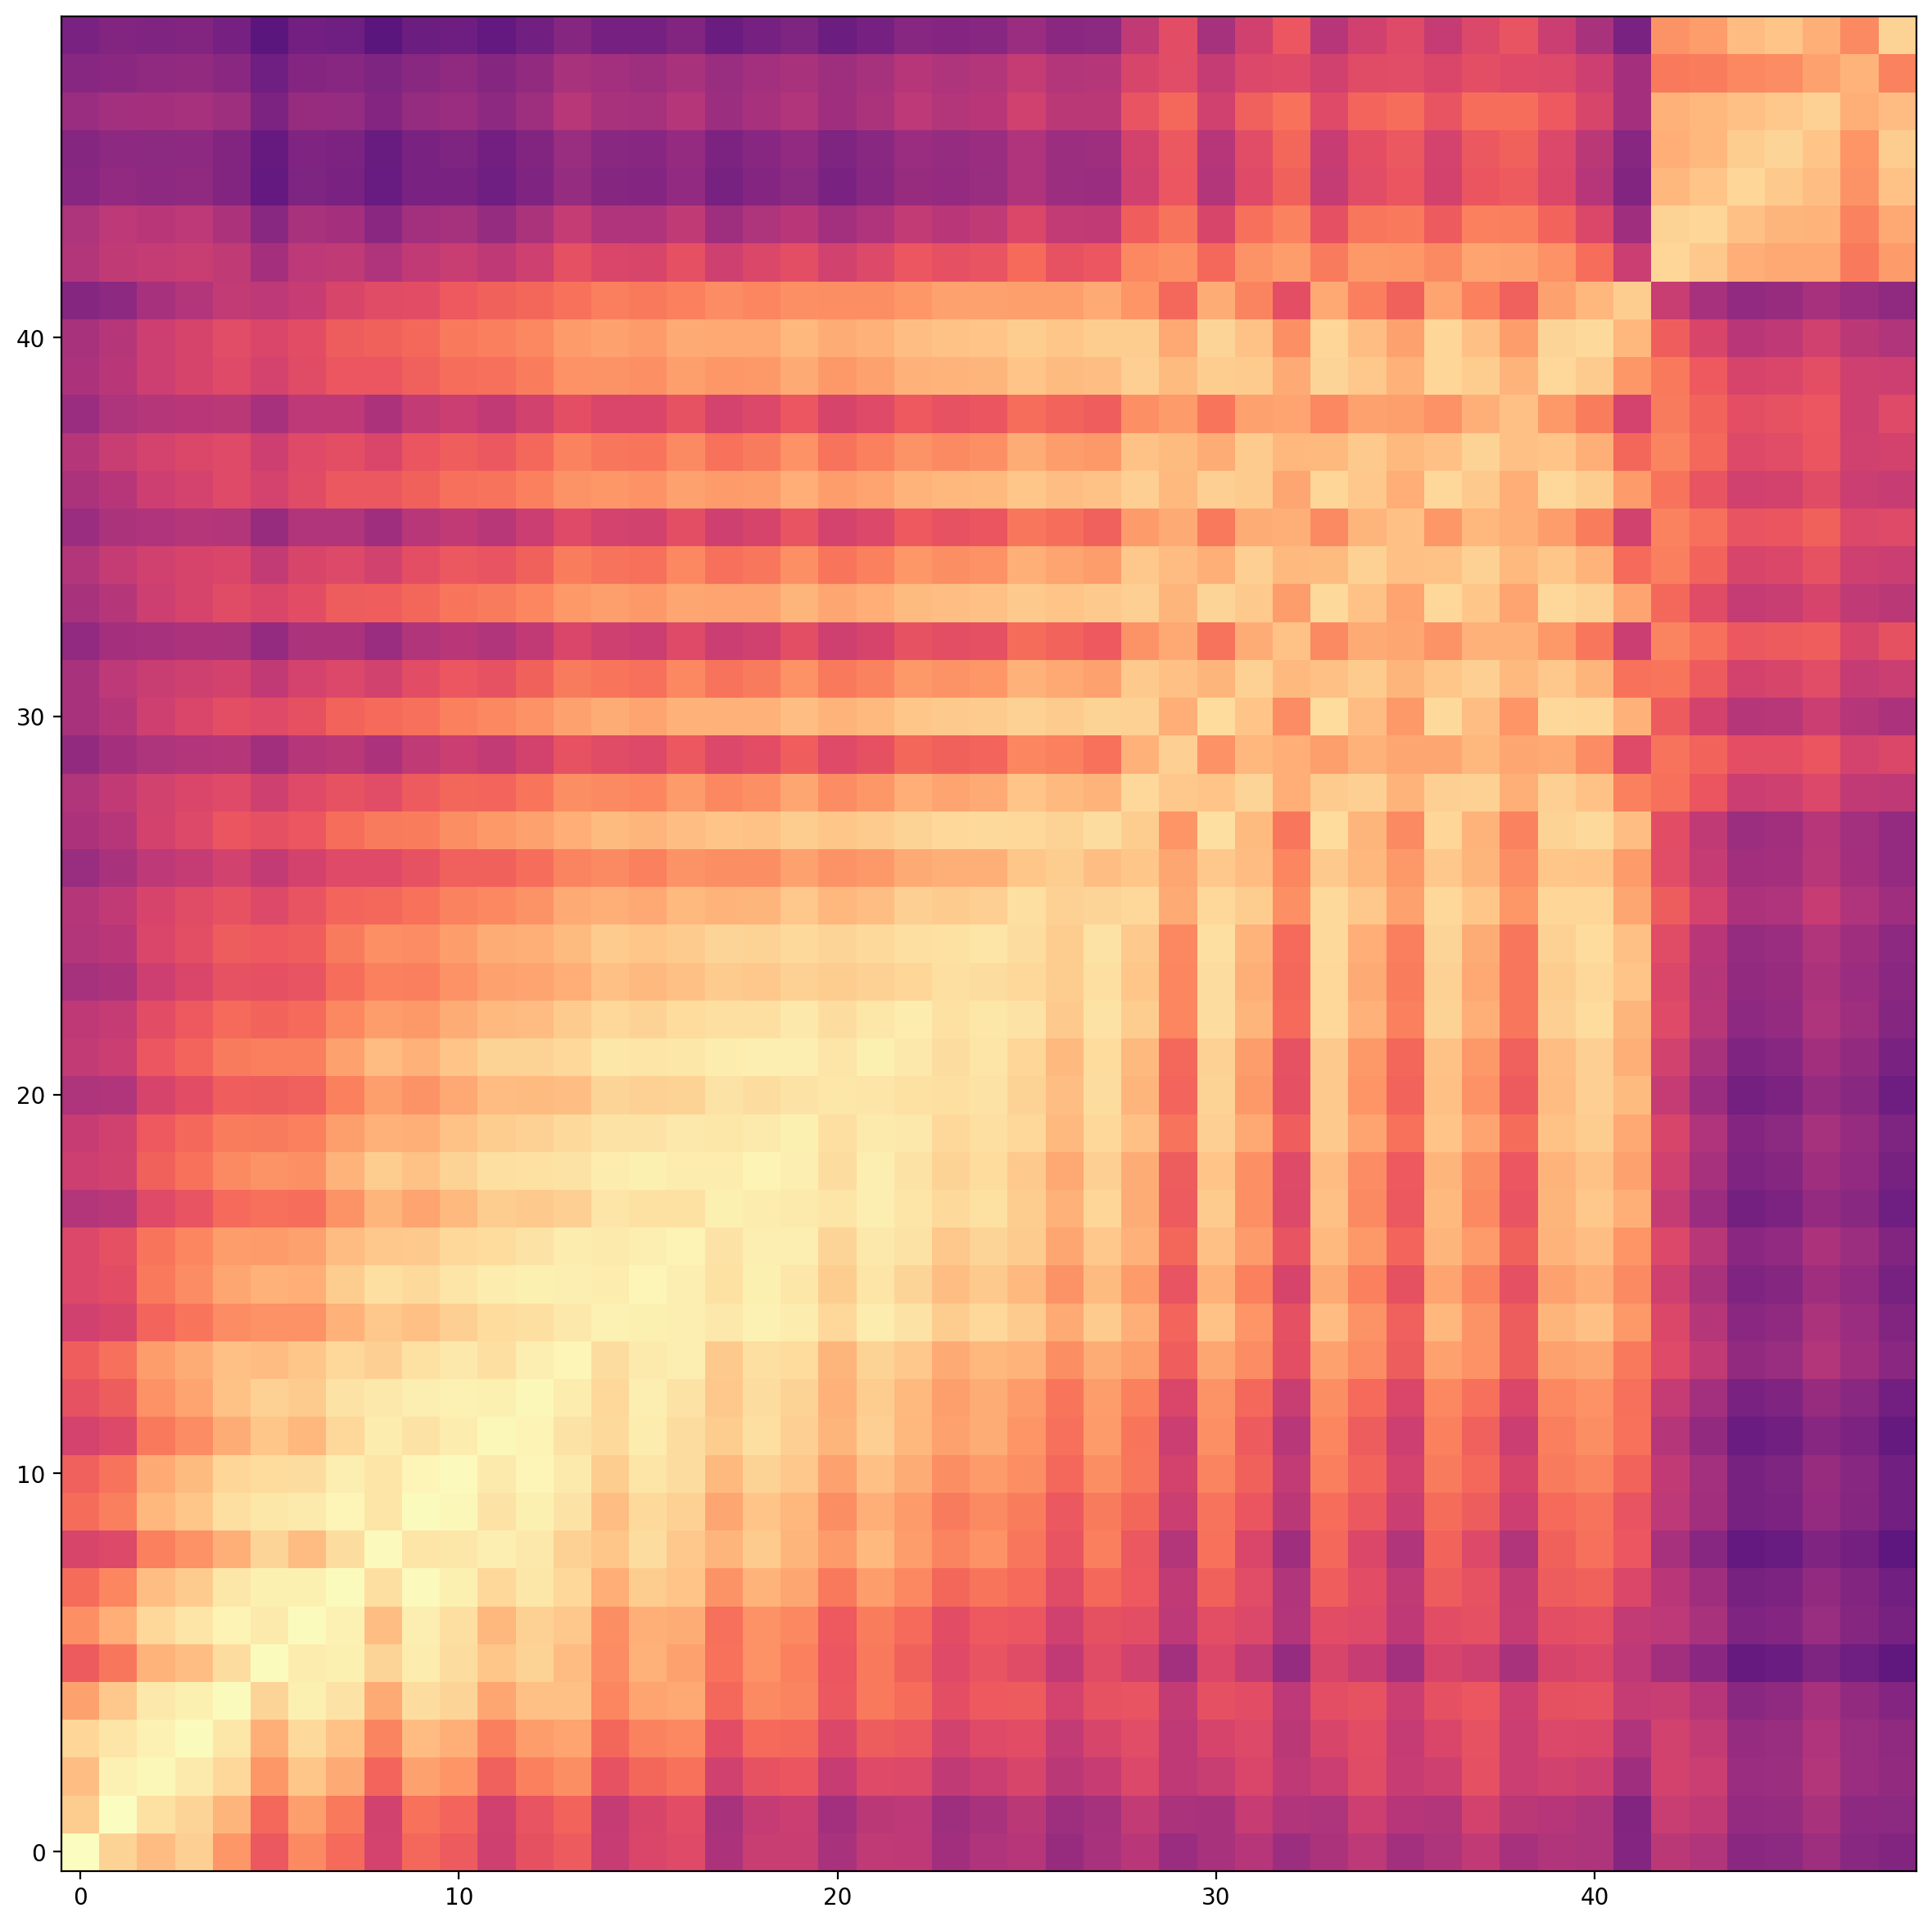

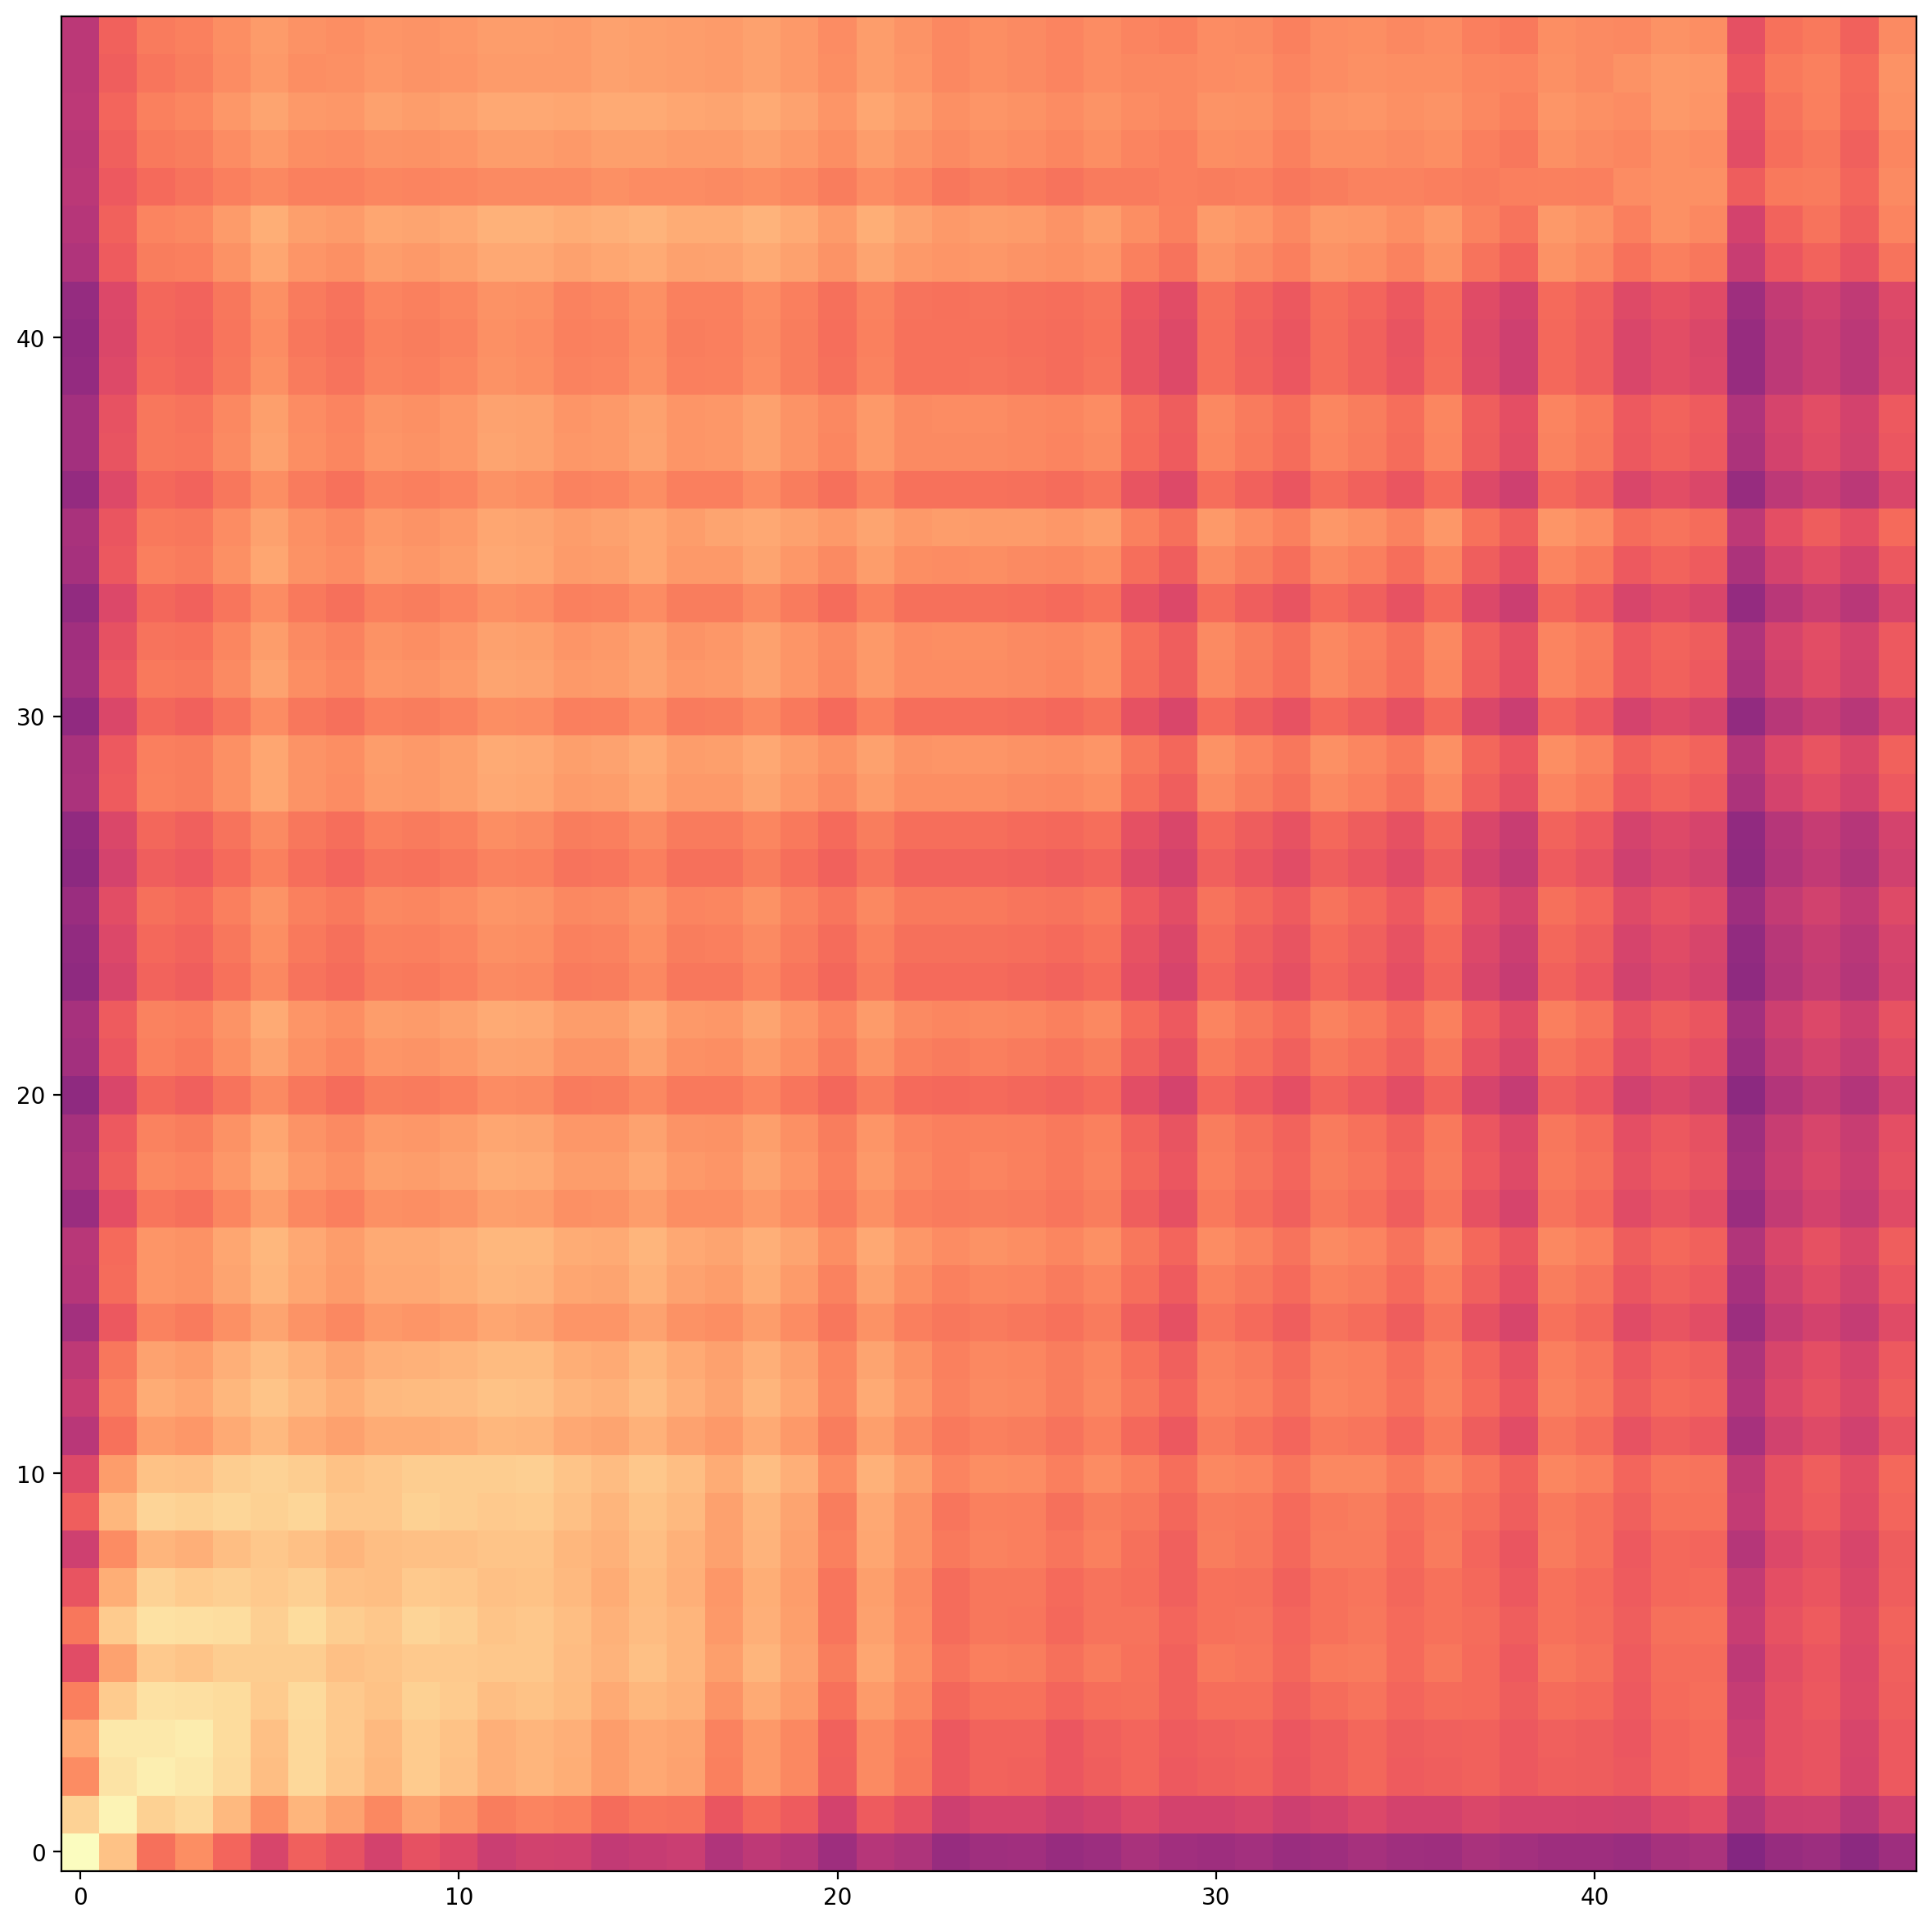

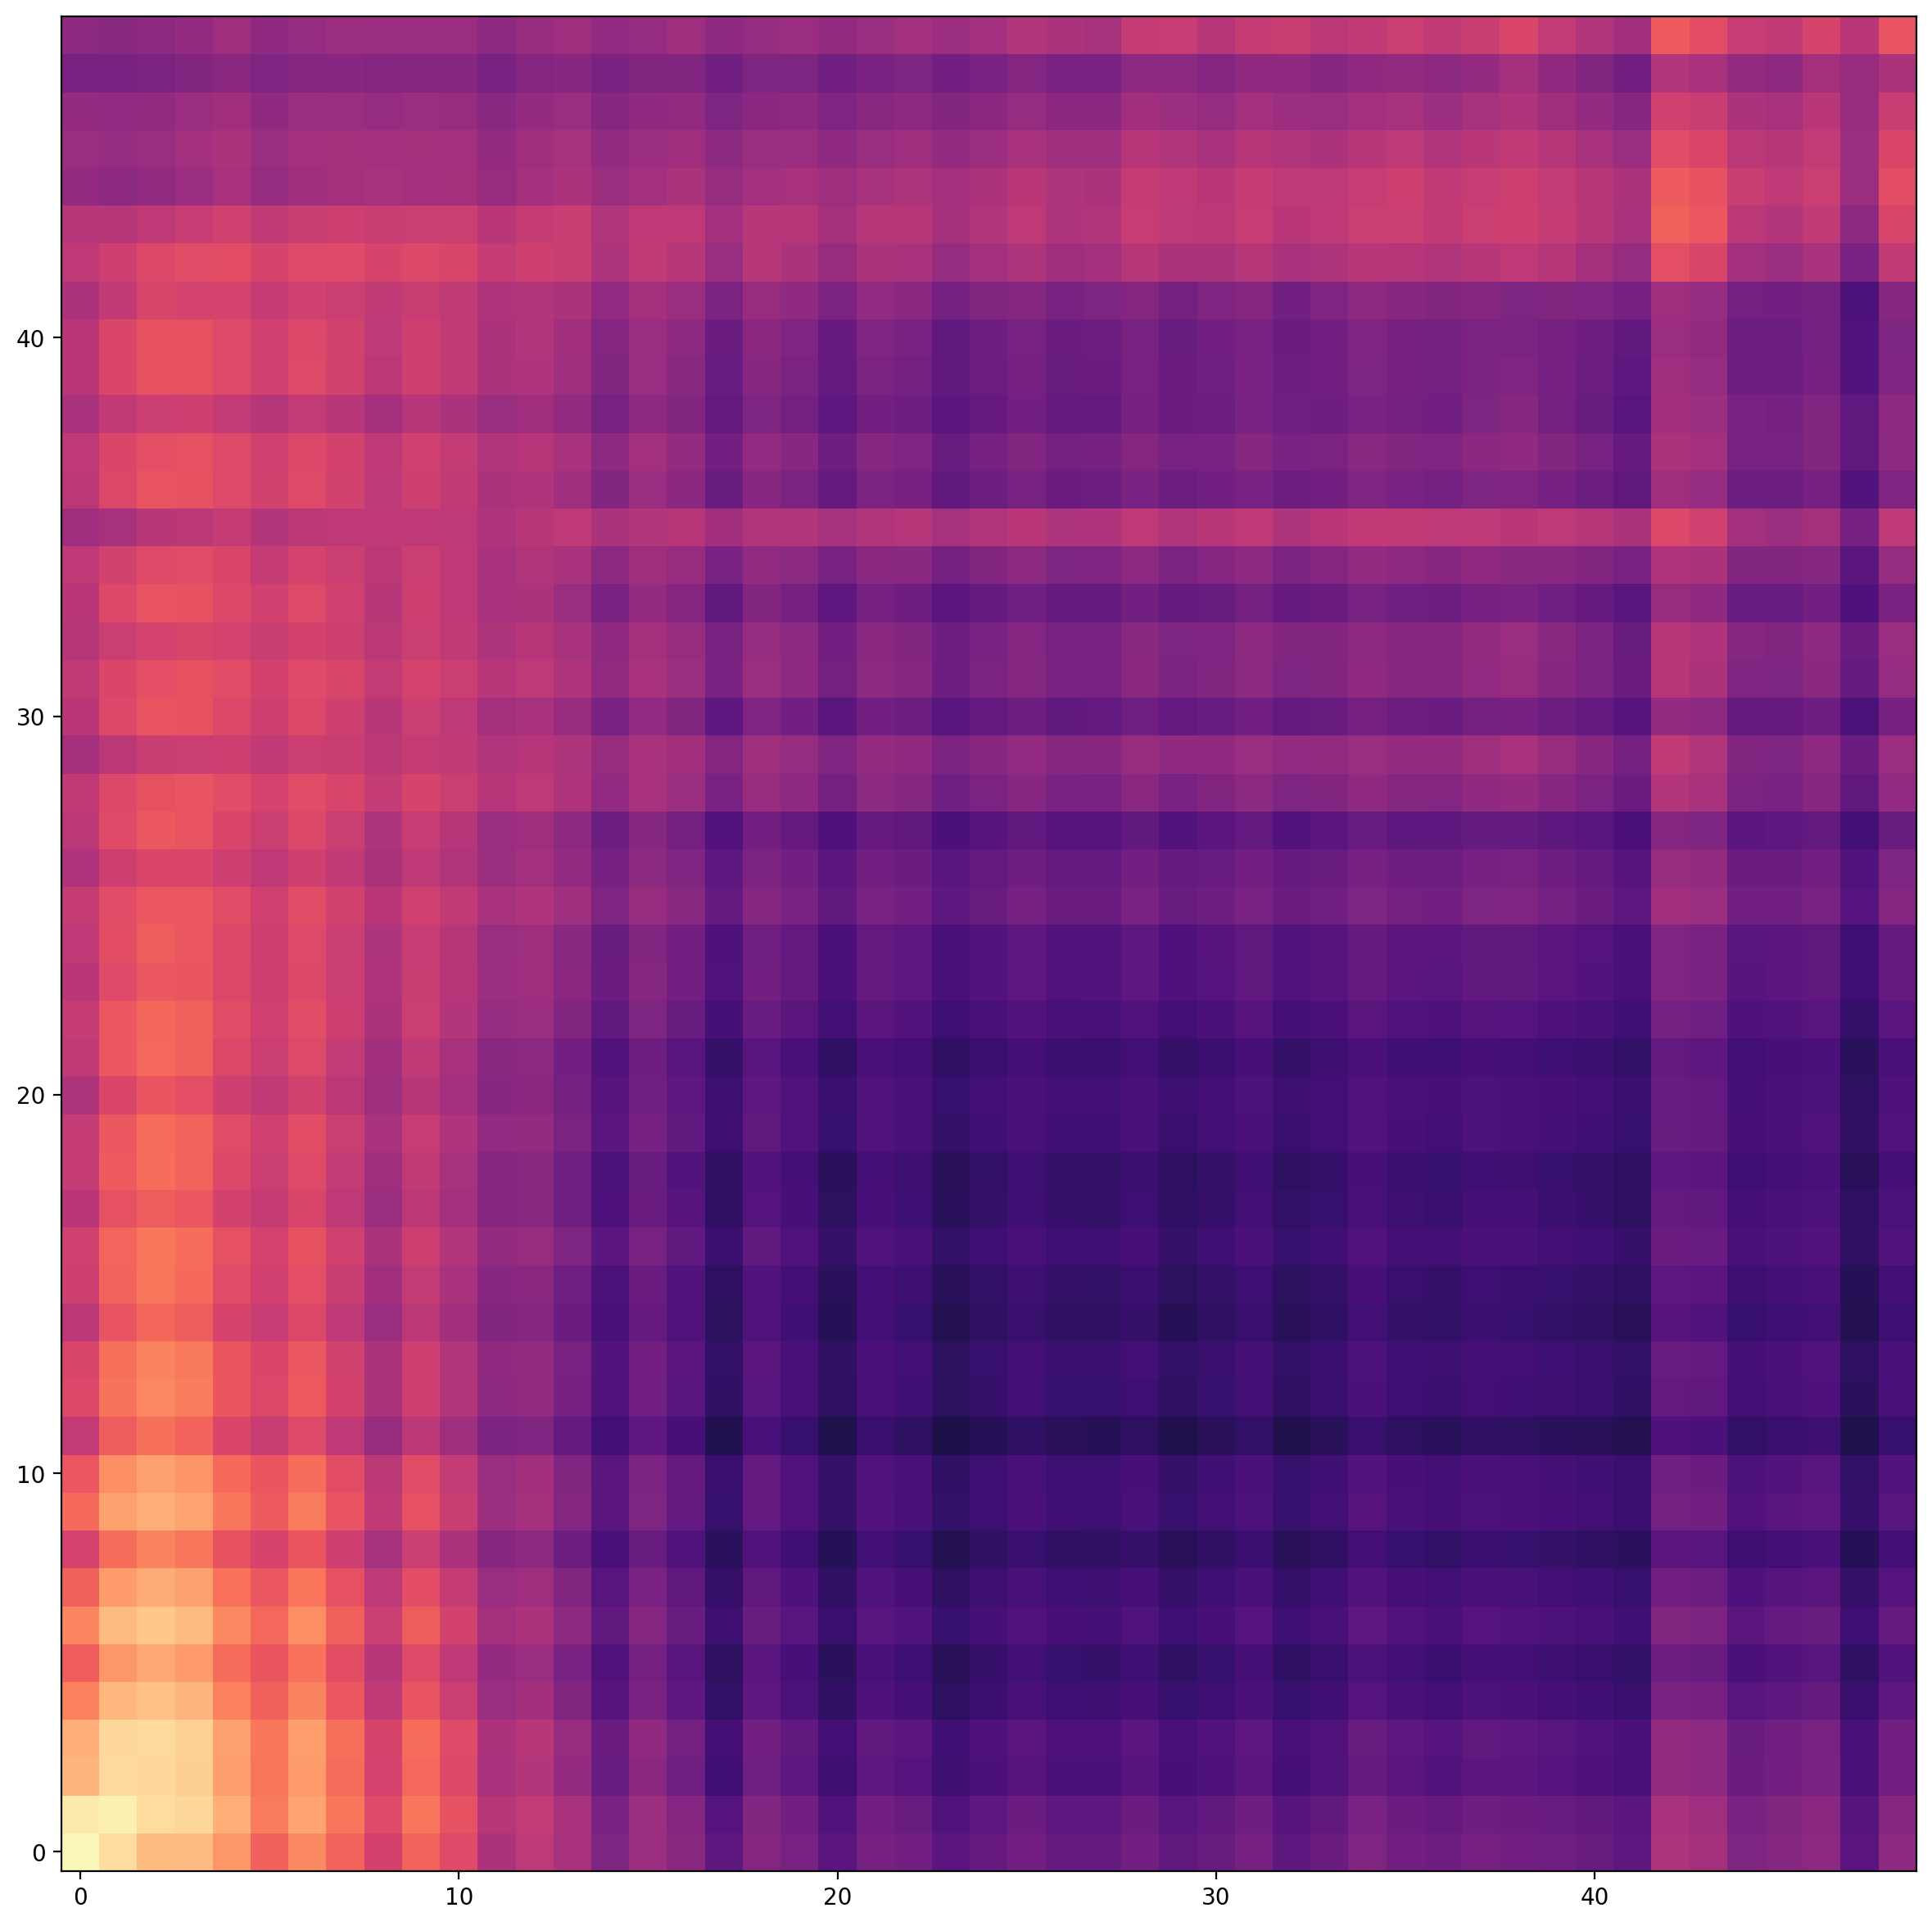

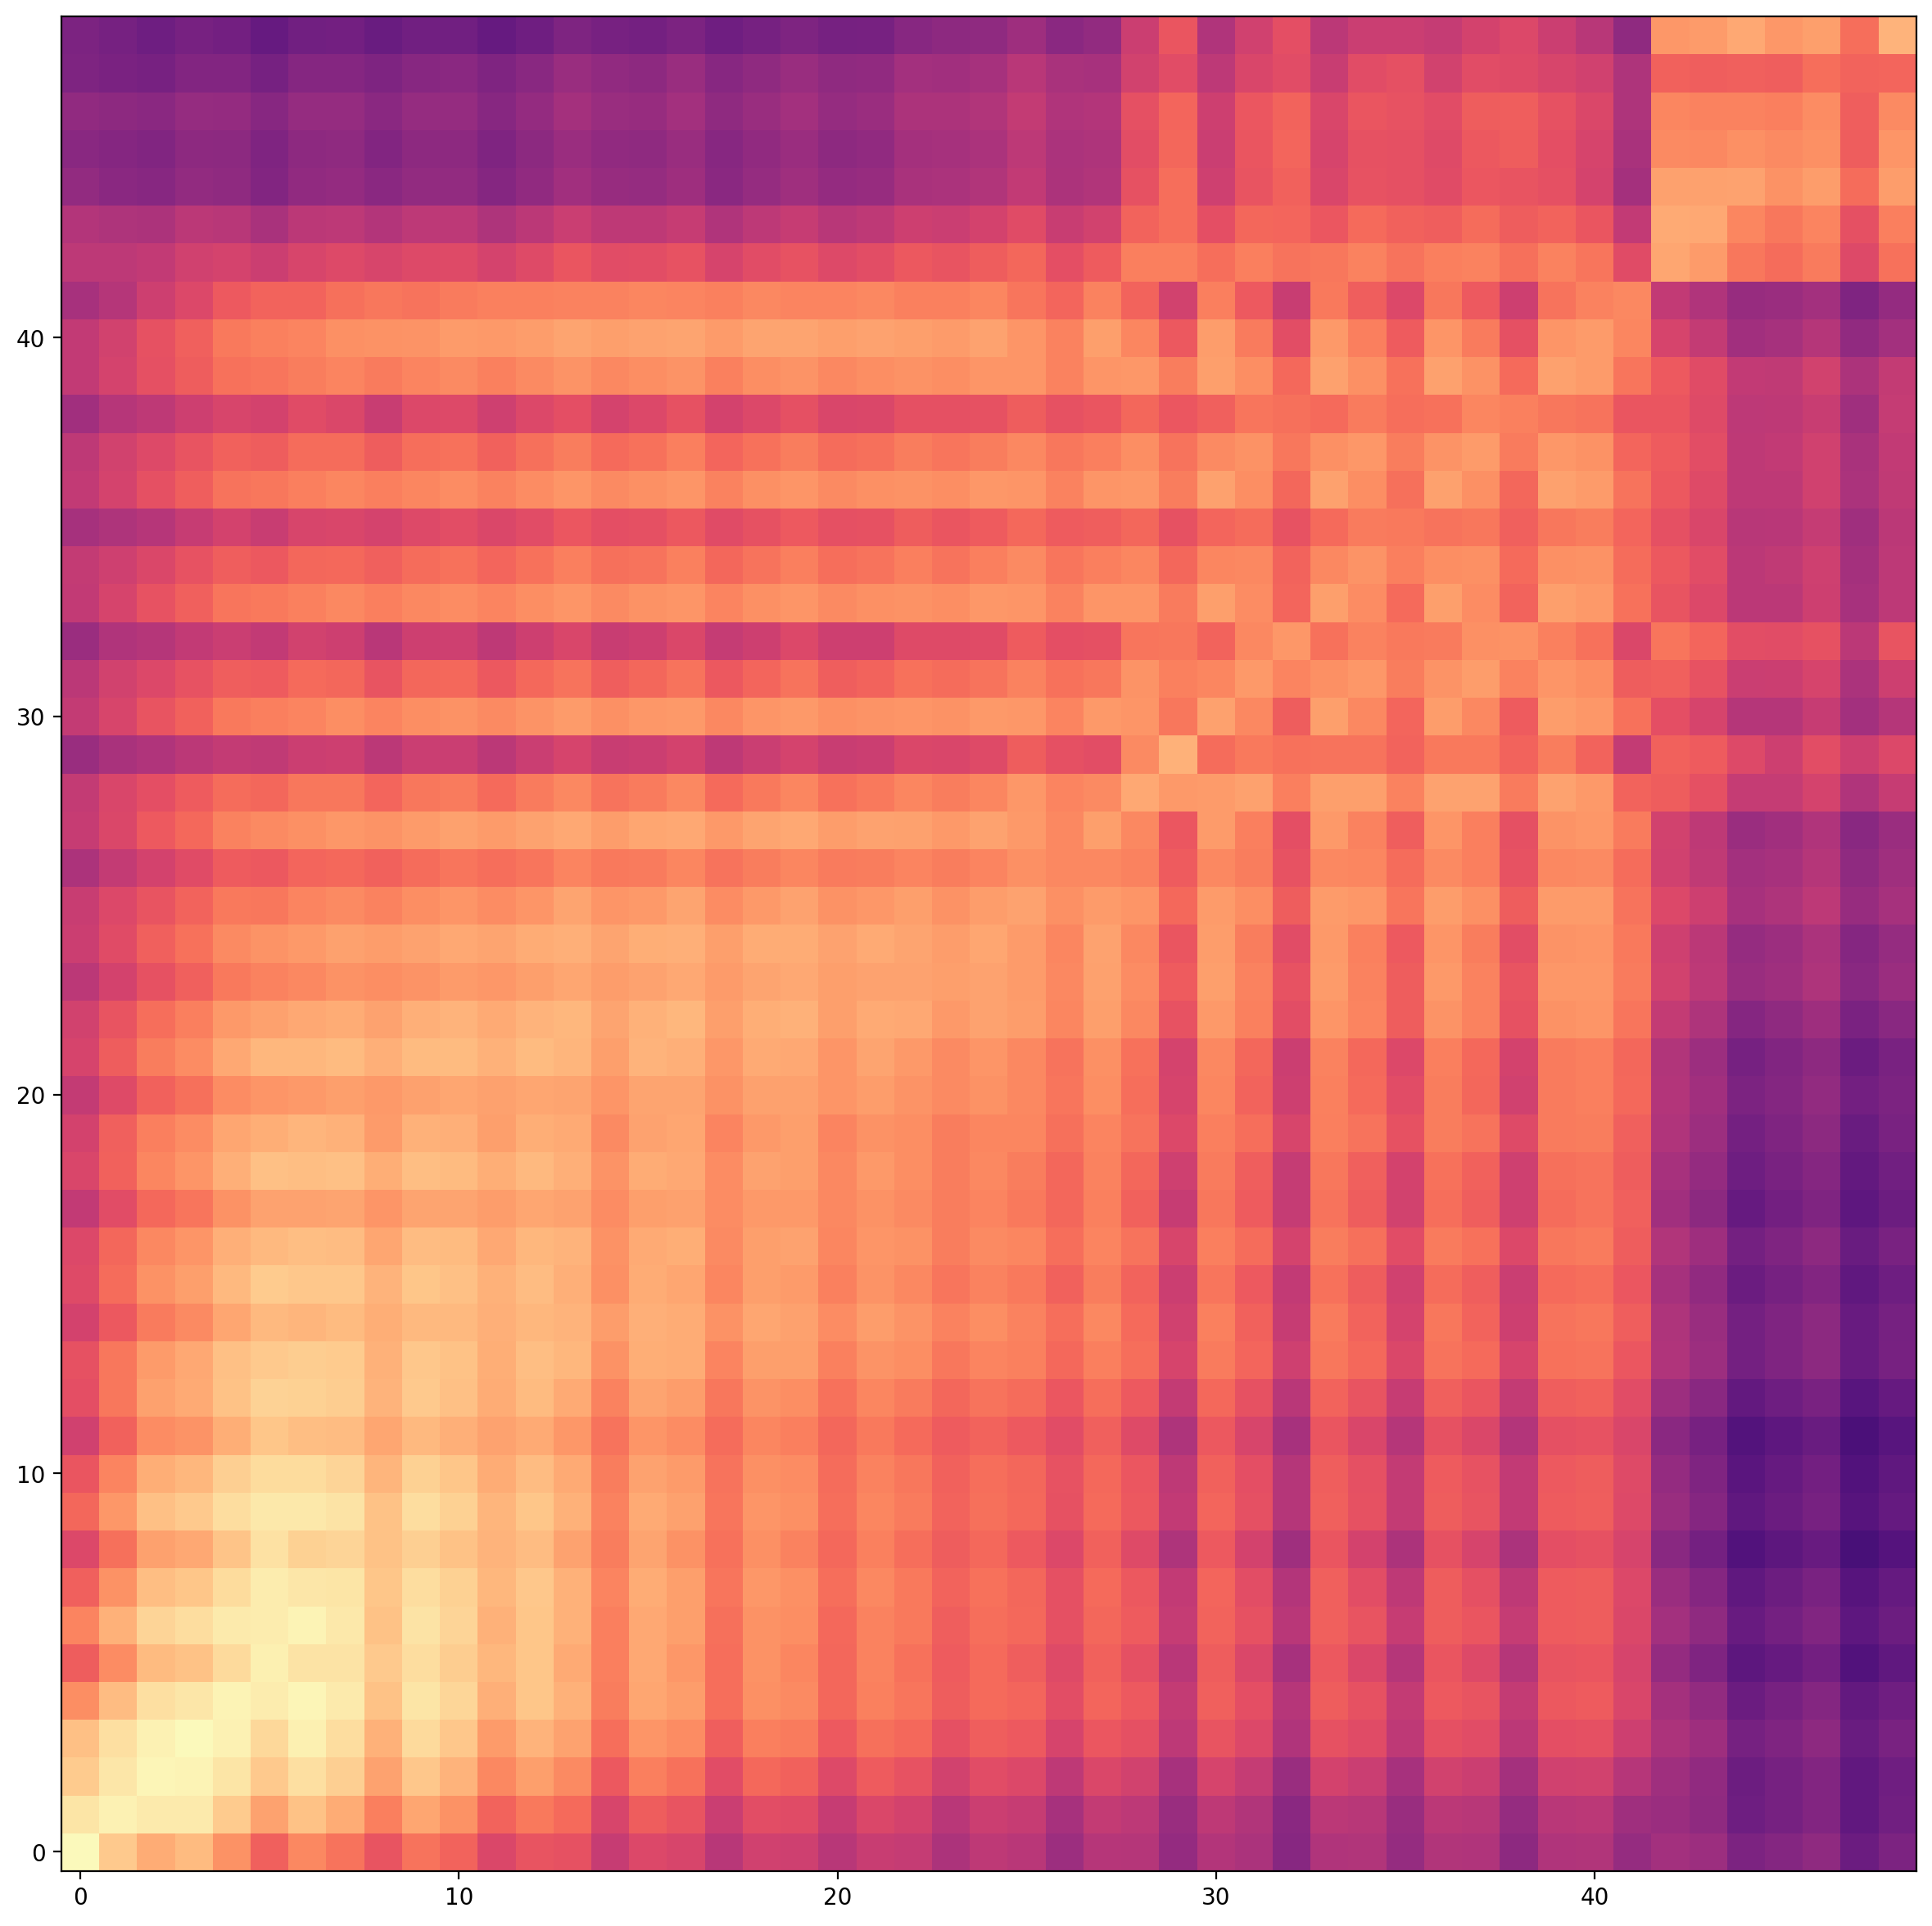

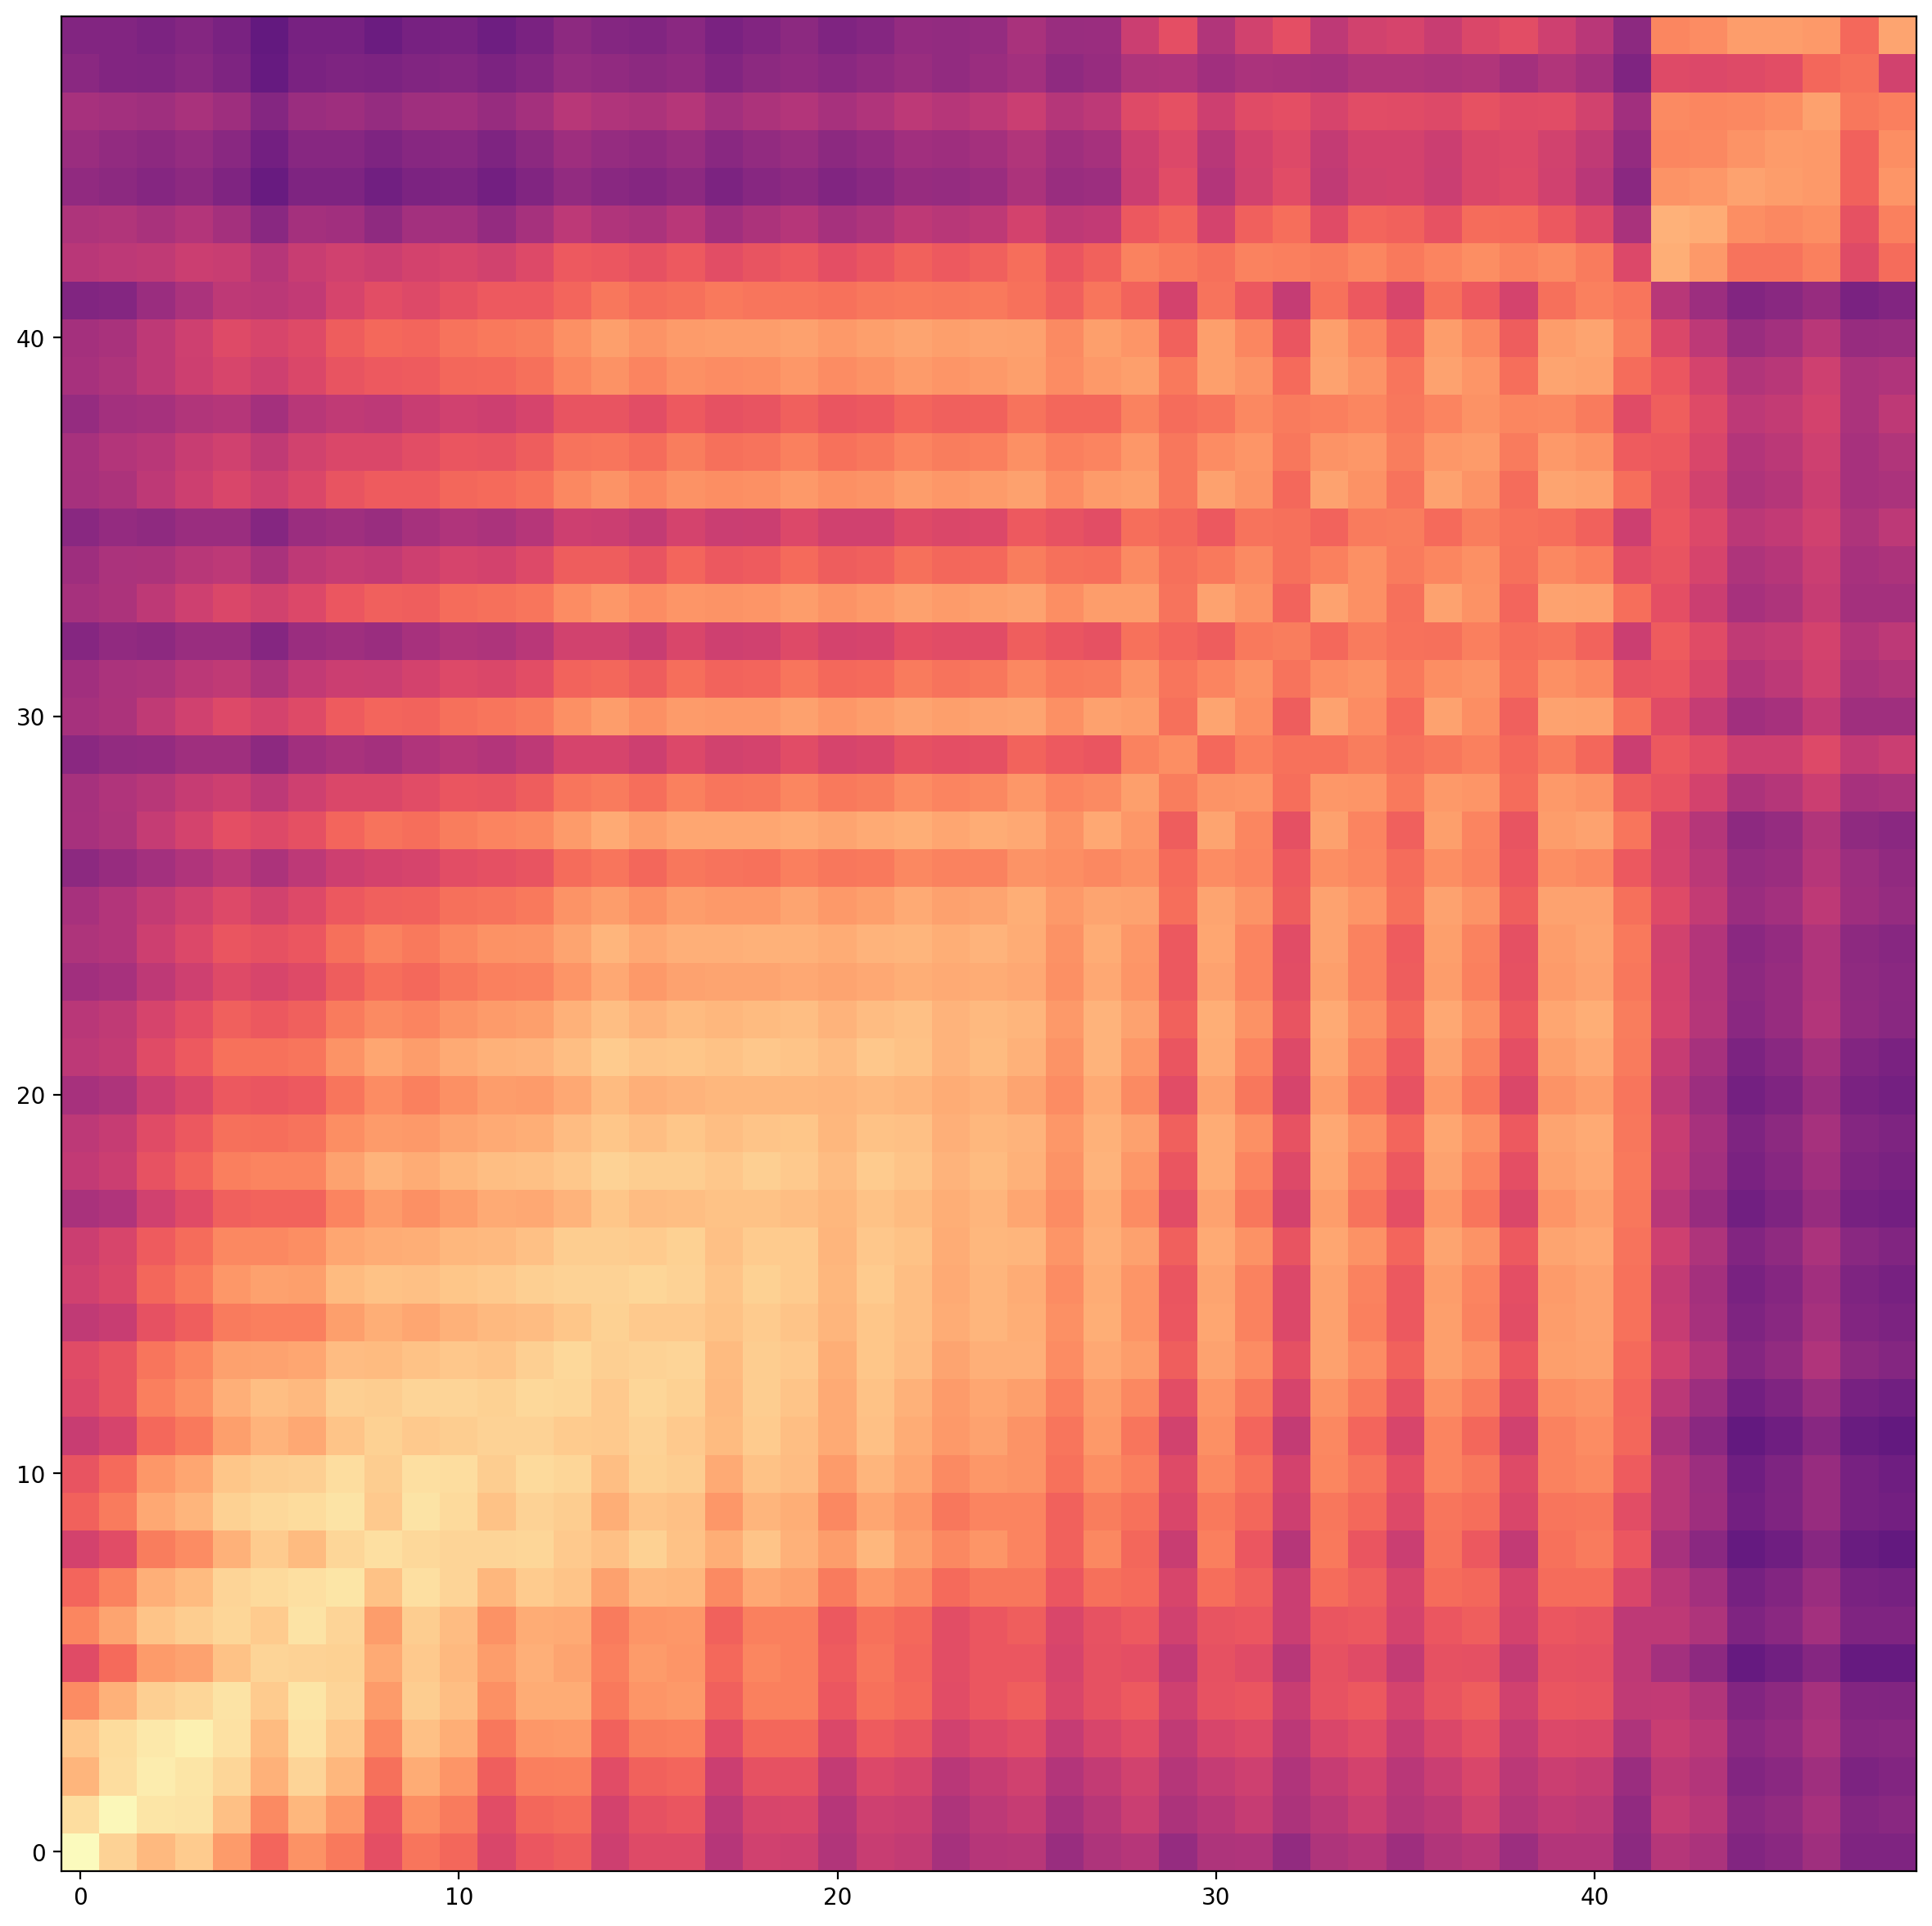

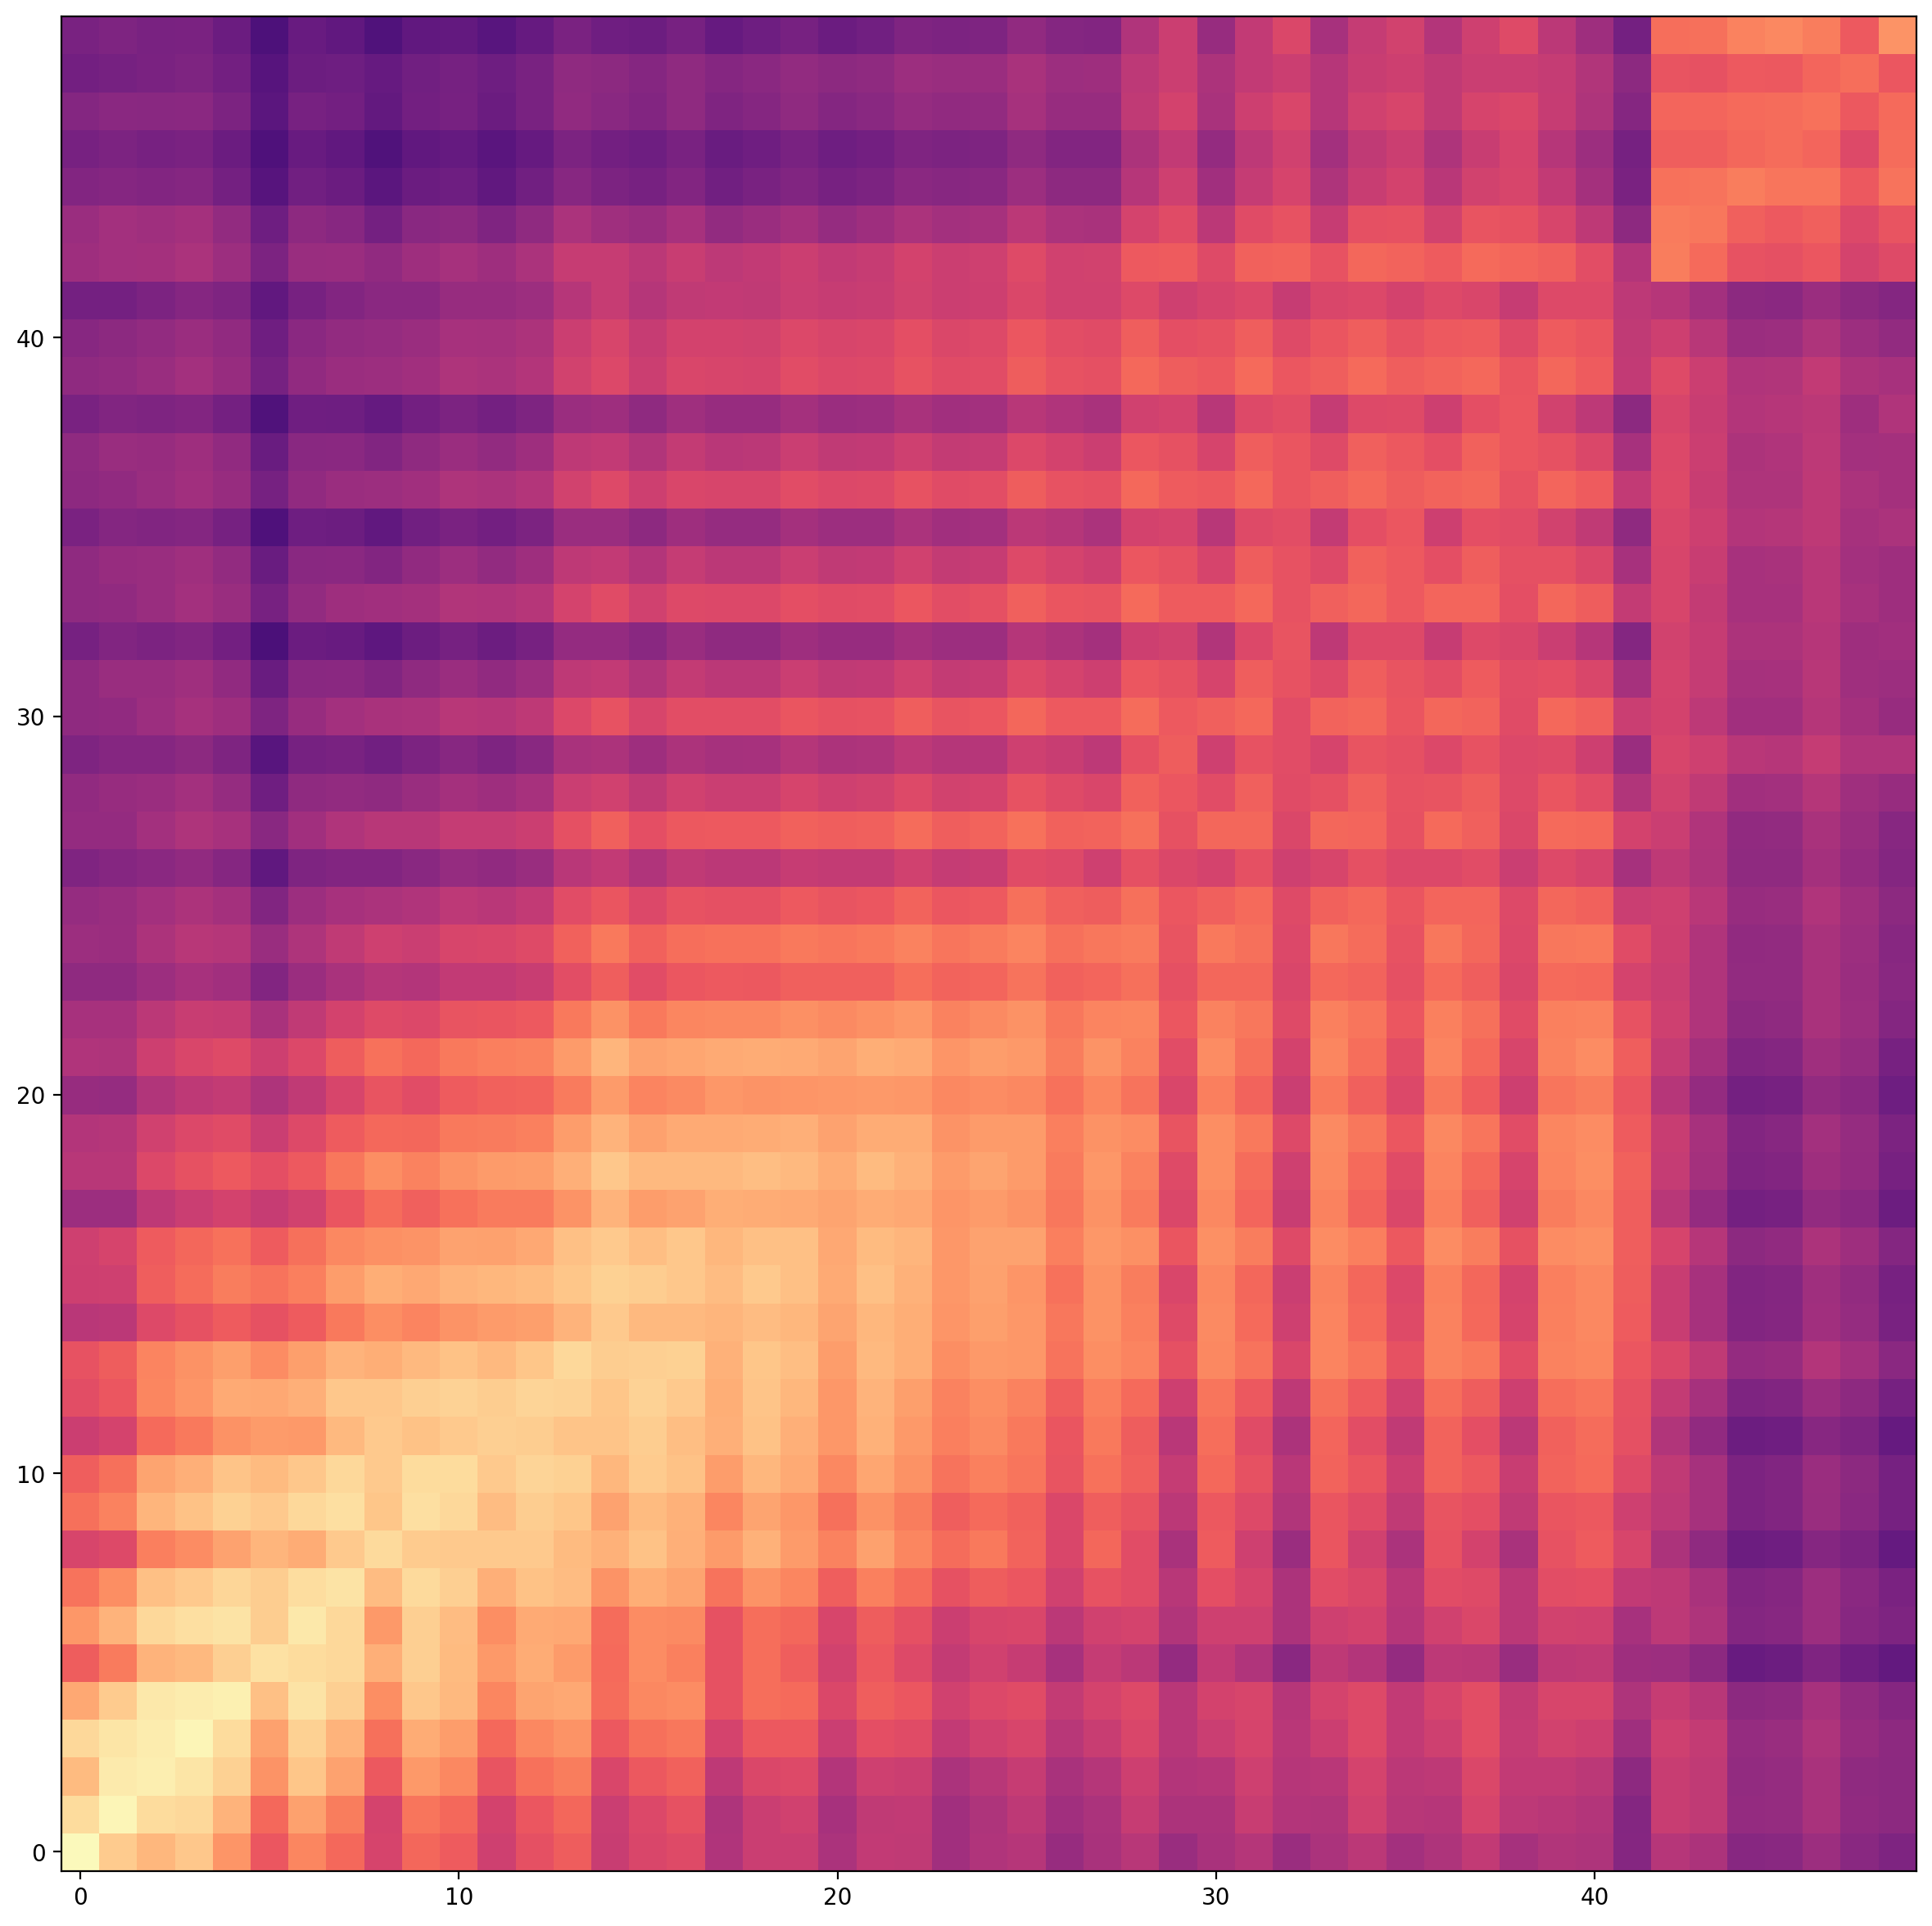

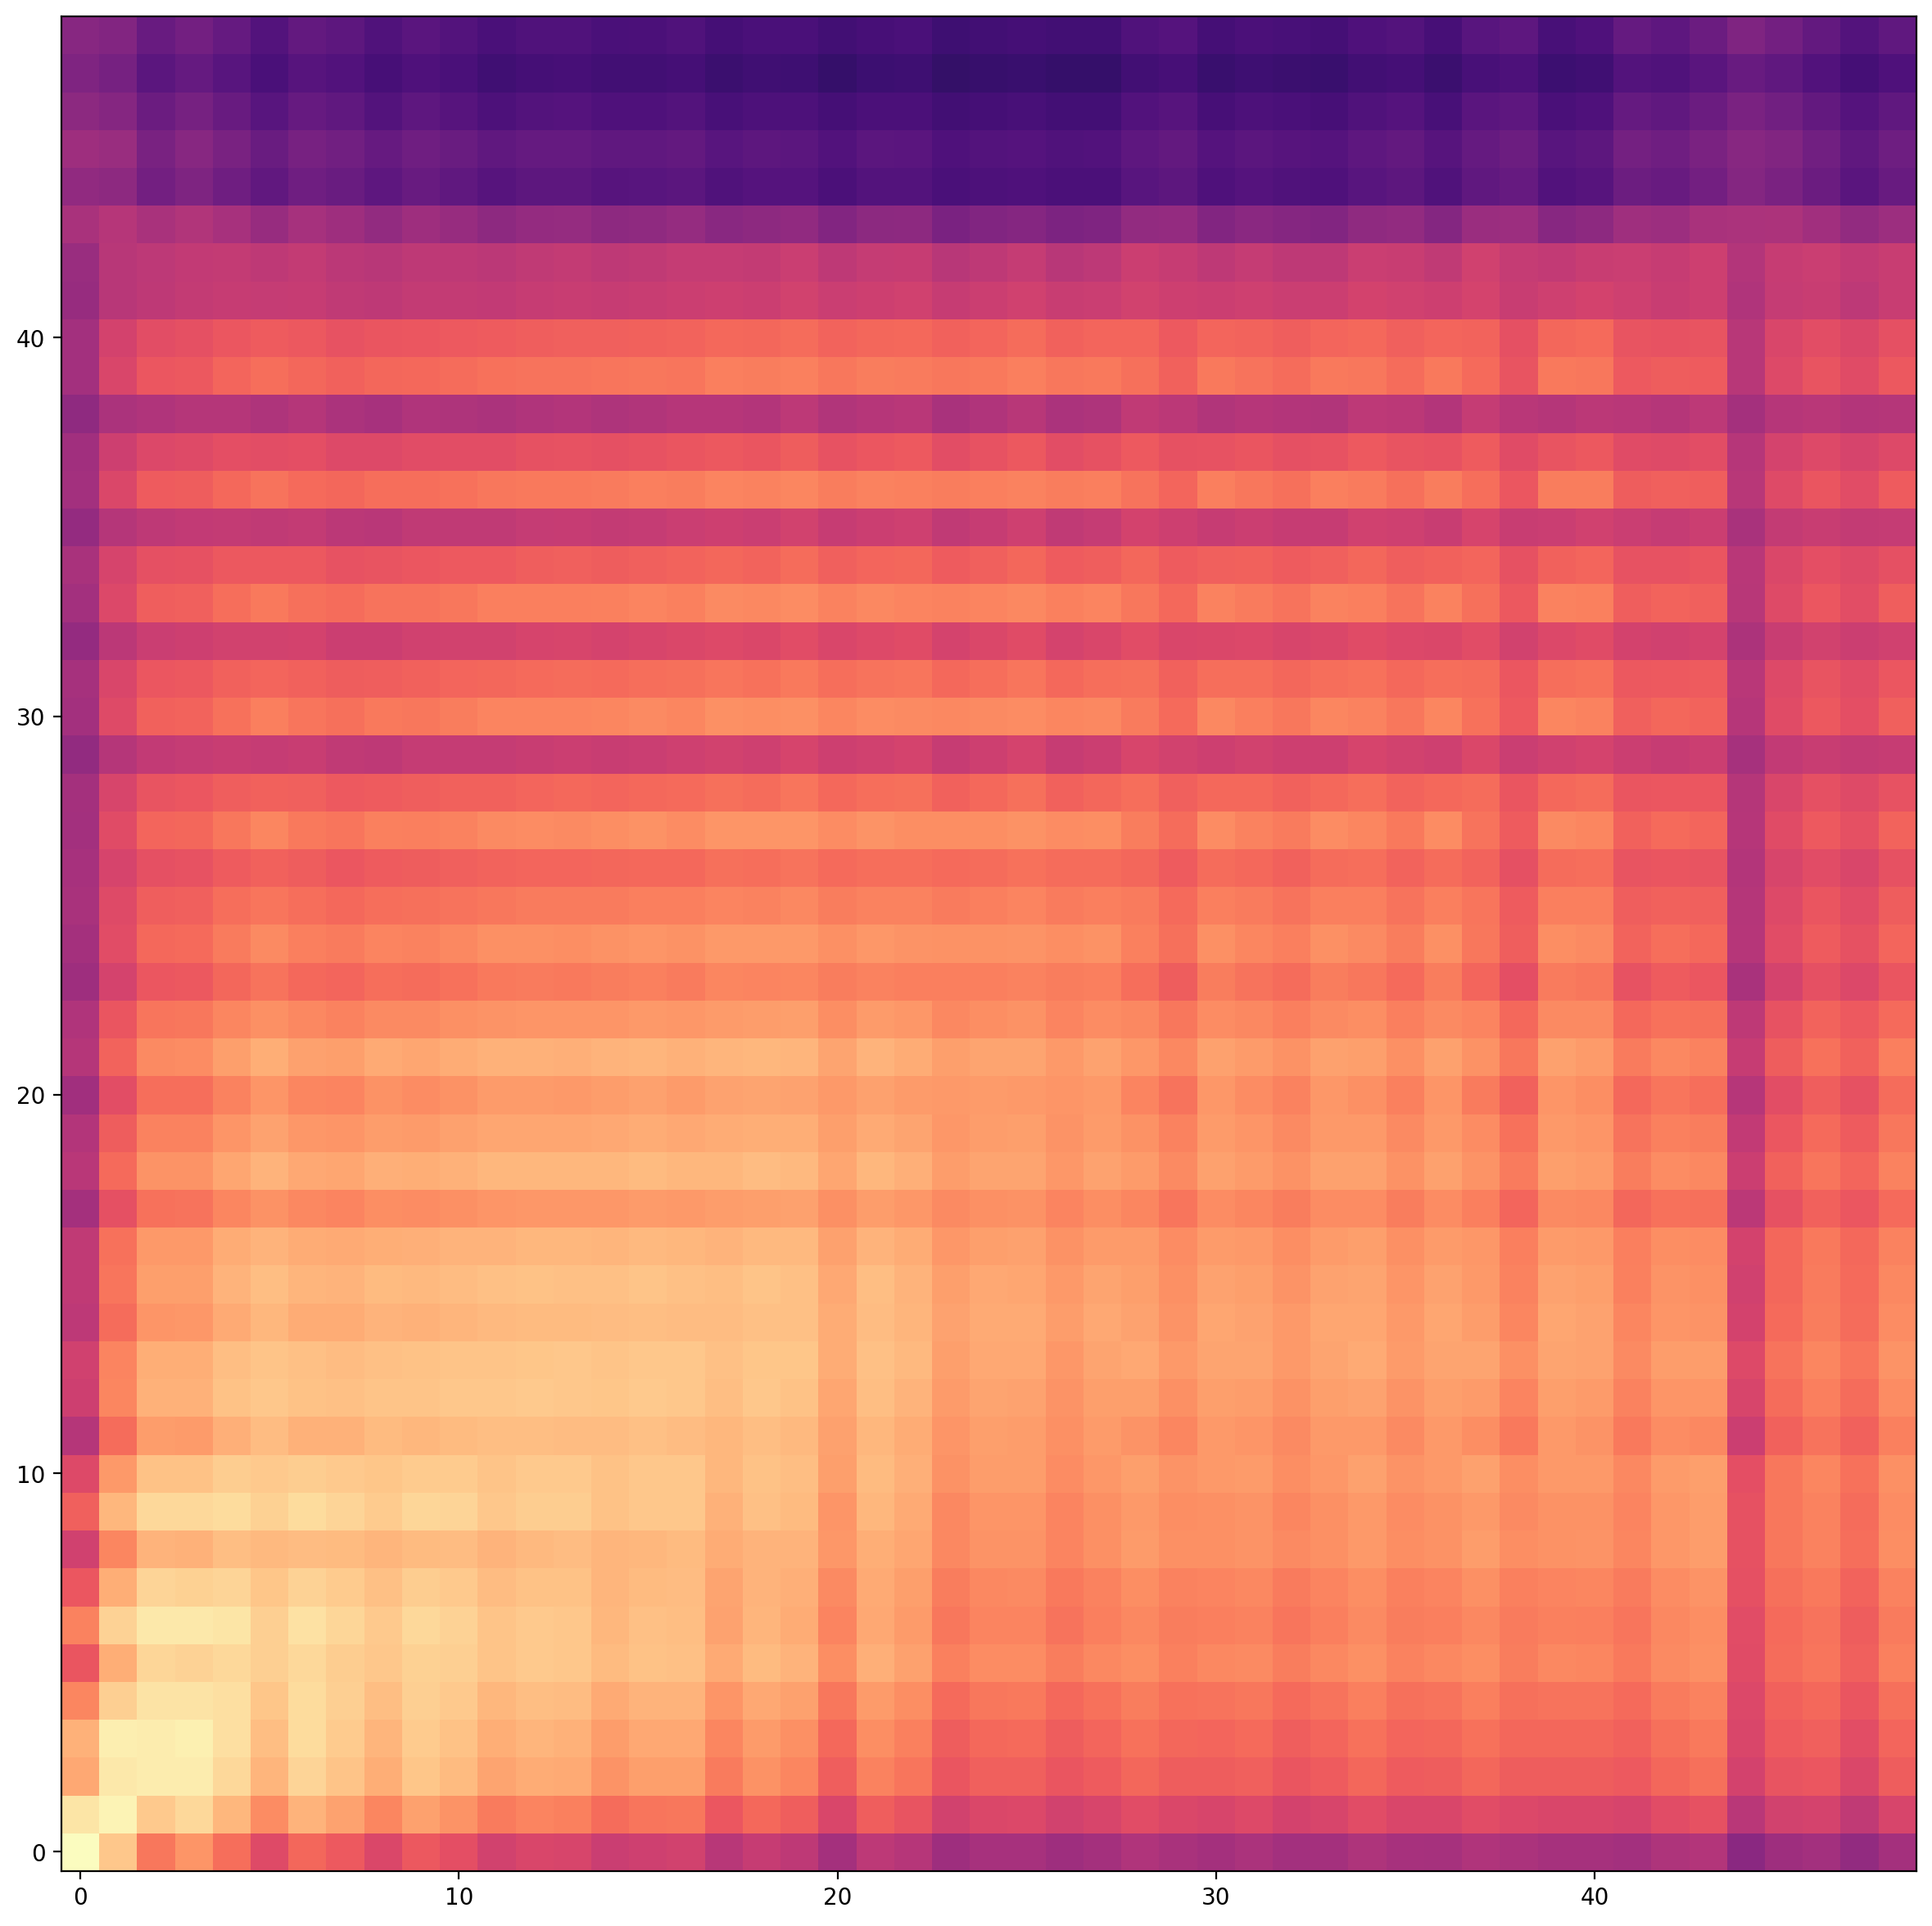

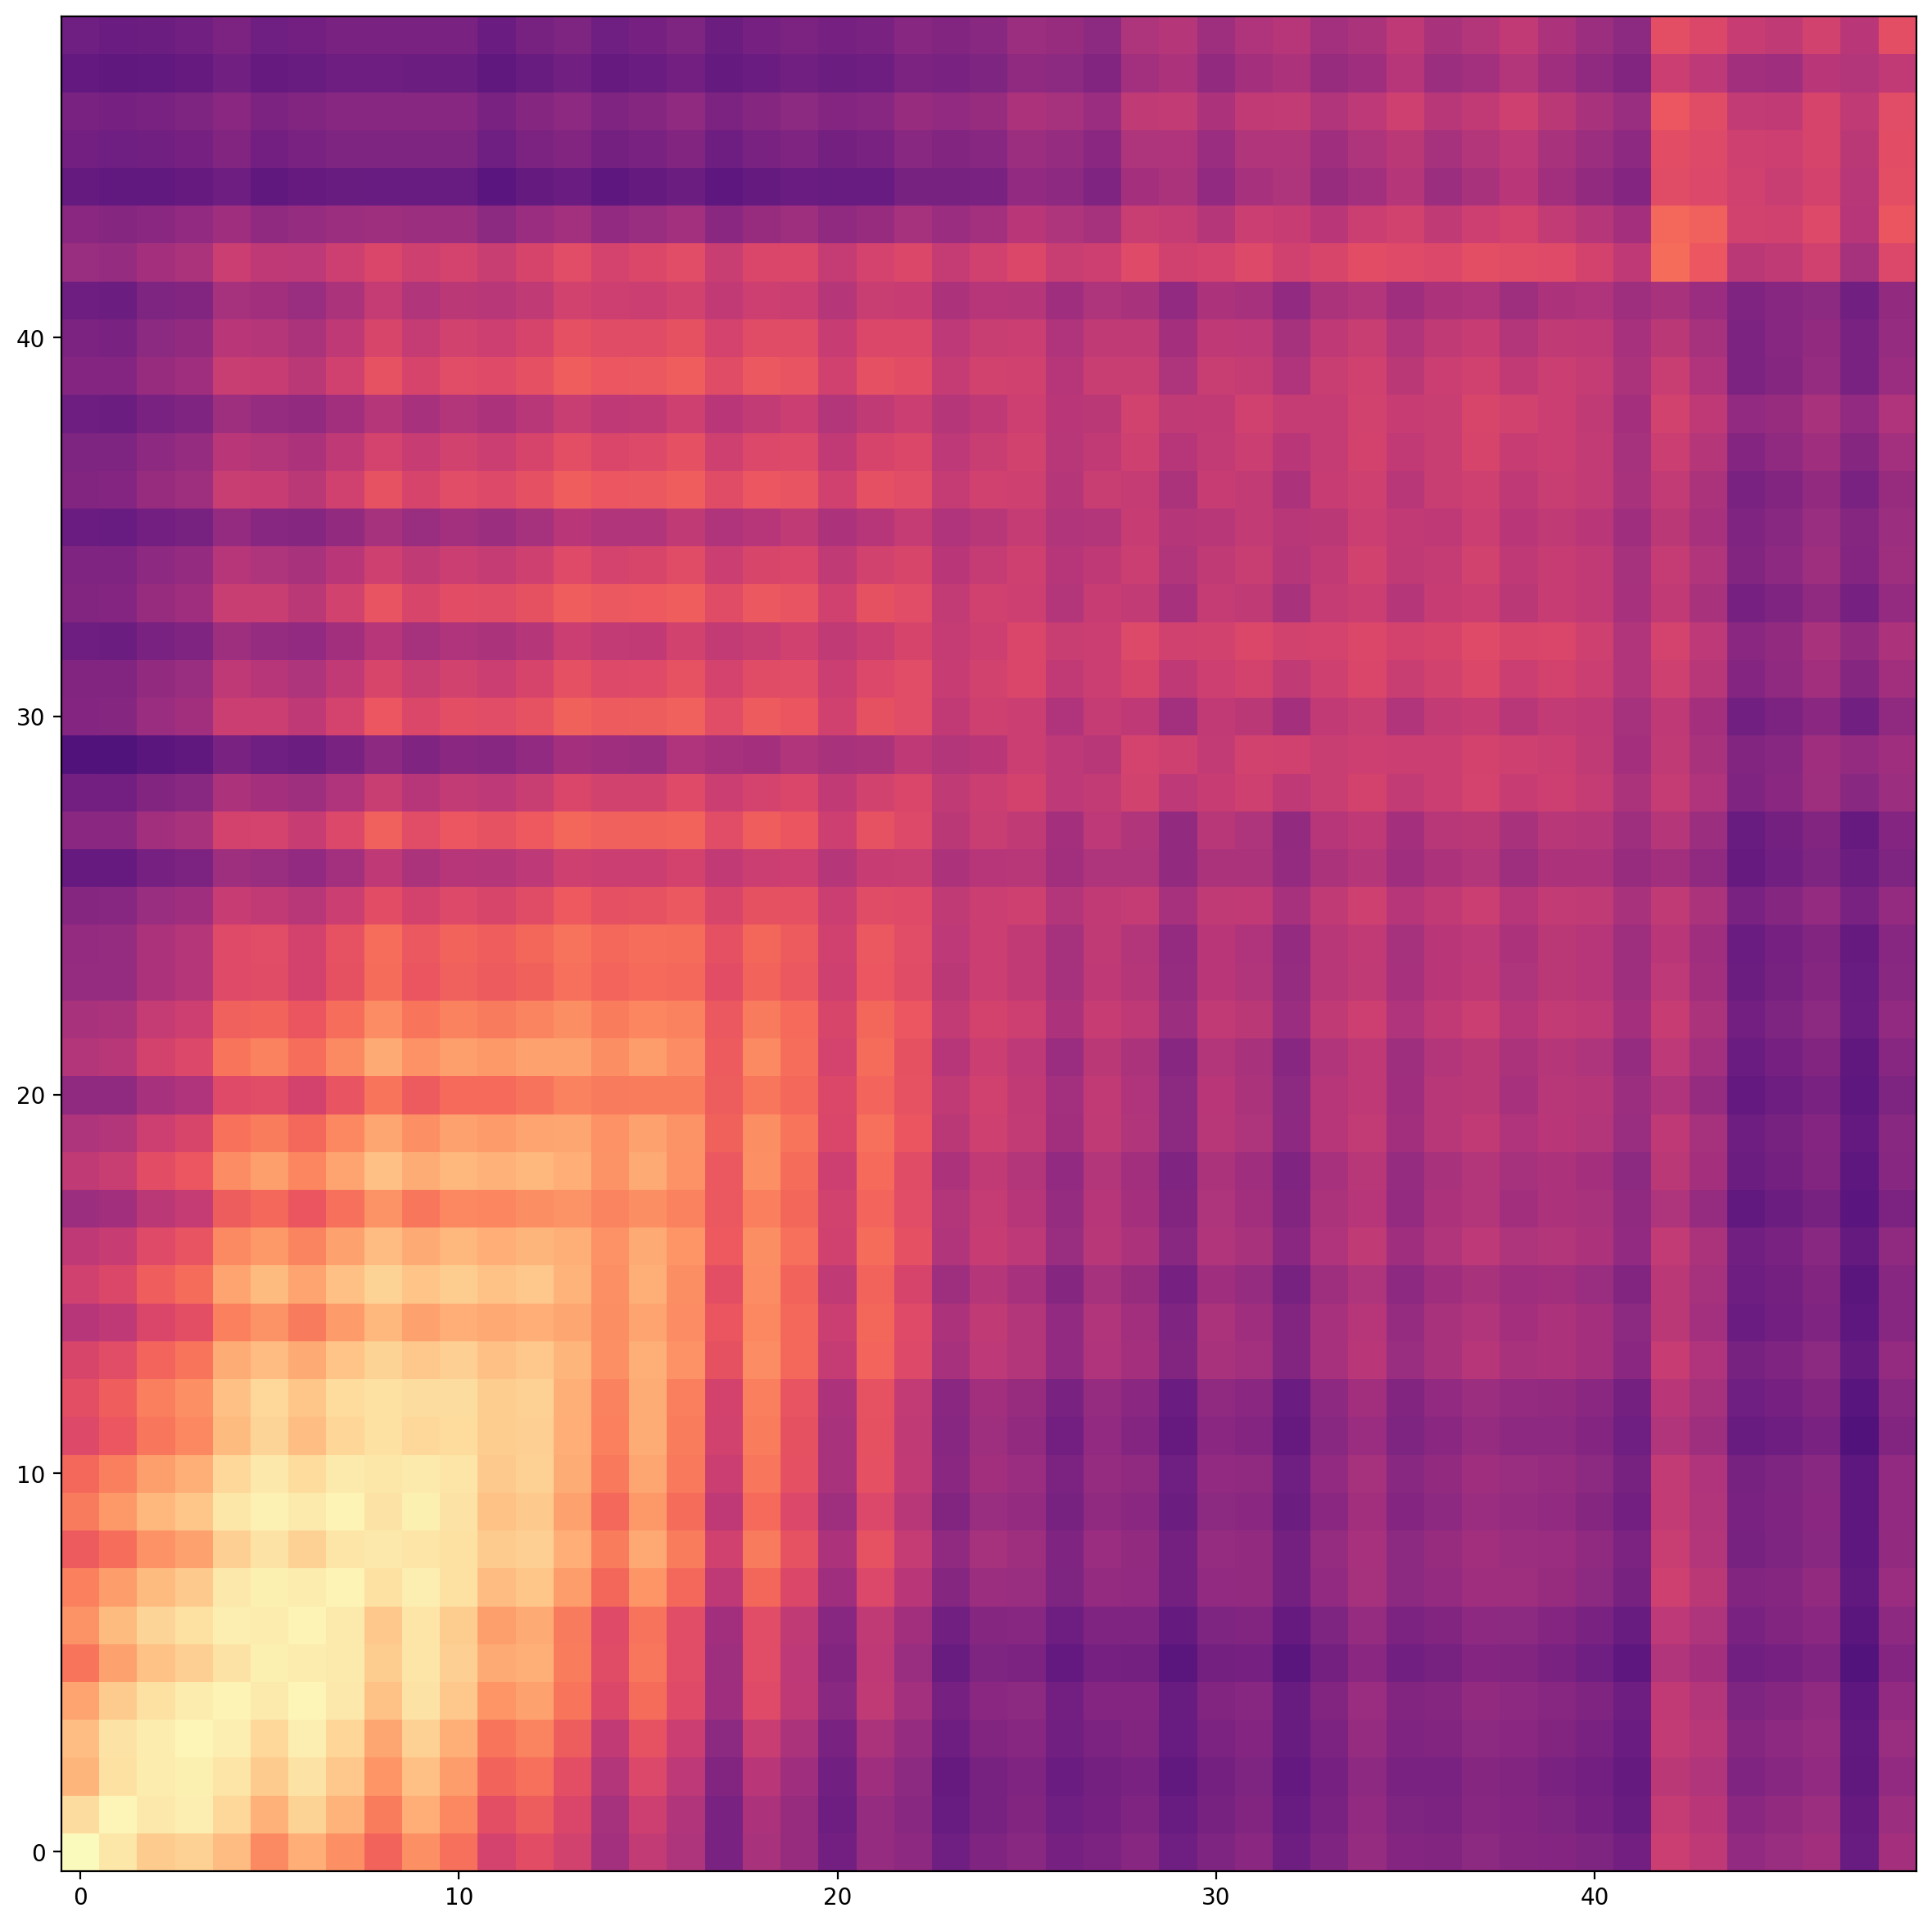

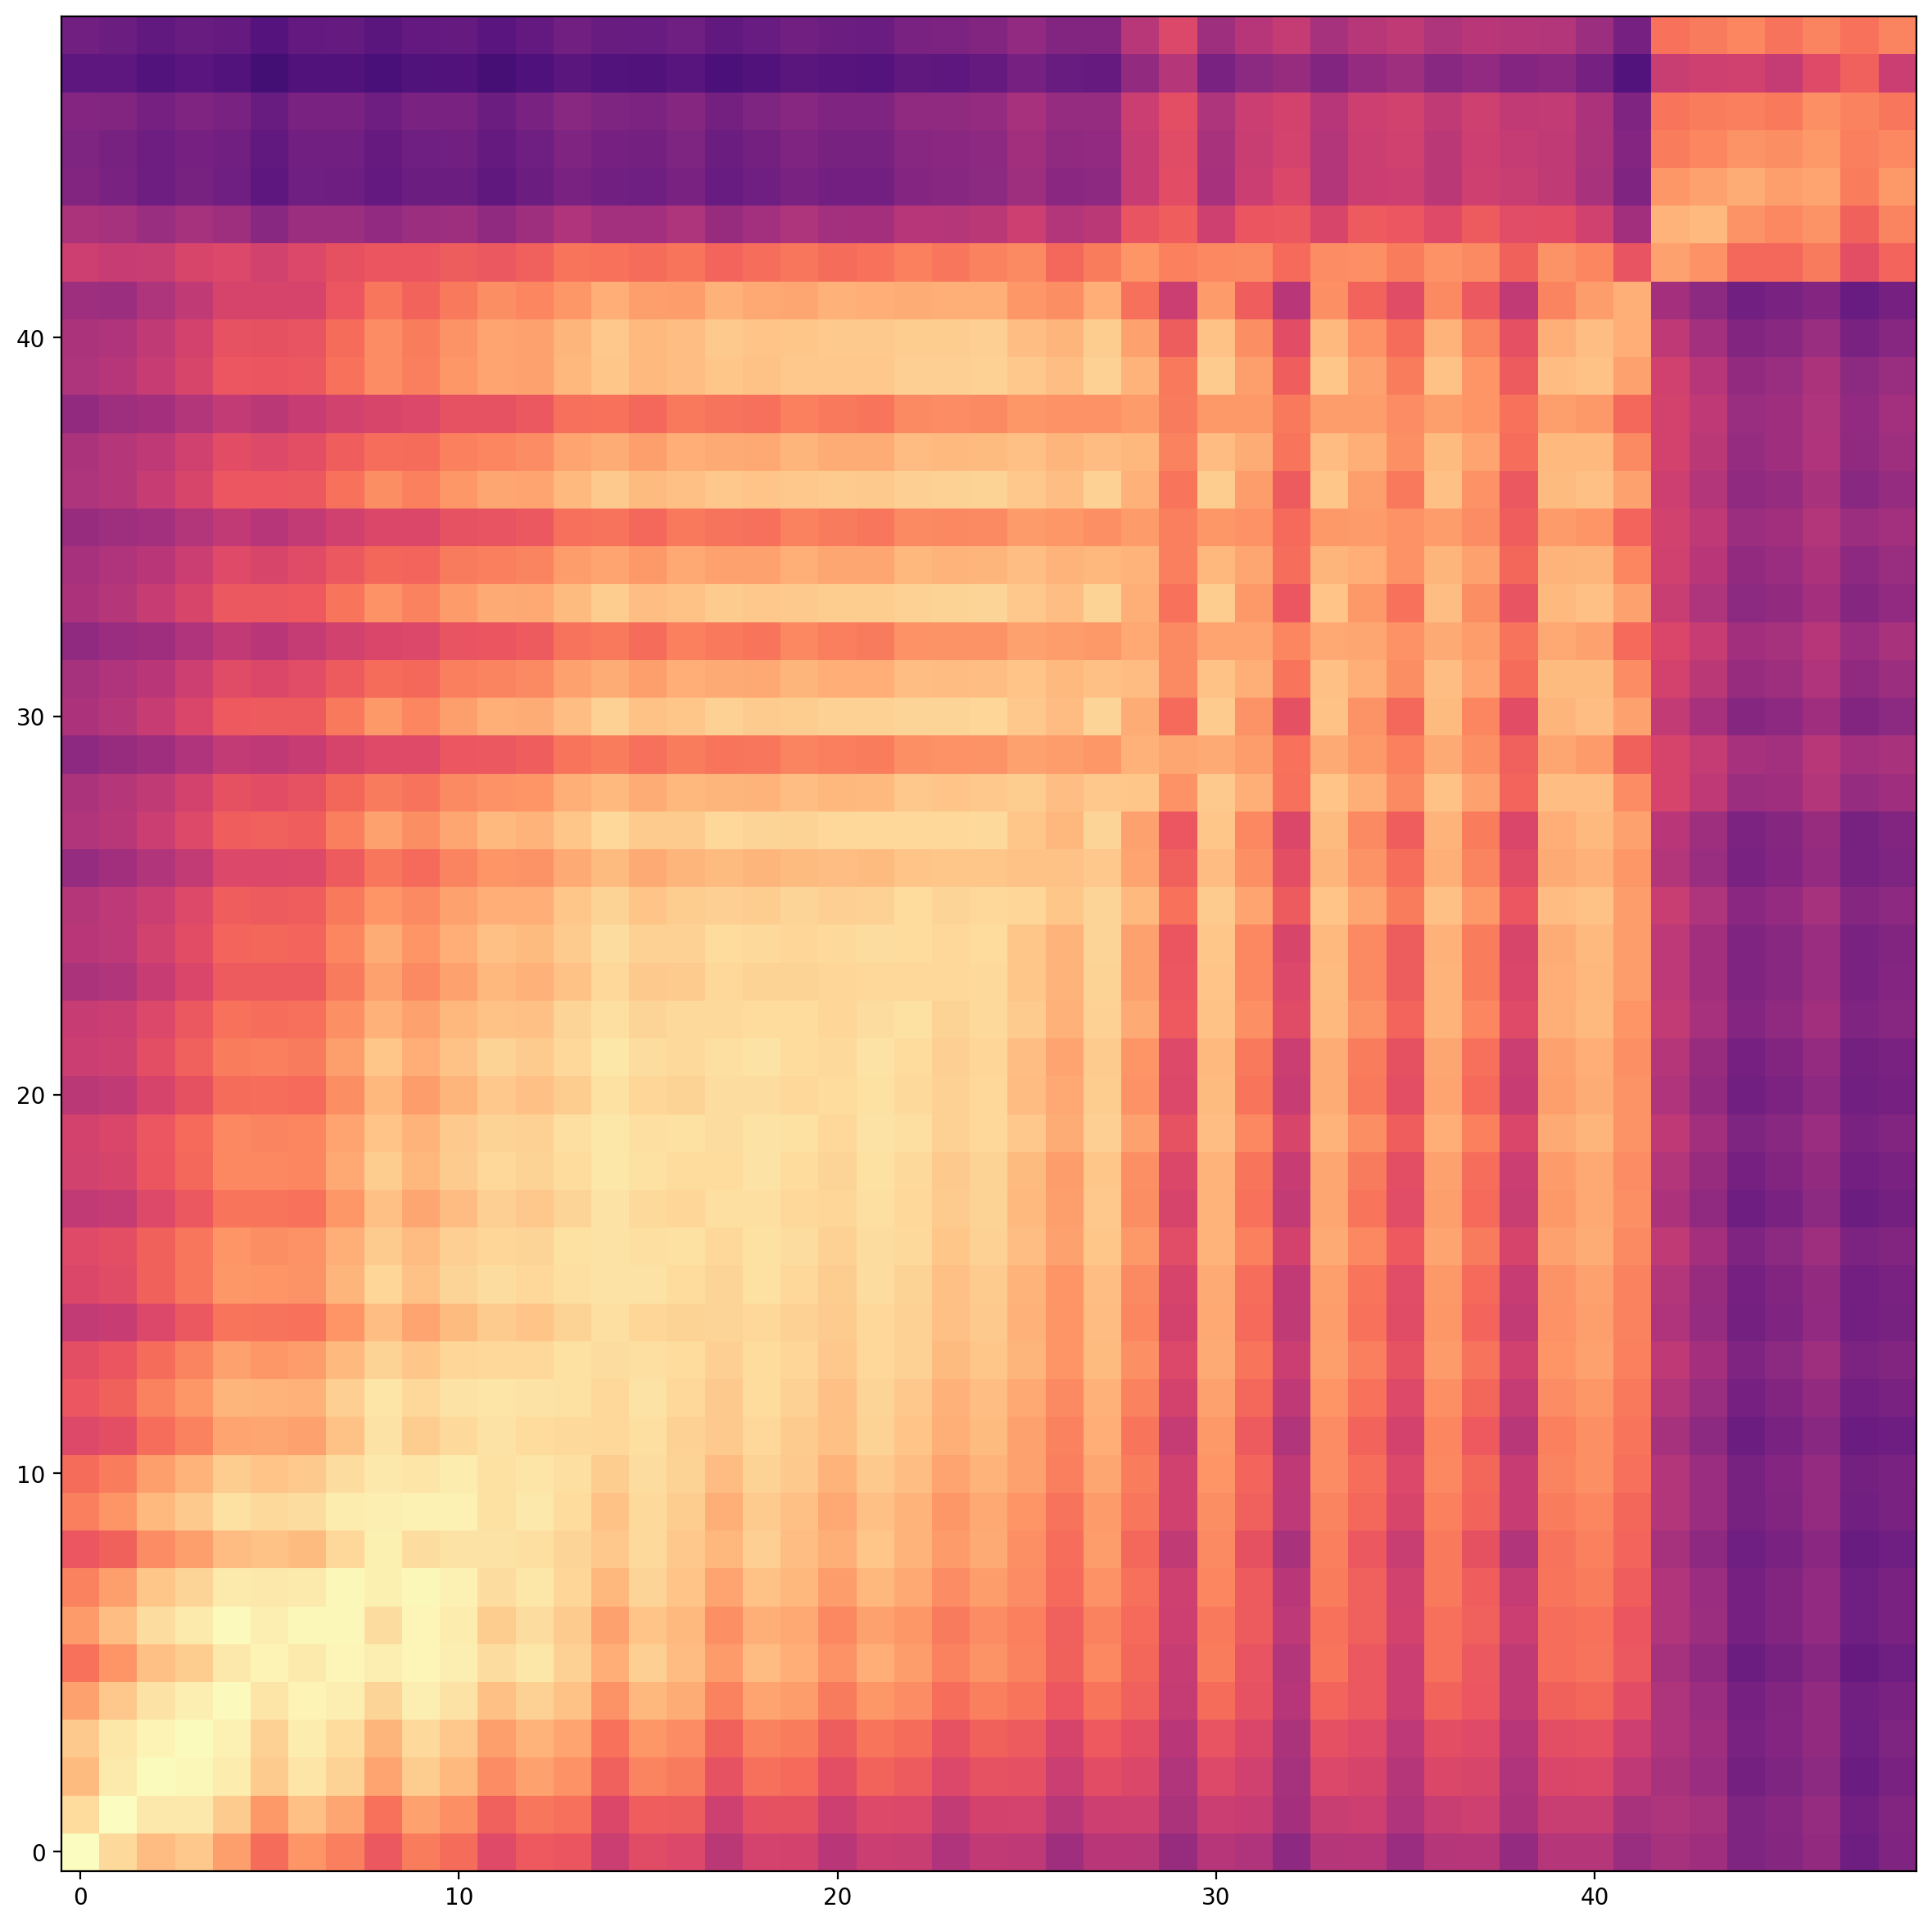

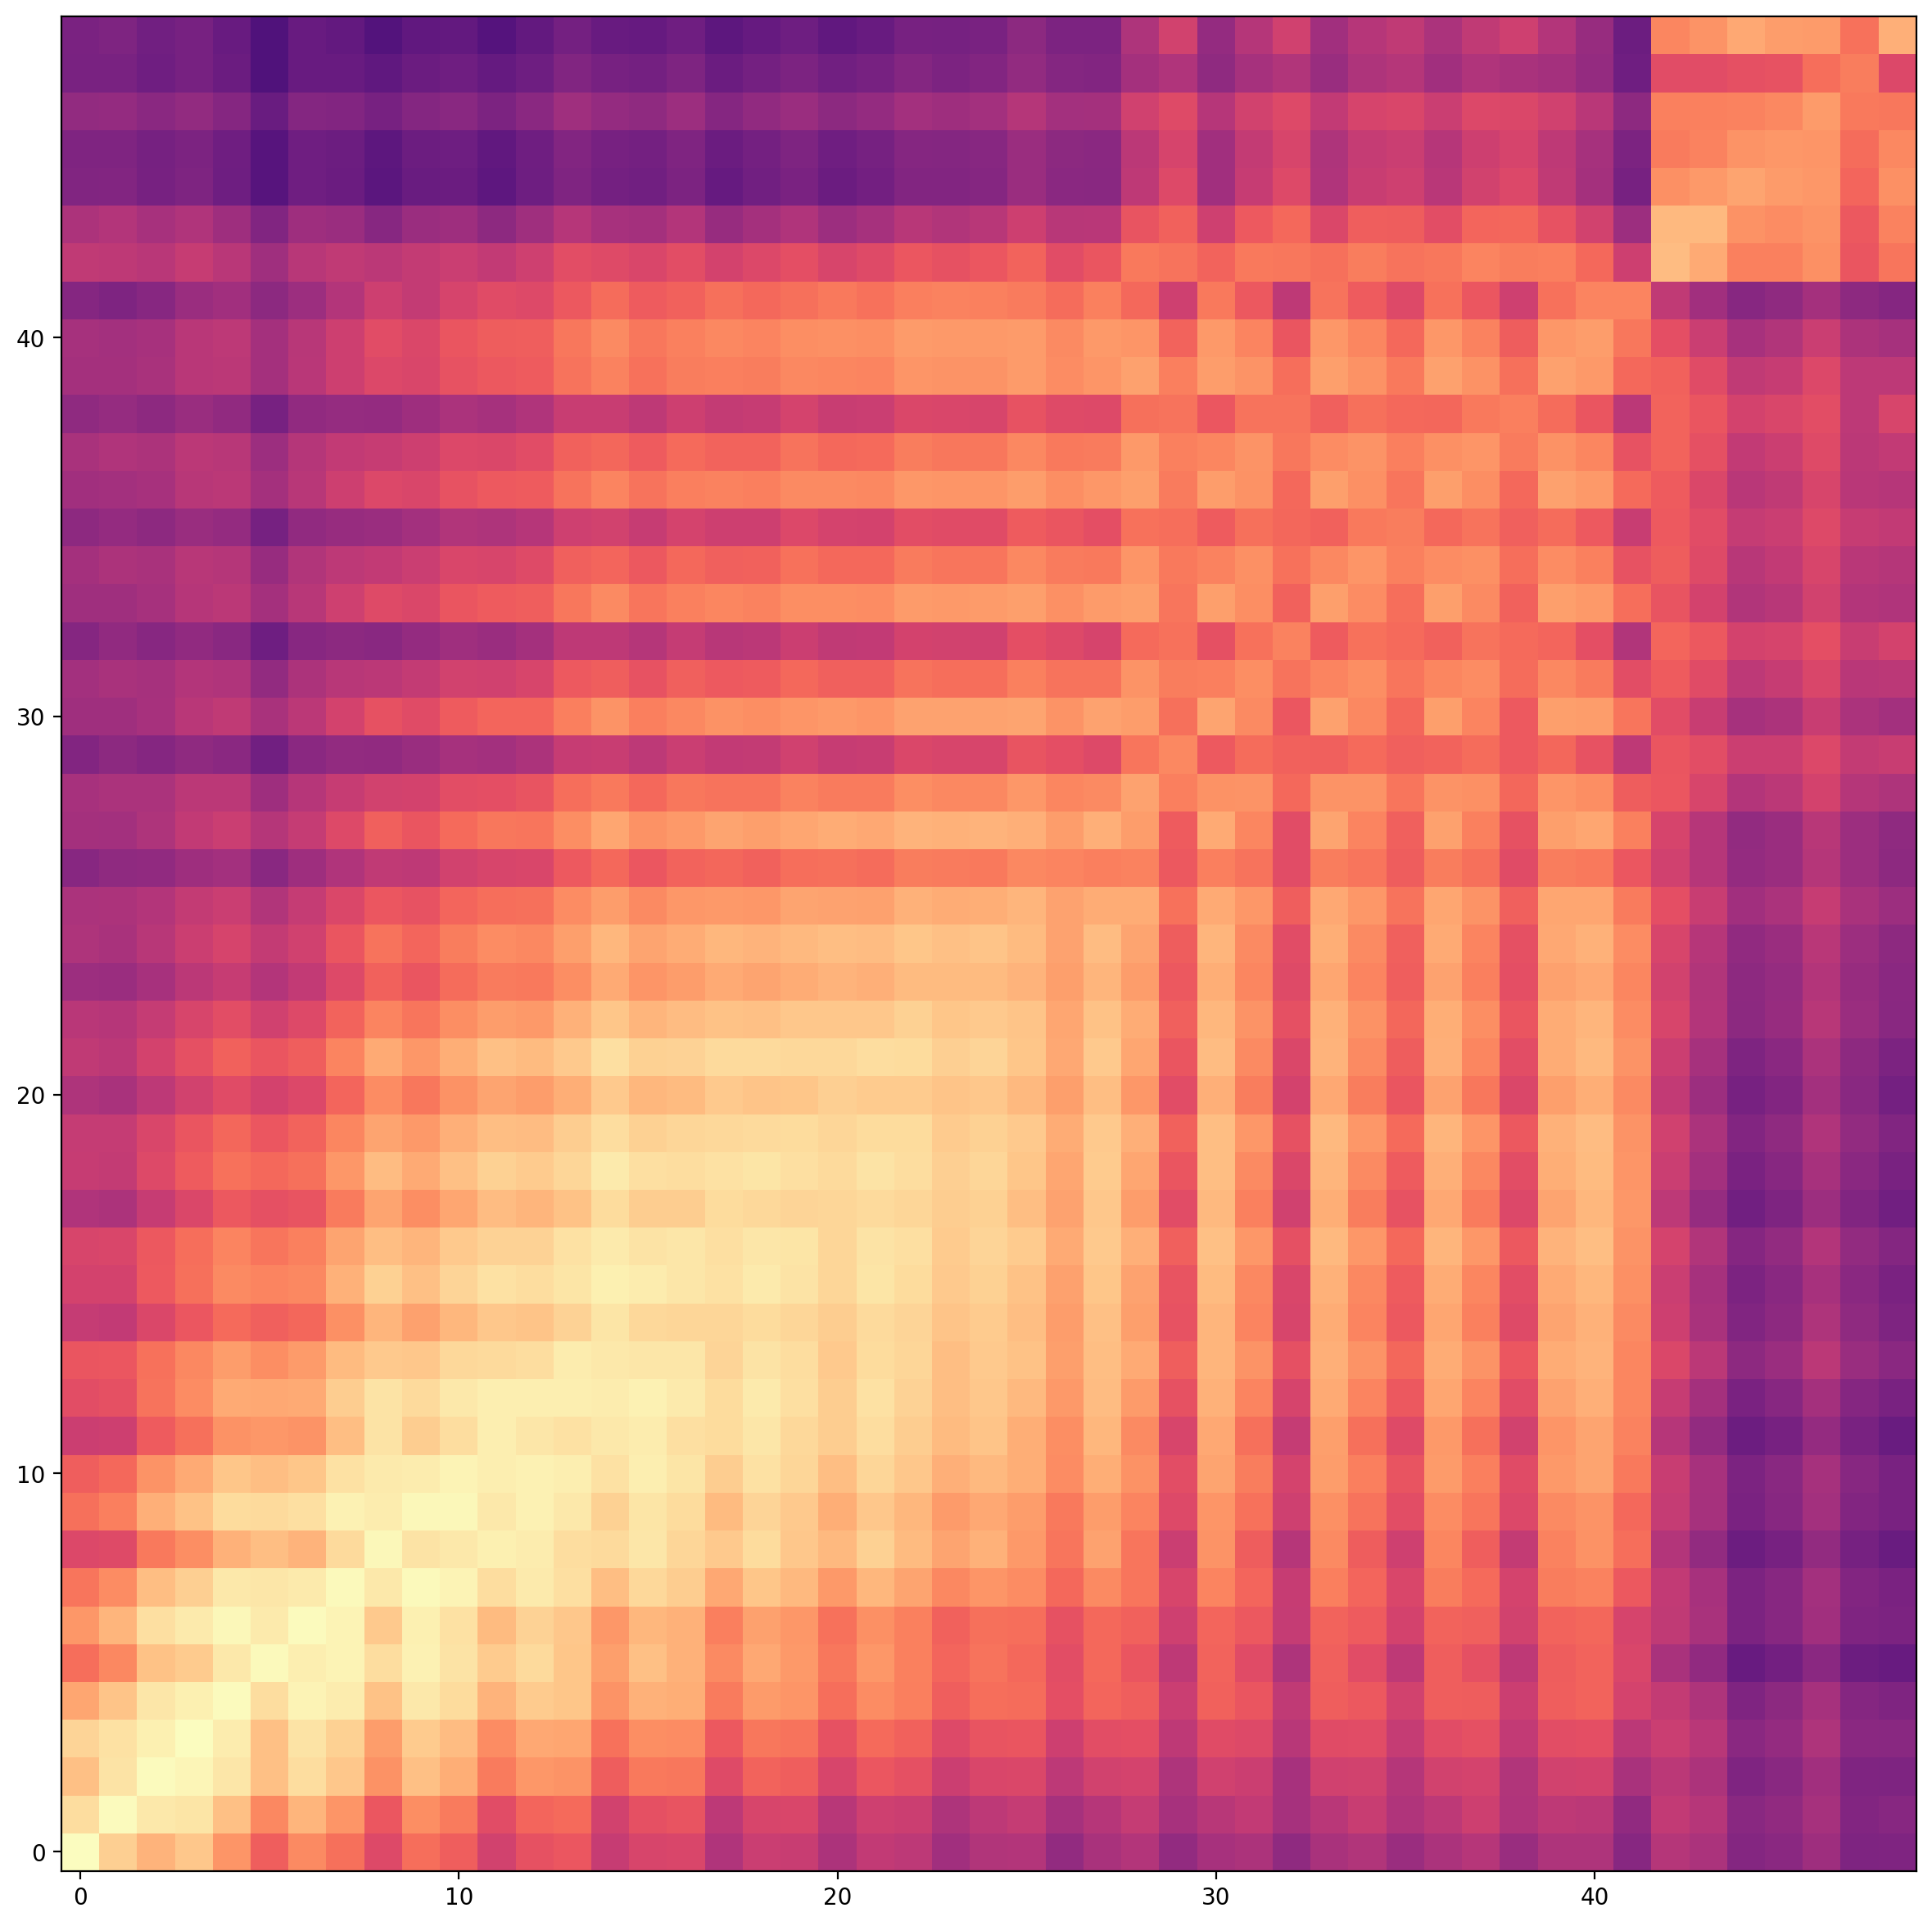

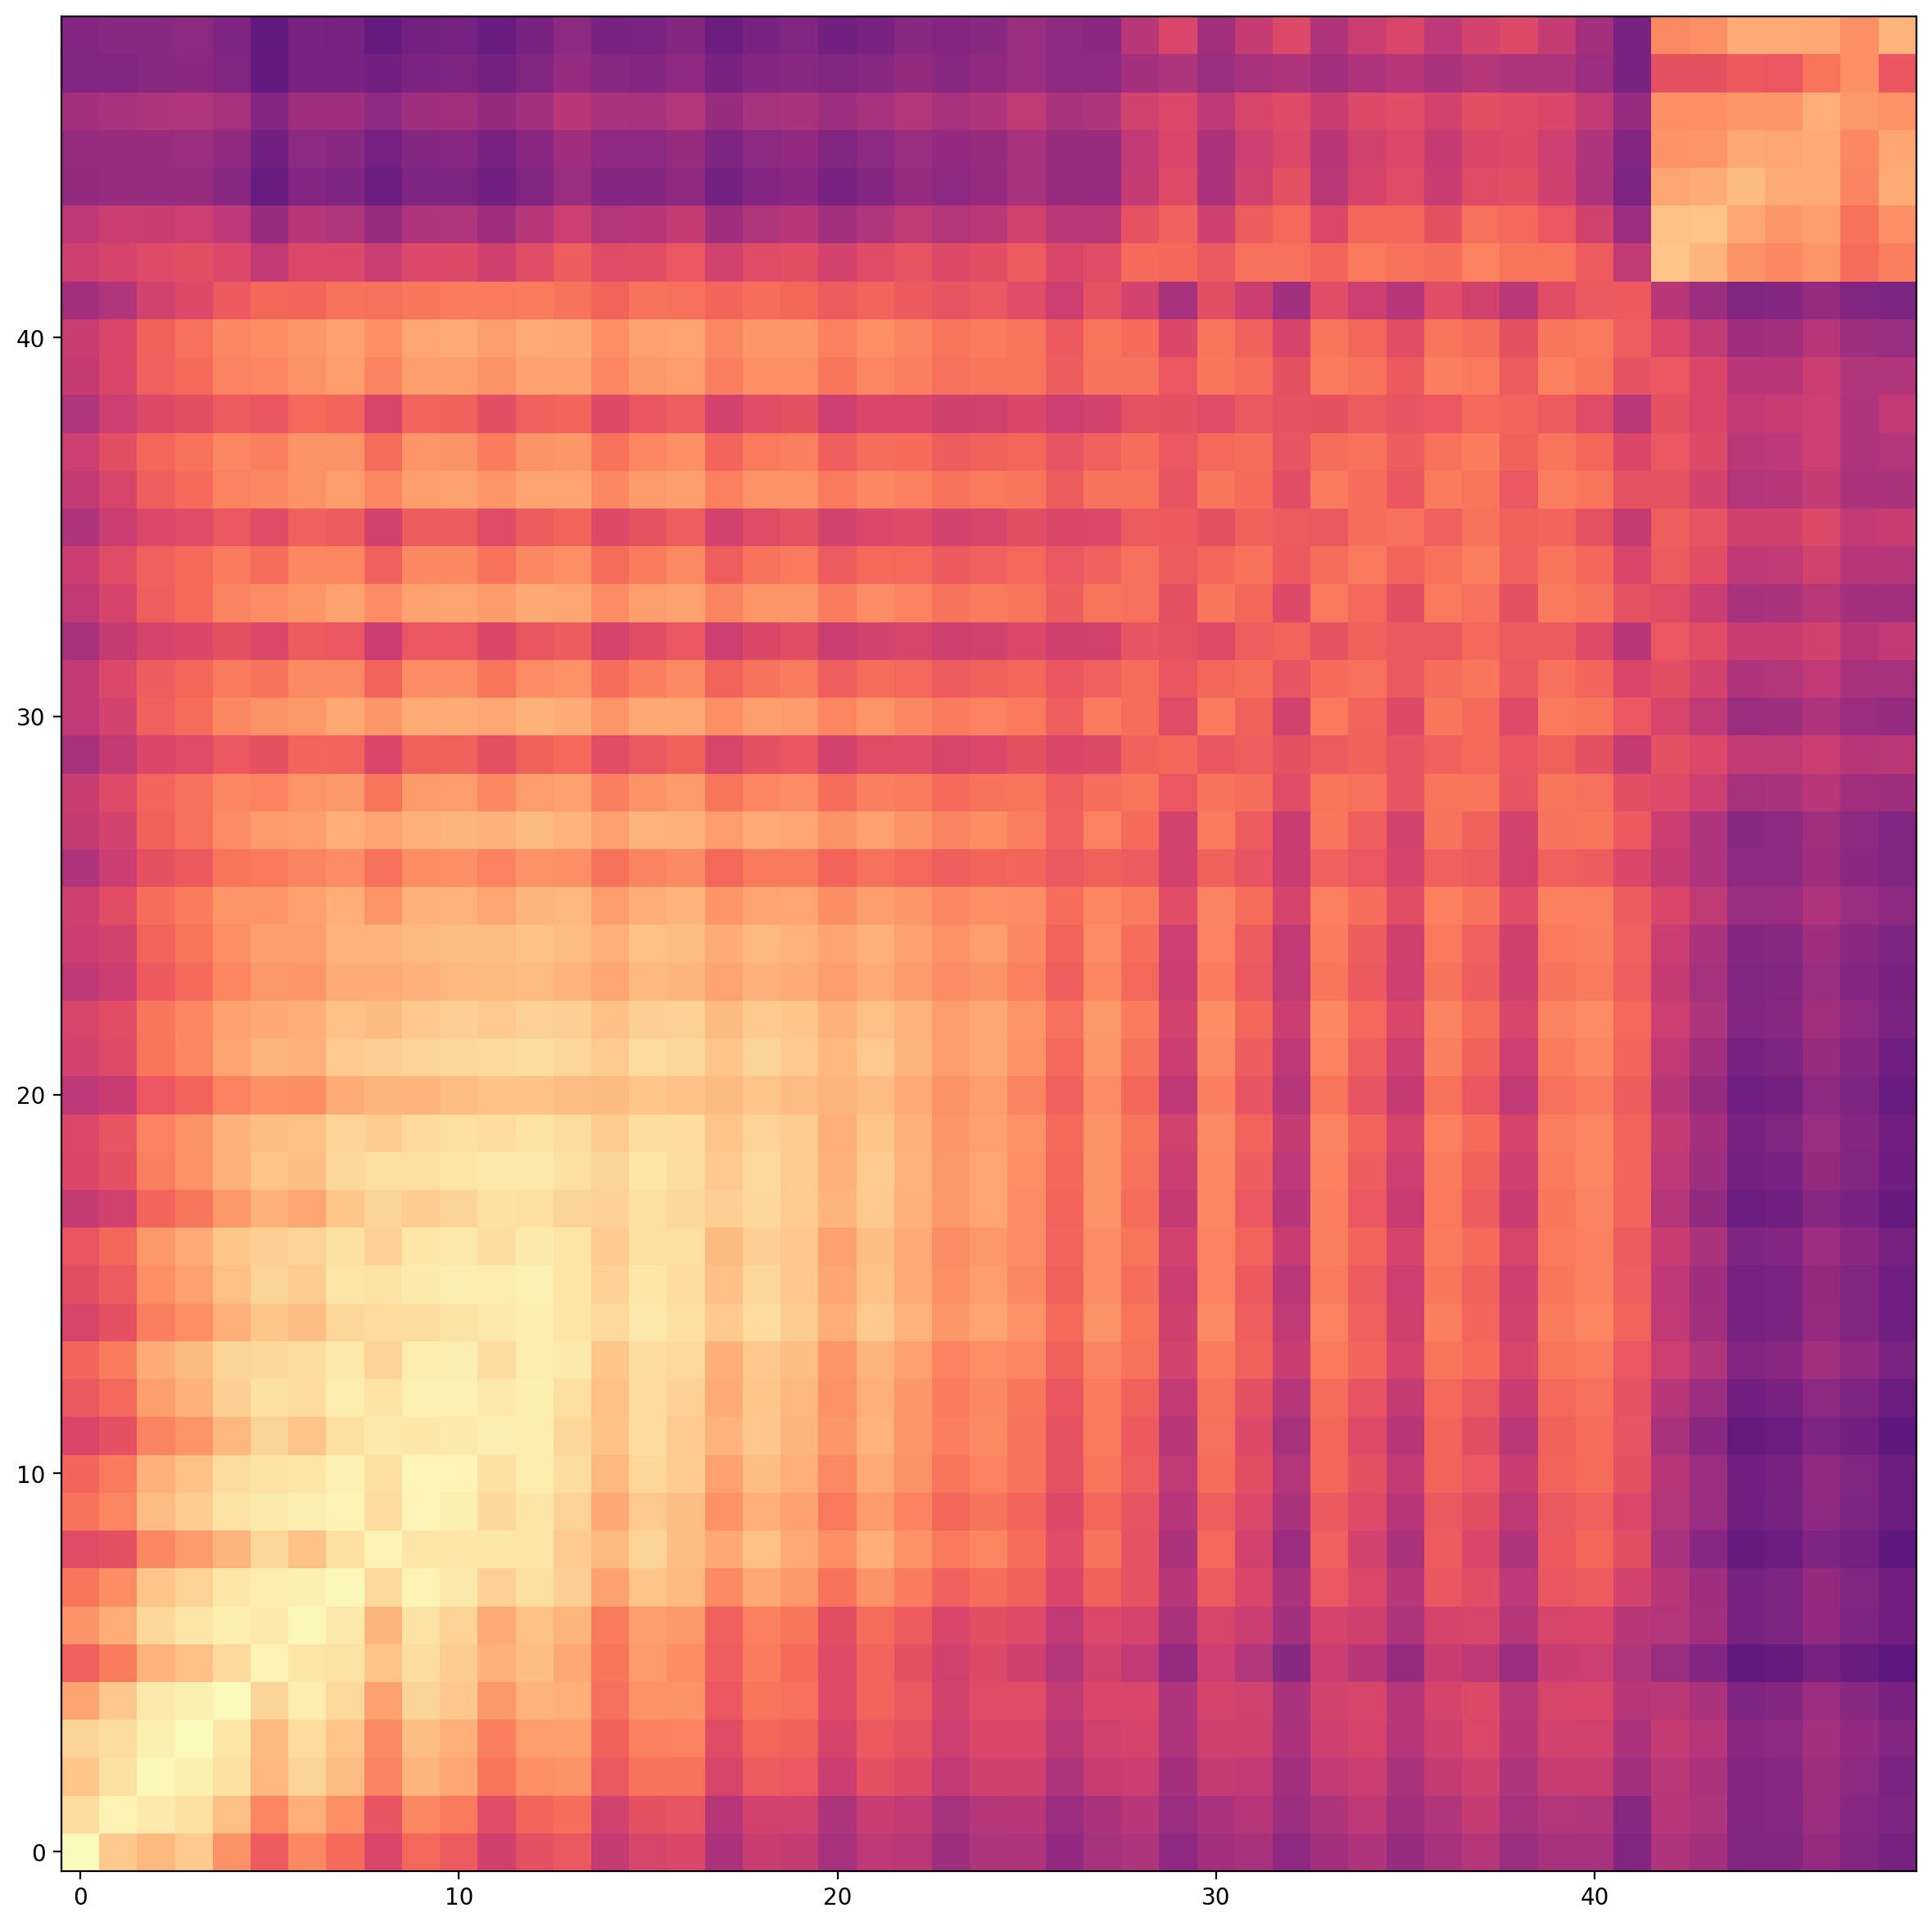

In [10]:
for cl in range(10):
    for r in range(2, 11, 2):
    #     for e in range(1, 11):
        cka = compare_model(
            cl, -1,
            -1, -1,
            r,
#             'homo',
            'noniid-labeldir',
            'R50-NIID',
            datadir='~/data', modeldir='../ckpt',
            model=ResNet50,
#             epoch=e
        )
        plot(cka, f'/mnt/c/Users/ajh50/Pictures/실험/local{cl}-global-test-comm{r}')
#         plot(cka, f'/mnt/c/Users/ajh50/Pictures/실험/local{cl}-global-train-comm{r}-epoch{e}')

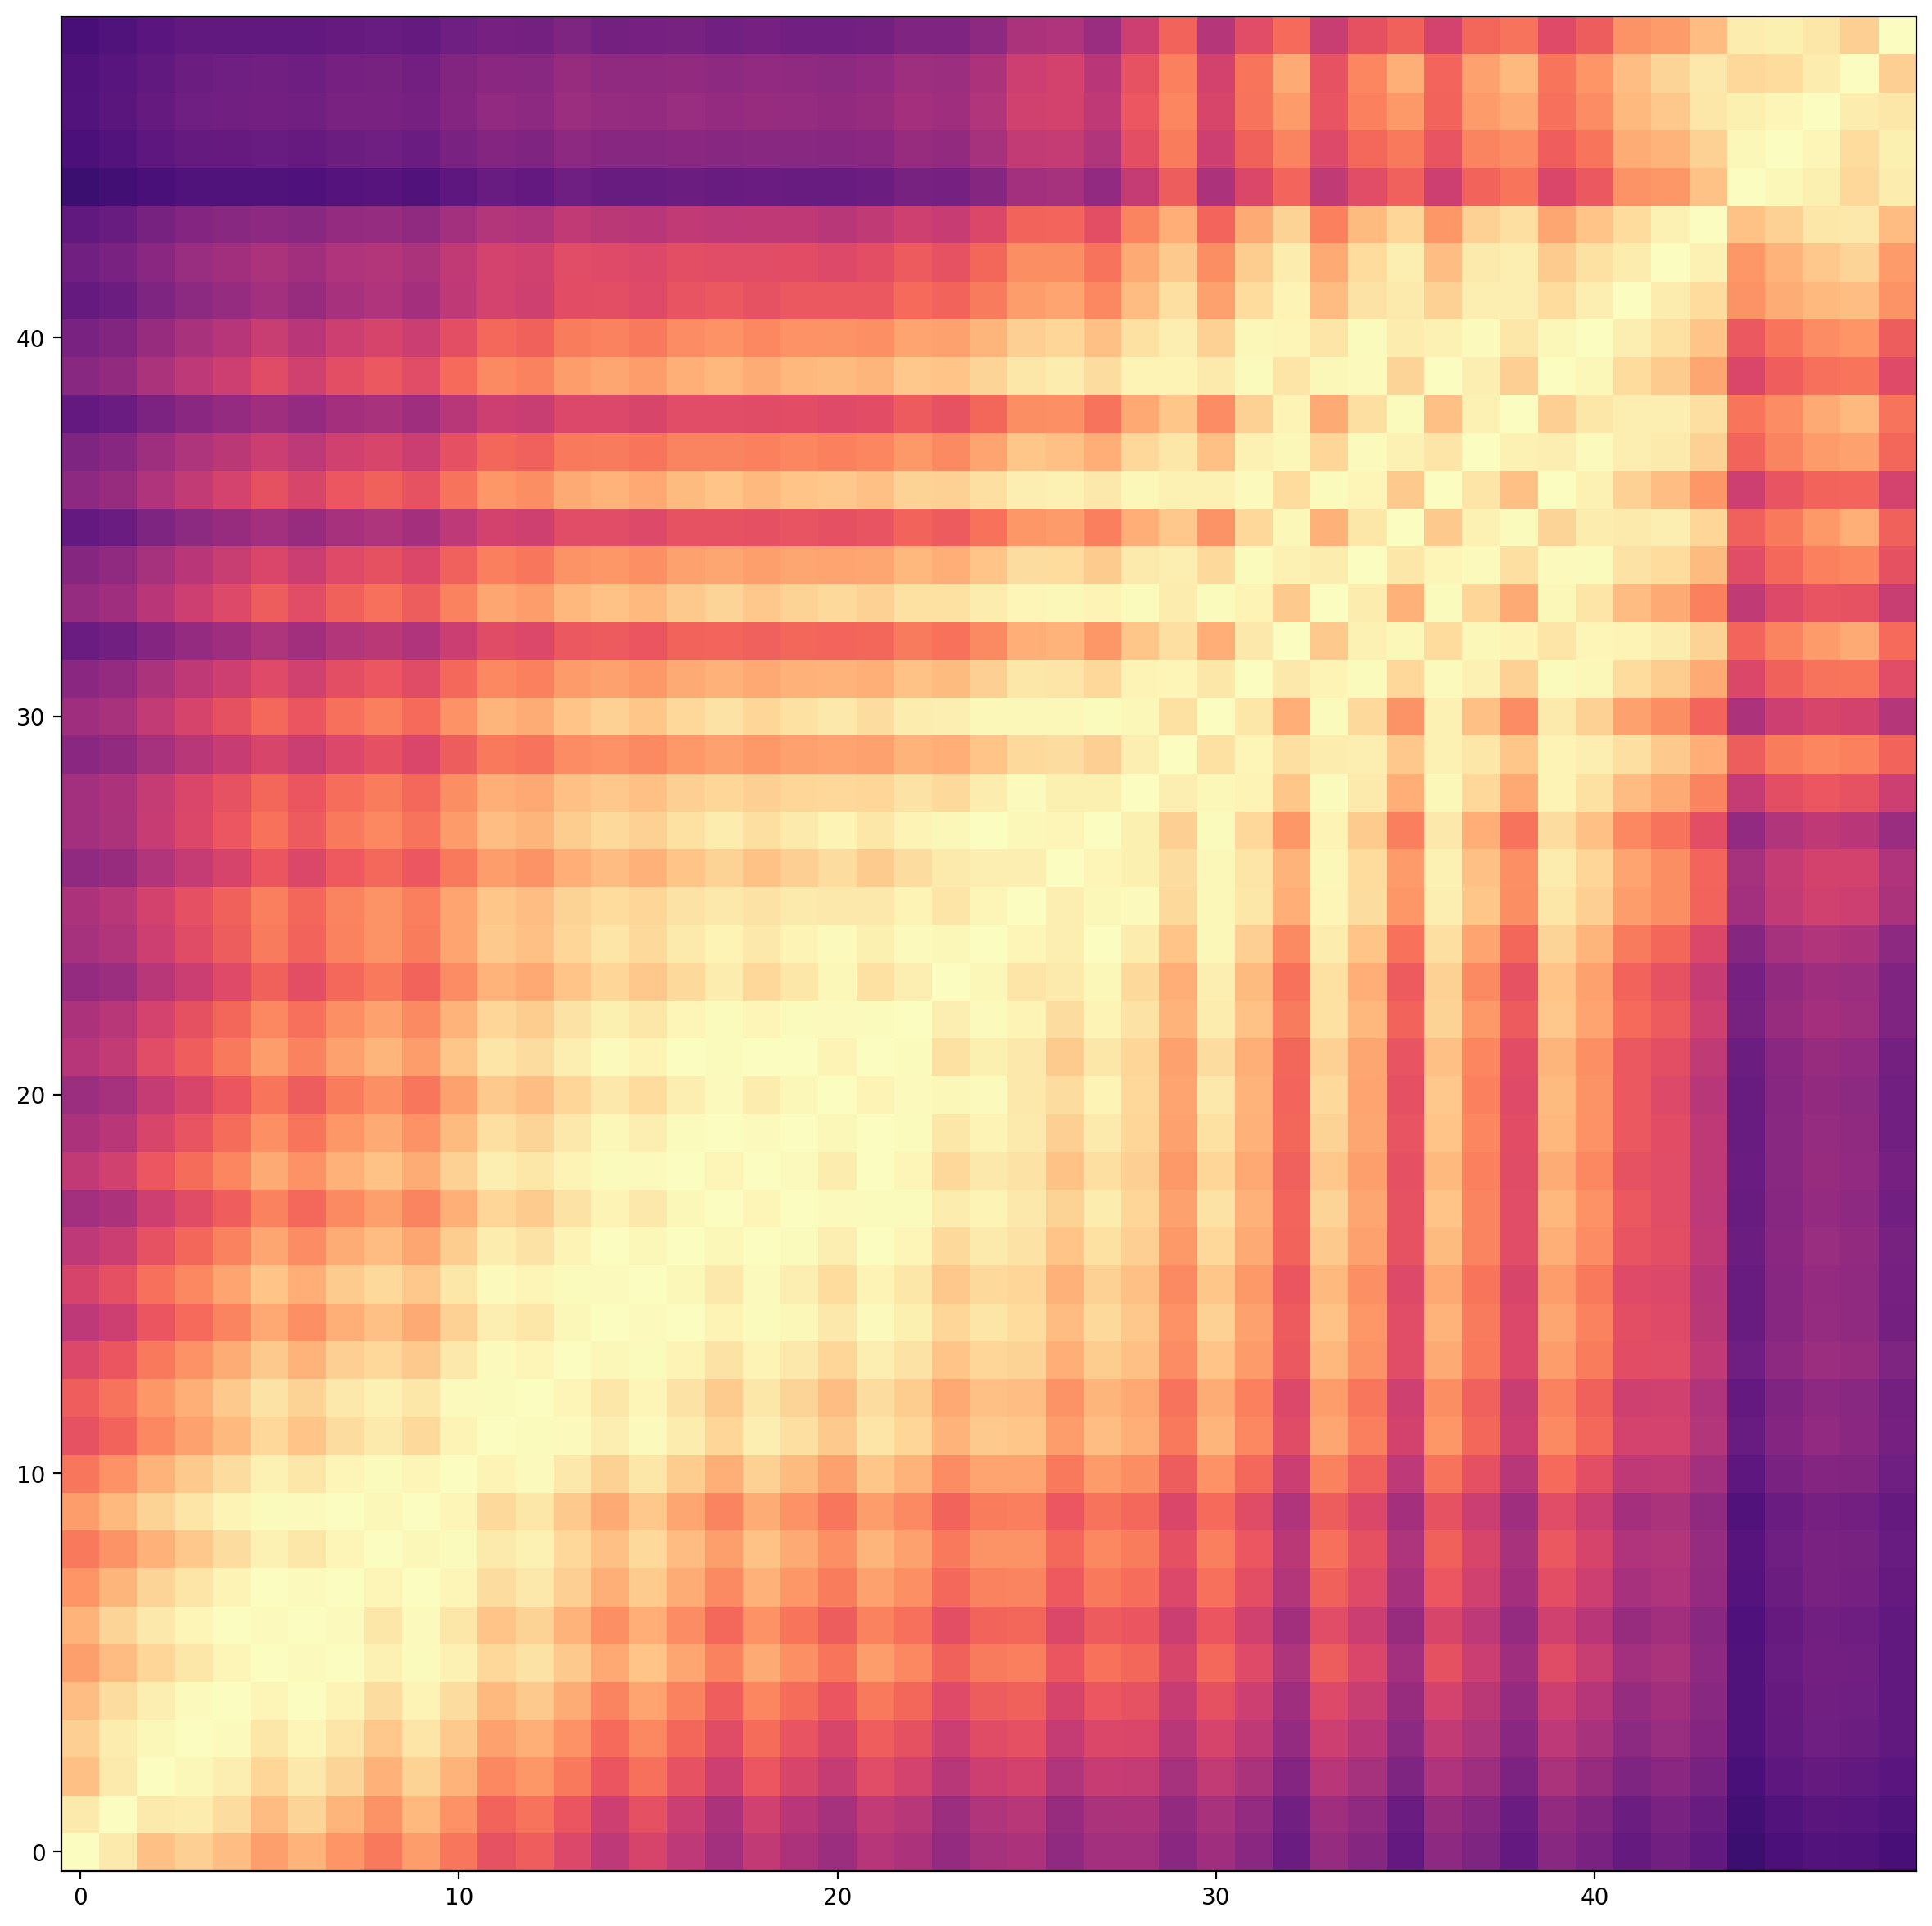

In [13]:
plot(cka) # local-train-test

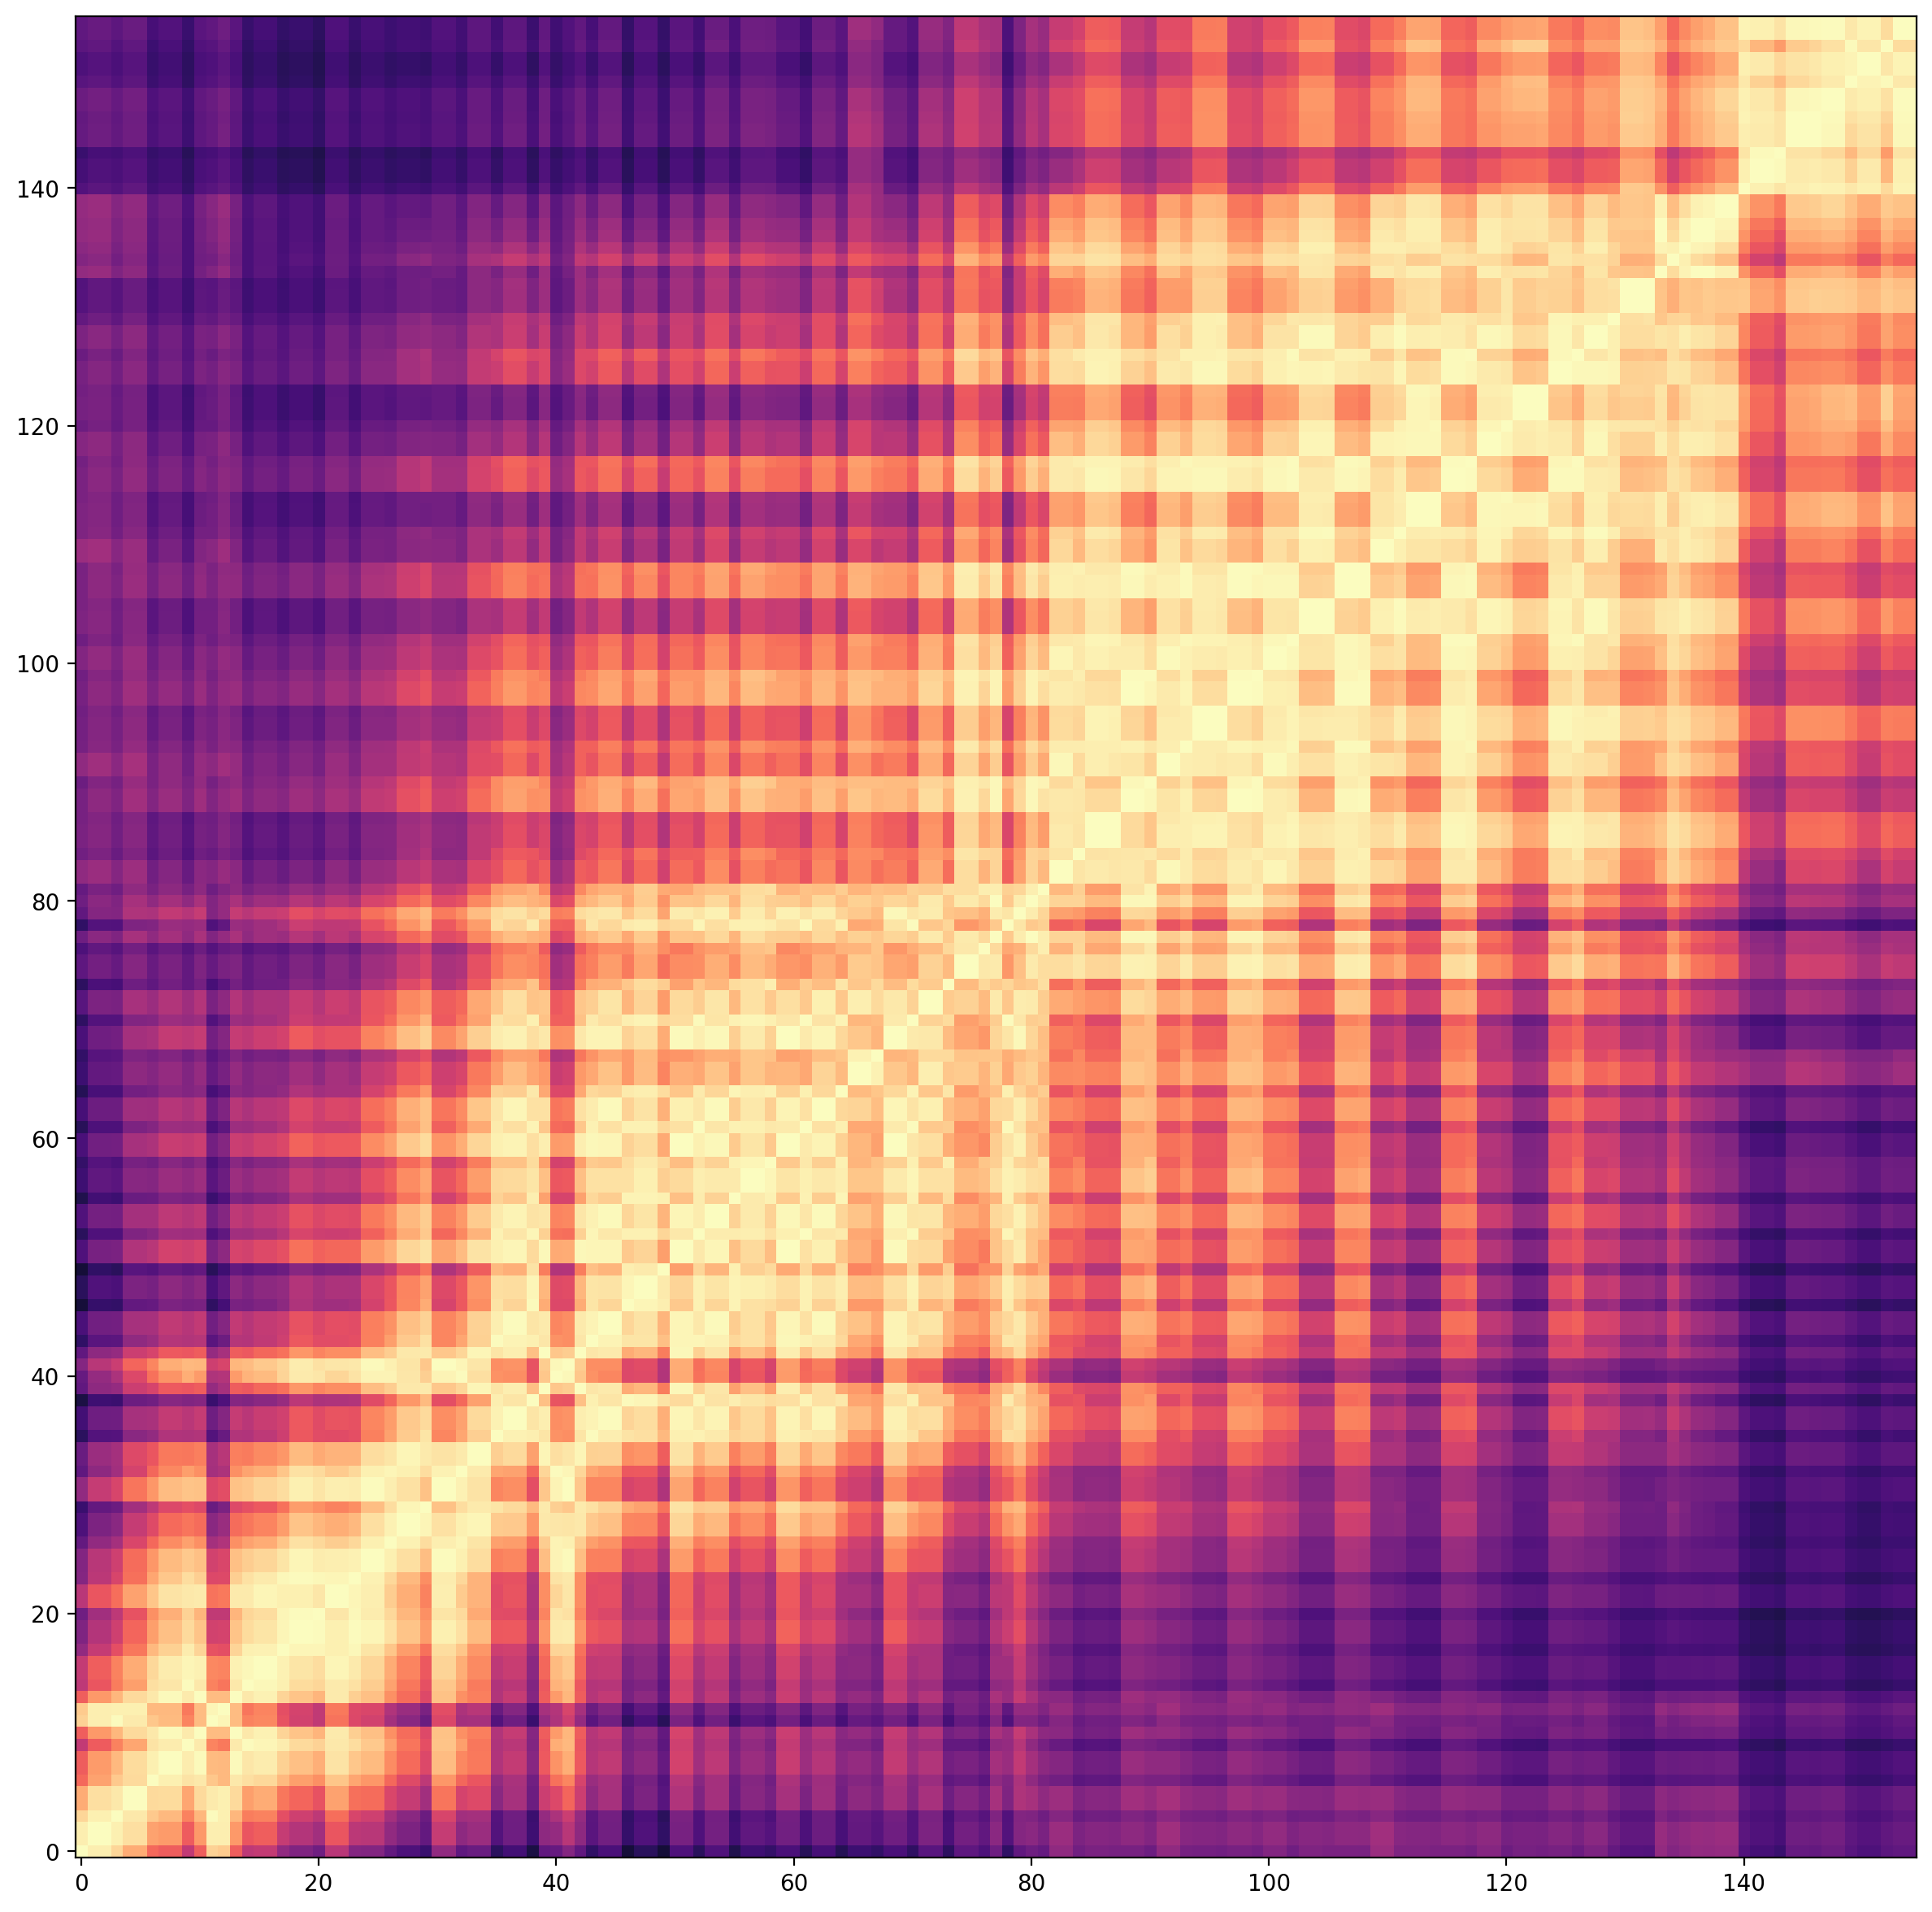

In [13]:
plot(cka_matrix) # local-test

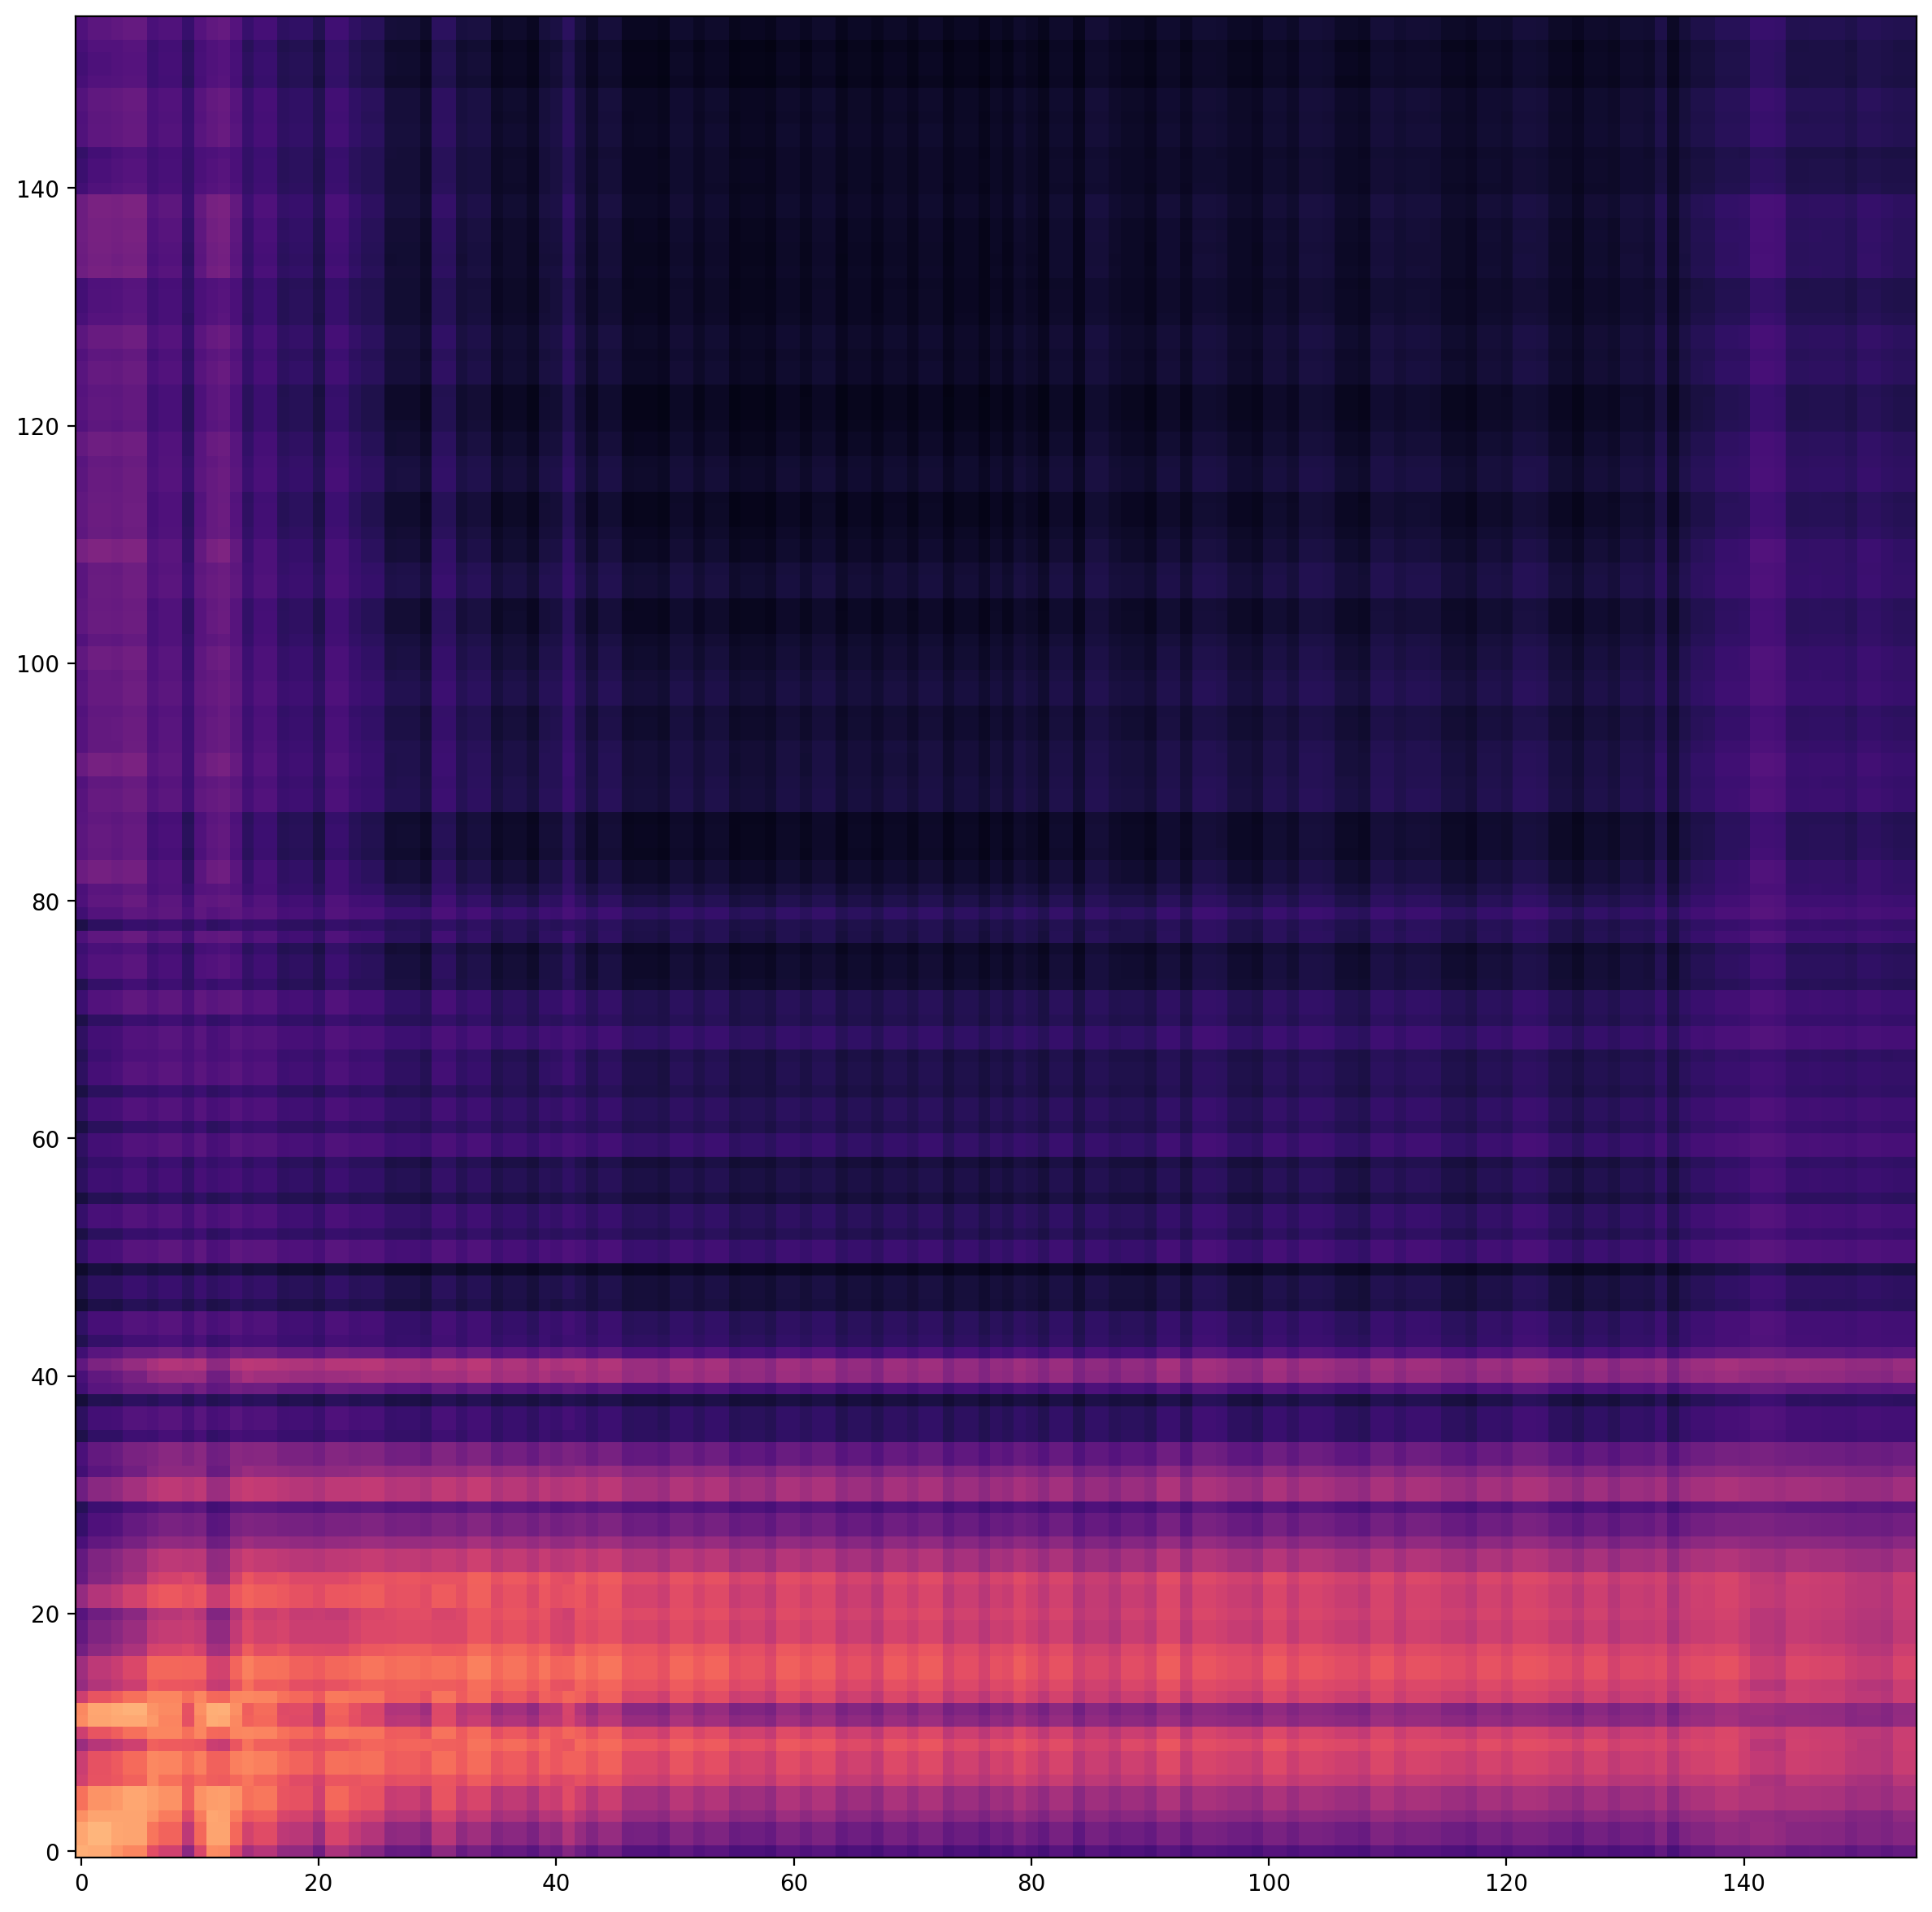

In [25]:
plot(cka_matrix) # local-global-train

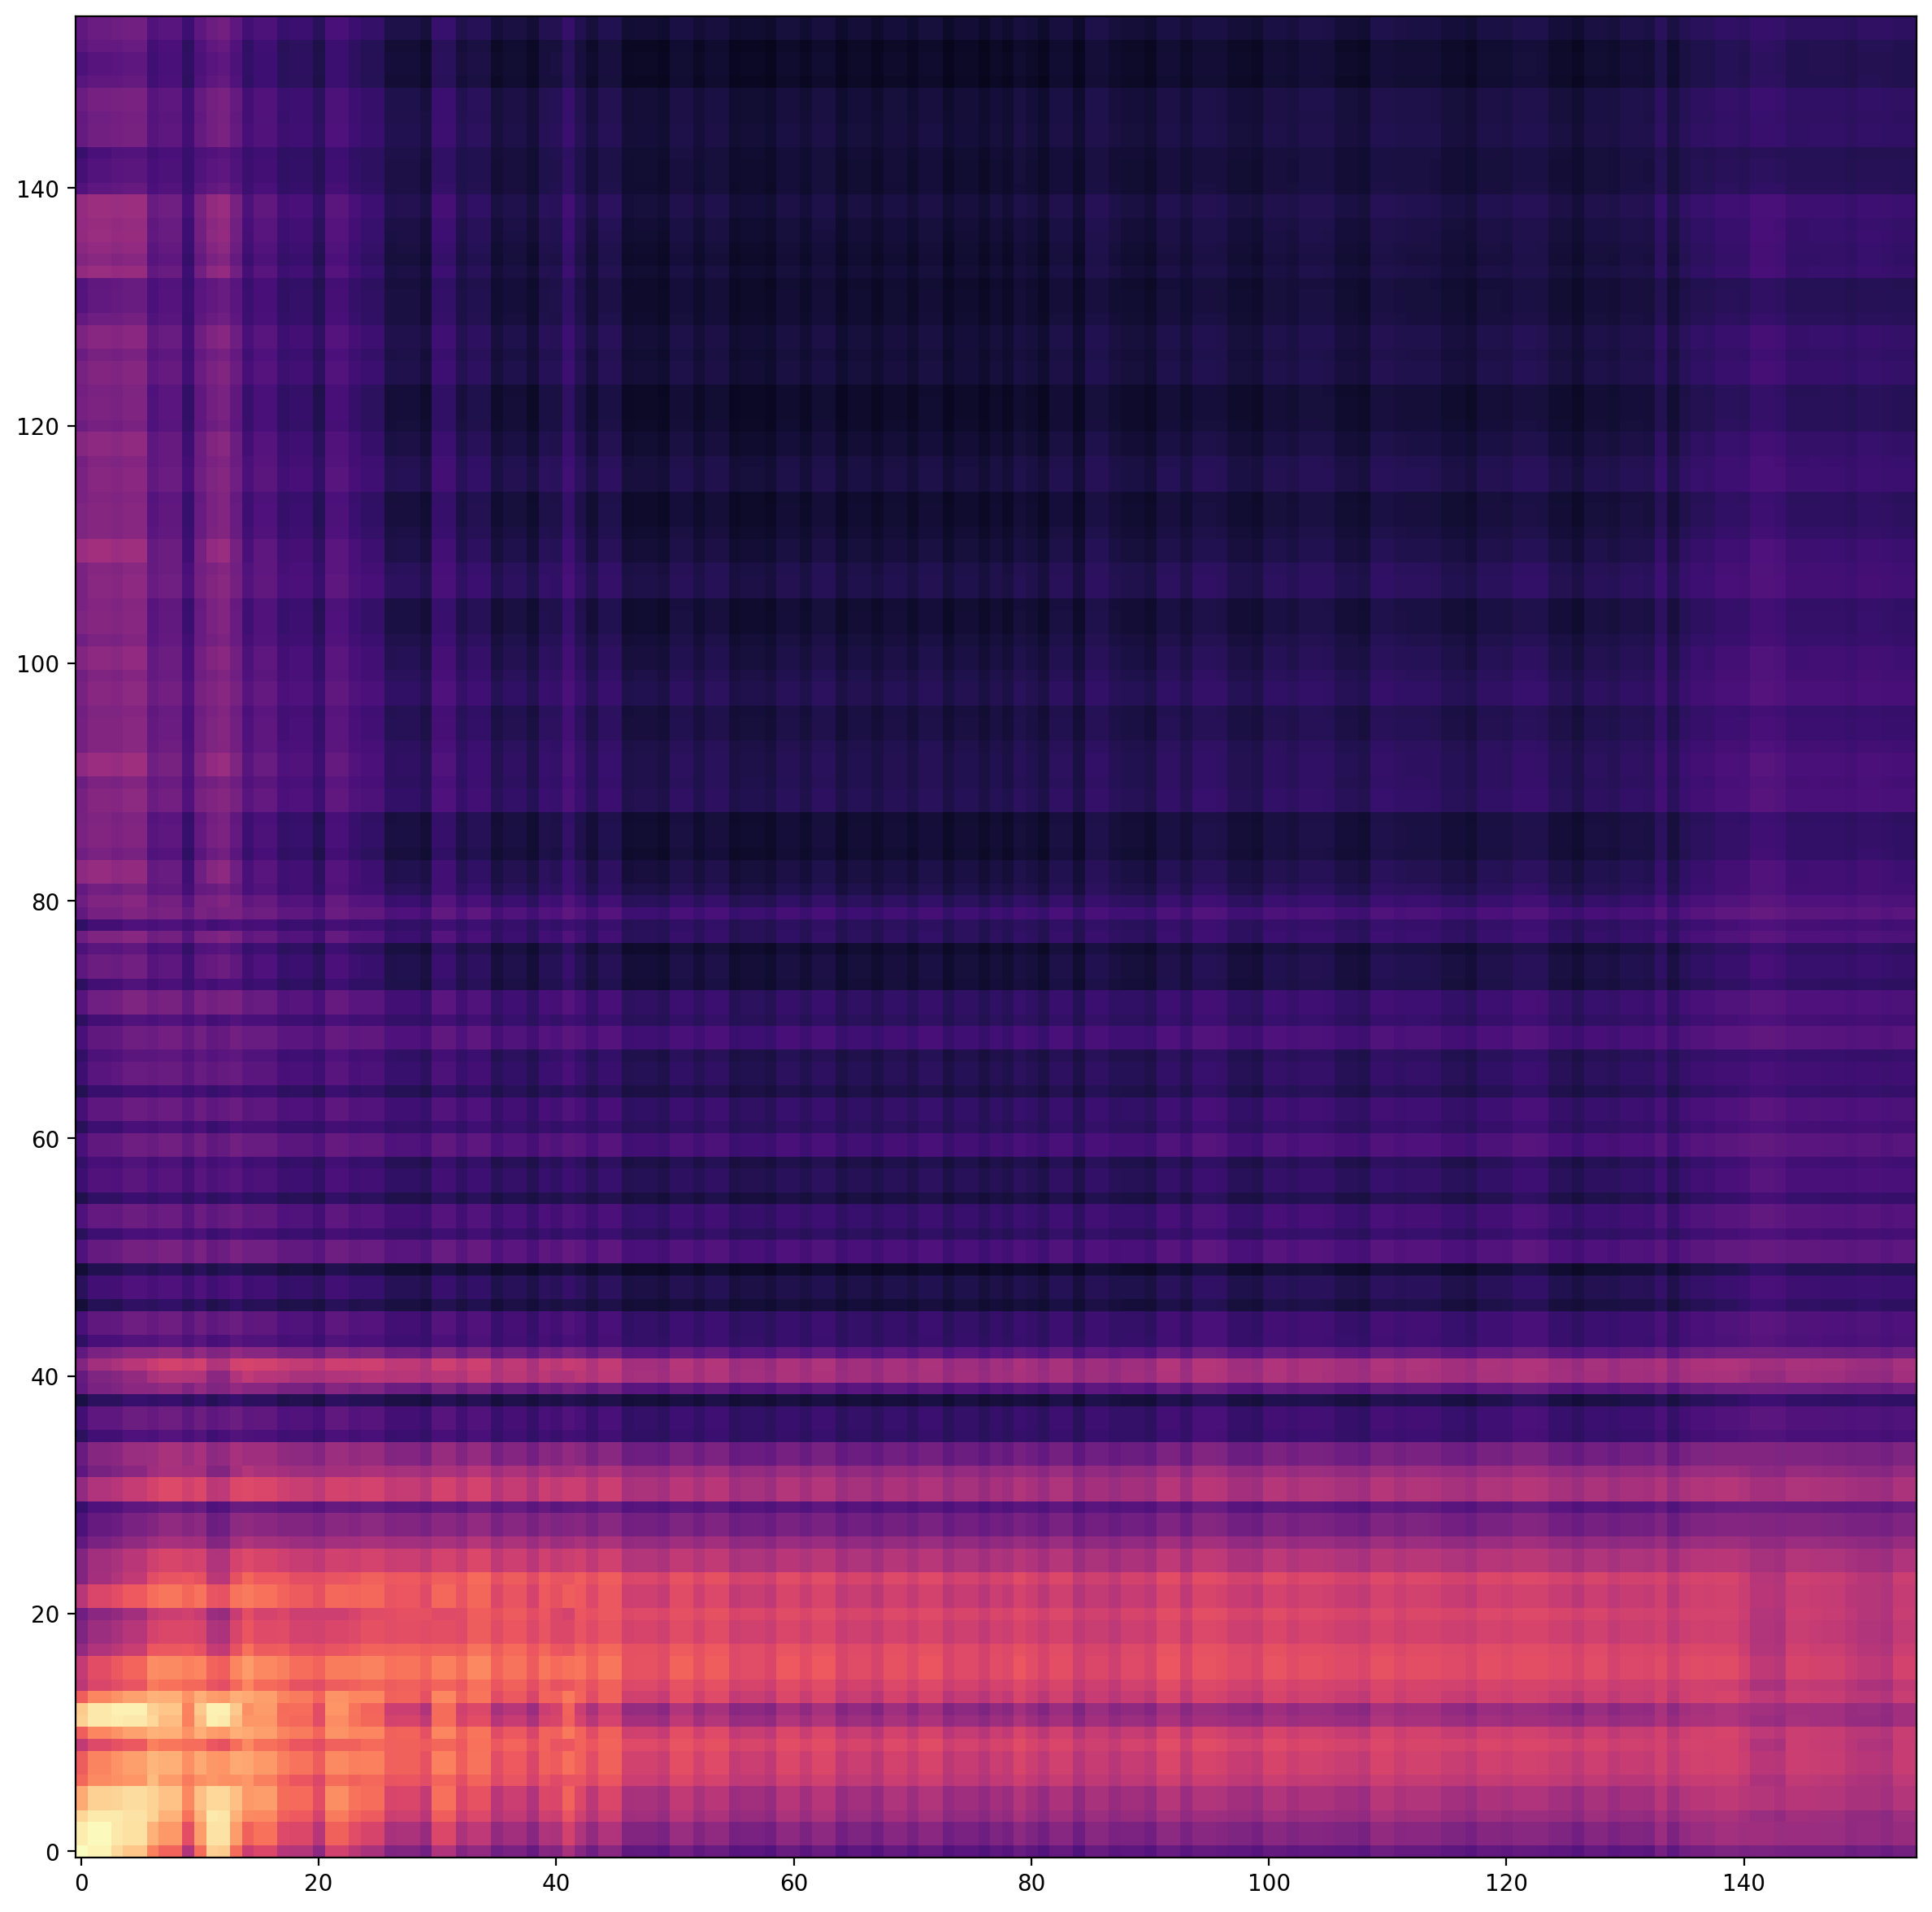

In [34]:
plot(cka_matrix) # local-global-test

In [10]:
from torch_cka import CKA

In [11]:
cka = CKA(client, client,
# cka = CKA(client, global_,
          model1_name="ResNet50-client0",   # good idea to provide names to avoid confusion
#           model2_name="ResNet50-global",   
          model2_name="ResNet50-client",   
          model1_layers=layers, # List of layers to extract features from
          model2_layers=layers, # extracts all layer features by default
          device='cuda')

In [11]:
cka = CKA(global_, global_,
# cka = CKA(client, global_,
          model1_name="ResNet50-client0",   # good idea to provide names to avoid confusion
#           model2_name="ResNet50-global",   
          model2_name="ResNet50-client",   
          model1_layers=layers, # List of layers to extract features from
          model2_layers=layers, # extracts all layer features by default
          device='cuda')

In [12]:
cka.compare(trainloader) # secondary dataloader is optional

/home/jahn/anaconda3/envs/torch182/lib/python3.9/site-packages/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


AssertionError: HSIC computation resulted in NANs

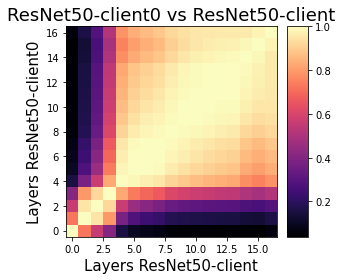

In [13]:
cka.plot_results()

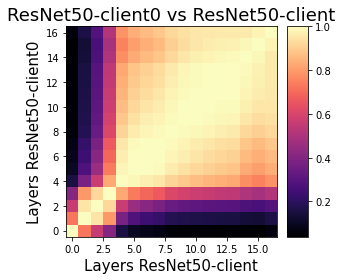

In [13]:
cka.plot_results()

In [37]:
results = cka.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix
results

{'model1_name': 'ResNet50-client0',
 'model2_name': 'ResNet50-global',
 'CKA': tensor([[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]),
 'model1_layers': [],
 'model2_layers': [],
 'dataset1_name': '<data.datasets.CIFAR10_truncated object at 0x7f72d8130ee0>',
 'dataset2_name': '<data.datasets.CIFAR10_truncated object at 0x7f72d8130ee0>'}

In [43]:
# For partition check

_, y_train, _,_ = load_cifar10_data('~/data')
net_cls_counts = {}
for net_i, dataidx in net_dataidx_map.items():
    unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
    net_cls_counts[net_i] = {unq[i]: unq_cnt[i] for i in range(len(unq))}
net_cls_counts

{0: {0: 149,
  1: 437,
  2: 7,
  3: 76,
  4: 231,
  5: 558,
  6: 556,
  7: 465,
  8: 214,
  9: 1286},
 1: {0: 586,
  1: 285,
  2: 1751,
  3: 79,
  4: 1169,
  5: 24,
  6: 14,
  7: 96,
  8: 5,
  9: 2343},
 2: {0: 17, 1: 227, 2: 13, 3: 1, 4: 2149, 6: 1713, 7: 25, 8: 85, 9: 77},
 3: {0: 1230,
  1: 10,
  2: 821,
  3: 253,
  4: 48,
  5: 759,
  6: 35,
  7: 568,
  8: 948,
  9: 613},
 4: {0: 328,
  1: 425,
  2: 89,
  3: 1258,
  4: 20,
  5: 149,
  6: 6,
  7: 329,
  8: 92,
  9: 524},
 5: {0: 1004,
  1: 17,
  2: 1001,
  3: 1760,
  4: 4,
  5: 700,
  6: 91,
  7: 87,
  8: 281,
  9: 82},
 6: {0: 39, 1: 1674, 2: 344, 3: 59, 4: 1119, 5: 1216, 6: 773},
 7: {0: 607,
  1: 778,
  2: 404,
  3: 14,
  4: 239,
  5: 1348,
  6: 134,
  7: 803,
  8: 646,
  9: 74},
 8: {0: 4, 1: 930, 2: 431, 3: 1051, 4: 20, 5: 70, 6: 1047, 7: 1080, 8: 751},
 9: {0: 1036,
  1: 217,
  2: 139,
  3: 449,
  4: 1,
  5: 176,
  6: 631,
  7: 1547,
  8: 1978,
  9: 1}}

In [ ]:
net_dataidx_map = get_partition_dict(
    'cifar10', 'noniid-labeldir', 10, datadir='~/data', init_seed=0,
    beta=0.5
)